In [3]:
#Look for a model to be trained to perform semantic segmentation
#Dataset + related guide: https://idiotdeveloper.com/unet-implementation-in-tensorflow-using-keras-api/
#                         https://www.kaggle.com/datasets/b9d4e32be2f57c2901fc9c5cd5f6633be7075f4b32d73348a6d5db245f2c1934

#Semantic segmentation using U-Net: https://towardsdatascience.com/understanding-semantic-segmentation-with-unet-6be4f42d4b47

In [4]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [5]:
path = '/Users/salvo/BackgroundRemover/people_segmentation/masks/ache-adult-depression-expression-41253.png'

For this example image we extract the "MASK" which should contain all zero values and ones corresponding to the mask

In [6]:
img = cv2.imread(path)
#img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#plt.imshow(img)
#plt.show()
print(np.max(img))
print(np.min(img))
print(img.shape)

1
0
(800, 533, 3)


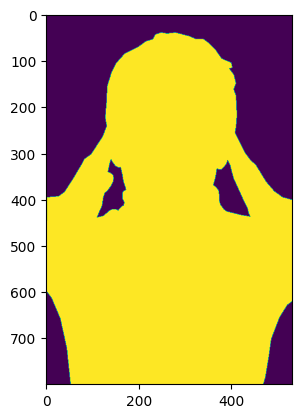

In [7]:
#_, img = cv2.threshold(img,0,255,cv2.THRESH_BINARY)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(img)
plt.show()

In [8]:
path = '/Users/salvo/BackgroundRemover/people_segmentation/images/ache-adult-depression-expression-41253.jpg'

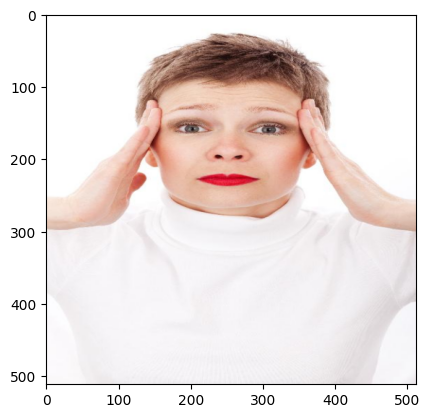

In [9]:
img = cv2.imread(path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

dim = (512, 512)
resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

plt.imshow(resized)
plt.show()

In [10]:
print(np.max(img))
print(np.min(img))
print(img.shape)

255
0
(800, 533, 3)


Here we define the structure of the U-Net architecture in Keras/TensorFlow

In [11]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model

In [12]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

In [13]:
def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

In [14]:
def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

In [15]:
def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="U-Net")
    return model


In [16]:
input_shape = (512, 512, 3)
model = build_unet(input_shape)
model.summary()

2023-04-14 15:43:07.874796: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-14 15:43:07.875077: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro
Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 512, 512, 64  256        ['conv2d[0][0]']                 
 alization)                     )                           

                                                                                                  
 conv2d_8 (Conv2D)              (None, 32, 32, 1024  4719616     ['max_pooling2d_3[0][0]']        
                                )                                                                 
                                                                                                  
 batch_normalization_8 (BatchNo  (None, 32, 32, 1024  4096       ['conv2d_8[0][0]']               
 rmalization)                   )                                                                 
                                                                                                  
 activation_8 (Activation)      (None, 32, 32, 1024  0           ['batch_normalization_8[0][0]']  
                                )                                                                 
                                                                                                  
 conv2d_9 

                                                                                                  
 activation_15 (Activation)     (None, 256, 256, 12  0           ['batch_normalization_15[0][0]'] 
                                8)                                                                
                                                                                                  
 conv2d_transpose_3 (Conv2DTran  (None, 512, 512, 64  32832      ['activation_15[0][0]']          
 spose)                         )                                                                 
                                                                                                  
 concatenate_3 (Concatenate)    (None, 512, 512, 12  0           ['conv2d_transpose_3[0][0]',     
                                8)                                'activation_1[0][0]']           
                                                                                                  
 conv2d_16

Here we load the lists of names identifying images belonging to train, trainval and val sets:

In [17]:
import os

In [18]:
with open("/Users/salvo/BackgroundRemover/people_segmentation/segmentation/train.txt", "r") as f:
    train_list = f.read().split("\n")
with open("/Users/salvo/BackgroundRemover/people_segmentation/segmentation/trainval.txt", "r") as f:
    trainval_list = f.read().split("\n")
with open("/Users/salvo/BackgroundRemover/people_segmentation/segmentation/val.txt", "r") as f:
    val_list = f.read().split("\n")  

In [17]:
'''images_segmantation = []
for _,_,c in os.walk('/Users/salvo/BackgroundRemover/people_segmentation/images/'):
    images_segmantation = c'''

"images_segmantation = []\nfor _,_,c in os.walk('/Users/salvo/BackgroundRemover/people_segmentation/images/'):\n    images_segmantation = c"

In [18]:
'''mask_segmentation = []
for _,_,c in os.walk('/Users/salvo/BackgroundRemover/people_segmentation/masks/'):
    mask_segmentation = c'''

"mask_segmentation = []\nfor _,_,c in os.walk('/Users/salvo/BackgroundRemover/people_segmentation/masks/'):\n    mask_segmentation = c"

In [19]:
'''images_list = train_list + trainval_list + val_list'''

'images_list = train_list + trainval_list + val_list'

In [20]:
'''for filename in images_list:
    if filename + ".jpg" not in images_segmantation:
        print(filename + " not in images folder")
    if filename + ".png" not in mask_segmentation:
        print(filename +" not in masks folder")'''
    

'for filename in images_list:\n    if filename + ".jpg" not in images_segmantation:\n        print(filename + " not in images folder")\n    if filename + ".png" not in mask_segmentation:\n        print(filename +" not in masks folder")'

Here we define a data generator which reads images from filesystem dynamically

In [19]:
import numpy as np
import cv2
from tensorflow.keras.utils import Sequence


class DataGenerator(Sequence):
    def __init__(self, list_IDs, labels, image_path, mask_path, to_fit=True, batch_size=8, dim=(512, 512), n_channels=3, n_classes=1, shuffle=True):
        self.list_IDs = list_IDs
        self.labels = labels
        self.image_path = image_path
        self.mask_path = mask_path
        self.to_fit = to_fit
        self.batch_size = batch_size
        self.dim = dim
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        X = self._generate_X(list_IDs_temp)
        if self.to_fit:
            y = self._generate_y(list_IDs_temp)
            return X, y
        else:
            return X

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def _generate_X(self, list_IDs_temp):
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        for i, ID in enumerate(list_IDs_temp):
            X[i,] = self._load_color_image(self.image_path + self.labels[ID] + ".jpg")
        return X

    def _generate_y(self, list_IDs_temp):
        y = np.empty((self.batch_size, *self.dim), dtype=int)
        for i, ID in enumerate(list_IDs_temp):
            y[i,] = self._load_bw_image(self.mask_path + self.labels[ID] + ".png")
        return y

    def _load_color_image(self, image_path):
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, self.dim, interpolation = cv2.INTER_AREA)
        img = img / 255
        return img
    
    def _load_bw_image(self, image_path):
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img, self.dim, interpolation = cv2.INTER_AREA)
        #img = np.expand_dims(img, axis=2)
        #img = img / 255
        return img

In [20]:
train_idx = [i for i in range(len(train_list))]
val_idx = [i for i in range(len(trainval_list))]
test_idx = [i for i in range(len(val_list))]

In [21]:
import tensorflow as tf
image_path = '/Users/salvo/BackgroundRemover/people_segmentation/images/'
mask_path = '/Users/salvo/BackgroundRemover/people_segmentation/masks/'

training_generator = DataGenerator(train_idx, train_list, image_path, mask_path)
validation_generator = DataGenerator(val_idx, trainval_list, image_path, mask_path)
test_generator = DataGenerator(test_idx, val_list, image_path, mask_path)

In [22]:
from tensorflow import keras
model = keras.models.load_model('semantic_segmantation')

In [ ]:
# Design model
#model = Sequential()
#[...] # Architecture
model.compile(optimizer="Adam", loss=tf.keras.losses.BinaryCrossentropy(), metrics=[tf.keras.metrics.BinaryCrossentropy()])

#model.fit(training_generator, validation_data=validation_generator)

In [52]:
history = model.fit(training_generator, validation_data=validation_generator, epochs=5)

Epoch 1/5


2023-01-27 15:19:00.640372: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


638/638 [==============================] - 3069s 5s/step - loss: 0.2246 - binary_crossentropy: 0.2246 - val_loss: 0.2072 - val_binary_crossentropy: 0.2072
Epoch 2/5
638/638 [==============================] - 2988s 5s/step - loss: 0.2146 - binary_crossentropy: 0.2146 - val_loss: 0.2169 - val_binary_crossentropy: 0.2169
Epoch 3/5
638/638 [==============================] - 3272s 5s/step - loss: 0.2075 - binary_crossentropy: 0.2075 - val_loss: 0.2285 - val_binary_crossentropy: 0.2285
Epoch 4/5
638/638 [==============================] - 3004s 5s/step - loss: 0.1974 - binary_crossentropy: 0.1974 - val_loss: 0.2188 - val_binary_crossentropy: 0.2188
Epoch 5/5
638/638 [==============================] - 18364s 29s/step - loss: 0.1923 - binary_crossentropy: 0.1923 - val_loss: 0.2958 - val_binary_crossentropy: 0.2958


In [28]:
model.save("semantic_segmantation")

INFO:tensorflow:Assets written to: semantic_segmantation/assets


INFO:tensorflow:Assets written to: semantic_segmantation/assets


In [21]:
model.evaluate(test_generator)

2023-04-14 15:23:56.969731: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-04-14 15:23:57.084537: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


71/71 [==============================] - 69s 963ms/step - loss: 0.2296 - binary_crossentropy: 0.2296


[0.22962932288646698, 0.22962932288646698]

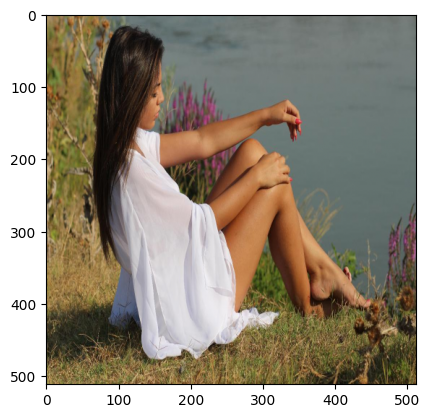

In [22]:
a = training_generator[0][0][2]
plt.imshow(a)
plt.show()

In [121]:
photo_test = '/Users/salvo/Desktop/mr_bean.jpeg'

In [122]:
img = cv2.imread(photo_test)

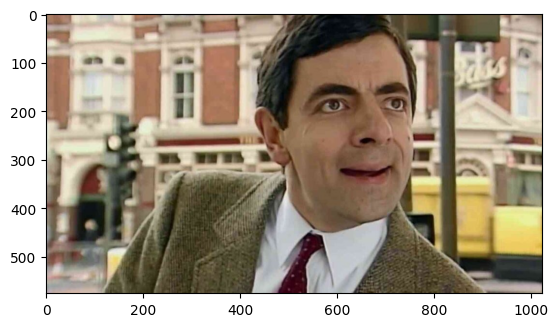

In [123]:
img = cv2.imread(photo_test)
height, width = img.shape[0], img.shape[1]
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()
img = cv2.resize(img, (512, 512), interpolation = cv2.INTER_AREA)
img = img / 255

In [124]:
test_photo = np.asarray([img])

In [125]:
result = model.predict(test_photo, batch_size=1)

1/1 [==============================] - 0s 29ms/step


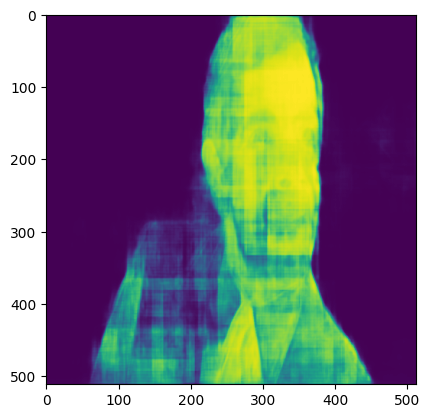

In [126]:
from matplotlib import pyplot as plt
plt.imshow(
    result[0]
)
plt.show()

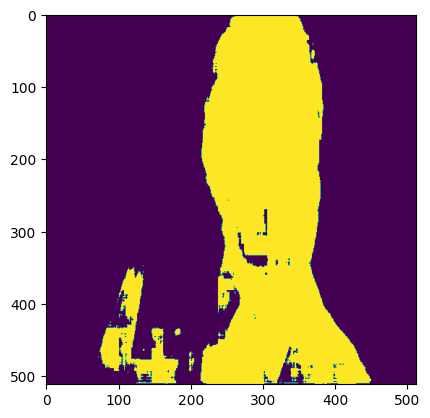

In [127]:
_,thresh1 = cv2.threshold(result[0], 0.5, 1, cv2.THRESH_BINARY)
plt.imshow(thresh1)
plt.show()

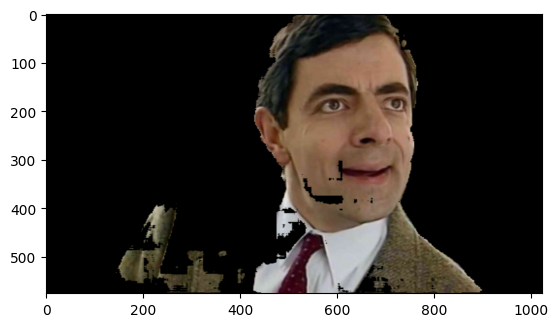

In [128]:
img[thresh1 == 0] = 0
img = cv2.resize(img, dsize=(width, height))   
plt.imshow(img)
plt.show()

# Video conversion

In [30]:
from tqdm import tqdm

In [31]:
cap = cv2.VideoCapture('/Users/salvo/Downloads/When More People Speak Up, More People Listen.mp4')

In [32]:
video_fps = cap.get(cv2.CAP_PROP_FPS),
total_frames = cap.get(cv2.CAP_PROP_FRAME_COUNT)
height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
width = cap.get(cv2.CAP_PROP_FRAME_WIDTH)

print(f"Frame Per second: {video_fps } \nTotal Frames: {total_frames} \n Height: {height} \nWidth: {width}")

Frame Per second: (23.976023976023978,) 
Total Frames: 5868.0 
 Height: 720.0 
Width: 1280.0


In [33]:
frames = []
for i in tqdm(range(int(total_frames))):
    ret, frame = cap.read()
    if not ret: 
        break # break if no next frame
    #img = cv2.imread(photo_test)
    img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (512, 512), interpolation = cv2.INTER_AREA)
    img = img / 255
    result = model.predict(np.asarray([img]), batch_size=1)
    _,thresh1 = cv2.threshold(result[0], 0.5, 1, cv2.THRESH_BINARY)
    img[thresh1 == 0] = 0
    frames.append(img)

  0%|                                                  | 0/5868 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step


  0%|                                          | 1/5868 [00:00<19:48,  4.94it/s]

1/1 [==============================] - 0s 17ms/step


  0%|                                          | 2/5868 [00:00<17:18,  5.65it/s]

1/1 [==============================] - 0s 19ms/step


  0%|                                          | 3/5868 [00:00<16:35,  5.89it/s]

1/1 [==============================] - 0s 16ms/step


  0%|                                          | 4/5868 [00:00<16:08,  6.05it/s]

1/1 [==============================] - 0s 17ms/step


  0%|                                          | 5/5868 [00:00<15:57,  6.12it/s]

1/1 [==============================] - 0s 17ms/step


  0%|                                          | 6/5868 [00:01<15:55,  6.13it/s]

1/1 [==============================] - 0s 16ms/step


  0%|                                          | 7/5868 [00:01<15:50,  6.17it/s]

1/1 [==============================] - 0s 18ms/step


  0%|                                          | 8/5868 [00:01<15:53,  6.14it/s]

1/1 [==============================] - 0s 17ms/step


  0%|                                          | 9/5868 [00:01<15:47,  6.18it/s]

1/1 [==============================] - 0s 16ms/step


  0%|                                         | 10/5868 [00:01<15:39,  6.24it/s]

1/1 [==============================] - 0s 16ms/step


  0%|                                         | 11/5868 [00:01<15:36,  6.25it/s]

1/1 [==============================] - 0s 16ms/step


  0%|                                         | 12/5868 [00:01<15:32,  6.28it/s]

1/1 [==============================] - 0s 17ms/step


  0%|                                         | 13/5868 [00:02<15:30,  6.29it/s]

1/1 [==============================] - 0s 19ms/step


  0%|                                         | 14/5868 [00:02<15:33,  6.27it/s]

1/1 [==============================] - 0s 17ms/step


  0%|                                         | 15/5868 [00:02<15:30,  6.29it/s]

1/1 [==============================] - 0s 18ms/step


  0%|                                         | 16/5868 [00:02<15:33,  6.27it/s]

1/1 [==============================] - 0s 17ms/step


  0%|                                         | 17/5868 [00:02<15:35,  6.25it/s]

1/1 [==============================] - 0s 18ms/step


  0%|▏                                        | 18/5868 [00:02<15:31,  6.28it/s]

1/1 [==============================] - 0s 17ms/step


  0%|▏                                        | 19/5868 [00:03<15:28,  6.30it/s]

1/1 [==============================] - 0s 18ms/step


  0%|▏                                        | 20/5868 [00:03<15:28,  6.30it/s]

1/1 [==============================] - 0s 16ms/step


  0%|▏                                        | 21/5868 [00:03<15:23,  6.33it/s]

1/1 [==============================] - 0s 17ms/step


  0%|▏                                        | 22/5868 [00:03<15:23,  6.33it/s]

1/1 [==============================] - 0s 17ms/step


  0%|▏                                        | 23/5868 [00:03<15:32,  6.27it/s]

1/1 [==============================] - 0s 18ms/step


  0%|▏                                        | 24/5868 [00:03<15:30,  6.28it/s]

1/1 [==============================] - 0s 17ms/step


  0%|▏                                        | 25/5868 [00:04<15:26,  6.31it/s]

1/1 [==============================] - 0s 17ms/step


  0%|▏                                        | 26/5868 [00:04<15:28,  6.29it/s]

1/1 [==============================] - 0s 17ms/step


  0%|▏                                        | 27/5868 [00:04<15:26,  6.30it/s]

1/1 [==============================] - 0s 18ms/step


  0%|▏                                        | 28/5868 [00:04<15:27,  6.29it/s]

1/1 [==============================] - 0s 17ms/step


  0%|▏                                        | 29/5868 [00:04<15:25,  6.31it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▏                                        | 30/5868 [00:04<15:29,  6.28it/s]

1/1 [==============================] - 0s 16ms/step


  1%|▏                                        | 31/5868 [00:04<15:28,  6.29it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▏                                        | 32/5868 [00:05<15:22,  6.33it/s]

1/1 [==============================] - 0s 16ms/step


  1%|▏                                        | 33/5868 [00:05<15:18,  6.35it/s]

1/1 [==============================] - 0s 16ms/step


  1%|▏                                        | 34/5868 [00:05<15:13,  6.39it/s]

1/1 [==============================] - 0s 16ms/step


  1%|▏                                        | 35/5868 [00:05<15:12,  6.39it/s]

1/1 [==============================] - 0s 15ms/step


  1%|▎                                        | 36/5868 [00:05<15:08,  6.42it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▎                                        | 37/5868 [00:05<15:12,  6.39it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▎                                        | 38/5868 [00:06<15:10,  6.40it/s]

1/1 [==============================] - 0s 16ms/step


  1%|▎                                        | 39/5868 [00:06<15:11,  6.39it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▎                                        | 40/5868 [00:06<15:14,  6.37it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▎                                        | 41/5868 [00:06<15:19,  6.34it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▎                                        | 42/5868 [00:06<15:17,  6.35it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▎                                        | 43/5868 [00:06<15:18,  6.34it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▎                                        | 44/5868 [00:07<15:15,  6.36it/s]

1/1 [==============================] - 0s 16ms/step


  1%|▎                                        | 45/5868 [00:07<15:14,  6.37it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▎                                        | 46/5868 [00:07<15:14,  6.36it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▎                                        | 47/5868 [00:07<15:11,  6.38it/s]

1/1 [==============================] - 0s 16ms/step


  1%|▎                                        | 48/5868 [00:07<15:12,  6.38it/s]

1/1 [==============================] - 0s 16ms/step


  1%|▎                                        | 49/5868 [00:07<15:10,  6.39it/s]

1/1 [==============================] - 0s 16ms/step


  1%|▎                                        | 50/5868 [00:07<15:09,  6.40it/s]

1/1 [==============================] - 0s 16ms/step


  1%|▎                                        | 51/5868 [00:08<15:10,  6.39it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▎                                        | 52/5868 [00:08<15:09,  6.39it/s]

1/1 [==============================] - 0s 16ms/step


  1%|▎                                        | 53/5868 [00:08<15:09,  6.39it/s]

1/1 [==============================] - 0s 16ms/step


  1%|▍                                        | 54/5868 [00:08<15:05,  6.42it/s]

1/1 [==============================] - 0s 16ms/step


  1%|▍                                        | 55/5868 [00:08<15:10,  6.38it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▍                                        | 56/5868 [00:08<15:11,  6.38it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▍                                        | 57/5868 [00:09<15:07,  6.41it/s]

1/1 [==============================] - 0s 16ms/step


  1%|▍                                        | 58/5868 [00:09<15:05,  6.42it/s]

1/1 [==============================] - 0s 16ms/step


  1%|▍                                        | 59/5868 [00:09<15:04,  6.42it/s]

1/1 [==============================] - 0s 16ms/step


  1%|▍                                        | 60/5868 [00:09<15:07,  6.40it/s]

1/1 [==============================] - 0s 16ms/step


  1%|▍                                        | 61/5868 [00:09<15:05,  6.41it/s]

1/1 [==============================] - 0s 16ms/step


  1%|▍                                        | 62/5868 [00:09<15:04,  6.42it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▍                                        | 63/5868 [00:09<15:04,  6.42it/s]

1/1 [==============================] - 0s 15ms/step


  1%|▍                                        | 64/5868 [00:10<15:02,  6.43it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▍                                        | 65/5868 [00:10<15:12,  6.36it/s]

1/1 [==============================] - 0s 15ms/step


  1%|▍                                        | 66/5868 [00:10<15:07,  6.39it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▍                                        | 67/5868 [00:10<15:10,  6.37it/s]

1/1 [==============================] - 0s 16ms/step


  1%|▍                                        | 68/5868 [00:10<15:06,  6.40it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▍                                        | 69/5868 [00:10<15:06,  6.40it/s]

1/1 [==============================] - 0s 16ms/step


  1%|▍                                        | 70/5868 [00:11<15:05,  6.41it/s]

1/1 [==============================] - 0s 15ms/step


  1%|▍                                        | 71/5868 [00:11<15:05,  6.40it/s]

1/1 [==============================] - 0s 15ms/step


  1%|▌                                        | 72/5868 [00:11<15:00,  6.44it/s]

1/1 [==============================] - 0s 16ms/step


  1%|▌                                        | 73/5868 [00:11<15:01,  6.43it/s]

1/1 [==============================] - 0s 16ms/step


  1%|▌                                        | 74/5868 [00:11<14:58,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


  1%|▌                                        | 75/5868 [00:11<15:02,  6.42it/s]

1/1 [==============================] - 0s 16ms/step


  1%|▌                                        | 76/5868 [00:12<15:00,  6.43it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▌                                        | 77/5868 [00:12<15:03,  6.41it/s]

1/1 [==============================] - 0s 16ms/step


  1%|▌                                        | 78/5868 [00:12<15:01,  6.42it/s]

1/1 [==============================] - 0s 16ms/step


  1%|▌                                        | 79/5868 [00:12<14:59,  6.43it/s]

1/1 [==============================] - 0s 16ms/step


  1%|▌                                        | 80/5868 [00:12<14:57,  6.45it/s]

1/1 [==============================] - 0s 15ms/step


  1%|▌                                        | 81/5868 [00:12<14:57,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


  1%|▌                                        | 82/5868 [00:12<14:56,  6.45it/s]

1/1 [==============================] - 0s 15ms/step


  1%|▌                                        | 83/5868 [00:13<14:54,  6.47it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▌                                        | 84/5868 [00:13<14:56,  6.45it/s]

1/1 [==============================] - 0s 15ms/step


  1%|▌                                        | 85/5868 [00:13<14:58,  6.43it/s]

1/1 [==============================] - 0s 16ms/step


  1%|▌                                        | 86/5868 [00:13<14:55,  6.46it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▌                                        | 87/5868 [00:13<14:57,  6.44it/s]

1/1 [==============================] - 0s 16ms/step


  1%|▌                                        | 88/5868 [00:13<14:58,  6.44it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▌                                        | 89/5868 [00:14<14:55,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▋                                        | 90/5868 [00:14<14:57,  6.44it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▋                                        | 91/5868 [00:14<14:57,  6.44it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▋                                        | 92/5868 [00:14<14:58,  6.43it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▋                                        | 93/5868 [00:14<14:58,  6.43it/s]

1/1 [==============================] - 0s 15ms/step


  2%|▋                                        | 94/5868 [00:14<14:57,  6.43it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▋                                        | 95/5868 [00:14<14:59,  6.42it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▋                                        | 96/5868 [00:15<14:59,  6.42it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▋                                        | 97/5868 [00:15<14:59,  6.41it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▋                                        | 98/5868 [00:15<14:56,  6.44it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▋                                        | 99/5868 [00:15<14:55,  6.44it/s]

1/1 [==============================] - 0s 15ms/step


  2%|▋                                       | 100/5868 [00:15<14:52,  6.46it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▋                                       | 101/5868 [00:15<14:51,  6.47it/s]

1/1 [==============================] - 0s 15ms/step


  2%|▋                                       | 102/5868 [00:16<14:51,  6.47it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▋                                       | 103/5868 [00:16<14:53,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▋                                       | 104/5868 [00:16<14:54,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▋                                       | 105/5868 [00:16<14:57,  6.42it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▋                                       | 106/5868 [00:16<14:55,  6.43it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▋                                       | 107/5868 [00:16<14:53,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▋                                       | 108/5868 [00:16<14:57,  6.42it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▋                                       | 109/5868 [00:17<14:57,  6.42it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▋                                       | 110/5868 [00:17<14:54,  6.44it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▊                                       | 111/5868 [00:17<14:50,  6.47it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▊                                       | 112/5868 [00:17<14:50,  6.46it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▊                                       | 113/5868 [00:17<14:51,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▊                                       | 114/5868 [00:17<14:55,  6.43it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▊                                       | 115/5868 [00:18<15:00,  6.39it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▊                                       | 116/5868 [00:18<14:59,  6.39it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▊                                       | 117/5868 [00:18<14:58,  6.40it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▊                                       | 118/5868 [00:18<14:54,  6.43it/s]

1/1 [==============================] - 0s 15ms/step


  2%|▊                                       | 119/5868 [00:18<14:50,  6.46it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▊                                       | 120/5868 [00:18<14:49,  6.46it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▊                                       | 121/5868 [00:19<14:52,  6.44it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▊                                       | 122/5868 [00:19<14:55,  6.42it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▊                                       | 123/5868 [00:19<14:55,  6.41it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▊                                       | 124/5868 [00:19<14:55,  6.42it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▊                                       | 125/5868 [00:19<15:04,  6.35it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▊                                       | 126/5868 [00:19<15:02,  6.36it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▊                                       | 127/5868 [00:19<15:01,  6.37it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▊                                       | 128/5868 [00:20<14:55,  6.41it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▉                                       | 129/5868 [00:20<14:58,  6.39it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▉                                       | 130/5868 [00:20<14:56,  6.40it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▉                                       | 131/5868 [00:20<14:56,  6.40it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▉                                       | 132/5868 [00:20<14:56,  6.40it/s]

1/1 [==============================] - 0s 15ms/step


  2%|▉                                       | 133/5868 [00:20<14:53,  6.42it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▉                                       | 134/5868 [00:21<14:50,  6.44it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▉                                       | 135/5868 [00:21<14:53,  6.42it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▉                                       | 136/5868 [00:21<14:52,  6.43it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▉                                       | 137/5868 [00:21<15:00,  6.37it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▉                                       | 138/5868 [00:21<14:56,  6.39it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▉                                       | 139/5868 [00:21<14:55,  6.40it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▉                                       | 140/5868 [00:21<14:53,  6.41it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▉                                       | 141/5868 [00:22<14:55,  6.40it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▉                                       | 142/5868 [00:22<14:52,  6.41it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▉                                       | 143/5868 [00:22<14:54,  6.40it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▉                                       | 144/5868 [00:22<14:51,  6.42it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▉                                       | 145/5868 [00:22<14:59,  6.36it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▉                                       | 146/5868 [00:22<14:55,  6.39it/s]

1/1 [==============================] - 0s 16ms/step


  3%|█                                       | 147/5868 [00:23<14:52,  6.41it/s]

1/1 [==============================] - 0s 16ms/step


  3%|█                                       | 148/5868 [00:23<14:51,  6.42it/s]

1/1 [==============================] - 0s 16ms/step


  3%|█                                       | 149/5868 [00:23<14:48,  6.44it/s]

1/1 [==============================] - 0s 16ms/step


  3%|█                                       | 150/5868 [00:23<14:47,  6.44it/s]

1/1 [==============================] - 0s 15ms/step


  3%|█                                       | 151/5868 [00:23<14:45,  6.46it/s]

1/1 [==============================] - 0s 15ms/step


  3%|█                                       | 152/5868 [00:23<14:44,  6.46it/s]

1/1 [==============================] - 0s 16ms/step


  3%|█                                       | 153/5868 [00:23<14:44,  6.46it/s]

1/1 [==============================] - 0s 16ms/step


  3%|█                                       | 154/5868 [00:24<14:44,  6.46it/s]

1/1 [==============================] - 0s 17ms/step


  3%|█                                       | 155/5868 [00:24<14:54,  6.39it/s]

1/1 [==============================] - 0s 17ms/step


  3%|█                                       | 156/5868 [00:24<14:54,  6.38it/s]

1/1 [==============================] - 0s 17ms/step


  3%|█                                       | 157/5868 [00:24<14:53,  6.39it/s]

1/1 [==============================] - 0s 16ms/step


  3%|█                                       | 158/5868 [00:24<14:49,  6.42it/s]

1/1 [==============================] - 0s 22ms/step


  3%|█                                       | 159/5868 [00:24<15:01,  6.33it/s]

1/1 [==============================] - 0s 17ms/step


  3%|█                                       | 160/5868 [00:25<14:58,  6.35it/s]

1/1 [==============================] - 0s 16ms/step


  3%|█                                       | 161/5868 [00:25<14:52,  6.39it/s]

1/1 [==============================] - 0s 17ms/step


  3%|█                                       | 162/5868 [00:25<14:51,  6.40it/s]

1/1 [==============================] - 0s 16ms/step


  3%|█                                       | 163/5868 [00:25<14:51,  6.40it/s]

1/1 [==============================] - 0s 17ms/step


  3%|█                                       | 164/5868 [00:25<14:51,  6.40it/s]

1/1 [==============================] - 0s 16ms/step


  3%|█                                       | 165/5868 [00:25<14:55,  6.37it/s]

1/1 [==============================] - 0s 17ms/step


  3%|█▏                                      | 166/5868 [00:26<14:54,  6.38it/s]

1/1 [==============================] - 0s 17ms/step


  3%|█▏                                      | 167/5868 [00:26<15:00,  6.33it/s]

1/1 [==============================] - 0s 17ms/step


  3%|█▏                                      | 168/5868 [00:26<14:59,  6.34it/s]

1/1 [==============================] - 0s 16ms/step


  3%|█▏                                      | 169/5868 [00:26<15:05,  6.29it/s]

1/1 [==============================] - 0s 18ms/step


  3%|█▏                                      | 170/5868 [00:26<15:33,  6.11it/s]

1/1 [==============================] - 0s 16ms/step


  3%|█▏                                      | 171/5868 [00:26<15:21,  6.18it/s]

1/1 [==============================] - 0s 17ms/step


  3%|█▏                                      | 172/5868 [00:27<15:19,  6.19it/s]

1/1 [==============================] - 0s 17ms/step


  3%|█▏                                      | 173/5868 [00:27<15:10,  6.25it/s]

1/1 [==============================] - 0s 16ms/step


  3%|█▏                                      | 174/5868 [00:27<15:10,  6.25it/s]

1/1 [==============================] - 0s 19ms/step


  3%|█▏                                      | 175/5868 [00:27<15:16,  6.21it/s]

1/1 [==============================] - 0s 18ms/step


  3%|█▏                                      | 176/5868 [00:27<15:09,  6.26it/s]

1/1 [==============================] - 0s 18ms/step


  3%|█▏                                      | 177/5868 [00:27<15:02,  6.31it/s]

1/1 [==============================] - 0s 17ms/step


  3%|█▏                                      | 178/5868 [00:27<14:56,  6.34it/s]

1/1 [==============================] - 0s 17ms/step


  3%|█▏                                      | 179/5868 [00:28<14:52,  6.38it/s]

1/1 [==============================] - 0s 17ms/step


  3%|█▏                                      | 180/5868 [00:28<14:49,  6.40it/s]

1/1 [==============================] - 0s 17ms/step


  3%|█▏                                      | 181/5868 [00:28<14:45,  6.42it/s]

1/1 [==============================] - 0s 16ms/step


  3%|█▏                                      | 182/5868 [00:28<14:40,  6.46it/s]

1/1 [==============================] - 0s 16ms/step


  3%|█▏                                      | 183/5868 [00:28<14:37,  6.48it/s]

1/1 [==============================] - 0s 17ms/step


  3%|█▎                                      | 184/5868 [00:28<14:35,  6.49it/s]

1/1 [==============================] - 0s 17ms/step


  3%|█▎                                      | 185/5868 [00:29<14:39,  6.46it/s]

1/1 [==============================] - 0s 16ms/step


  3%|█▎                                      | 186/5868 [00:29<14:37,  6.48it/s]

1/1 [==============================] - 0s 15ms/step


  3%|█▎                                      | 187/5868 [00:29<14:32,  6.51it/s]

1/1 [==============================] - 0s 15ms/step


  3%|█▎                                      | 188/5868 [00:29<14:29,  6.53it/s]

1/1 [==============================] - 0s 15ms/step


  3%|█▎                                      | 189/5868 [00:29<14:28,  6.54it/s]

1/1 [==============================] - 0s 16ms/step


  3%|█▎                                      | 190/5868 [00:29<14:32,  6.51it/s]

1/1 [==============================] - 0s 17ms/step


  3%|█▎                                      | 191/5868 [00:29<14:52,  6.36it/s]

1/1 [==============================] - 0s 17ms/step


  3%|█▎                                      | 192/5868 [00:30<15:04,  6.27it/s]

1/1 [==============================] - 0s 22ms/step


  3%|█▎                                      | 193/5868 [00:30<15:01,  6.29it/s]

1/1 [==============================] - 0s 15ms/step


  3%|█▎                                      | 194/5868 [00:30<14:52,  6.36it/s]

1/1 [==============================] - 0s 16ms/step


  3%|█▎                                      | 195/5868 [00:30<14:49,  6.37it/s]

1/1 [==============================] - 0s 16ms/step


  3%|█▎                                      | 196/5868 [00:30<14:43,  6.42it/s]

1/1 [==============================] - 0s 16ms/step


  3%|█▎                                      | 197/5868 [00:30<14:41,  6.43it/s]

1/1 [==============================] - 0s 16ms/step


  3%|█▎                                      | 198/5868 [00:31<14:36,  6.47it/s]

1/1 [==============================] - 0s 18ms/step


  3%|█▎                                      | 199/5868 [00:31<14:43,  6.41it/s]

1/1 [==============================] - 0s 16ms/step


  3%|█▎                                      | 200/5868 [00:31<14:43,  6.41it/s]

1/1 [==============================] - 0s 31ms/step


  3%|█▎                                      | 201/5868 [00:31<15:06,  6.25it/s]

1/1 [==============================] - 0s 16ms/step


  3%|█▍                                      | 202/5868 [00:31<14:58,  6.31it/s]

1/1 [==============================] - 0s 15ms/step


  3%|█▍                                      | 203/5868 [00:31<14:46,  6.39it/s]

1/1 [==============================] - 0s 16ms/step


  3%|█▍                                      | 204/5868 [00:32<14:40,  6.43it/s]

1/1 [==============================] - 0s 15ms/step


  3%|█▍                                      | 205/5868 [00:32<14:42,  6.42it/s]

1/1 [==============================] - 0s 16ms/step


  4%|█▍                                      | 206/5868 [00:32<14:39,  6.44it/s]

1/1 [==============================] - 0s 16ms/step


  4%|█▍                                      | 207/5868 [00:32<14:35,  6.47it/s]

1/1 [==============================] - 0s 15ms/step


  4%|█▍                                      | 208/5868 [00:32<14:30,  6.50it/s]

1/1 [==============================] - 0s 15ms/step


  4%|█▍                                      | 209/5868 [00:32<14:32,  6.49it/s]

1/1 [==============================] - 0s 15ms/step


  4%|█▍                                      | 210/5868 [00:32<14:31,  6.49it/s]

1/1 [==============================] - 0s 16ms/step


  4%|█▍                                      | 211/5868 [00:33<14:36,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


  4%|█▍                                      | 212/5868 [00:33<14:36,  6.45it/s]

1/1 [==============================] - 0s 15ms/step


  4%|█▍                                      | 213/5868 [00:33<14:32,  6.48it/s]

1/1 [==============================] - 0s 16ms/step


  4%|█▍                                      | 214/5868 [00:33<14:27,  6.52it/s]

1/1 [==============================] - 0s 15ms/step


  4%|█▍                                      | 215/5868 [00:33<14:28,  6.51it/s]

1/1 [==============================] - 0s 16ms/step


  4%|█▍                                      | 216/5868 [00:33<14:27,  6.51it/s]

1/1 [==============================] - 0s 16ms/step


  4%|█▍                                      | 217/5868 [00:34<14:26,  6.52it/s]

1/1 [==============================] - 0s 16ms/step


  4%|█▍                                      | 218/5868 [00:34<14:30,  6.49it/s]

1/1 [==============================] - 0s 16ms/step


  4%|█▍                                      | 219/5868 [00:34<14:27,  6.51it/s]

1/1 [==============================] - 0s 16ms/step


  4%|█▍                                      | 220/5868 [00:34<14:28,  6.51it/s]

1/1 [==============================] - 0s 15ms/step


  4%|█▌                                      | 221/5868 [00:34<14:24,  6.53it/s]

1/1 [==============================] - 0s 15ms/step


  4%|█▌                                      | 222/5868 [00:34<14:23,  6.54it/s]

1/1 [==============================] - 0s 16ms/step


  4%|█▌                                      | 223/5868 [00:34<14:23,  6.54it/s]

1/1 [==============================] - 0s 16ms/step


  4%|█▌                                      | 224/5868 [00:35<14:23,  6.54it/s]

1/1 [==============================] - 0s 16ms/step


  4%|█▌                                      | 225/5868 [00:35<14:29,  6.49it/s]

1/1 [==============================] - 0s 16ms/step


  4%|█▌                                      | 226/5868 [00:35<14:40,  6.41it/s]

1/1 [==============================] - 0s 21ms/step


  4%|█▌                                      | 227/5868 [00:35<14:58,  6.28it/s]

1/1 [==============================] - 0s 17ms/step


  4%|█▌                                      | 228/5868 [00:35<14:50,  6.33it/s]

1/1 [==============================] - 0s 16ms/step


  4%|█▌                                      | 229/5868 [00:35<14:42,  6.39it/s]

1/1 [==============================] - 0s 17ms/step


  4%|█▌                                      | 230/5868 [00:36<14:38,  6.41it/s]

1/1 [==============================] - 0s 16ms/step


  4%|█▌                                      | 231/5868 [00:36<14:32,  6.46it/s]

1/1 [==============================] - 0s 15ms/step


  4%|█▌                                      | 232/5868 [00:36<14:26,  6.50it/s]

1/1 [==============================] - 0s 15ms/step


  4%|█▌                                      | 233/5868 [00:36<14:22,  6.53it/s]

1/1 [==============================] - 0s 15ms/step


  4%|█▌                                      | 234/5868 [00:36<14:20,  6.55it/s]

1/1 [==============================] - 0s 16ms/step


  4%|█▌                                      | 235/5868 [00:36<14:23,  6.52it/s]

1/1 [==============================] - 0s 15ms/step


  4%|█▌                                      | 236/5868 [00:36<14:25,  6.51it/s]

1/1 [==============================] - 0s 17ms/step


  4%|█▌                                      | 237/5868 [00:37<14:23,  6.52it/s]

1/1 [==============================] - 0s 15ms/step


  4%|█▌                                      | 238/5868 [00:37<14:22,  6.53it/s]

1/1 [==============================] - 0s 15ms/step


  4%|█▋                                      | 239/5868 [00:37<14:21,  6.54it/s]

1/1 [==============================] - 0s 15ms/step


  4%|█▋                                      | 240/5868 [00:37<14:18,  6.56it/s]

1/1 [==============================] - 0s 15ms/step


  4%|█▋                                      | 241/5868 [00:37<14:17,  6.56it/s]

1/1 [==============================] - 0s 16ms/step


  4%|█▋                                      | 242/5868 [00:37<14:18,  6.55it/s]

1/1 [==============================] - 0s 16ms/step


  4%|█▋                                      | 243/5868 [00:38<14:17,  6.56it/s]

1/1 [==============================] - 0s 15ms/step


  4%|█▋                                      | 244/5868 [00:38<14:17,  6.56it/s]

1/1 [==============================] - 0s 15ms/step


  4%|█▋                                      | 245/5868 [00:38<14:21,  6.53it/s]

1/1 [==============================] - 0s 15ms/step


  4%|█▋                                      | 246/5868 [00:38<14:19,  6.54it/s]

1/1 [==============================] - 0s 15ms/step


  4%|█▋                                      | 247/5868 [00:38<14:18,  6.55it/s]

1/1 [==============================] - 0s 15ms/step


  4%|█▋                                      | 248/5868 [00:38<14:18,  6.55it/s]

1/1 [==============================] - 0s 16ms/step


  4%|█▋                                      | 249/5868 [00:38<14:18,  6.55it/s]

1/1 [==============================] - 0s 16ms/step


  4%|█▋                                      | 250/5868 [00:39<14:19,  6.54it/s]

1/1 [==============================] - 0s 16ms/step


  4%|█▋                                      | 251/5868 [00:39<14:18,  6.54it/s]

1/1 [==============================] - 0s 15ms/step


  4%|█▋                                      | 252/5868 [00:39<14:17,  6.55it/s]

1/1 [==============================] - 0s 15ms/step


  4%|█▋                                      | 253/5868 [00:39<14:16,  6.56it/s]

1/1 [==============================] - 0s 15ms/step


  4%|█▋                                      | 254/5868 [00:39<14:15,  6.56it/s]

1/1 [==============================] - 0s 15ms/step


  4%|█▋                                      | 255/5868 [00:39<14:19,  6.53it/s]

1/1 [==============================] - 0s 16ms/step


  4%|█▋                                      | 256/5868 [00:39<14:18,  6.54it/s]

1/1 [==============================] - 0s 16ms/step


  4%|█▊                                      | 257/5868 [00:40<14:19,  6.53it/s]

1/1 [==============================] - 0s 17ms/step


  4%|█▊                                      | 258/5868 [00:40<14:21,  6.51it/s]

1/1 [==============================] - 0s 16ms/step


  4%|█▊                                      | 259/5868 [00:40<14:20,  6.52it/s]

1/1 [==============================] - 0s 15ms/step


  4%|█▊                                      | 260/5868 [00:40<14:17,  6.54it/s]

1/1 [==============================] - 0s 16ms/step


  4%|█▊                                      | 261/5868 [00:40<14:16,  6.54it/s]

1/1 [==============================] - 0s 15ms/step


  4%|█▊                                      | 262/5868 [00:40<14:14,  6.56it/s]

1/1 [==============================] - 0s 15ms/step


  4%|█▊                                      | 263/5868 [00:41<14:14,  6.56it/s]

1/1 [==============================] - 0s 16ms/step


  4%|█▊                                      | 264/5868 [00:41<14:15,  6.55it/s]

1/1 [==============================] - 0s 17ms/step


  5%|█▊                                      | 265/5868 [00:41<14:23,  6.49it/s]

1/1 [==============================] - 0s 16ms/step


  5%|█▊                                      | 266/5868 [00:41<14:21,  6.50it/s]

1/1 [==============================] - 0s 16ms/step


  5%|█▊                                      | 267/5868 [00:41<14:19,  6.51it/s]

1/1 [==============================] - 0s 16ms/step


  5%|█▊                                      | 268/5868 [00:41<14:18,  6.52it/s]

1/1 [==============================] - 0s 16ms/step


  5%|█▊                                      | 269/5868 [00:41<14:18,  6.52it/s]

1/1 [==============================] - 0s 16ms/step


  5%|█▊                                      | 270/5868 [00:42<14:17,  6.53it/s]

1/1 [==============================] - 0s 15ms/step


  5%|█▊                                      | 271/5868 [00:42<14:16,  6.54it/s]

1/1 [==============================] - 0s 17ms/step


  5%|█▊                                      | 272/5868 [00:42<14:16,  6.53it/s]

1/1 [==============================] - 0s 16ms/step


  5%|█▊                                      | 273/5868 [00:42<14:16,  6.53it/s]

1/1 [==============================] - 0s 16ms/step


  5%|█▊                                      | 274/5868 [00:42<14:15,  6.54it/s]

1/1 [==============================] - 0s 16ms/step


  5%|█▊                                      | 275/5868 [00:42<14:18,  6.52it/s]

1/1 [==============================] - 0s 16ms/step


  5%|█▉                                      | 276/5868 [00:43<14:19,  6.51it/s]

1/1 [==============================] - 0s 15ms/step


  5%|█▉                                      | 277/5868 [00:43<14:16,  6.52it/s]

1/1 [==============================] - 0s 15ms/step


  5%|█▉                                      | 278/5868 [00:43<14:15,  6.53it/s]

1/1 [==============================] - 0s 16ms/step


  5%|█▉                                      | 279/5868 [00:43<14:15,  6.53it/s]

1/1 [==============================] - 0s 15ms/step


  5%|█▉                                      | 280/5868 [00:43<14:14,  6.54it/s]

1/1 [==============================] - 0s 16ms/step


  5%|█▉                                      | 281/5868 [00:43<14:13,  6.55it/s]

1/1 [==============================] - 0s 15ms/step


  5%|█▉                                      | 282/5868 [00:43<14:11,  6.56it/s]

1/1 [==============================] - 0s 15ms/step


  5%|█▉                                      | 283/5868 [00:44<14:10,  6.57it/s]

1/1 [==============================] - 0s 15ms/step


  5%|█▉                                      | 284/5868 [00:44<14:11,  6.56it/s]

1/1 [==============================] - 0s 17ms/step


  5%|█▉                                      | 285/5868 [00:44<14:19,  6.50it/s]

1/1 [==============================] - 0s 16ms/step


  5%|█▉                                      | 286/5868 [00:44<14:18,  6.51it/s]

1/1 [==============================] - 0s 15ms/step


  5%|█▉                                      | 287/5868 [00:44<14:15,  6.53it/s]

1/1 [==============================] - 0s 15ms/step


  5%|█▉                                      | 288/5868 [00:44<14:12,  6.55it/s]

1/1 [==============================] - 0s 15ms/step


  5%|█▉                                      | 289/5868 [00:45<14:14,  6.53it/s]

1/1 [==============================] - 0s 15ms/step


  5%|█▉                                      | 290/5868 [00:45<14:14,  6.53it/s]

1/1 [==============================] - 0s 16ms/step


  5%|█▉                                      | 291/5868 [00:45<14:17,  6.50it/s]

1/1 [==============================] - 0s 15ms/step


  5%|█▉                                      | 292/5868 [00:45<14:18,  6.49it/s]

1/1 [==============================] - 0s 15ms/step


  5%|█▉                                      | 293/5868 [00:45<14:15,  6.52it/s]

1/1 [==============================] - 0s 16ms/step


  5%|██                                      | 294/5868 [00:45<14:19,  6.49it/s]

1/1 [==============================] - 0s 16ms/step


  5%|██                                      | 295/5868 [00:45<14:24,  6.44it/s]

1/1 [==============================] - 0s 17ms/step


  5%|██                                      | 296/5868 [00:46<14:24,  6.44it/s]

1/1 [==============================] - 0s 15ms/step


  5%|██                                      | 297/5868 [00:46<14:19,  6.48it/s]

1/1 [==============================] - 0s 15ms/step


  5%|██                                      | 298/5868 [00:46<14:15,  6.51it/s]

1/1 [==============================] - 0s 16ms/step


  5%|██                                      | 299/5868 [00:46<14:13,  6.53it/s]

1/1 [==============================] - 0s 16ms/step


  5%|██                                      | 300/5868 [00:46<14:13,  6.52it/s]

1/1 [==============================] - 0s 16ms/step


  5%|██                                      | 301/5868 [00:46<14:34,  6.36it/s]

1/1 [==============================] - 0s 36ms/step


  5%|██                                      | 302/5868 [00:47<15:02,  6.17it/s]

1/1 [==============================] - 0s 15ms/step


  5%|██                                      | 303/5868 [00:47<14:45,  6.29it/s]

1/1 [==============================] - 0s 15ms/step


  5%|██                                      | 304/5868 [00:47<14:34,  6.36it/s]

1/1 [==============================] - 0s 15ms/step


  5%|██                                      | 305/5868 [00:47<14:31,  6.38it/s]

1/1 [==============================] - 0s 15ms/step


  5%|██                                      | 306/5868 [00:47<14:23,  6.44it/s]

1/1 [==============================] - 0s 15ms/step


  5%|██                                      | 307/5868 [00:47<14:16,  6.49it/s]

1/1 [==============================] - 0s 15ms/step


  5%|██                                      | 308/5868 [00:47<14:14,  6.51it/s]

1/1 [==============================] - 0s 16ms/step


  5%|██                                      | 309/5868 [00:48<14:12,  6.52it/s]

1/1 [==============================] - 0s 16ms/step


  5%|██                                      | 310/5868 [00:48<14:14,  6.51it/s]

1/1 [==============================] - 0s 17ms/step


  5%|██                                      | 311/5868 [00:48<14:17,  6.48it/s]

1/1 [==============================] - 0s 15ms/step


  5%|██▏                                     | 312/5868 [00:48<14:13,  6.51it/s]

1/1 [==============================] - 0s 15ms/step


  5%|██▏                                     | 313/5868 [00:48<14:09,  6.54it/s]

1/1 [==============================] - 0s 15ms/step


  5%|██▏                                     | 314/5868 [00:48<14:08,  6.55it/s]

1/1 [==============================] - 0s 15ms/step


  5%|██▏                                     | 315/5868 [00:49<14:11,  6.52it/s]

1/1 [==============================] - 0s 16ms/step


  5%|██▏                                     | 316/5868 [00:49<14:08,  6.54it/s]

1/1 [==============================] - 0s 16ms/step


  5%|██▏                                     | 317/5868 [00:49<14:07,  6.55it/s]

1/1 [==============================] - 0s 15ms/step


  5%|██▏                                     | 318/5868 [00:49<14:07,  6.55it/s]

1/1 [==============================] - 0s 15ms/step


  5%|██▏                                     | 319/5868 [00:49<14:07,  6.55it/s]

1/1 [==============================] - 0s 15ms/step


  5%|██▏                                     | 320/5868 [00:49<14:07,  6.54it/s]

1/1 [==============================] - 0s 18ms/step


  5%|██▏                                     | 321/5868 [00:49<14:16,  6.48it/s]

1/1 [==============================] - 0s 18ms/step


  5%|██▏                                     | 322/5868 [00:50<14:18,  6.46it/s]

1/1 [==============================] - 0s 16ms/step


  6%|██▏                                     | 323/5868 [00:50<14:16,  6.48it/s]

1/1 [==============================] - 0s 16ms/step


  6%|██▏                                     | 324/5868 [00:50<14:15,  6.48it/s]

1/1 [==============================] - 0s 16ms/step


  6%|██▏                                     | 325/5868 [00:50<14:15,  6.48it/s]

1/1 [==============================] - 0s 16ms/step


  6%|██▏                                     | 326/5868 [00:50<14:12,  6.50it/s]

1/1 [==============================] - 0s 16ms/step


  6%|██▏                                     | 327/5868 [00:50<14:10,  6.51it/s]

1/1 [==============================] - 0s 16ms/step


  6%|██▏                                     | 328/5868 [00:51<14:09,  6.52it/s]

1/1 [==============================] - 0s 16ms/step


  6%|██▏                                     | 329/5868 [00:51<14:07,  6.53it/s]

1/1 [==============================] - 0s 16ms/step


  6%|██▏                                     | 330/5868 [00:51<14:05,  6.55it/s]

1/1 [==============================] - 0s 16ms/step


  6%|██▎                                     | 331/5868 [00:51<14:03,  6.56it/s]

1/1 [==============================] - 0s 15ms/step


  6%|██▎                                     | 332/5868 [00:51<14:03,  6.57it/s]

1/1 [==============================] - 0s 15ms/step


  6%|██▎                                     | 333/5868 [00:51<14:02,  6.57it/s]

1/1 [==============================] - 0s 15ms/step


  6%|██▎                                     | 334/5868 [00:51<14:03,  6.56it/s]

1/1 [==============================] - 0s 15ms/step


  6%|██▎                                     | 335/5868 [00:52<14:08,  6.52it/s]

1/1 [==============================] - 0s 18ms/step


  6%|██▎                                     | 336/5868 [00:52<14:12,  6.49it/s]

1/1 [==============================] - 0s 17ms/step


  6%|██▎                                     | 337/5868 [00:52<14:14,  6.47it/s]

1/1 [==============================] - 0s 39ms/step


  6%|██▎                                     | 338/5868 [00:52<15:19,  6.01it/s]

1/1 [==============================] - 0s 16ms/step


  6%|██▎                                     | 339/5868 [00:52<15:01,  6.13it/s]

1/1 [==============================] - 0s 17ms/step


  6%|██▎                                     | 340/5868 [00:52<14:48,  6.22it/s]

1/1 [==============================] - 0s 15ms/step


  6%|██▎                                     | 341/5868 [00:53<14:35,  6.31it/s]

1/1 [==============================] - 0s 15ms/step


  6%|██▎                                     | 342/5868 [00:53<14:29,  6.36it/s]

1/1 [==============================] - 0s 15ms/step


  6%|██▎                                     | 343/5868 [00:53<14:20,  6.42it/s]

1/1 [==============================] - 0s 15ms/step


  6%|██▎                                     | 344/5868 [00:53<14:15,  6.46it/s]

1/1 [==============================] - 0s 17ms/step


  6%|██▎                                     | 345/5868 [00:53<14:21,  6.41it/s]

1/1 [==============================] - 0s 17ms/step


  6%|██▎                                     | 346/5868 [00:53<14:16,  6.44it/s]

1/1 [==============================] - 0s 16ms/step


  6%|██▎                                     | 347/5868 [00:54<14:12,  6.47it/s]

1/1 [==============================] - 0s 16ms/step


  6%|██▎                                     | 348/5868 [00:54<14:10,  6.49it/s]

1/1 [==============================] - 0s 15ms/step


  6%|██▍                                     | 349/5868 [00:54<14:07,  6.51it/s]

1/1 [==============================] - 0s 16ms/step


  6%|██▍                                     | 350/5868 [00:54<14:07,  6.51it/s]

1/1 [==============================] - 0s 17ms/step


  6%|██▍                                     | 351/5868 [00:54<14:08,  6.50it/s]

1/1 [==============================] - 0s 15ms/step


  6%|██▍                                     | 352/5868 [00:54<14:06,  6.51it/s]

1/1 [==============================] - 0s 16ms/step


  6%|██▍                                     | 353/5868 [00:54<14:07,  6.51it/s]

1/1 [==============================] - 0s 15ms/step


  6%|██▍                                     | 354/5868 [00:55<14:05,  6.53it/s]

1/1 [==============================] - 0s 16ms/step


  6%|██▍                                     | 355/5868 [00:55<14:07,  6.50it/s]

1/1 [==============================] - 0s 15ms/step


  6%|██▍                                     | 356/5868 [00:55<14:06,  6.51it/s]

1/1 [==============================] - 0s 15ms/step


  6%|██▍                                     | 357/5868 [00:55<14:03,  6.53it/s]

1/1 [==============================] - 0s 15ms/step


  6%|██▍                                     | 358/5868 [00:55<14:02,  6.54it/s]

1/1 [==============================] - 0s 15ms/step


  6%|██▍                                     | 359/5868 [00:55<14:02,  6.54it/s]

1/1 [==============================] - 0s 16ms/step


  6%|██▍                                     | 360/5868 [00:56<14:01,  6.55it/s]

1/1 [==============================] - 0s 15ms/step


  6%|██▍                                     | 361/5868 [00:56<14:00,  6.55it/s]

1/1 [==============================] - 0s 16ms/step


  6%|██▍                                     | 362/5868 [00:56<14:02,  6.53it/s]

1/1 [==============================] - 0s 15ms/step


  6%|██▍                                     | 363/5868 [00:56<14:01,  6.54it/s]

1/1 [==============================] - 0s 15ms/step


  6%|██▍                                     | 364/5868 [00:56<13:59,  6.55it/s]

1/1 [==============================] - 0s 15ms/step


  6%|██▍                                     | 365/5868 [00:56<14:03,  6.53it/s]

1/1 [==============================] - 0s 16ms/step


  6%|██▍                                     | 366/5868 [00:56<14:01,  6.53it/s]

1/1 [==============================] - 0s 15ms/step


  6%|██▌                                     | 367/5868 [00:57<14:01,  6.54it/s]

1/1 [==============================] - 0s 15ms/step


  6%|██▌                                     | 368/5868 [00:57<14:01,  6.54it/s]

1/1 [==============================] - 0s 15ms/step


  6%|██▌                                     | 369/5868 [00:57<14:01,  6.53it/s]

1/1 [==============================] - 0s 15ms/step


  6%|██▌                                     | 370/5868 [00:57<14:00,  6.54it/s]

1/1 [==============================] - 0s 15ms/step


  6%|██▌                                     | 371/5868 [00:57<13:59,  6.55it/s]

1/1 [==============================] - 0s 15ms/step


  6%|██▌                                     | 372/5868 [00:57<13:58,  6.55it/s]

1/1 [==============================] - 0s 16ms/step


  6%|██▌                                     | 373/5868 [00:58<13:59,  6.55it/s]

1/1 [==============================] - 0s 15ms/step


  6%|██▌                                     | 374/5868 [00:58<13:58,  6.55it/s]

1/1 [==============================] - 0s 16ms/step


  6%|██▌                                     | 375/5868 [00:58<14:04,  6.50it/s]

1/1 [==============================] - 0s 16ms/step


  6%|██▌                                     | 376/5868 [00:58<14:03,  6.51it/s]

1/1 [==============================] - 0s 16ms/step


  6%|██▌                                     | 377/5868 [00:58<14:03,  6.51it/s]

1/1 [==============================] - 0s 15ms/step


  6%|██▌                                     | 378/5868 [00:58<14:01,  6.52it/s]

1/1 [==============================] - 0s 15ms/step


  6%|██▌                                     | 379/5868 [00:58<14:00,  6.53it/s]

1/1 [==============================] - 0s 15ms/step


  6%|██▌                                     | 380/5868 [00:59<14:01,  6.52it/s]

1/1 [==============================] - 0s 16ms/step


  6%|██▌                                     | 381/5868 [00:59<14:01,  6.52it/s]

1/1 [==============================] - 0s 16ms/step


  7%|██▌                                     | 382/5868 [00:59<13:59,  6.53it/s]

1/1 [==============================] - 0s 15ms/step


  7%|██▌                                     | 383/5868 [00:59<14:01,  6.52it/s]

1/1 [==============================] - 0s 15ms/step


  7%|██▌                                     | 384/5868 [00:59<13:59,  6.53it/s]

1/1 [==============================] - 0s 15ms/step


  7%|██▌                                     | 385/5868 [00:59<14:02,  6.50it/s]

1/1 [==============================] - 0s 16ms/step


  7%|██▋                                     | 386/5868 [00:59<14:01,  6.51it/s]

1/1 [==============================] - 0s 16ms/step


  7%|██▋                                     | 387/5868 [01:00<14:00,  6.52it/s]

1/1 [==============================] - 0s 15ms/step


  7%|██▋                                     | 388/5868 [01:00<14:01,  6.51it/s]

1/1 [==============================] - 0s 17ms/step


  7%|██▋                                     | 389/5868 [01:00<14:04,  6.49it/s]

1/1 [==============================] - 0s 16ms/step


  7%|██▋                                     | 390/5868 [01:00<14:02,  6.50it/s]

1/1 [==============================] - 0s 15ms/step


  7%|██▋                                     | 391/5868 [01:00<14:00,  6.52it/s]

1/1 [==============================] - 0s 15ms/step


  7%|██▋                                     | 392/5868 [01:00<14:00,  6.52it/s]

1/1 [==============================] - 0s 15ms/step


  7%|██▋                                     | 393/5868 [01:01<14:00,  6.52it/s]

1/1 [==============================] - 0s 16ms/step


  7%|██▋                                     | 394/5868 [01:01<14:02,  6.49it/s]

1/1 [==============================] - 0s 16ms/step


  7%|██▋                                     | 395/5868 [01:01<14:10,  6.43it/s]

1/1 [==============================] - 0s 16ms/step


  7%|██▋                                     | 396/5868 [01:01<14:08,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


  7%|██▋                                     | 397/5868 [01:01<14:05,  6.47it/s]

1/1 [==============================] - 0s 16ms/step


  7%|██▋                                     | 398/5868 [01:01<14:03,  6.48it/s]

1/1 [==============================] - 0s 16ms/step


  7%|██▋                                     | 399/5868 [01:02<14:01,  6.50it/s]

1/1 [==============================] - 0s 16ms/step


  7%|██▋                                     | 400/5868 [01:02<14:00,  6.50it/s]

1/1 [==============================] - 0s 15ms/step


  7%|██▋                                     | 401/5868 [01:02<14:00,  6.50it/s]

1/1 [==============================] - 0s 15ms/step


  7%|██▋                                     | 402/5868 [01:02<13:59,  6.51it/s]

1/1 [==============================] - 0s 16ms/step


  7%|██▋                                     | 403/5868 [01:02<13:58,  6.51it/s]

1/1 [==============================] - 0s 16ms/step


  7%|██▊                                     | 404/5868 [01:02<13:58,  6.52it/s]

1/1 [==============================] - 0s 15ms/step


  7%|██▊                                     | 405/5868 [01:02<14:02,  6.48it/s]

1/1 [==============================] - 0s 16ms/step


  7%|██▊                                     | 406/5868 [01:03<14:02,  6.48it/s]

1/1 [==============================] - 0s 16ms/step


  7%|██▊                                     | 407/5868 [01:03<14:08,  6.43it/s]

1/1 [==============================] - 0s 16ms/step


  7%|██▊                                     | 408/5868 [01:03<14:07,  6.44it/s]

1/1 [==============================] - 0s 16ms/step


  7%|██▊                                     | 409/5868 [01:03<14:05,  6.46it/s]

1/1 [==============================] - 0s 15ms/step


  7%|██▊                                     | 410/5868 [01:03<14:03,  6.47it/s]

1/1 [==============================] - 0s 16ms/step


  7%|██▊                                     | 411/5868 [01:03<13:59,  6.50it/s]

1/1 [==============================] - 0s 15ms/step


  7%|██▊                                     | 412/5868 [01:04<13:56,  6.52it/s]

1/1 [==============================] - 0s 15ms/step


  7%|██▊                                     | 413/5868 [01:04<13:54,  6.53it/s]

1/1 [==============================] - 0s 15ms/step


  7%|██▊                                     | 414/5868 [01:04<13:53,  6.54it/s]

1/1 [==============================] - 0s 16ms/step


  7%|██▊                                     | 415/5868 [01:04<13:57,  6.51it/s]

1/1 [==============================] - 0s 15ms/step


  7%|██▊                                     | 416/5868 [01:04<13:56,  6.52it/s]

1/1 [==============================] - 0s 16ms/step


  7%|██▊                                     | 417/5868 [01:04<13:56,  6.51it/s]

1/1 [==============================] - 0s 17ms/step


  7%|██▊                                     | 418/5868 [01:04<13:57,  6.51it/s]

1/1 [==============================] - 0s 16ms/step


  7%|██▊                                     | 419/5868 [01:05<13:58,  6.50it/s]

1/1 [==============================] - 0s 16ms/step


  7%|██▊                                     | 420/5868 [01:05<14:00,  6.48it/s]

1/1 [==============================] - 0s 15ms/step


  7%|██▊                                     | 421/5868 [01:05<13:58,  6.49it/s]

1/1 [==============================] - 0s 16ms/step


  7%|██▉                                     | 422/5868 [01:05<13:57,  6.50it/s]

1/1 [==============================] - 0s 16ms/step


  7%|██▉                                     | 423/5868 [01:05<13:58,  6.49it/s]

1/1 [==============================] - 0s 15ms/step


  7%|██▉                                     | 424/5868 [01:05<13:58,  6.50it/s]

1/1 [==============================] - 0s 16ms/step


  7%|██▉                                     | 425/5868 [01:06<14:04,  6.44it/s]

1/1 [==============================] - 0s 15ms/step


  7%|██▉                                     | 426/5868 [01:06<14:01,  6.47it/s]

1/1 [==============================] - 0s 16ms/step


  7%|██▉                                     | 427/5868 [01:06<14:04,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


  7%|██▉                                     | 428/5868 [01:06<14:01,  6.47it/s]

1/1 [==============================] - 0s 15ms/step


  7%|██▉                                     | 429/5868 [01:06<13:58,  6.48it/s]

1/1 [==============================] - 0s 15ms/step


  7%|██▉                                     | 430/5868 [01:06<13:56,  6.50it/s]

1/1 [==============================] - 0s 15ms/step


  7%|██▉                                     | 431/5868 [01:06<13:56,  6.50it/s]

1/1 [==============================] - 0s 15ms/step


  7%|██▉                                     | 432/5868 [01:07<13:53,  6.52it/s]

1/1 [==============================] - 0s 15ms/step


  7%|██▉                                     | 433/5868 [01:07<13:51,  6.54it/s]

1/1 [==============================] - 0s 15ms/step


  7%|██▉                                     | 434/5868 [01:07<13:49,  6.55it/s]

1/1 [==============================] - 0s 16ms/step


  7%|██▉                                     | 435/5868 [01:07<13:53,  6.52it/s]

1/1 [==============================] - 0s 15ms/step


  7%|██▉                                     | 436/5868 [01:07<13:52,  6.53it/s]

1/1 [==============================] - 0s 15ms/step


  7%|██▉                                     | 437/5868 [01:07<13:52,  6.53it/s]

1/1 [==============================] - 0s 15ms/step


  7%|██▉                                     | 438/5868 [01:08<13:51,  6.53it/s]

1/1 [==============================] - 0s 15ms/step


  7%|██▉                                     | 439/5868 [01:08<13:51,  6.53it/s]

1/1 [==============================] - 0s 15ms/step


  7%|██▉                                     | 440/5868 [01:08<13:50,  6.53it/s]

1/1 [==============================] - 0s 15ms/step


  8%|███                                     | 441/5868 [01:08<13:50,  6.54it/s]

1/1 [==============================] - 0s 15ms/step


  8%|███                                     | 442/5868 [01:08<13:49,  6.54it/s]

1/1 [==============================] - 0s 16ms/step


  8%|███                                     | 443/5868 [01:08<13:49,  6.54it/s]

1/1 [==============================] - 0s 15ms/step


  8%|███                                     | 444/5868 [01:08<13:47,  6.55it/s]

1/1 [==============================] - 0s 16ms/step


  8%|███                                     | 445/5868 [01:09<13:53,  6.51it/s]

1/1 [==============================] - 0s 16ms/step


  8%|███                                     | 446/5868 [01:09<13:53,  6.51it/s]

1/1 [==============================] - 0s 16ms/step


  8%|███                                     | 447/5868 [01:09<13:52,  6.51it/s]

1/1 [==============================] - 0s 15ms/step


  8%|███                                     | 448/5868 [01:09<13:49,  6.54it/s]

1/1 [==============================] - 0s 15ms/step


  8%|███                                     | 449/5868 [01:09<13:50,  6.53it/s]

1/1 [==============================] - 0s 16ms/step


  8%|███                                     | 450/5868 [01:09<13:49,  6.53it/s]

1/1 [==============================] - 0s 15ms/step


  8%|███                                     | 451/5868 [01:09<13:49,  6.53it/s]

1/1 [==============================] - 0s 15ms/step


  8%|███                                     | 452/5868 [01:10<13:49,  6.53it/s]

1/1 [==============================] - 0s 15ms/step


  8%|███                                     | 453/5868 [01:10<13:49,  6.53it/s]

1/1 [==============================] - 0s 15ms/step


  8%|███                                     | 454/5868 [01:10<13:49,  6.53it/s]

1/1 [==============================] - 0s 15ms/step


  8%|███                                     | 455/5868 [01:10<13:50,  6.52it/s]

1/1 [==============================] - 0s 17ms/step


  8%|███                                     | 456/5868 [01:10<13:49,  6.52it/s]

1/1 [==============================] - 0s 16ms/step


  8%|███                                     | 457/5868 [01:10<13:49,  6.52it/s]

1/1 [==============================] - 0s 16ms/step


  8%|███                                     | 458/5868 [01:11<13:48,  6.53it/s]

1/1 [==============================] - 0s 16ms/step


  8%|███▏                                    | 459/5868 [01:11<13:52,  6.50it/s]

1/1 [==============================] - 0s 16ms/step


  8%|███▏                                    | 460/5868 [01:11<13:54,  6.48it/s]

1/1 [==============================] - 0s 16ms/step


  8%|███▏                                    | 461/5868 [01:11<14:03,  6.41it/s]

1/1 [==============================] - 0s 15ms/step


  8%|███▏                                    | 462/5868 [01:11<13:56,  6.46it/s]

1/1 [==============================] - 0s 15ms/step


  8%|███▏                                    | 463/5868 [01:11<13:53,  6.48it/s]

1/1 [==============================] - 0s 16ms/step


  8%|███▏                                    | 464/5868 [01:11<13:49,  6.51it/s]

1/1 [==============================] - 0s 16ms/step


  8%|███▏                                    | 465/5868 [01:12<13:52,  6.49it/s]

1/1 [==============================] - 0s 16ms/step


  8%|███▏                                    | 466/5868 [01:12<13:53,  6.48it/s]

1/1 [==============================] - 0s 16ms/step


  8%|███▏                                    | 467/5868 [01:12<13:50,  6.51it/s]

1/1 [==============================] - 0s 15ms/step


  8%|███▏                                    | 468/5868 [01:12<13:51,  6.49it/s]

1/1 [==============================] - 0s 16ms/step


  8%|███▏                                    | 469/5868 [01:12<13:50,  6.50it/s]

1/1 [==============================] - 0s 16ms/step


  8%|███▏                                    | 470/5868 [01:12<13:50,  6.50it/s]

1/1 [==============================] - 0s 15ms/step


  8%|███▏                                    | 471/5868 [01:13<13:49,  6.51it/s]

1/1 [==============================] - 0s 16ms/step


  8%|███▏                                    | 472/5868 [01:13<13:49,  6.51it/s]

1/1 [==============================] - 0s 15ms/step


  8%|███▏                                    | 473/5868 [01:13<13:49,  6.51it/s]

1/1 [==============================] - 0s 16ms/step


  8%|███▏                                    | 474/5868 [01:13<13:48,  6.51it/s]

1/1 [==============================] - 0s 15ms/step


  8%|███▏                                    | 475/5868 [01:13<13:52,  6.48it/s]

1/1 [==============================] - 0s 16ms/step


  8%|███▏                                    | 476/5868 [01:13<13:50,  6.49it/s]

1/1 [==============================] - 0s 16ms/step


  8%|███▎                                    | 477/5868 [01:13<13:51,  6.49it/s]

1/1 [==============================] - 0s 16ms/step


  8%|███▎                                    | 478/5868 [01:14<13:50,  6.49it/s]

1/1 [==============================] - 0s 16ms/step


  8%|███▎                                    | 479/5868 [01:14<13:51,  6.48it/s]

1/1 [==============================] - 0s 16ms/step


  8%|███▎                                    | 480/5868 [01:14<13:47,  6.51it/s]

1/1 [==============================] - 0s 15ms/step


  8%|███▎                                    | 481/5868 [01:14<13:46,  6.52it/s]

1/1 [==============================] - 0s 15ms/step


  8%|███▎                                    | 482/5868 [01:14<13:44,  6.53it/s]

1/1 [==============================] - 0s 15ms/step


  8%|███▎                                    | 483/5868 [01:14<13:43,  6.54it/s]

1/1 [==============================] - 0s 15ms/step


  8%|███▎                                    | 484/5868 [01:15<13:43,  6.53it/s]

1/1 [==============================] - 0s 16ms/step


  8%|███▎                                    | 485/5868 [01:15<13:47,  6.50it/s]

1/1 [==============================] - 0s 16ms/step


  8%|███▎                                    | 486/5868 [01:15<13:46,  6.51it/s]

1/1 [==============================] - 0s 16ms/step


  8%|███▎                                    | 487/5868 [01:15<13:45,  6.52it/s]

1/1 [==============================] - 0s 16ms/step


  8%|███▎                                    | 488/5868 [01:15<13:45,  6.52it/s]

1/1 [==============================] - 0s 16ms/step


  8%|███▎                                    | 489/5868 [01:15<13:46,  6.51it/s]

1/1 [==============================] - 0s 15ms/step


  8%|███▎                                    | 490/5868 [01:15<13:43,  6.53it/s]

1/1 [==============================] - 0s 15ms/step


  8%|███▎                                    | 491/5868 [01:16<13:41,  6.54it/s]

1/1 [==============================] - 0s 15ms/step


  8%|███▎                                    | 492/5868 [01:16<13:41,  6.54it/s]

1/1 [==============================] - 0s 15ms/step


  8%|███▎                                    | 493/5868 [01:16<13:41,  6.55it/s]

1/1 [==============================] - 0s 16ms/step


  8%|███▎                                    | 494/5868 [01:16<13:41,  6.54it/s]

1/1 [==============================] - 0s 16ms/step


  8%|███▎                                    | 495/5868 [01:16<13:44,  6.51it/s]

1/1 [==============================] - 0s 16ms/step


  8%|███▍                                    | 496/5868 [01:16<13:44,  6.52it/s]

1/1 [==============================] - 0s 16ms/step


  8%|███▍                                    | 497/5868 [01:17<13:44,  6.52it/s]

1/1 [==============================] - 0s 15ms/step


  8%|███▍                                    | 498/5868 [01:17<13:42,  6.53it/s]

1/1 [==============================] - 0s 15ms/step


  9%|███▍                                    | 499/5868 [01:17<13:43,  6.52it/s]

1/1 [==============================] - 0s 15ms/step


  9%|███▍                                    | 500/5868 [01:17<13:42,  6.52it/s]

1/1 [==============================] - 0s 15ms/step


  9%|███▍                                    | 501/5868 [01:17<13:41,  6.53it/s]

1/1 [==============================] - 0s 15ms/step


  9%|███▍                                    | 502/5868 [01:17<13:39,  6.54it/s]

1/1 [==============================] - 0s 15ms/step


  9%|███▍                                    | 503/5868 [01:17<13:39,  6.55it/s]

1/1 [==============================] - 0s 15ms/step


  9%|███▍                                    | 504/5868 [01:18<13:40,  6.54it/s]

1/1 [==============================] - 0s 15ms/step


  9%|███▍                                    | 505/5868 [01:18<13:43,  6.51it/s]

1/1 [==============================] - 0s 16ms/step


  9%|███▍                                    | 506/5868 [01:18<13:45,  6.49it/s]

1/1 [==============================] - 0s 16ms/step


  9%|███▍                                    | 507/5868 [01:18<13:44,  6.51it/s]

1/1 [==============================] - 0s 16ms/step


  9%|███▍                                    | 508/5868 [01:18<13:42,  6.52it/s]

1/1 [==============================] - 0s 15ms/step


  9%|███▍                                    | 509/5868 [01:18<13:41,  6.52it/s]

1/1 [==============================] - 0s 16ms/step


  9%|███▍                                    | 510/5868 [01:19<13:40,  6.53it/s]

1/1 [==============================] - 0s 15ms/step


  9%|███▍                                    | 511/5868 [01:19<13:39,  6.53it/s]

1/1 [==============================] - 0s 15ms/step


  9%|███▍                                    | 512/5868 [01:19<13:38,  6.55it/s]

1/1 [==============================] - 0s 15ms/step


  9%|███▍                                    | 513/5868 [01:19<13:36,  6.56it/s]

1/1 [==============================] - 0s 15ms/step


  9%|███▌                                    | 514/5868 [01:19<13:36,  6.56it/s]

1/1 [==============================] - 0s 16ms/step


  9%|███▌                                    | 515/5868 [01:19<13:39,  6.53it/s]

1/1 [==============================] - 0s 17ms/step


  9%|███▌                                    | 516/5868 [01:19<13:41,  6.51it/s]

1/1 [==============================] - 0s 16ms/step


  9%|███▌                                    | 517/5868 [01:20<13:42,  6.50it/s]

1/1 [==============================] - 0s 15ms/step


  9%|███▌                                    | 518/5868 [01:20<13:40,  6.52it/s]

1/1 [==============================] - 0s 16ms/step


  9%|███▌                                    | 519/5868 [01:20<13:40,  6.52it/s]

1/1 [==============================] - 0s 15ms/step


  9%|███▌                                    | 520/5868 [01:20<13:38,  6.53it/s]

1/1 [==============================] - 0s 16ms/step


  9%|███▌                                    | 521/5868 [01:20<13:38,  6.53it/s]

1/1 [==============================] - 0s 15ms/step


  9%|███▌                                    | 522/5868 [01:20<13:40,  6.52it/s]

1/1 [==============================] - 0s 15ms/step


  9%|███▌                                    | 523/5868 [01:21<13:38,  6.53it/s]

1/1 [==============================] - 0s 15ms/step


  9%|███▌                                    | 524/5868 [01:21<13:36,  6.55it/s]

1/1 [==============================] - 0s 15ms/step


  9%|███▌                                    | 525/5868 [01:21<13:39,  6.52it/s]

1/1 [==============================] - 0s 16ms/step


  9%|███▌                                    | 526/5868 [01:21<13:38,  6.53it/s]

1/1 [==============================] - 0s 16ms/step


  9%|███▌                                    | 527/5868 [01:21<13:39,  6.52it/s]

1/1 [==============================] - 0s 15ms/step


  9%|███▌                                    | 528/5868 [01:21<13:38,  6.52it/s]

1/1 [==============================] - 0s 15ms/step


  9%|███▌                                    | 529/5868 [01:21<13:37,  6.53it/s]

1/1 [==============================] - 0s 15ms/step


  9%|███▌                                    | 530/5868 [01:22<13:36,  6.54it/s]

1/1 [==============================] - 0s 15ms/step


  9%|███▌                                    | 531/5868 [01:22<13:36,  6.54it/s]

1/1 [==============================] - 0s 15ms/step


  9%|███▋                                    | 532/5868 [01:22<13:33,  6.56it/s]

1/1 [==============================] - 0s 15ms/step


  9%|███▋                                    | 533/5868 [01:22<13:33,  6.56it/s]

1/1 [==============================] - 0s 15ms/step


  9%|███▋                                    | 534/5868 [01:22<13:33,  6.56it/s]

1/1 [==============================] - 0s 16ms/step


  9%|███▋                                    | 535/5868 [01:22<13:38,  6.52it/s]

1/1 [==============================] - 0s 16ms/step


  9%|███▋                                    | 536/5868 [01:23<13:38,  6.52it/s]

1/1 [==============================] - 0s 16ms/step


  9%|███▋                                    | 537/5868 [01:23<13:39,  6.50it/s]

1/1 [==============================] - 0s 17ms/step


  9%|███▋                                    | 538/5868 [01:23<13:44,  6.46it/s]

1/1 [==============================] - 0s 17ms/step


  9%|███▋                                    | 539/5868 [01:23<13:43,  6.47it/s]

1/1 [==============================] - 0s 18ms/step


  9%|███▋                                    | 540/5868 [01:23<13:49,  6.43it/s]

1/1 [==============================] - 0s 16ms/step


  9%|███▋                                    | 541/5868 [01:23<13:48,  6.43it/s]

1/1 [==============================] - 0s 17ms/step


  9%|███▋                                    | 542/5868 [01:23<13:48,  6.43it/s]

1/1 [==============================] - 0s 16ms/step


  9%|███▋                                    | 543/5868 [01:24<13:50,  6.41it/s]

1/1 [==============================] - 0s 21ms/step


  9%|███▋                                    | 544/5868 [01:24<14:01,  6.33it/s]

1/1 [==============================] - 0s 17ms/step


  9%|███▋                                    | 545/5868 [01:24<14:05,  6.29it/s]

1/1 [==============================] - 0s 16ms/step


  9%|███▋                                    | 546/5868 [01:24<14:38,  6.05it/s]

1/1 [==============================] - 0s 18ms/step


  9%|███▋                                    | 547/5868 [01:24<14:43,  6.02it/s]

1/1 [==============================] - 0s 21ms/step


  9%|███▋                                    | 548/5868 [01:24<14:40,  6.04it/s]

1/1 [==============================] - 0s 18ms/step


  9%|███▋                                    | 549/5868 [01:25<14:27,  6.13it/s]

1/1 [==============================] - 0s 31ms/step


  9%|███▋                                    | 550/5868 [01:25<14:52,  5.96it/s]

1/1 [==============================] - 0s 16ms/step


  9%|███▊                                    | 551/5868 [01:25<14:32,  6.09it/s]

1/1 [==============================] - 0s 16ms/step


  9%|███▊                                    | 552/5868 [01:25<14:16,  6.21it/s]

1/1 [==============================] - 0s 15ms/step


  9%|███▊                                    | 553/5868 [01:25<14:03,  6.30it/s]

1/1 [==============================] - 0s 16ms/step


  9%|███▊                                    | 554/5868 [01:25<13:55,  6.36it/s]

1/1 [==============================] - 0s 16ms/step


  9%|███▊                                    | 555/5868 [01:26<13:53,  6.38it/s]

1/1 [==============================] - 0s 16ms/step


  9%|███▊                                    | 556/5868 [01:26<13:52,  6.38it/s]

1/1 [==============================] - 0s 17ms/step


  9%|███▊                                    | 557/5868 [01:26<13:50,  6.39it/s]

1/1 [==============================] - 0s 16ms/step


 10%|███▊                                    | 558/5868 [01:26<13:47,  6.42it/s]

1/1 [==============================] - 0s 16ms/step


 10%|███▊                                    | 559/5868 [01:26<13:44,  6.44it/s]

1/1 [==============================] - 0s 16ms/step


 10%|███▊                                    | 560/5868 [01:26<13:41,  6.46it/s]

1/1 [==============================] - 0s 16ms/step


 10%|███▊                                    | 561/5868 [01:26<13:40,  6.47it/s]

1/1 [==============================] - 0s 16ms/step


 10%|███▊                                    | 562/5868 [01:27<13:40,  6.47it/s]

1/1 [==============================] - 0s 16ms/step


 10%|███▊                                    | 563/5868 [01:27<13:41,  6.46it/s]

1/1 [==============================] - 0s 16ms/step


 10%|███▊                                    | 564/5868 [01:27<13:40,  6.47it/s]

1/1 [==============================] - 0s 17ms/step


 10%|███▊                                    | 565/5868 [01:27<13:47,  6.41it/s]

1/1 [==============================] - 0s 18ms/step


 10%|███▊                                    | 566/5868 [01:27<13:50,  6.38it/s]

1/1 [==============================] - 0s 16ms/step


 10%|███▊                                    | 567/5868 [01:27<13:46,  6.41it/s]

1/1 [==============================] - 0s 17ms/step


 10%|███▊                                    | 568/5868 [01:28<13:49,  6.39it/s]

1/1 [==============================] - 0s 17ms/step


 10%|███▉                                    | 569/5868 [01:28<13:46,  6.41it/s]

1/1 [==============================] - 0s 15ms/step


 10%|███▉                                    | 570/5868 [01:28<13:41,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


 10%|███▉                                    | 571/5868 [01:28<13:38,  6.47it/s]

1/1 [==============================] - 0s 15ms/step


 10%|███▉                                    | 572/5868 [01:28<13:34,  6.50it/s]

1/1 [==============================] - 0s 16ms/step


 10%|███▉                                    | 573/5868 [01:28<13:33,  6.51it/s]

1/1 [==============================] - 0s 15ms/step


 10%|███▉                                    | 574/5868 [01:29<13:32,  6.52it/s]

1/1 [==============================] - 0s 17ms/step


 10%|███▉                                    | 575/5868 [01:29<13:37,  6.47it/s]

1/1 [==============================] - 0s 17ms/step


 10%|███▉                                    | 576/5868 [01:29<13:37,  6.47it/s]

1/1 [==============================] - 0s 18ms/step


 10%|███▉                                    | 577/5868 [01:29<13:40,  6.45it/s]

1/1 [==============================] - 0s 17ms/step


 10%|███▉                                    | 578/5868 [01:29<13:38,  6.47it/s]

1/1 [==============================] - 0s 50ms/step


 10%|███▉                                    | 579/5868 [01:29<14:30,  6.07it/s]

1/1 [==============================] - 0s 17ms/step


 10%|███▉                                    | 580/5868 [01:29<14:16,  6.17it/s]

1/1 [==============================] - 0s 16ms/step


 10%|███▉                                    | 581/5868 [01:30<14:03,  6.27it/s]

1/1 [==============================] - 0s 16ms/step


 10%|███▉                                    | 582/5868 [01:30<13:53,  6.34it/s]

1/1 [==============================] - 0s 15ms/step


 10%|███▉                                    | 583/5868 [01:30<13:49,  6.38it/s]

1/1 [==============================] - 0s 16ms/step


 10%|███▉                                    | 584/5868 [01:30<13:45,  6.40it/s]

1/1 [==============================] - 0s 16ms/step


 10%|███▉                                    | 585/5868 [01:30<13:50,  6.36it/s]

1/1 [==============================] - 0s 17ms/step


 10%|███▉                                    | 586/5868 [01:30<13:46,  6.39it/s]

1/1 [==============================] - 0s 16ms/step


 10%|████                                    | 587/5868 [01:31<13:46,  6.39it/s]

1/1 [==============================] - 0s 18ms/step


 10%|████                                    | 588/5868 [01:31<13:47,  6.38it/s]

1/1 [==============================] - 0s 16ms/step


 10%|████                                    | 589/5868 [01:31<13:44,  6.40it/s]

1/1 [==============================] - 0s 16ms/step


 10%|████                                    | 590/5868 [01:31<13:40,  6.44it/s]

1/1 [==============================] - 0s 15ms/step


 10%|████                                    | 591/5868 [01:31<13:36,  6.46it/s]

1/1 [==============================] - 0s 15ms/step


 10%|████                                    | 592/5868 [01:31<13:35,  6.47it/s]

1/1 [==============================] - 0s 16ms/step


 10%|████                                    | 593/5868 [01:31<13:35,  6.47it/s]

1/1 [==============================] - 0s 16ms/step


 10%|████                                    | 594/5868 [01:32<13:36,  6.46it/s]

1/1 [==============================] - 0s 16ms/step


 10%|████                                    | 595/5868 [01:32<13:39,  6.43it/s]

1/1 [==============================] - 0s 17ms/step


 10%|████                                    | 596/5868 [01:32<13:42,  6.41it/s]

1/1 [==============================] - 0s 16ms/step


 10%|████                                    | 597/5868 [01:32<13:40,  6.42it/s]

1/1 [==============================] - 0s 16ms/step


 10%|████                                    | 598/5868 [01:32<13:40,  6.43it/s]

1/1 [==============================] - 0s 15ms/step


 10%|████                                    | 599/5868 [01:32<13:37,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


 10%|████                                    | 600/5868 [01:33<13:33,  6.47it/s]

1/1 [==============================] - 0s 15ms/step


 10%|████                                    | 601/5868 [01:33<13:30,  6.50it/s]

1/1 [==============================] - 0s 15ms/step


 10%|████                                    | 602/5868 [01:33<13:27,  6.52it/s]

1/1 [==============================] - 0s 15ms/step


 10%|████                                    | 603/5868 [01:33<13:25,  6.53it/s]

1/1 [==============================] - 0s 15ms/step


 10%|████                                    | 604/5868 [01:33<13:25,  6.53it/s]

1/1 [==============================] - 0s 16ms/step


 10%|████                                    | 605/5868 [01:33<13:30,  6.49it/s]

1/1 [==============================] - 0s 17ms/step


 10%|████▏                                   | 606/5868 [01:33<13:31,  6.49it/s]

1/1 [==============================] - 0s 17ms/step


 10%|████▏                                   | 607/5868 [01:34<13:30,  6.50it/s]

1/1 [==============================] - 0s 16ms/step


 10%|████▏                                   | 608/5868 [01:34<13:29,  6.50it/s]

1/1 [==============================] - 0s 16ms/step


 10%|████▏                                   | 609/5868 [01:34<13:29,  6.50it/s]

1/1 [==============================] - 0s 16ms/step


 10%|████▏                                   | 610/5868 [01:34<13:29,  6.49it/s]

1/1 [==============================] - 0s 15ms/step


 10%|████▏                                   | 611/5868 [01:34<13:28,  6.50it/s]

1/1 [==============================] - 0s 15ms/step


 10%|████▏                                   | 612/5868 [01:34<13:25,  6.52it/s]

1/1 [==============================] - 0s 16ms/step


 10%|████▏                                   | 613/5868 [01:35<13:24,  6.53it/s]

1/1 [==============================] - 0s 16ms/step


 10%|████▏                                   | 614/5868 [01:35<13:24,  6.53it/s]

1/1 [==============================] - 0s 16ms/step


 10%|████▏                                   | 615/5868 [01:35<13:28,  6.49it/s]

1/1 [==============================] - 0s 16ms/step


 10%|████▏                                   | 616/5868 [01:35<13:27,  6.50it/s]

1/1 [==============================] - 0s 31ms/step


 11%|████▏                                   | 617/5868 [01:35<13:50,  6.32it/s]

1/1 [==============================] - 0s 17ms/step


 11%|████▏                                   | 618/5868 [01:35<13:46,  6.35it/s]

1/1 [==============================] - 0s 18ms/step


 11%|████▏                                   | 619/5868 [01:36<13:42,  6.38it/s]

1/1 [==============================] - 0s 17ms/step


 11%|████▏                                   | 620/5868 [01:36<13:39,  6.40it/s]

1/1 [==============================] - 0s 17ms/step


 11%|████▏                                   | 621/5868 [01:36<13:42,  6.38it/s]

1/1 [==============================] - 0s 16ms/step


 11%|████▏                                   | 622/5868 [01:36<13:50,  6.31it/s]

1/1 [==============================] - 0s 20ms/step


 11%|████▏                                   | 623/5868 [01:36<14:08,  6.18it/s]

1/1 [==============================] - 0s 33ms/step


 11%|████▎                                   | 624/5868 [01:36<14:03,  6.22it/s]

1/1 [==============================] - 0s 16ms/step


 11%|████▎                                   | 625/5868 [01:36<13:56,  6.27it/s]

1/1 [==============================] - 0s 16ms/step


 11%|████▎                                   | 626/5868 [01:37<13:46,  6.34it/s]

1/1 [==============================] - 0s 16ms/step


 11%|████▎                                   | 627/5868 [01:37<13:41,  6.38it/s]

1/1 [==============================] - 0s 16ms/step


 11%|████▎                                   | 628/5868 [01:37<13:36,  6.41it/s]

1/1 [==============================] - 0s 16ms/step


 11%|████▎                                   | 629/5868 [01:37<13:32,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


 11%|████▎                                   | 630/5868 [01:37<13:30,  6.47it/s]

1/1 [==============================] - 0s 16ms/step


 11%|████▎                                   | 631/5868 [01:37<13:30,  6.46it/s]

1/1 [==============================] - 0s 17ms/step


 11%|████▎                                   | 632/5868 [01:38<13:31,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


 11%|████▎                                   | 633/5868 [01:38<13:30,  6.46it/s]

1/1 [==============================] - 0s 17ms/step


 11%|████▎                                   | 634/5868 [01:38<13:33,  6.44it/s]

1/1 [==============================] - 0s 17ms/step


 11%|████▎                                   | 635/5868 [01:38<13:38,  6.39it/s]

1/1 [==============================] - 0s 16ms/step


 11%|████▎                                   | 636/5868 [01:38<13:38,  6.39it/s]

1/1 [==============================] - 0s 15ms/step


 11%|████▎                                   | 637/5868 [01:38<13:37,  6.40it/s]

1/1 [==============================] - 0s 18ms/step


 11%|████▎                                   | 638/5868 [01:38<13:36,  6.40it/s]

1/1 [==============================] - 0s 16ms/step


 11%|████▎                                   | 639/5868 [01:39<13:33,  6.43it/s]

1/1 [==============================] - 0s 15ms/step


 11%|████▎                                   | 640/5868 [01:39<13:29,  6.46it/s]

1/1 [==============================] - 0s 16ms/step


 11%|████▎                                   | 641/5868 [01:39<13:27,  6.48it/s]

1/1 [==============================] - 0s 16ms/step


 11%|████▍                                   | 642/5868 [01:39<13:29,  6.46it/s]

1/1 [==============================] - 0s 17ms/step


 11%|████▍                                   | 643/5868 [01:39<13:34,  6.42it/s]

1/1 [==============================] - 0s 16ms/step


 11%|████▍                                   | 644/5868 [01:39<13:38,  6.38it/s]

1/1 [==============================] - 0s 16ms/step


 11%|████▍                                   | 645/5868 [01:40<13:37,  6.39it/s]

1/1 [==============================] - 0s 15ms/step


 11%|████▍                                   | 646/5868 [01:40<13:40,  6.36it/s]

1/1 [==============================] - 0s 17ms/step


 11%|████▍                                   | 647/5868 [01:40<13:39,  6.37it/s]

1/1 [==============================] - 0s 16ms/step


 11%|████▍                                   | 648/5868 [01:40<13:32,  6.42it/s]

1/1 [==============================] - 0s 16ms/step


 11%|████▍                                   | 649/5868 [01:40<13:31,  6.43it/s]

1/1 [==============================] - 0s 15ms/step


 11%|████▍                                   | 650/5868 [01:40<13:37,  6.38it/s]

1/1 [==============================] - 0s 16ms/step


 11%|████▍                                   | 651/5868 [01:41<13:36,  6.39it/s]

1/1 [==============================] - 0s 16ms/step


 11%|████▍                                   | 652/5868 [01:41<13:37,  6.38it/s]

1/1 [==============================] - 0s 15ms/step


 11%|████▍                                   | 653/5868 [01:41<13:40,  6.36it/s]

1/1 [==============================] - 0s 16ms/step


 11%|████▍                                   | 654/5868 [01:41<13:36,  6.39it/s]

1/1 [==============================] - 0s 17ms/step


 11%|████▍                                   | 655/5868 [01:41<13:37,  6.38it/s]

1/1 [==============================] - 0s 16ms/step


 11%|████▍                                   | 656/5868 [01:41<13:33,  6.41it/s]

1/1 [==============================] - 0s 16ms/step


 11%|████▍                                   | 657/5868 [01:41<13:30,  6.43it/s]

1/1 [==============================] - 0s 16ms/step


 11%|████▍                                   | 658/5868 [01:42<13:32,  6.41it/s]

1/1 [==============================] - 0s 15ms/step


 11%|████▍                                   | 659/5868 [01:42<13:29,  6.43it/s]

1/1 [==============================] - 0s 16ms/step


 11%|████▍                                   | 660/5868 [01:42<13:28,  6.44it/s]

1/1 [==============================] - 0s 26ms/step


 11%|████▌                                   | 661/5868 [01:42<13:54,  6.24it/s]

1/1 [==============================] - 0s 16ms/step


 11%|████▌                                   | 662/5868 [01:42<13:49,  6.27it/s]

1/1 [==============================] - 0s 16ms/step


 11%|████▌                                   | 663/5868 [01:42<13:46,  6.30it/s]

1/1 [==============================] - 0s 16ms/step


 11%|████▌                                   | 664/5868 [01:43<13:44,  6.31it/s]

1/1 [==============================] - 0s 17ms/step


 11%|████▌                                   | 665/5868 [01:43<13:42,  6.33it/s]

1/1 [==============================] - 0s 16ms/step


 11%|████▌                                   | 666/5868 [01:43<13:35,  6.38it/s]

1/1 [==============================] - 0s 16ms/step


 11%|████▌                                   | 667/5868 [01:43<13:30,  6.42it/s]

1/1 [==============================] - 0s 15ms/step


 11%|████▌                                   | 668/5868 [01:43<13:26,  6.45it/s]

1/1 [==============================] - 0s 17ms/step


 11%|████▌                                   | 669/5868 [01:43<13:24,  6.46it/s]

1/1 [==============================] - 0s 15ms/step


 11%|████▌                                   | 670/5868 [01:43<13:22,  6.48it/s]

1/1 [==============================] - 0s 16ms/step


 11%|████▌                                   | 671/5868 [01:44<13:22,  6.48it/s]

1/1 [==============================] - 0s 16ms/step


 11%|████▌                                   | 672/5868 [01:44<13:23,  6.47it/s]

1/1 [==============================] - 0s 16ms/step


 11%|████▌                                   | 673/5868 [01:44<13:22,  6.47it/s]

1/1 [==============================] - 0s 16ms/step


 11%|████▌                                   | 674/5868 [01:44<13:21,  6.48it/s]

1/1 [==============================] - 0s 16ms/step


 12%|████▌                                   | 675/5868 [01:44<13:26,  6.44it/s]

1/1 [==============================] - 0s 17ms/step


 12%|████▌                                   | 676/5868 [01:44<13:30,  6.40it/s]

1/1 [==============================] - 0s 17ms/step


 12%|████▌                                   | 677/5868 [01:45<13:29,  6.42it/s]

1/1 [==============================] - 0s 17ms/step


 12%|████▌                                   | 678/5868 [01:45<13:26,  6.44it/s]

1/1 [==============================] - 0s 16ms/step


 12%|████▋                                   | 679/5868 [01:45<13:26,  6.43it/s]

1/1 [==============================] - 0s 17ms/step


 12%|████▋                                   | 680/5868 [01:45<13:27,  6.42it/s]

1/1 [==============================] - 0s 16ms/step


 12%|████▋                                   | 681/5868 [01:45<13:24,  6.44it/s]

1/1 [==============================] - 0s 15ms/step


 12%|████▋                                   | 682/5868 [01:45<13:22,  6.46it/s]

1/1 [==============================] - 0s 16ms/step


 12%|████▋                                   | 683/5868 [01:46<13:21,  6.47it/s]

1/1 [==============================] - 0s 16ms/step


 12%|████▋                                   | 684/5868 [01:46<13:21,  6.47it/s]

1/1 [==============================] - 0s 16ms/step


 12%|████▋                                   | 685/5868 [01:46<13:24,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


 12%|████▋                                   | 686/5868 [01:46<13:22,  6.46it/s]

1/1 [==============================] - 0s 16ms/step


 12%|████▋                                   | 687/5868 [01:46<13:20,  6.48it/s]

1/1 [==============================] - 0s 16ms/step


 12%|████▋                                   | 688/5868 [01:46<13:18,  6.49it/s]

1/1 [==============================] - 0s 15ms/step


 12%|████▋                                   | 689/5868 [01:46<13:18,  6.48it/s]

1/1 [==============================] - 0s 35ms/step


 12%|████▋                                   | 690/5868 [01:47<14:31,  5.94it/s]

1/1 [==============================] - 0s 17ms/step


 12%|████▋                                   | 691/5868 [01:47<14:21,  6.01it/s]

1/1 [==============================] - 0s 17ms/step


 12%|████▋                                   | 692/5868 [01:47<14:09,  6.09it/s]

1/1 [==============================] - 0s 19ms/step


 12%|████▋                                   | 693/5868 [01:47<14:18,  6.03it/s]

1/1 [==============================] - 0s 16ms/step


 12%|████▋                                   | 694/5868 [01:47<14:03,  6.14it/s]

1/1 [==============================] - 0s 16ms/step


 12%|████▋                                   | 695/5868 [01:47<13:55,  6.19it/s]

1/1 [==============================] - 0s 17ms/step


 12%|████▋                                   | 696/5868 [01:48<13:46,  6.26it/s]

1/1 [==============================] - 0s 20ms/step


 12%|████▊                                   | 697/5868 [01:48<13:43,  6.28it/s]

1/1 [==============================] - 0s 16ms/step


 12%|████▊                                   | 698/5868 [01:48<13:35,  6.34it/s]

1/1 [==============================] - 0s 16ms/step


 12%|████▊                                   | 699/5868 [01:48<13:31,  6.37it/s]

1/1 [==============================] - 0s 15ms/step


 12%|████▊                                   | 700/5868 [01:48<13:26,  6.40it/s]

1/1 [==============================] - 0s 16ms/step


 12%|████▊                                   | 701/5868 [01:48<13:27,  6.40it/s]

1/1 [==============================] - 0s 16ms/step


 12%|████▊                                   | 702/5868 [01:49<13:28,  6.39it/s]

1/1 [==============================] - 0s 16ms/step


 12%|████▊                                   | 703/5868 [01:49<13:30,  6.37it/s]

1/1 [==============================] - 0s 17ms/step


 12%|████▊                                   | 704/5868 [01:49<13:43,  6.27it/s]

1/1 [==============================] - 0s 17ms/step


 12%|████▊                                   | 705/5868 [01:49<13:53,  6.20it/s]

1/1 [==============================] - 0s 17ms/step


 12%|████▊                                   | 706/5868 [01:49<13:40,  6.29it/s]

1/1 [==============================] - 0s 16ms/step


 12%|████▊                                   | 707/5868 [01:49<13:37,  6.32it/s]

1/1 [==============================] - 0s 17ms/step


 12%|████▊                                   | 708/5868 [01:49<13:35,  6.33it/s]

1/1 [==============================] - 0s 16ms/step


 12%|████▊                                   | 709/5868 [01:50<13:28,  6.38it/s]

1/1 [==============================] - 0s 16ms/step


 12%|████▊                                   | 710/5868 [01:50<13:25,  6.40it/s]

1/1 [==============================] - 0s 15ms/step


 12%|████▊                                   | 711/5868 [01:50<13:19,  6.45it/s]

1/1 [==============================] - 0s 15ms/step


 12%|████▊                                   | 712/5868 [01:50<13:17,  6.46it/s]

1/1 [==============================] - 0s 16ms/step


 12%|████▊                                   | 713/5868 [01:50<13:24,  6.41it/s]

1/1 [==============================] - 0s 15ms/step


 12%|████▊                                   | 714/5868 [01:50<13:19,  6.45it/s]

1/1 [==============================] - 0s 15ms/step


 12%|████▊                                   | 715/5868 [01:51<13:20,  6.44it/s]

1/1 [==============================] - 0s 16ms/step


 12%|████▉                                   | 716/5868 [01:51<13:17,  6.46it/s]

1/1 [==============================] - 0s 16ms/step


 12%|████▉                                   | 717/5868 [01:51<13:16,  6.47it/s]

1/1 [==============================] - 0s 16ms/step


 12%|████▉                                   | 718/5868 [01:51<13:13,  6.49it/s]

1/1 [==============================] - 0s 15ms/step


 12%|████▉                                   | 719/5868 [01:51<13:11,  6.51it/s]

1/1 [==============================] - 0s 16ms/step


 12%|████▉                                   | 720/5868 [01:51<13:10,  6.51it/s]

1/1 [==============================] - 0s 15ms/step


 12%|████▉                                   | 721/5868 [01:51<13:09,  6.52it/s]

1/1 [==============================] - 0s 15ms/step


 12%|████▉                                   | 722/5868 [01:52<13:09,  6.52it/s]

1/1 [==============================] - 0s 16ms/step


 12%|████▉                                   | 723/5868 [01:52<13:09,  6.52it/s]

1/1 [==============================] - 0s 16ms/step


 12%|████▉                                   | 724/5868 [01:52<13:09,  6.52it/s]

1/1 [==============================] - 0s 16ms/step


 12%|████▉                                   | 725/5868 [01:52<13:12,  6.49it/s]

1/1 [==============================] - 0s 15ms/step


 12%|████▉                                   | 726/5868 [01:52<13:11,  6.49it/s]

1/1 [==============================] - 0s 15ms/step


 12%|████▉                                   | 727/5868 [01:52<13:09,  6.51it/s]

1/1 [==============================] - 0s 16ms/step


 12%|████▉                                   | 728/5868 [01:53<13:08,  6.52it/s]

1/1 [==============================] - 0s 15ms/step


 12%|████▉                                   | 729/5868 [01:53<13:10,  6.50it/s]

1/1 [==============================] - 0s 16ms/step


 12%|████▉                                   | 730/5868 [01:53<13:09,  6.51it/s]

1/1 [==============================] - 0s 16ms/step


 12%|████▉                                   | 731/5868 [01:53<13:09,  6.50it/s]

1/1 [==============================] - 0s 16ms/step


 12%|████▉                                   | 732/5868 [01:53<13:12,  6.48it/s]

1/1 [==============================] - 0s 17ms/step


 12%|████▉                                   | 733/5868 [01:53<13:22,  6.40it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█████                                   | 734/5868 [01:54<13:28,  6.35it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█████                                   | 735/5868 [01:54<13:29,  6.34it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█████                                   | 736/5868 [01:54<13:30,  6.33it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█████                                   | 737/5868 [01:54<13:30,  6.33it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█████                                   | 738/5868 [01:54<13:30,  6.33it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█████                                   | 739/5868 [01:54<13:25,  6.37it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█████                                   | 740/5868 [01:54<13:19,  6.41it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█████                                   | 741/5868 [01:55<13:16,  6.43it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█████                                   | 742/5868 [01:55<13:14,  6.45it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█████                                   | 743/5868 [01:55<13:17,  6.43it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█████                                   | 744/5868 [01:55<13:14,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█████                                   | 745/5868 [01:55<13:19,  6.41it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█████                                   | 746/5868 [01:55<13:18,  6.42it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█████                                   | 747/5868 [01:56<13:15,  6.44it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█████                                   | 748/5868 [01:56<13:13,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█████                                   | 749/5868 [01:56<13:13,  6.45it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█████                                   | 750/5868 [01:56<13:44,  6.20it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█████                                   | 751/5868 [01:56<13:34,  6.28it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█████▏                                  | 752/5868 [01:56<13:35,  6.27it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█████▏                                  | 753/5868 [01:56<13:27,  6.33it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█████▏                                  | 754/5868 [01:57<13:22,  6.37it/s]

1/1 [==============================] - 0s 15ms/step


 13%|█████▏                                  | 755/5868 [01:57<13:25,  6.35it/s]

1/1 [==============================] - 0s 15ms/step


 13%|█████▏                                  | 756/5868 [01:57<13:19,  6.40it/s]

1/1 [==============================] - 0s 15ms/step


 13%|█████▏                                  | 757/5868 [01:57<13:15,  6.43it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█████▏                                  | 758/5868 [01:57<13:14,  6.43it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█████▏                                  | 759/5868 [01:57<13:14,  6.43it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█████▏                                  | 760/5868 [01:58<13:13,  6.44it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█████▏                                  | 761/5868 [01:58<13:12,  6.45it/s]

1/1 [==============================] - 0s 15ms/step


 13%|█████▏                                  | 762/5868 [01:58<13:10,  6.46it/s]

1/1 [==============================] - 0s 15ms/step


 13%|█████▏                                  | 763/5868 [01:58<13:08,  6.48it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█████▏                                  | 764/5868 [01:58<13:07,  6.48it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█████▏                                  | 765/5868 [01:58<13:11,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█████▏                                  | 766/5868 [01:59<13:09,  6.46it/s]

1/1 [==============================] - 0s 15ms/step


 13%|█████▏                                  | 767/5868 [01:59<13:06,  6.48it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█████▏                                  | 768/5868 [01:59<13:06,  6.49it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█████▏                                  | 769/5868 [01:59<13:06,  6.49it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█████▏                                  | 770/5868 [01:59<13:07,  6.48it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█████▎                                  | 771/5868 [01:59<13:07,  6.47it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█████▎                                  | 772/5868 [01:59<13:06,  6.48it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█████▎                                  | 773/5868 [02:00<13:05,  6.49it/s]

1/1 [==============================] - 0s 15ms/step


 13%|█████▎                                  | 774/5868 [02:00<13:05,  6.48it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█████▎                                  | 775/5868 [02:00<13:08,  6.46it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█████▎                                  | 776/5868 [02:00<13:07,  6.46it/s]

1/1 [==============================] - 0s 15ms/step


 13%|█████▎                                  | 777/5868 [02:00<13:08,  6.46it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█████▎                                  | 778/5868 [02:00<13:18,  6.37it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█████▎                                  | 779/5868 [02:01<13:22,  6.34it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█████▎                                  | 780/5868 [02:01<13:18,  6.37it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█████▎                                  | 781/5868 [02:01<13:39,  6.21it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█████▎                                  | 782/5868 [02:01<13:40,  6.20it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█████▎                                  | 783/5868 [02:01<13:39,  6.20it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█████▎                                  | 784/5868 [02:01<13:29,  6.28it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█████▎                                  | 785/5868 [02:01<13:29,  6.28it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█████▎                                  | 786/5868 [02:02<13:28,  6.28it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█████▎                                  | 787/5868 [02:02<13:40,  6.19it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█████▎                                  | 788/5868 [02:02<13:44,  6.16it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█████▍                                  | 789/5868 [02:02<13:50,  6.12it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█████▍                                  | 790/5868 [02:02<13:53,  6.09it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█████▍                                  | 791/5868 [02:02<13:50,  6.11it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█████▍                                  | 792/5868 [02:03<13:50,  6.11it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█████▍                                  | 793/5868 [02:03<13:59,  6.04it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█████▍                                  | 794/5868 [02:03<14:07,  5.98it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█████▍                                  | 795/5868 [02:03<14:04,  6.01it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█████▍                                  | 796/5868 [02:03<13:57,  6.06it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█████▍                                  | 797/5868 [02:03<13:54,  6.08it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█████▍                                  | 798/5868 [02:04<13:50,  6.10it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█████▍                                  | 799/5868 [02:04<13:46,  6.14it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█████▍                                  | 800/5868 [02:04<13:47,  6.12it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█████▍                                  | 801/5868 [02:04<13:49,  6.11it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█████▍                                  | 802/5868 [02:04<13:43,  6.15it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█████▍                                  | 803/5868 [02:04<13:41,  6.16it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█████▍                                  | 804/5868 [02:05<13:40,  6.18it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█████▍                                  | 805/5868 [02:05<13:45,  6.13it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█████▍                                  | 806/5868 [02:05<13:42,  6.15it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█████▌                                  | 807/5868 [02:05<13:35,  6.21it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█████▌                                  | 808/5868 [02:05<13:36,  6.20it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█████▌                                  | 809/5868 [02:05<13:33,  6.22it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█████▌                                  | 810/5868 [02:06<13:24,  6.29it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█████▌                                  | 811/5868 [02:06<13:19,  6.33it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█████▌                                  | 812/5868 [02:06<13:23,  6.29it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█████▌                                  | 813/5868 [02:06<13:21,  6.31it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█████▌                                  | 814/5868 [02:06<13:20,  6.31it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█████▌                                  | 815/5868 [02:06<13:19,  6.32it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█████▌                                  | 816/5868 [02:07<13:17,  6.33it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█████▌                                  | 817/5868 [02:07<13:13,  6.36it/s]

1/1 [==============================] - 0s 15ms/step


 14%|█████▌                                  | 818/5868 [02:07<13:08,  6.41it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█████▌                                  | 819/5868 [02:07<13:11,  6.38it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█████▌                                  | 820/5868 [02:07<13:19,  6.32it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█████▌                                  | 821/5868 [02:07<13:18,  6.32it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█████▌                                  | 822/5868 [02:07<13:14,  6.35it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█████▌                                  | 823/5868 [02:08<13:10,  6.38it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█████▌                                  | 824/5868 [02:08<13:04,  6.43it/s]

1/1 [==============================] - 0s 15ms/step


 14%|█████▌                                  | 825/5868 [02:08<13:05,  6.42it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█████▋                                  | 826/5868 [02:08<13:06,  6.41it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█████▋                                  | 827/5868 [02:08<13:05,  6.42it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█████▋                                  | 828/5868 [02:08<13:03,  6.43it/s]

1/1 [==============================] - 0s 15ms/step


 14%|█████▋                                  | 829/5868 [02:09<13:00,  6.45it/s]

1/1 [==============================] - 0s 15ms/step


 14%|█████▋                                  | 830/5868 [02:09<13:00,  6.46it/s]

1/1 [==============================] - 0s 15ms/step


 14%|█████▋                                  | 831/5868 [02:09<12:58,  6.47it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█████▋                                  | 832/5868 [02:09<12:57,  6.48it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█████▋                                  | 833/5868 [02:09<12:56,  6.48it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█████▋                                  | 834/5868 [02:09<12:57,  6.48it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█████▋                                  | 835/5868 [02:09<12:58,  6.47it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█████▋                                  | 836/5868 [02:10<13:00,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█████▋                                  | 837/5868 [02:10<12:57,  6.47it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█████▋                                  | 838/5868 [02:10<12:57,  6.47it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█████▋                                  | 839/5868 [02:10<12:58,  6.46it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█████▋                                  | 840/5868 [02:10<12:59,  6.45it/s]

1/1 [==============================] - 0s 15ms/step


 14%|█████▋                                  | 841/5868 [02:10<12:57,  6.47it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█████▋                                  | 842/5868 [02:11<12:56,  6.48it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█████▋                                  | 843/5868 [02:11<12:56,  6.47it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█████▊                                  | 844/5868 [02:11<12:57,  6.46it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█████▊                                  | 845/5868 [02:11<13:03,  6.41it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█████▊                                  | 846/5868 [02:11<13:07,  6.37it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█████▊                                  | 847/5868 [02:11<13:02,  6.42it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█████▊                                  | 848/5868 [02:11<13:02,  6.42it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█████▊                                  | 849/5868 [02:12<13:00,  6.43it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█████▊                                  | 850/5868 [02:12<12:58,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█████▊                                  | 851/5868 [02:12<13:00,  6.43it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█████▊                                  | 852/5868 [02:12<13:03,  6.40it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█████▊                                  | 853/5868 [02:12<13:03,  6.40it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█████▊                                  | 854/5868 [02:12<13:00,  6.42it/s]

1/1 [==============================] - 0s 15ms/step


 15%|█████▊                                  | 855/5868 [02:13<13:01,  6.42it/s]

1/1 [==============================] - 0s 15ms/step


 15%|█████▊                                  | 856/5868 [02:13<12:56,  6.45it/s]

1/1 [==============================] - 0s 15ms/step


 15%|█████▊                                  | 857/5868 [02:13<12:53,  6.47it/s]

1/1 [==============================] - 0s 15ms/step


 15%|█████▊                                  | 858/5868 [02:13<12:50,  6.50it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█████▊                                  | 859/5868 [02:13<12:53,  6.48it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█████▊                                  | 860/5868 [02:13<12:52,  6.48it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█████▊                                  | 861/5868 [02:13<12:53,  6.47it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█████▉                                  | 862/5868 [02:14<12:52,  6.48it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█████▉                                  | 863/5868 [02:14<12:50,  6.49it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█████▉                                  | 864/5868 [02:14<12:49,  6.50it/s]

1/1 [==============================] - 0s 15ms/step


 15%|█████▉                                  | 865/5868 [02:14<12:54,  6.46it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█████▉                                  | 866/5868 [02:14<13:00,  6.41it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█████▉                                  | 867/5868 [02:14<13:03,  6.38it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█████▉                                  | 868/5868 [02:15<13:05,  6.36it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█████▉                                  | 869/5868 [02:15<13:05,  6.36it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█████▉                                  | 870/5868 [02:15<13:03,  6.38it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█████▉                                  | 871/5868 [02:15<13:06,  6.35it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█████▉                                  | 872/5868 [02:15<13:05,  6.36it/s]

1/1 [==============================] - 0s 15ms/step


 15%|█████▉                                  | 873/5868 [02:15<13:03,  6.38it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█████▉                                  | 874/5868 [02:16<13:02,  6.38it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█████▉                                  | 875/5868 [02:16<13:06,  6.35it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█████▉                                  | 876/5868 [02:16<13:05,  6.36it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█████▉                                  | 877/5868 [02:16<13:05,  6.35it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█████▉                                  | 878/5868 [02:16<13:02,  6.38it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█████▉                                  | 879/5868 [02:16<12:59,  6.40it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█████▉                                  | 880/5868 [02:16<12:59,  6.40it/s]

1/1 [==============================] - 0s 17ms/step


 15%|██████                                  | 881/5868 [02:17<12:59,  6.40it/s]

1/1 [==============================] - 0s 17ms/step


 15%|██████                                  | 882/5868 [02:17<13:01,  6.38it/s]

1/1 [==============================] - 0s 18ms/step


 15%|██████                                  | 883/5868 [02:17<13:01,  6.38it/s]

1/1 [==============================] - 0s 16ms/step


 15%|██████                                  | 884/5868 [02:17<13:01,  6.38it/s]

1/1 [==============================] - 0s 19ms/step


 15%|██████                                  | 885/5868 [02:17<13:06,  6.34it/s]

1/1 [==============================] - 0s 15ms/step


 15%|██████                                  | 886/5868 [02:17<13:05,  6.34it/s]

1/1 [==============================] - 0s 18ms/step


 15%|██████                                  | 887/5868 [02:18<13:30,  6.15it/s]

1/1 [==============================] - 0s 17ms/step


 15%|██████                                  | 888/5868 [02:18<13:20,  6.22it/s]

1/1 [==============================] - 0s 17ms/step


 15%|██████                                  | 889/5868 [02:18<13:21,  6.21it/s]

1/1 [==============================] - 0s 17ms/step


 15%|██████                                  | 890/5868 [02:18<13:15,  6.26it/s]

1/1 [==============================] - 0s 18ms/step


 15%|██████                                  | 891/5868 [02:18<13:11,  6.29it/s]

1/1 [==============================] - 0s 16ms/step


 15%|██████                                  | 892/5868 [02:18<13:08,  6.31it/s]

1/1 [==============================] - 0s 16ms/step


 15%|██████                                  | 893/5868 [02:19<13:05,  6.34it/s]

1/1 [==============================] - 0s 17ms/step


 15%|██████                                  | 894/5868 [02:19<13:03,  6.35it/s]

1/1 [==============================] - 0s 17ms/step


 15%|██████                                  | 895/5868 [02:19<13:06,  6.32it/s]

1/1 [==============================] - 0s 18ms/step


 15%|██████                                  | 896/5868 [02:19<13:05,  6.33it/s]

1/1 [==============================] - 0s 16ms/step


 15%|██████                                  | 897/5868 [02:19<13:01,  6.36it/s]

1/1 [==============================] - 0s 17ms/step


 15%|██████                                  | 898/5868 [02:19<13:02,  6.35it/s]

1/1 [==============================] - 0s 17ms/step


 15%|██████▏                                 | 899/5868 [02:19<13:00,  6.37it/s]

1/1 [==============================] - 0s 17ms/step


 15%|██████▏                                 | 900/5868 [02:20<13:00,  6.36it/s]

1/1 [==============================] - 0s 16ms/step


 15%|██████▏                                 | 901/5868 [02:20<13:00,  6.36it/s]

1/1 [==============================] - 0s 18ms/step


 15%|██████▏                                 | 902/5868 [02:20<13:01,  6.36it/s]

1/1 [==============================] - 0s 16ms/step


 15%|██████▏                                 | 903/5868 [02:20<12:58,  6.38it/s]

1/1 [==============================] - 0s 16ms/step


 15%|██████▏                                 | 904/5868 [02:20<12:56,  6.39it/s]

1/1 [==============================] - 0s 16ms/step


 15%|██████▏                                 | 905/5868 [02:20<12:57,  6.38it/s]

1/1 [==============================] - 0s 17ms/step


 15%|██████▏                                 | 906/5868 [02:21<12:56,  6.39it/s]

1/1 [==============================] - 0s 16ms/step


 15%|██████▏                                 | 907/5868 [02:21<12:54,  6.40it/s]

1/1 [==============================] - 0s 17ms/step


 15%|██████▏                                 | 908/5868 [02:21<12:52,  6.42it/s]

1/1 [==============================] - 0s 17ms/step


 15%|██████▏                                 | 909/5868 [02:21<12:52,  6.42it/s]

1/1 [==============================] - 0s 16ms/step


 16%|██████▏                                 | 910/5868 [02:21<12:50,  6.43it/s]

1/1 [==============================] - 0s 16ms/step


 16%|██████▏                                 | 911/5868 [02:21<12:48,  6.45it/s]

1/1 [==============================] - 0s 15ms/step


 16%|██████▏                                 | 912/5868 [02:22<12:46,  6.46it/s]

1/1 [==============================] - 0s 15ms/step


 16%|██████▏                                 | 913/5868 [02:22<12:44,  6.48it/s]

1/1 [==============================] - 0s 15ms/step


 16%|██████▏                                 | 914/5868 [02:22<12:43,  6.48it/s]

1/1 [==============================] - 0s 17ms/step


 16%|██████▏                                 | 915/5868 [02:22<12:47,  6.46it/s]

1/1 [==============================] - 0s 16ms/step


 16%|██████▏                                 | 916/5868 [02:22<12:45,  6.47it/s]

1/1 [==============================] - 0s 16ms/step


 16%|██████▎                                 | 917/5868 [02:22<12:45,  6.46it/s]

1/1 [==============================] - 0s 16ms/step


 16%|██████▎                                 | 918/5868 [02:22<12:44,  6.47it/s]

1/1 [==============================] - 0s 16ms/step


 16%|██████▎                                 | 919/5868 [02:23<12:45,  6.46it/s]

1/1 [==============================] - 0s 17ms/step


 16%|██████▎                                 | 920/5868 [02:23<12:48,  6.44it/s]

1/1 [==============================] - 0s 17ms/step


 16%|██████▎                                 | 921/5868 [02:23<12:51,  6.41it/s]

1/1 [==============================] - 0s 17ms/step


 16%|██████▎                                 | 922/5868 [02:23<12:49,  6.43it/s]

1/1 [==============================] - 0s 16ms/step


 16%|██████▎                                 | 923/5868 [02:23<12:50,  6.41it/s]

1/1 [==============================] - 0s 16ms/step


 16%|██████▎                                 | 924/5868 [02:23<12:51,  6.41it/s]

1/1 [==============================] - 0s 16ms/step


 16%|██████▎                                 | 925/5868 [02:24<12:54,  6.38it/s]

1/1 [==============================] - 0s 17ms/step


 16%|██████▎                                 | 926/5868 [02:24<12:51,  6.40it/s]

1/1 [==============================] - 0s 16ms/step


 16%|██████▎                                 | 927/5868 [02:24<12:51,  6.40it/s]

1/1 [==============================] - 0s 17ms/step


 16%|██████▎                                 | 928/5868 [02:24<12:51,  6.41it/s]

1/1 [==============================] - 0s 16ms/step


 16%|██████▎                                 | 929/5868 [02:24<12:51,  6.40it/s]

1/1 [==============================] - 0s 16ms/step


 16%|██████▎                                 | 930/5868 [02:24<12:50,  6.41it/s]

1/1 [==============================] - 0s 17ms/step


 16%|██████▎                                 | 931/5868 [02:24<12:50,  6.41it/s]

1/1 [==============================] - 0s 20ms/step


 16%|██████▎                                 | 932/5868 [02:25<13:02,  6.31it/s]

1/1 [==============================] - 0s 18ms/step


 16%|██████▎                                 | 933/5868 [02:25<13:07,  6.27it/s]

1/1 [==============================] - 0s 16ms/step


 16%|██████▎                                 | 934/5868 [02:25<13:04,  6.29it/s]

1/1 [==============================] - 0s 16ms/step


 16%|██████▎                                 | 935/5868 [02:25<13:04,  6.29it/s]

1/1 [==============================] - 0s 17ms/step


 16%|██████▍                                 | 936/5868 [02:25<13:00,  6.32it/s]

1/1 [==============================] - 0s 16ms/step


 16%|██████▍                                 | 937/5868 [02:25<12:55,  6.36it/s]

1/1 [==============================] - 0s 18ms/step


 16%|██████▍                                 | 938/5868 [02:26<12:56,  6.35it/s]

1/1 [==============================] - 0s 16ms/step


 16%|██████▍                                 | 939/5868 [02:26<12:51,  6.39it/s]

1/1 [==============================] - 0s 16ms/step


 16%|██████▍                                 | 940/5868 [02:26<12:49,  6.40it/s]

1/1 [==============================] - 0s 17ms/step


 16%|██████▍                                 | 941/5868 [02:26<12:48,  6.41it/s]

1/1 [==============================] - 0s 16ms/step


 16%|██████▍                                 | 942/5868 [02:26<12:46,  6.42it/s]

1/1 [==============================] - 0s 16ms/step


 16%|██████▍                                 | 943/5868 [02:26<12:44,  6.44it/s]

1/1 [==============================] - 0s 16ms/step


 16%|██████▍                                 | 944/5868 [02:27<12:43,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


 16%|██████▍                                 | 945/5868 [02:27<12:47,  6.41it/s]

1/1 [==============================] - 0s 17ms/step


 16%|██████▍                                 | 946/5868 [02:27<12:48,  6.40it/s]

1/1 [==============================] - 0s 16ms/step


 16%|██████▍                                 | 947/5868 [02:27<12:45,  6.43it/s]

1/1 [==============================] - 0s 16ms/step


 16%|██████▍                                 | 948/5868 [02:27<12:51,  6.38it/s]

1/1 [==============================] - 0s 16ms/step


 16%|██████▍                                 | 949/5868 [02:27<12:48,  6.40it/s]

1/1 [==============================] - 0s 16ms/step


 16%|██████▍                                 | 950/5868 [02:27<12:43,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


 16%|██████▍                                 | 951/5868 [02:28<12:41,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


 16%|██████▍                                 | 952/5868 [02:28<12:39,  6.47it/s]

1/1 [==============================] - 0s 16ms/step


 16%|██████▍                                 | 953/5868 [02:28<12:41,  6.46it/s]

1/1 [==============================] - 0s 17ms/step


 16%|██████▌                                 | 954/5868 [02:28<12:41,  6.45it/s]

1/1 [==============================] - 0s 17ms/step


 16%|██████▌                                 | 955/5868 [02:28<12:48,  6.39it/s]

1/1 [==============================] - 0s 20ms/step


 16%|██████▌                                 | 956/5868 [02:28<13:00,  6.29it/s]

1/1 [==============================] - 0s 19ms/step


 16%|██████▌                                 | 957/5868 [02:29<13:03,  6.26it/s]

1/1 [==============================] - 0s 17ms/step


 16%|██████▌                                 | 958/5868 [02:29<13:11,  6.20it/s]

1/1 [==============================] - 0s 17ms/step


 16%|██████▌                                 | 959/5868 [02:29<13:06,  6.24it/s]

1/1 [==============================] - 0s 18ms/step


 16%|██████▌                                 | 960/5868 [02:29<13:03,  6.26it/s]

1/1 [==============================] - 0s 17ms/step


 16%|██████▌                                 | 961/5868 [02:29<12:58,  6.31it/s]

1/1 [==============================] - 0s 16ms/step


 16%|██████▌                                 | 962/5868 [02:29<12:49,  6.37it/s]

1/1 [==============================] - 0s 16ms/step


 16%|██████▌                                 | 963/5868 [02:29<12:42,  6.43it/s]

1/1 [==============================] - 0s 15ms/step


 16%|██████▌                                 | 964/5868 [02:30<12:40,  6.45it/s]

1/1 [==============================] - 0s 17ms/step


 16%|██████▌                                 | 965/5868 [02:30<12:43,  6.42it/s]

1/1 [==============================] - 0s 17ms/step


 16%|██████▌                                 | 966/5868 [02:30<12:42,  6.43it/s]

1/1 [==============================] - 0s 16ms/step


 16%|██████▌                                 | 967/5868 [02:30<12:40,  6.44it/s]

1/1 [==============================] - 0s 17ms/step


 16%|██████▌                                 | 968/5868 [02:30<12:51,  6.35it/s]

1/1 [==============================] - 0s 16ms/step


 17%|██████▌                                 | 969/5868 [02:30<12:49,  6.37it/s]

1/1 [==============================] - 0s 17ms/step


 17%|██████▌                                 | 970/5868 [02:31<12:52,  6.34it/s]

1/1 [==============================] - 0s 18ms/step


 17%|██████▌                                 | 971/5868 [02:31<12:51,  6.34it/s]

1/1 [==============================] - 0s 16ms/step


 17%|██████▋                                 | 972/5868 [02:31<12:48,  6.37it/s]

1/1 [==============================] - 0s 16ms/step


 17%|██████▋                                 | 973/5868 [02:31<12:46,  6.39it/s]

1/1 [==============================] - 0s 15ms/step


 17%|██████▋                                 | 974/5868 [02:31<12:42,  6.41it/s]

1/1 [==============================] - 0s 16ms/step


 17%|██████▋                                 | 975/5868 [02:31<12:45,  6.39it/s]

1/1 [==============================] - 0s 16ms/step


 17%|██████▋                                 | 976/5868 [02:32<12:39,  6.44it/s]

1/1 [==============================] - 0s 16ms/step


 17%|██████▋                                 | 977/5868 [02:32<12:40,  6.43it/s]

1/1 [==============================] - 0s 16ms/step


 17%|██████▋                                 | 978/5868 [02:32<12:41,  6.42it/s]

1/1 [==============================] - 0s 17ms/step


 17%|██████▋                                 | 979/5868 [02:32<12:40,  6.43it/s]

1/1 [==============================] - 0s 16ms/step


 17%|██████▋                                 | 980/5868 [02:32<12:38,  6.44it/s]

1/1 [==============================] - 0s 16ms/step


 17%|██████▋                                 | 981/5868 [02:32<12:38,  6.45it/s]

1/1 [==============================] - 0s 15ms/step


 17%|██████▋                                 | 982/5868 [02:32<12:34,  6.47it/s]

1/1 [==============================] - 0s 16ms/step


 17%|██████▋                                 | 983/5868 [02:33<12:35,  6.47it/s]

1/1 [==============================] - 0s 17ms/step


 17%|██████▋                                 | 984/5868 [02:33<12:35,  6.47it/s]

1/1 [==============================] - 0s 16ms/step


 17%|██████▋                                 | 985/5868 [02:33<12:36,  6.46it/s]

1/1 [==============================] - 0s 17ms/step


 17%|██████▋                                 | 986/5868 [02:33<12:39,  6.43it/s]

1/1 [==============================] - 0s 17ms/step


 17%|██████▋                                 | 987/5868 [02:33<12:36,  6.45it/s]

1/1 [==============================] - 0s 15ms/step


 17%|██████▋                                 | 988/5868 [02:33<12:34,  6.47it/s]

1/1 [==============================] - 0s 16ms/step


 17%|██████▋                                 | 989/5868 [02:34<12:32,  6.48it/s]

1/1 [==============================] - 0s 17ms/step


 17%|██████▋                                 | 990/5868 [02:34<12:34,  6.46it/s]

1/1 [==============================] - 0s 17ms/step


 17%|██████▊                                 | 991/5868 [02:34<12:34,  6.46it/s]

1/1 [==============================] - 0s 16ms/step


 17%|██████▊                                 | 992/5868 [02:34<12:33,  6.47it/s]

1/1 [==============================] - 0s 17ms/step


 17%|██████▊                                 | 993/5868 [02:34<12:33,  6.47it/s]

1/1 [==============================] - 0s 15ms/step


 17%|██████▊                                 | 994/5868 [02:34<12:29,  6.50it/s]

1/1 [==============================] - 0s 16ms/step


 17%|██████▊                                 | 995/5868 [02:34<12:33,  6.47it/s]

1/1 [==============================] - 0s 15ms/step


 17%|██████▊                                 | 996/5868 [02:35<12:30,  6.49it/s]

1/1 [==============================] - 0s 16ms/step


 17%|██████▊                                 | 997/5868 [02:35<12:29,  6.50it/s]

1/1 [==============================] - 0s 16ms/step


 17%|██████▊                                 | 998/5868 [02:35<12:28,  6.51it/s]

1/1 [==============================] - 0s 16ms/step


 17%|██████▊                                 | 999/5868 [02:35<12:27,  6.52it/s]

1/1 [==============================] - 0s 16ms/step


 17%|██████▋                                | 1000/5868 [02:35<12:26,  6.52it/s]

1/1 [==============================] - 0s 15ms/step


 17%|██████▋                                | 1001/5868 [02:35<12:24,  6.54it/s]

1/1 [==============================] - 0s 15ms/step


 17%|██████▋                                | 1002/5868 [02:36<12:27,  6.51it/s]

1/1 [==============================] - 0s 19ms/step


 17%|██████▋                                | 1003/5868 [02:36<12:43,  6.37it/s]

1/1 [==============================] - 0s 19ms/step


 17%|██████▋                                | 1004/5868 [02:36<12:46,  6.34it/s]

1/1 [==============================] - 0s 17ms/step


 17%|██████▋                                | 1005/5868 [02:36<12:46,  6.34it/s]

1/1 [==============================] - 0s 18ms/step


 17%|██████▋                                | 1006/5868 [02:36<12:44,  6.36it/s]

1/1 [==============================] - 0s 21ms/step


 17%|██████▋                                | 1007/5868 [02:36<12:56,  6.26it/s]

1/1 [==============================] - 0s 17ms/step


 17%|██████▋                                | 1008/5868 [02:36<12:55,  6.26it/s]

1/1 [==============================] - 0s 19ms/step


 17%|██████▋                                | 1009/5868 [02:37<12:56,  6.26it/s]

1/1 [==============================] - 0s 16ms/step


 17%|██████▋                                | 1010/5868 [02:37<12:49,  6.31it/s]

1/1 [==============================] - 0s 22ms/step


 17%|██████▋                                | 1011/5868 [02:37<12:54,  6.27it/s]

1/1 [==============================] - 0s 17ms/step


 17%|██████▋                                | 1012/5868 [02:37<12:53,  6.28it/s]

1/1 [==============================] - 0s 18ms/step


 17%|██████▋                                | 1013/5868 [02:37<12:53,  6.27it/s]

1/1 [==============================] - 0s 21ms/step


 17%|██████▋                                | 1014/5868 [02:37<12:57,  6.25it/s]

1/1 [==============================] - 0s 17ms/step


 17%|██████▋                                | 1015/5868 [02:38<12:53,  6.27it/s]

1/1 [==============================] - 0s 15ms/step


 17%|██████▊                                | 1016/5868 [02:38<16:57,  4.77it/s]

1/1 [==============================] - 0s 16ms/step


 17%|██████▊                                | 1017/5868 [02:38<15:35,  5.19it/s]

1/1 [==============================] - 0s 15ms/step


 17%|██████▊                                | 1018/5868 [02:38<14:37,  5.53it/s]

1/1 [==============================] - 0s 16ms/step


 17%|██████▊                                | 1019/5868 [02:38<13:59,  5.78it/s]

1/1 [==============================] - 0s 16ms/step


 17%|██████▊                                | 1020/5868 [02:39<13:30,  5.98it/s]

1/1 [==============================] - 0s 16ms/step


 17%|██████▊                                | 1021/5868 [02:39<13:09,  6.14it/s]

1/1 [==============================] - 0s 15ms/step


 17%|██████▊                                | 1022/5868 [02:39<12:55,  6.25it/s]

1/1 [==============================] - 0s 17ms/step


 17%|██████▊                                | 1023/5868 [02:39<12:45,  6.33it/s]

1/1 [==============================] - 0s 17ms/step


 17%|██████▊                                | 1024/5868 [02:39<12:40,  6.37it/s]

1/1 [==============================] - 0s 17ms/step


 17%|██████▊                                | 1025/5868 [02:39<12:35,  6.41it/s]

1/1 [==============================] - 0s 16ms/step


 17%|██████▊                                | 1026/5868 [02:39<12:35,  6.41it/s]

1/1 [==============================] - 0s 16ms/step


 18%|██████▊                                | 1027/5868 [02:40<12:32,  6.43it/s]

1/1 [==============================] - 0s 16ms/step


 18%|██████▊                                | 1028/5868 [02:40<12:31,  6.44it/s]

1/1 [==============================] - 0s 16ms/step


 18%|██████▊                                | 1029/5868 [02:40<12:30,  6.45it/s]

1/1 [==============================] - 0s 17ms/step


 18%|██████▊                                | 1030/5868 [02:40<12:43,  6.34it/s]

1/1 [==============================] - 0s 17ms/step


 18%|██████▊                                | 1031/5868 [02:40<12:38,  6.38it/s]

1/1 [==============================] - 0s 18ms/step


 18%|██████▊                                | 1032/5868 [02:40<12:36,  6.39it/s]

1/1 [==============================] - 0s 19ms/step


 18%|██████▊                                | 1033/5868 [02:41<12:39,  6.36it/s]

1/1 [==============================] - 0s 18ms/step


 18%|██████▊                                | 1034/5868 [02:41<12:39,  6.36it/s]

1/1 [==============================] - 0s 17ms/step


 18%|██████▉                                | 1035/5868 [02:41<12:40,  6.35it/s]

1/1 [==============================] - 0s 17ms/step


 18%|██████▉                                | 1036/5868 [02:41<12:38,  6.37it/s]

1/1 [==============================] - 0s 18ms/step


 18%|██████▉                                | 1037/5868 [02:41<12:36,  6.39it/s]

1/1 [==============================] - 0s 27ms/step


 18%|██████▉                                | 1038/5868 [02:41<13:16,  6.07it/s]

1/1 [==============================] - 0s 22ms/step


 18%|██████▉                                | 1039/5868 [02:42<13:13,  6.08it/s]

1/1 [==============================] - 0s 19ms/step


 18%|██████▉                                | 1040/5868 [02:42<13:08,  6.12it/s]

1/1 [==============================] - 0s 19ms/step


 18%|██████▉                                | 1041/5868 [02:42<13:01,  6.18it/s]

1/1 [==============================] - 0s 18ms/step


 18%|██████▉                                | 1042/5868 [02:42<12:53,  6.24it/s]

1/1 [==============================] - 0s 17ms/step


 18%|██████▉                                | 1043/5868 [02:42<12:49,  6.27it/s]

1/1 [==============================] - 0s 19ms/step


 18%|██████▉                                | 1044/5868 [02:42<12:53,  6.24it/s]

1/1 [==============================] - 0s 18ms/step


 18%|██████▉                                | 1045/5868 [02:43<12:53,  6.23it/s]

1/1 [==============================] - 0s 18ms/step


 18%|██████▉                                | 1046/5868 [02:43<13:01,  6.17it/s]

1/1 [==============================] - 0s 18ms/step


 18%|██████▉                                | 1047/5868 [02:43<12:59,  6.18it/s]

1/1 [==============================] - 0s 18ms/step


 18%|██████▉                                | 1048/5868 [02:43<12:54,  6.22it/s]

1/1 [==============================] - 0s 18ms/step


 18%|██████▉                                | 1049/5868 [02:43<12:48,  6.27it/s]

1/1 [==============================] - 0s 18ms/step


 18%|██████▉                                | 1050/5868 [02:43<12:46,  6.29it/s]

1/1 [==============================] - 0s 18ms/step


 18%|██████▉                                | 1051/5868 [02:43<12:45,  6.30it/s]

1/1 [==============================] - 0s 18ms/step


 18%|██████▉                                | 1052/5868 [02:44<12:48,  6.27it/s]

1/1 [==============================] - 0s 17ms/step


 18%|██████▉                                | 1053/5868 [02:44<12:42,  6.31it/s]

1/1 [==============================] - 0s 16ms/step


 18%|███████                                | 1054/5868 [02:44<12:36,  6.37it/s]

1/1 [==============================] - 0s 17ms/step


 18%|███████                                | 1055/5868 [02:44<12:35,  6.37it/s]

1/1 [==============================] - 0s 18ms/step


 18%|███████                                | 1056/5868 [02:44<12:33,  6.39it/s]

1/1 [==============================] - 0s 17ms/step


 18%|███████                                | 1057/5868 [02:44<12:31,  6.40it/s]

1/1 [==============================] - 0s 16ms/step


 18%|███████                                | 1058/5868 [02:45<12:35,  6.36it/s]

1/1 [==============================] - 0s 22ms/step


 18%|███████                                | 1059/5868 [02:45<12:57,  6.18it/s]

1/1 [==============================] - 0s 17ms/step


 18%|███████                                | 1060/5868 [02:45<12:59,  6.17it/s]

1/1 [==============================] - 0s 22ms/step


 18%|███████                                | 1061/5868 [02:45<13:09,  6.09it/s]

1/1 [==============================] - 0s 23ms/step


 18%|███████                                | 1062/5868 [02:45<13:21,  6.00it/s]

1/1 [==============================] - 0s 24ms/step


 18%|███████                                | 1063/5868 [02:45<13:19,  6.01it/s]

1/1 [==============================] - 0s 16ms/step


 18%|███████                                | 1064/5868 [02:46<13:04,  6.12it/s]

1/1 [==============================] - 0s 27ms/step


 18%|███████                                | 1065/5868 [02:46<13:39,  5.86it/s]

1/1 [==============================] - 0s 19ms/step


 18%|███████                                | 1066/5868 [02:46<13:29,  5.93it/s]

1/1 [==============================] - 0s 21ms/step


 18%|███████                                | 1067/5868 [02:46<13:14,  6.04it/s]

1/1 [==============================] - 0s 19ms/step


 18%|███████                                | 1068/5868 [02:46<13:06,  6.10it/s]

1/1 [==============================] - 0s 22ms/step


 18%|███████                                | 1069/5868 [02:46<13:02,  6.13it/s]

1/1 [==============================] - 0s 20ms/step


 18%|███████                                | 1070/5868 [02:47<13:02,  6.13it/s]

1/1 [==============================] - 0s 21ms/step


 18%|███████                                | 1071/5868 [02:47<12:56,  6.18it/s]

1/1 [==============================] - 0s 17ms/step


 18%|███████                                | 1072/5868 [02:47<12:48,  6.24it/s]

1/1 [==============================] - 0s 16ms/step


 18%|███████▏                               | 1073/5868 [02:47<12:39,  6.32it/s]

1/1 [==============================] - 0s 16ms/step


 18%|███████▏                               | 1074/5868 [02:47<12:30,  6.39it/s]

1/1 [==============================] - 0s 16ms/step


 18%|███████▏                               | 1075/5868 [02:47<12:33,  6.36it/s]

1/1 [==============================] - 0s 18ms/step


 18%|███████▏                               | 1076/5868 [02:47<12:39,  6.31it/s]

1/1 [==============================] - 0s 18ms/step


 18%|███████▏                               | 1077/5868 [02:48<12:34,  6.35it/s]

1/1 [==============================] - 0s 18ms/step


 18%|███████▏                               | 1078/5868 [02:48<12:32,  6.37it/s]

1/1 [==============================] - 0s 16ms/step


 18%|███████▏                               | 1079/5868 [02:48<12:29,  6.39it/s]

1/1 [==============================] - 0s 21ms/step


 18%|███████▏                               | 1080/5868 [02:48<12:44,  6.26it/s]

1/1 [==============================] - 0s 16ms/step


 18%|███████▏                               | 1081/5868 [02:48<12:36,  6.33it/s]

1/1 [==============================] - 0s 22ms/step


 18%|███████▏                               | 1082/5868 [02:48<12:26,  6.41it/s]

1/1 [==============================] - 0s 15ms/step


 18%|███████▏                               | 1083/5868 [02:49<12:23,  6.44it/s]

1/1 [==============================] - 0s 15ms/step


 18%|███████▏                               | 1084/5868 [02:49<12:19,  6.47it/s]

1/1 [==============================] - 0s 16ms/step


 18%|███████▏                               | 1085/5868 [02:49<12:21,  6.45it/s]

1/1 [==============================] - 0s 17ms/step


 19%|███████▏                               | 1086/5868 [02:49<12:18,  6.47it/s]

1/1 [==============================] - 0s 20ms/step


 19%|███████▏                               | 1087/5868 [02:49<12:23,  6.43it/s]

1/1 [==============================] - 0s 16ms/step


 19%|███████▏                               | 1088/5868 [02:49<12:21,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


 19%|███████▏                               | 1089/5868 [02:50<12:18,  6.47it/s]

1/1 [==============================] - 0s 16ms/step


 19%|███████▏                               | 1090/5868 [02:50<12:16,  6.49it/s]

1/1 [==============================] - 0s 15ms/step


 19%|███████▎                               | 1091/5868 [02:50<12:13,  6.51it/s]

1/1 [==============================] - 0s 16ms/step


 19%|███████▎                               | 1092/5868 [02:50<12:12,  6.52it/s]

1/1 [==============================] - 0s 15ms/step


 19%|███████▎                               | 1093/5868 [02:50<12:10,  6.54it/s]

1/1 [==============================] - 0s 16ms/step


 19%|███████▎                               | 1094/5868 [02:50<12:10,  6.53it/s]

1/1 [==============================] - 0s 22ms/step


 19%|███████▎                               | 1095/5868 [02:50<12:22,  6.43it/s]

1/1 [==============================] - 0s 16ms/step


 19%|███████▎                               | 1096/5868 [02:51<12:21,  6.44it/s]

1/1 [==============================] - 0s 16ms/step


 19%|███████▎                               | 1097/5868 [02:51<12:17,  6.47it/s]

1/1 [==============================] - 0s 15ms/step


 19%|███████▎                               | 1098/5868 [02:51<12:15,  6.49it/s]

1/1 [==============================] - 0s 15ms/step


 19%|███████▎                               | 1099/5868 [02:51<12:12,  6.51it/s]

1/1 [==============================] - 0s 16ms/step


 19%|███████▎                               | 1100/5868 [02:51<12:12,  6.51it/s]

1/1 [==============================] - 0s 15ms/step


 19%|███████▎                               | 1101/5868 [02:51<12:10,  6.53it/s]

1/1 [==============================] - 0s 15ms/step


 19%|███████▎                               | 1102/5868 [02:52<12:09,  6.53it/s]

1/1 [==============================] - 0s 16ms/step


 19%|███████▎                               | 1103/5868 [02:52<12:15,  6.48it/s]

1/1 [==============================] - 0s 17ms/step


 19%|███████▎                               | 1104/5868 [02:52<12:17,  6.46it/s]

1/1 [==============================] - 0s 17ms/step


 19%|███████▎                               | 1105/5868 [02:52<12:26,  6.38it/s]

1/1 [==============================] - 0s 17ms/step


 19%|███████▎                               | 1106/5868 [02:52<12:35,  6.30it/s]

1/1 [==============================] - 0s 16ms/step


 19%|███████▎                               | 1107/5868 [02:52<12:27,  6.37it/s]

1/1 [==============================] - 0s 15ms/step


 19%|███████▎                               | 1108/5868 [02:52<12:21,  6.42it/s]

1/1 [==============================] - 0s 16ms/step


 19%|███████▎                               | 1109/5868 [02:53<12:16,  6.46it/s]

1/1 [==============================] - 0s 16ms/step


 19%|███████▍                               | 1110/5868 [02:53<12:13,  6.49it/s]

1/1 [==============================] - 0s 16ms/step


 19%|███████▍                               | 1111/5868 [02:53<12:11,  6.50it/s]

1/1 [==============================] - 0s 17ms/step


 19%|███████▍                               | 1112/5868 [02:53<12:19,  6.43it/s]

1/1 [==============================] - 0s 18ms/step


 19%|███████▍                               | 1113/5868 [02:53<12:34,  6.31it/s]

1/1 [==============================] - 0s 17ms/step


 19%|███████▍                               | 1114/5868 [02:53<12:33,  6.31it/s]

1/1 [==============================] - 0s 16ms/step


 19%|███████▍                               | 1115/5868 [02:54<12:31,  6.33it/s]

1/1 [==============================] - 0s 15ms/step


 19%|███████▍                               | 1116/5868 [02:54<12:30,  6.33it/s]

1/1 [==============================] - 0s 22ms/step


 19%|███████▍                               | 1117/5868 [02:54<12:39,  6.26it/s]

1/1 [==============================] - 0s 15ms/step


 19%|███████▍                               | 1118/5868 [02:54<12:28,  6.35it/s]

1/1 [==============================] - 0s 17ms/step


 19%|███████▍                               | 1119/5868 [02:54<12:22,  6.40it/s]

1/1 [==============================] - 0s 16ms/step


 19%|███████▍                               | 1120/5868 [02:54<12:22,  6.39it/s]

1/1 [==============================] - 0s 17ms/step


 19%|███████▍                               | 1121/5868 [02:54<12:31,  6.32it/s]

1/1 [==============================] - 0s 16ms/step


 19%|███████▍                               | 1122/5868 [02:55<12:23,  6.38it/s]

1/1 [==============================] - 0s 16ms/step


 19%|███████▍                               | 1123/5868 [02:55<12:18,  6.43it/s]

1/1 [==============================] - 0s 16ms/step


 19%|███████▍                               | 1124/5868 [02:55<12:15,  6.45it/s]

1/1 [==============================] - 0s 15ms/step


 19%|███████▍                               | 1125/5868 [02:55<12:14,  6.45it/s]

1/1 [==============================] - 0s 15ms/step


 19%|███████▍                               | 1126/5868 [02:55<12:12,  6.48it/s]

1/1 [==============================] - 0s 16ms/step


 19%|███████▍                               | 1127/5868 [02:55<12:11,  6.48it/s]

1/1 [==============================] - 0s 16ms/step


 19%|███████▍                               | 1128/5868 [02:56<12:11,  6.48it/s]

1/1 [==============================] - 0s 15ms/step


 19%|███████▌                               | 1129/5868 [02:56<12:09,  6.49it/s]

1/1 [==============================] - 0s 15ms/step


 19%|███████▌                               | 1130/5868 [02:56<12:09,  6.50it/s]

1/1 [==============================] - 0s 18ms/step


 19%|███████▌                               | 1131/5868 [02:56<12:24,  6.36it/s]

1/1 [==============================] - 0s 16ms/step


 19%|███████▌                               | 1132/5868 [02:56<12:18,  6.41it/s]

1/1 [==============================] - 0s 17ms/step


 19%|███████▌                               | 1133/5868 [02:56<12:30,  6.31it/s]

1/1 [==============================] - 0s 16ms/step


 19%|███████▌                               | 1134/5868 [02:57<12:25,  6.35it/s]

1/1 [==============================] - 0s 16ms/step


 19%|███████▌                               | 1135/5868 [02:57<12:22,  6.37it/s]

1/1 [==============================] - 0s 16ms/step


 19%|███████▌                               | 1136/5868 [02:57<12:17,  6.42it/s]

1/1 [==============================] - 0s 15ms/step


 19%|███████▌                               | 1137/5868 [02:57<12:11,  6.46it/s]

1/1 [==============================] - 0s 16ms/step


 19%|███████▌                               | 1138/5868 [02:57<12:09,  6.48it/s]

1/1 [==============================] - 0s 15ms/step


 19%|███████▌                               | 1139/5868 [02:57<12:06,  6.51it/s]

1/1 [==============================] - 0s 17ms/step


 19%|███████▌                               | 1140/5868 [02:57<12:09,  6.48it/s]

1/1 [==============================] - 0s 16ms/step


 19%|███████▌                               | 1141/5868 [02:58<12:12,  6.45it/s]

1/1 [==============================] - 0s 17ms/step


 19%|███████▌                               | 1142/5868 [02:58<12:23,  6.35it/s]

1/1 [==============================] - 0s 19ms/step


 19%|███████▌                               | 1143/5868 [02:58<12:35,  6.25it/s]

1/1 [==============================] - 0s 18ms/step


 19%|███████▌                               | 1144/5868 [02:58<12:35,  6.25it/s]

1/1 [==============================] - 0s 16ms/step


 20%|███████▌                               | 1145/5868 [02:58<12:28,  6.31it/s]

1/1 [==============================] - 0s 18ms/step


 20%|███████▌                               | 1146/5868 [02:58<12:36,  6.24it/s]

1/1 [==============================] - 0s 18ms/step


 20%|███████▌                               | 1147/5868 [02:59<12:42,  6.19it/s]

1/1 [==============================] - 0s 17ms/step


 20%|███████▋                               | 1148/5868 [02:59<12:35,  6.25it/s]

1/1 [==============================] - 0s 19ms/step


 20%|███████▋                               | 1149/5868 [02:59<12:29,  6.30it/s]

1/1 [==============================] - 0s 18ms/step


 20%|███████▋                               | 1150/5868 [02:59<12:33,  6.26it/s]

1/1 [==============================] - 0s 16ms/step


 20%|███████▋                               | 1151/5868 [02:59<12:27,  6.31it/s]

1/1 [==============================] - 0s 18ms/step


 20%|███████▋                               | 1152/5868 [02:59<12:23,  6.34it/s]

1/1 [==============================] - 0s 15ms/step


 20%|███████▋                               | 1153/5868 [03:00<12:17,  6.40it/s]

1/1 [==============================] - 0s 16ms/step


 20%|███████▋                               | 1154/5868 [03:00<12:14,  6.41it/s]

1/1 [==============================] - 0s 16ms/step


 20%|███████▋                               | 1155/5868 [03:00<12:15,  6.40it/s]

1/1 [==============================] - 0s 16ms/step


 20%|███████▋                               | 1156/5868 [03:00<12:12,  6.43it/s]

1/1 [==============================] - 0s 15ms/step


 20%|███████▋                               | 1157/5868 [03:00<12:09,  6.46it/s]

1/1 [==============================] - 0s 20ms/step


 20%|███████▋                               | 1158/5868 [03:00<12:17,  6.38it/s]

1/1 [==============================] - 0s 17ms/step


 20%|███████▋                               | 1159/5868 [03:00<12:24,  6.32it/s]

1/1 [==============================] - 0s 18ms/step


 20%|███████▋                               | 1160/5868 [03:01<12:23,  6.33it/s]

1/1 [==============================] - 0s 16ms/step


 20%|███████▋                               | 1161/5868 [03:01<12:27,  6.30it/s]

1/1 [==============================] - 0s 18ms/step


 20%|███████▋                               | 1162/5868 [03:01<12:30,  6.27it/s]

1/1 [==============================] - 0s 16ms/step


 20%|███████▋                               | 1163/5868 [03:01<12:26,  6.30it/s]

1/1 [==============================] - 0s 17ms/step


 20%|███████▋                               | 1164/5868 [03:01<12:29,  6.27it/s]

1/1 [==============================] - 0s 17ms/step


 20%|███████▋                               | 1165/5868 [03:01<12:29,  6.28it/s]

1/1 [==============================] - 0s 17ms/step


 20%|███████▋                               | 1166/5868 [03:02<12:32,  6.25it/s]

1/1 [==============================] - 0s 15ms/step


 20%|███████▊                               | 1167/5868 [03:02<12:23,  6.33it/s]

1/1 [==============================] - 0s 16ms/step


 20%|███████▊                               | 1168/5868 [03:02<12:18,  6.36it/s]

1/1 [==============================] - 0s 15ms/step


 20%|███████▊                               | 1169/5868 [03:02<12:13,  6.41it/s]

1/1 [==============================] - 0s 16ms/step


 20%|███████▊                               | 1170/5868 [03:02<12:15,  6.39it/s]

1/1 [==============================] - 0s 16ms/step


 20%|███████▊                               | 1171/5868 [03:02<12:15,  6.39it/s]

1/1 [==============================] - 0s 16ms/step


 20%|███████▊                               | 1172/5868 [03:02<12:10,  6.43it/s]

1/1 [==============================] - 0s 17ms/step


 20%|███████▊                               | 1173/5868 [03:03<12:18,  6.35it/s]

1/1 [==============================] - 0s 18ms/step


 20%|███████▊                               | 1174/5868 [03:03<12:18,  6.36it/s]

1/1 [==============================] - 0s 16ms/step


 20%|███████▊                               | 1175/5868 [03:03<12:15,  6.38it/s]

1/1 [==============================] - 0s 16ms/step


 20%|███████▊                               | 1176/5868 [03:03<12:16,  6.37it/s]

1/1 [==============================] - 0s 16ms/step


 20%|███████▊                               | 1177/5868 [03:03<12:23,  6.31it/s]

1/1 [==============================] - 0s 16ms/step


 20%|███████▊                               | 1178/5868 [03:03<12:15,  6.38it/s]

1/1 [==============================] - 0s 15ms/step


 20%|███████▊                               | 1179/5868 [03:04<12:09,  6.43it/s]

1/1 [==============================] - 0s 15ms/step


 20%|███████▊                               | 1180/5868 [03:04<12:11,  6.41it/s]

1/1 [==============================] - 0s 17ms/step


 20%|███████▊                               | 1181/5868 [03:04<12:12,  6.40it/s]

1/1 [==============================] - 0s 15ms/step


 20%|███████▊                               | 1182/5868 [03:04<12:06,  6.45it/s]

1/1 [==============================] - 0s 15ms/step


 20%|███████▊                               | 1183/5868 [03:04<12:04,  6.47it/s]

1/1 [==============================] - 0s 17ms/step


 20%|███████▊                               | 1184/5868 [03:04<12:13,  6.38it/s]

1/1 [==============================] - 0s 15ms/step


 20%|███████▉                               | 1185/5868 [03:05<12:13,  6.39it/s]

1/1 [==============================] - 0s 16ms/step


 20%|███████▉                               | 1186/5868 [03:05<12:08,  6.43it/s]

1/1 [==============================] - 0s 15ms/step


 20%|███████▉                               | 1187/5868 [03:05<12:07,  6.44it/s]

1/1 [==============================] - 0s 16ms/step


 20%|███████▉                               | 1188/5868 [03:05<12:05,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


 20%|███████▉                               | 1189/5868 [03:05<12:11,  6.40it/s]

1/1 [==============================] - 0s 16ms/step


 20%|███████▉                               | 1190/5868 [03:05<12:10,  6.40it/s]

1/1 [==============================] - 0s 16ms/step


 20%|███████▉                               | 1191/5868 [03:05<12:10,  6.40it/s]

1/1 [==============================] - 0s 16ms/step


 20%|███████▉                               | 1192/5868 [03:06<12:06,  6.44it/s]

1/1 [==============================] - 0s 16ms/step


 20%|███████▉                               | 1193/5868 [03:06<12:01,  6.48it/s]

1/1 [==============================] - 0s 16ms/step


 20%|███████▉                               | 1194/5868 [03:06<12:00,  6.49it/s]

1/1 [==============================] - 0s 16ms/step


 20%|███████▉                               | 1195/5868 [03:06<12:02,  6.47it/s]

1/1 [==============================] - 0s 16ms/step


 20%|███████▉                               | 1196/5868 [03:06<12:02,  6.46it/s]

1/1 [==============================] - 0s 17ms/step


 20%|███████▉                               | 1197/5868 [03:06<12:03,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


 20%|███████▉                               | 1198/5868 [03:07<12:02,  6.46it/s]

1/1 [==============================] - 0s 17ms/step


 20%|███████▉                               | 1199/5868 [03:07<12:02,  6.46it/s]

1/1 [==============================] - 0s 15ms/step


 20%|███████▉                               | 1200/5868 [03:07<12:00,  6.48it/s]

1/1 [==============================] - 0s 16ms/step


 20%|███████▉                               | 1201/5868 [03:07<11:59,  6.49it/s]

1/1 [==============================] - 0s 15ms/step


 20%|███████▉                               | 1202/5868 [03:07<12:01,  6.47it/s]

1/1 [==============================] - 0s 18ms/step


 21%|███████▉                               | 1203/5868 [03:07<12:15,  6.34it/s]

1/1 [==============================] - 0s 21ms/step


 21%|████████                               | 1204/5868 [03:07<12:26,  6.25it/s]

1/1 [==============================] - 0s 19ms/step


 21%|████████                               | 1205/5868 [03:08<12:29,  6.22it/s]

1/1 [==============================] - 0s 19ms/step


 21%|████████                               | 1206/5868 [03:08<12:32,  6.20it/s]

1/1 [==============================] - 0s 17ms/step


 21%|████████                               | 1207/5868 [03:08<12:25,  6.25it/s]

1/1 [==============================] - 0s 16ms/step


 21%|████████                               | 1208/5868 [03:08<12:18,  6.31it/s]

1/1 [==============================] - 0s 17ms/step


 21%|████████                               | 1209/5868 [03:08<12:19,  6.30it/s]

1/1 [==============================] - 0s 17ms/step


 21%|████████                               | 1210/5868 [03:08<12:20,  6.29it/s]

1/1 [==============================] - 0s 16ms/step


 21%|████████                               | 1211/5868 [03:09<12:16,  6.32it/s]

1/1 [==============================] - 0s 16ms/step


 21%|████████                               | 1212/5868 [03:09<12:12,  6.36it/s]

1/1 [==============================] - 0s 15ms/step


 21%|████████                               | 1213/5868 [03:09<12:06,  6.40it/s]

1/1 [==============================] - 0s 16ms/step


 21%|████████                               | 1214/5868 [03:09<12:02,  6.44it/s]

1/1 [==============================] - 0s 16ms/step


 21%|████████                               | 1215/5868 [03:09<12:06,  6.41it/s]

1/1 [==============================] - 0s 17ms/step


 21%|████████                               | 1216/5868 [03:09<12:08,  6.38it/s]

1/1 [==============================] - 0s 17ms/step


 21%|████████                               | 1217/5868 [03:10<12:16,  6.31it/s]

1/1 [==============================] - 0s 16ms/step


 21%|████████                               | 1218/5868 [03:10<12:09,  6.38it/s]

1/1 [==============================] - 0s 15ms/step


 21%|████████                               | 1219/5868 [03:10<12:03,  6.43it/s]

1/1 [==============================] - 0s 15ms/step


 21%|████████                               | 1220/5868 [03:10<11:59,  6.46it/s]

1/1 [==============================] - 0s 15ms/step


 21%|████████                               | 1221/5868 [03:10<11:56,  6.49it/s]

1/1 [==============================] - 0s 15ms/step


 21%|████████                               | 1222/5868 [03:10<11:53,  6.51it/s]

1/1 [==============================] - 0s 15ms/step


 21%|████████▏                              | 1223/5868 [03:10<11:51,  6.53it/s]

1/1 [==============================] - 0s 15ms/step


 21%|████████▏                              | 1224/5868 [03:11<11:51,  6.53it/s]

1/1 [==============================] - 0s 16ms/step


 21%|████████▏                              | 1225/5868 [03:11<11:55,  6.49it/s]

1/1 [==============================] - 0s 15ms/step


 21%|████████▏                              | 1226/5868 [03:11<11:53,  6.50it/s]

1/1 [==============================] - 0s 15ms/step


 21%|████████▏                              | 1227/5868 [03:11<11:53,  6.51it/s]

1/1 [==============================] - 0s 15ms/step


 21%|████████▏                              | 1228/5868 [03:11<11:54,  6.49it/s]

1/1 [==============================] - 0s 18ms/step


 21%|████████▏                              | 1229/5868 [03:11<11:59,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


 21%|████████▏                              | 1230/5868 [03:12<11:58,  6.46it/s]

1/1 [==============================] - 0s 15ms/step


 21%|████████▏                              | 1231/5868 [03:12<11:55,  6.48it/s]

1/1 [==============================] - 0s 17ms/step


 21%|████████▏                              | 1232/5868 [03:12<11:59,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


 21%|████████▏                              | 1233/5868 [03:12<11:56,  6.47it/s]

1/1 [==============================] - 0s 16ms/step


 21%|████████▏                              | 1234/5868 [03:12<11:54,  6.49it/s]

1/1 [==============================] - 0s 16ms/step


 21%|████████▏                              | 1235/5868 [03:12<11:58,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


 21%|████████▏                              | 1236/5868 [03:12<11:55,  6.47it/s]

1/1 [==============================] - 0s 15ms/step


 21%|████████▏                              | 1237/5868 [03:13<11:58,  6.45it/s]

1/1 [==============================] - 0s 17ms/step


 21%|████████▏                              | 1238/5868 [03:13<12:04,  6.39it/s]

1/1 [==============================] - 0s 17ms/step


 21%|████████▏                              | 1239/5868 [03:13<12:03,  6.40it/s]

1/1 [==============================] - 0s 15ms/step


 21%|████████▏                              | 1240/5868 [03:13<11:57,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


 21%|████████▏                              | 1241/5868 [03:13<11:54,  6.48it/s]

1/1 [==============================] - 0s 16ms/step


 21%|████████▎                              | 1242/5868 [03:13<11:55,  6.47it/s]

1/1 [==============================] - 0s 15ms/step


 21%|████████▎                              | 1243/5868 [03:14<11:53,  6.49it/s]

1/1 [==============================] - 0s 16ms/step


 21%|████████▎                              | 1244/5868 [03:14<11:51,  6.50it/s]

1/1 [==============================] - 0s 15ms/step


 21%|████████▎                              | 1245/5868 [03:14<11:52,  6.49it/s]

1/1 [==============================] - 0s 16ms/step


 21%|████████▎                              | 1246/5868 [03:14<11:52,  6.49it/s]

1/1 [==============================] - 0s 15ms/step


 21%|████████▎                              | 1247/5868 [03:14<11:51,  6.49it/s]

1/1 [==============================] - 0s 16ms/step


 21%|████████▎                              | 1248/5868 [03:14<11:52,  6.49it/s]

1/1 [==============================] - 0s 16ms/step


 21%|████████▎                              | 1249/5868 [03:14<11:50,  6.50it/s]

1/1 [==============================] - 0s 15ms/step


 21%|████████▎                              | 1250/5868 [03:15<11:49,  6.51it/s]

1/1 [==============================] - 0s 15ms/step


 21%|████████▎                              | 1251/5868 [03:15<11:46,  6.54it/s]

1/1 [==============================] - 0s 15ms/step


 21%|████████▎                              | 1252/5868 [03:15<11:45,  6.54it/s]

1/1 [==============================] - 0s 17ms/step


 21%|████████▎                              | 1253/5868 [03:15<11:49,  6.50it/s]

1/1 [==============================] - 0s 19ms/step


 21%|████████▎                              | 1254/5868 [03:15<11:58,  6.43it/s]

1/1 [==============================] - 0s 16ms/step


 21%|████████▎                              | 1255/5868 [03:15<12:00,  6.40it/s]

1/1 [==============================] - 0s 17ms/step


 21%|████████▎                              | 1256/5868 [03:16<12:02,  6.38it/s]

1/1 [==============================] - 0s 16ms/step


 21%|████████▎                              | 1257/5868 [03:16<11:57,  6.42it/s]

1/1 [==============================] - 0s 16ms/step


 21%|████████▎                              | 1258/5868 [03:16<11:54,  6.45it/s]

1/1 [==============================] - 0s 15ms/step


 21%|████████▎                              | 1259/5868 [03:16<11:57,  6.43it/s]

1/1 [==============================] - 0s 18ms/step


 21%|████████▎                              | 1260/5868 [03:16<12:13,  6.29it/s]

1/1 [==============================] - 0s 16ms/step


 21%|████████▍                              | 1261/5868 [03:16<12:06,  6.34it/s]

1/1 [==============================] - 0s 15ms/step


 22%|████████▍                              | 1262/5868 [03:17<11:59,  6.40it/s]

1/1 [==============================] - 0s 15ms/step


 22%|████████▍                              | 1263/5868 [03:17<11:56,  6.43it/s]

1/1 [==============================] - 0s 16ms/step


 22%|████████▍                              | 1264/5868 [03:17<11:52,  6.47it/s]

1/1 [==============================] - 0s 17ms/step


 22%|████████▍                              | 1265/5868 [03:17<11:58,  6.41it/s]

1/1 [==============================] - 0s 16ms/step


 22%|████████▍                              | 1266/5868 [03:17<11:55,  6.44it/s]

1/1 [==============================] - 0s 15ms/step


 22%|████████▍                              | 1267/5868 [03:17<11:52,  6.46it/s]

1/1 [==============================] - 0s 16ms/step


 22%|████████▍                              | 1268/5868 [03:17<11:50,  6.47it/s]

1/1 [==============================] - 0s 16ms/step


 22%|████████▍                              | 1269/5868 [03:18<11:51,  6.47it/s]

1/1 [==============================] - 0s 16ms/step


 22%|████████▍                              | 1270/5868 [03:18<11:48,  6.49it/s]

1/1 [==============================] - 0s 15ms/step


 22%|████████▍                              | 1271/5868 [03:18<11:46,  6.50it/s]

1/1 [==============================] - 0s 15ms/step


 22%|████████▍                              | 1272/5868 [03:18<11:44,  6.53it/s]

1/1 [==============================] - 0s 17ms/step


 22%|████████▍                              | 1273/5868 [03:18<11:48,  6.48it/s]

1/1 [==============================] - 0s 35ms/step


 22%|████████▍                              | 1274/5868 [03:18<12:15,  6.25it/s]

1/1 [==============================] - 0s 20ms/step


 22%|████████▍                              | 1275/5868 [03:19<12:27,  6.14it/s]

1/1 [==============================] - 0s 15ms/step


 22%|████████▍                              | 1276/5868 [03:19<12:15,  6.24it/s]

1/1 [==============================] - 0s 15ms/step


 22%|████████▍                              | 1277/5868 [03:19<12:06,  6.32it/s]

1/1 [==============================] - 0s 16ms/step


 22%|████████▍                              | 1278/5868 [03:19<11:59,  6.38it/s]

1/1 [==============================] - 0s 16ms/step


 22%|████████▌                              | 1279/5868 [03:19<11:55,  6.42it/s]

1/1 [==============================] - 0s 16ms/step


 22%|████████▌                              | 1280/5868 [03:19<11:51,  6.45it/s]

1/1 [==============================] - 0s 15ms/step


 22%|████████▌                              | 1281/5868 [03:19<11:49,  6.47it/s]

1/1 [==============================] - 0s 15ms/step


 22%|████████▌                              | 1282/5868 [03:20<11:47,  6.48it/s]

1/1 [==============================] - 0s 15ms/step


 22%|████████▌                              | 1283/5868 [03:20<11:45,  6.50it/s]

1/1 [==============================] - 0s 15ms/step


 22%|████████▌                              | 1284/5868 [03:20<11:45,  6.50it/s]

1/1 [==============================] - 0s 16ms/step


 22%|████████▌                              | 1285/5868 [03:20<11:47,  6.48it/s]

1/1 [==============================] - 0s 15ms/step


 22%|████████▌                              | 1286/5868 [03:20<11:46,  6.49it/s]

1/1 [==============================] - 0s 16ms/step


 22%|████████▌                              | 1287/5868 [03:20<11:45,  6.49it/s]

1/1 [==============================] - 0s 17ms/step


 22%|████████▌                              | 1288/5868 [03:21<11:47,  6.48it/s]

1/1 [==============================] - 0s 15ms/step


 22%|████████▌                              | 1289/5868 [03:21<11:46,  6.48it/s]

1/1 [==============================] - 0s 15ms/step


 22%|████████▌                              | 1290/5868 [03:21<11:43,  6.50it/s]

1/1 [==============================] - 0s 15ms/step


 22%|████████▌                              | 1291/5868 [03:21<11:43,  6.51it/s]

1/1 [==============================] - 0s 16ms/step


 22%|████████▌                              | 1292/5868 [03:21<11:42,  6.52it/s]

1/1 [==============================] - 0s 16ms/step


 22%|████████▌                              | 1293/5868 [03:21<11:41,  6.52it/s]

1/1 [==============================] - 0s 15ms/step


 22%|████████▌                              | 1294/5868 [03:21<11:41,  6.52it/s]

1/1 [==============================] - 0s 15ms/step


 22%|████████▌                              | 1295/5868 [03:22<11:45,  6.49it/s]

1/1 [==============================] - 0s 16ms/step


 22%|████████▌                              | 1296/5868 [03:22<11:44,  6.49it/s]

1/1 [==============================] - 0s 16ms/step


 22%|████████▌                              | 1297/5868 [03:22<11:44,  6.49it/s]

1/1 [==============================] - 0s 16ms/step


 22%|████████▋                              | 1298/5868 [03:22<11:43,  6.50it/s]

1/1 [==============================] - 0s 15ms/step


 22%|████████▋                              | 1299/5868 [03:22<11:42,  6.50it/s]

1/1 [==============================] - 0s 15ms/step


 22%|████████▋                              | 1300/5868 [03:22<11:41,  6.51it/s]

1/1 [==============================] - 0s 15ms/step


 22%|████████▋                              | 1301/5868 [03:23<11:40,  6.52it/s]

1/1 [==============================] - 0s 16ms/step


 22%|████████▋                              | 1302/5868 [03:23<11:40,  6.52it/s]

1/1 [==============================] - 0s 16ms/step


 22%|████████▋                              | 1303/5868 [03:23<11:41,  6.50it/s]

1/1 [==============================] - 0s 16ms/step


 22%|████████▋                              | 1304/5868 [03:23<11:41,  6.51it/s]

1/1 [==============================] - 0s 15ms/step


 22%|████████▋                              | 1305/5868 [03:23<11:43,  6.48it/s]

1/1 [==============================] - 0s 15ms/step


 22%|████████▋                              | 1306/5868 [03:23<11:42,  6.49it/s]

1/1 [==============================] - 0s 16ms/step


 22%|████████▋                              | 1307/5868 [03:23<11:40,  6.51it/s]

1/1 [==============================] - 0s 15ms/step


 22%|████████▋                              | 1308/5868 [03:24<11:39,  6.52it/s]

1/1 [==============================] - 0s 15ms/step


 22%|████████▋                              | 1309/5868 [03:24<11:39,  6.51it/s]

1/1 [==============================] - 0s 16ms/step


 22%|████████▋                              | 1310/5868 [03:24<11:40,  6.51it/s]

1/1 [==============================] - 0s 16ms/step


 22%|████████▋                              | 1311/5868 [03:24<11:40,  6.50it/s]

1/1 [==============================] - 0s 15ms/step


 22%|████████▋                              | 1312/5868 [03:24<11:40,  6.50it/s]

1/1 [==============================] - 0s 16ms/step


 22%|████████▋                              | 1313/5868 [03:24<11:40,  6.50it/s]

1/1 [==============================] - 0s 16ms/step


 22%|████████▋                              | 1314/5868 [03:25<11:40,  6.50it/s]

1/1 [==============================] - 0s 15ms/step


 22%|████████▋                              | 1315/5868 [03:25<11:43,  6.47it/s]

1/1 [==============================] - 0s 15ms/step


 22%|████████▋                              | 1316/5868 [03:25<11:42,  6.48it/s]

1/1 [==============================] - 0s 15ms/step


 22%|████████▊                              | 1317/5868 [03:25<11:41,  6.49it/s]

1/1 [==============================] - 0s 16ms/step


 22%|████████▊                              | 1318/5868 [03:25<11:40,  6.49it/s]

1/1 [==============================] - 0s 16ms/step


 22%|████████▊                              | 1319/5868 [03:25<11:40,  6.50it/s]

1/1 [==============================] - 0s 16ms/step


 22%|████████▊                              | 1320/5868 [03:25<11:39,  6.50it/s]

1/1 [==============================] - 0s 16ms/step


 23%|████████▊                              | 1321/5868 [03:26<11:44,  6.45it/s]

1/1 [==============================] - 0s 17ms/step


 23%|████████▊                              | 1322/5868 [03:26<11:51,  6.39it/s]

1/1 [==============================] - 0s 16ms/step


 23%|████████▊                              | 1323/5868 [03:26<11:49,  6.41it/s]

1/1 [==============================] - 0s 17ms/step


 23%|████████▊                              | 1324/5868 [03:26<11:47,  6.42it/s]

1/1 [==============================] - 0s 16ms/step


 23%|████████▊                              | 1325/5868 [03:26<11:50,  6.40it/s]

1/1 [==============================] - 0s 16ms/step


 23%|████████▊                              | 1326/5868 [03:26<11:46,  6.43it/s]

1/1 [==============================] - 0s 16ms/step


 23%|████████▊                              | 1327/5868 [03:27<11:49,  6.40it/s]

1/1 [==============================] - 0s 17ms/step


 23%|████████▊                              | 1328/5868 [03:27<11:50,  6.39it/s]

1/1 [==============================] - 0s 17ms/step


 23%|████████▊                              | 1329/5868 [03:27<11:51,  6.38it/s]

1/1 [==============================] - 0s 16ms/step


 23%|████████▊                              | 1330/5868 [03:27<11:53,  6.36it/s]

1/1 [==============================] - 0s 19ms/step


 23%|████████▊                              | 1331/5868 [03:27<11:54,  6.35it/s]

1/1 [==============================] - 0s 18ms/step


 23%|████████▊                              | 1332/5868 [03:27<11:59,  6.31it/s]

1/1 [==============================] - 0s 20ms/step


 23%|████████▊                              | 1333/5868 [03:28<11:55,  6.33it/s]

1/1 [==============================] - 0s 19ms/step


 23%|████████▊                              | 1334/5868 [03:28<11:59,  6.31it/s]

1/1 [==============================] - 0s 19ms/step


 23%|████████▊                              | 1335/5868 [03:28<12:08,  6.22it/s]

1/1 [==============================] - 0s 17ms/step


 23%|████████▉                              | 1336/5868 [03:28<12:02,  6.27it/s]

1/1 [==============================] - 0s 17ms/step


 23%|████████▉                              | 1337/5868 [03:28<12:03,  6.26it/s]

1/1 [==============================] - 0s 20ms/step


 23%|████████▉                              | 1338/5868 [03:28<12:00,  6.29it/s]

1/1 [==============================] - 0s 18ms/step


 23%|████████▉                              | 1339/5868 [03:28<12:03,  6.26it/s]

1/1 [==============================] - 0s 17ms/step


 23%|████████▉                              | 1340/5868 [03:29<11:59,  6.30it/s]

1/1 [==============================] - 0s 23ms/step


 23%|████████▉                              | 1341/5868 [03:29<12:10,  6.20it/s]

1/1 [==============================] - 0s 17ms/step


 23%|████████▉                              | 1342/5868 [03:29<12:08,  6.21it/s]

1/1 [==============================] - 0s 16ms/step


 23%|████████▉                              | 1343/5868 [03:29<12:01,  6.27it/s]

1/1 [==============================] - 0s 20ms/step


 23%|████████▉                              | 1344/5868 [03:29<12:07,  6.22it/s]

1/1 [==============================] - 0s 17ms/step


 23%|████████▉                              | 1345/5868 [03:29<12:19,  6.11it/s]

1/1 [==============================] - 0s 16ms/step


 23%|████████▉                              | 1346/5868 [03:30<12:11,  6.18it/s]

1/1 [==============================] - 0s 16ms/step


 23%|████████▉                              | 1347/5868 [03:30<12:04,  6.24it/s]

1/1 [==============================] - 0s 16ms/step


 23%|████████▉                              | 1348/5868 [03:30<11:58,  6.29it/s]

1/1 [==============================] - 0s 17ms/step


 23%|████████▉                              | 1349/5868 [03:30<11:53,  6.33it/s]

1/1 [==============================] - 0s 17ms/step


 23%|████████▉                              | 1350/5868 [03:30<11:53,  6.33it/s]

1/1 [==============================] - 0s 18ms/step


 23%|████████▉                              | 1351/5868 [03:30<11:53,  6.33it/s]

1/1 [==============================] - 0s 17ms/step


 23%|████████▉                              | 1352/5868 [03:31<11:54,  6.32it/s]

1/1 [==============================] - 0s 17ms/step


 23%|████████▉                              | 1353/5868 [03:31<11:52,  6.34it/s]

1/1 [==============================] - 0s 16ms/step


 23%|████████▉                              | 1354/5868 [03:31<11:51,  6.34it/s]

1/1 [==============================] - 0s 17ms/step


 23%|█████████                              | 1355/5868 [03:31<11:52,  6.34it/s]

1/1 [==============================] - 0s 17ms/step


 23%|█████████                              | 1356/5868 [03:31<11:50,  6.35it/s]

1/1 [==============================] - 0s 18ms/step


 23%|█████████                              | 1357/5868 [03:31<11:52,  6.33it/s]

1/1 [==============================] - 0s 16ms/step


 23%|█████████                              | 1358/5868 [03:31<11:51,  6.34it/s]

1/1 [==============================] - 0s 16ms/step


 23%|█████████                              | 1359/5868 [03:32<11:50,  6.35it/s]

1/1 [==============================] - 0s 16ms/step


 23%|█████████                              | 1360/5868 [03:32<11:46,  6.38it/s]

1/1 [==============================] - 0s 16ms/step


 23%|█████████                              | 1361/5868 [03:32<11:45,  6.39it/s]

1/1 [==============================] - 0s 17ms/step


 23%|█████████                              | 1362/5868 [03:32<11:45,  6.39it/s]

1/1 [==============================] - 0s 16ms/step


 23%|█████████                              | 1363/5868 [03:32<11:42,  6.41it/s]

1/1 [==============================] - 0s 19ms/step


 23%|█████████                              | 1364/5868 [03:32<11:45,  6.38it/s]

1/1 [==============================] - 0s 16ms/step


 23%|█████████                              | 1365/5868 [03:33<11:47,  6.37it/s]

1/1 [==============================] - 0s 17ms/step


 23%|█████████                              | 1366/5868 [03:33<11:44,  6.39it/s]

1/1 [==============================] - 0s 16ms/step


 23%|█████████                              | 1367/5868 [03:33<11:43,  6.39it/s]

1/1 [==============================] - 0s 17ms/step


 23%|█████████                              | 1368/5868 [03:33<11:45,  6.38it/s]

1/1 [==============================] - 0s 17ms/step


 23%|█████████                              | 1369/5868 [03:33<11:48,  6.35it/s]

1/1 [==============================] - 0s 25ms/step


 23%|█████████                              | 1370/5868 [03:33<12:04,  6.21it/s]

1/1 [==============================] - 0s 17ms/step


 23%|█████████                              | 1371/5868 [03:34<11:59,  6.25it/s]

1/1 [==============================] - 0s 16ms/step


 23%|█████████                              | 1372/5868 [03:34<11:53,  6.30it/s]

1/1 [==============================] - 0s 16ms/step


 23%|█████████▏                             | 1373/5868 [03:34<11:49,  6.34it/s]

1/1 [==============================] - 0s 16ms/step


 23%|█████████▏                             | 1374/5868 [03:34<11:47,  6.35it/s]

1/1 [==============================] - 0s 16ms/step


 23%|█████████▏                             | 1375/5868 [03:34<11:52,  6.30it/s]

1/1 [==============================] - 0s 18ms/step


 23%|█████████▏                             | 1376/5868 [03:34<11:50,  6.32it/s]

1/1 [==============================] - 0s 18ms/step


 23%|█████████▏                             | 1377/5868 [03:34<11:50,  6.32it/s]

1/1 [==============================] - 0s 16ms/step


 23%|█████████▏                             | 1378/5868 [03:35<11:47,  6.35it/s]

1/1 [==============================] - 0s 16ms/step


 24%|█████████▏                             | 1379/5868 [03:35<11:44,  6.37it/s]

1/1 [==============================] - 0s 18ms/step


 24%|█████████▏                             | 1380/5868 [03:35<11:46,  6.35it/s]

1/1 [==============================] - 0s 16ms/step


 24%|█████████▏                             | 1381/5868 [03:35<11:43,  6.37it/s]

1/1 [==============================] - 0s 16ms/step


 24%|█████████▏                             | 1382/5868 [03:35<11:46,  6.35it/s]

1/1 [==============================] - 0s 18ms/step


 24%|█████████▏                             | 1383/5868 [03:35<11:50,  6.31it/s]

1/1 [==============================] - 0s 18ms/step


 24%|█████████▏                             | 1384/5868 [03:36<11:47,  6.34it/s]

1/1 [==============================] - 0s 16ms/step


 24%|█████████▏                             | 1385/5868 [03:36<11:51,  6.30it/s]

1/1 [==============================] - 0s 17ms/step


 24%|█████████▏                             | 1386/5868 [03:36<11:49,  6.32it/s]

1/1 [==============================] - 0s 18ms/step


 24%|█████████▏                             | 1387/5868 [03:36<11:47,  6.34it/s]

1/1 [==============================] - 0s 17ms/step


 24%|█████████▏                             | 1388/5868 [03:36<11:45,  6.35it/s]

1/1 [==============================] - 0s 16ms/step


 24%|█████████▏                             | 1389/5868 [03:36<11:44,  6.36it/s]

1/1 [==============================] - 0s 20ms/step


 24%|█████████▏                             | 1390/5868 [03:37<11:47,  6.33it/s]

1/1 [==============================] - 0s 17ms/step


 24%|█████████▏                             | 1391/5868 [03:37<11:48,  6.32it/s]

1/1 [==============================] - 0s 17ms/step


 24%|█████████▎                             | 1392/5868 [03:37<11:48,  6.32it/s]

1/1 [==============================] - 0s 17ms/step


 24%|█████████▎                             | 1393/5868 [03:37<11:44,  6.35it/s]

1/1 [==============================] - 0s 17ms/step


 24%|█████████▎                             | 1394/5868 [03:37<11:45,  6.34it/s]

1/1 [==============================] - 0s 16ms/step


 24%|█████████▎                             | 1395/5868 [03:37<11:45,  6.34it/s]

1/1 [==============================] - 0s 16ms/step


 24%|█████████▎                             | 1396/5868 [03:37<11:43,  6.36it/s]

1/1 [==============================] - 0s 17ms/step


 24%|█████████▎                             | 1397/5868 [03:38<11:43,  6.36it/s]

1/1 [==============================] - 0s 16ms/step


 24%|█████████▎                             | 1398/5868 [03:38<11:41,  6.37it/s]

1/1 [==============================] - 0s 23ms/step


 24%|█████████▎                             | 1399/5868 [03:38<11:49,  6.30it/s]

1/1 [==============================] - 0s 16ms/step


 24%|█████████▎                             | 1400/5868 [03:38<11:47,  6.32it/s]

1/1 [==============================] - 0s 16ms/step


 24%|█████████▎                             | 1401/5868 [03:38<11:44,  6.34it/s]

1/1 [==============================] - 0s 16ms/step


 24%|█████████▎                             | 1402/5868 [03:38<11:43,  6.35it/s]

1/1 [==============================] - 0s 18ms/step


 24%|█████████▎                             | 1403/5868 [03:39<11:42,  6.35it/s]

1/1 [==============================] - 0s 17ms/step


 24%|█████████▎                             | 1404/5868 [03:39<11:44,  6.34it/s]

1/1 [==============================] - 0s 17ms/step


 24%|█████████▎                             | 1405/5868 [03:39<11:45,  6.32it/s]

1/1 [==============================] - 0s 16ms/step


 24%|█████████▎                             | 1406/5868 [03:39<11:42,  6.35it/s]

1/1 [==============================] - 0s 16ms/step


 24%|█████████▎                             | 1407/5868 [03:39<11:40,  6.37it/s]

1/1 [==============================] - 0s 17ms/step


 24%|█████████▎                             | 1408/5868 [03:39<11:40,  6.36it/s]

1/1 [==============================] - 0s 16ms/step


 24%|█████████▎                             | 1409/5868 [03:40<11:37,  6.39it/s]

1/1 [==============================] - 0s 16ms/step


 24%|█████████▎                             | 1410/5868 [03:40<11:37,  6.39it/s]

1/1 [==============================] - 0s 16ms/step


 24%|█████████▍                             | 1411/5868 [03:40<11:35,  6.41it/s]

1/1 [==============================] - 0s 15ms/step


 24%|█████████▍                             | 1412/5868 [03:40<11:34,  6.41it/s]

1/1 [==============================] - 0s 16ms/step


 24%|█████████▍                             | 1413/5868 [03:40<11:36,  6.40it/s]

1/1 [==============================] - 0s 17ms/step


 24%|█████████▍                             | 1414/5868 [03:40<11:37,  6.38it/s]

1/1 [==============================] - 0s 16ms/step


 24%|█████████▍                             | 1415/5868 [03:40<11:41,  6.35it/s]

1/1 [==============================] - 0s 17ms/step


 24%|█████████▍                             | 1416/5868 [03:41<11:39,  6.36it/s]

1/1 [==============================] - 0s 17ms/step


 24%|█████████▍                             | 1417/5868 [03:41<11:42,  6.34it/s]

1/1 [==============================] - 0s 17ms/step


 24%|█████████▍                             | 1418/5868 [03:41<11:38,  6.37it/s]

1/1 [==============================] - 0s 17ms/step


 24%|█████████▍                             | 1419/5868 [03:41<11:39,  6.36it/s]

1/1 [==============================] - 0s 16ms/step


 24%|█████████▍                             | 1420/5868 [03:41<11:35,  6.40it/s]

1/1 [==============================] - 0s 16ms/step


 24%|█████████▍                             | 1421/5868 [03:41<11:33,  6.41it/s]

1/1 [==============================] - 0s 15ms/step


 24%|█████████▍                             | 1422/5868 [03:42<11:31,  6.43it/s]

1/1 [==============================] - 0s 17ms/step


 24%|█████████▍                             | 1423/5868 [03:42<11:31,  6.43it/s]

1/1 [==============================] - 0s 17ms/step


 24%|█████████▍                             | 1424/5868 [03:42<11:33,  6.41it/s]

1/1 [==============================] - 0s 17ms/step


 24%|█████████▍                             | 1425/5868 [03:42<11:37,  6.37it/s]

1/1 [==============================] - 0s 16ms/step


 24%|█████████▍                             | 1426/5868 [03:42<11:37,  6.37it/s]

1/1 [==============================] - 0s 16ms/step


 24%|█████████▍                             | 1427/5868 [03:42<11:36,  6.38it/s]

1/1 [==============================] - 0s 16ms/step


 24%|█████████▍                             | 1428/5868 [03:43<11:36,  6.38it/s]

1/1 [==============================] - 0s 17ms/step


 24%|█████████▍                             | 1429/5868 [03:43<11:34,  6.39it/s]

1/1 [==============================] - 0s 16ms/step


 24%|█████████▌                             | 1430/5868 [03:43<11:35,  6.39it/s]

1/1 [==============================] - 0s 17ms/step


 24%|█████████▌                             | 1431/5868 [03:43<11:33,  6.40it/s]

1/1 [==============================] - 0s 16ms/step


 24%|█████████▌                             | 1432/5868 [03:43<11:34,  6.38it/s]

1/1 [==============================] - 0s 18ms/step


 24%|█████████▌                             | 1433/5868 [03:43<11:36,  6.36it/s]

1/1 [==============================] - 0s 16ms/step


 24%|█████████▌                             | 1434/5868 [03:43<11:35,  6.37it/s]

1/1 [==============================] - 0s 17ms/step


 24%|█████████▌                             | 1435/5868 [03:44<11:40,  6.33it/s]

1/1 [==============================] - 0s 17ms/step


 24%|█████████▌                             | 1436/5868 [03:44<11:37,  6.35it/s]

1/1 [==============================] - 0s 17ms/step


 24%|█████████▌                             | 1437/5868 [03:44<11:36,  6.36it/s]

1/1 [==============================] - 0s 18ms/step


 25%|█████████▌                             | 1438/5868 [03:44<11:39,  6.33it/s]

1/1 [==============================] - 0s 17ms/step


 25%|█████████▌                             | 1439/5868 [03:44<11:39,  6.33it/s]

1/1 [==============================] - 0s 17ms/step


 25%|█████████▌                             | 1440/5868 [03:44<11:37,  6.35it/s]

1/1 [==============================] - 0s 16ms/step


 25%|█████████▌                             | 1441/5868 [03:45<11:34,  6.37it/s]

1/1 [==============================] - 0s 17ms/step


 25%|█████████▌                             | 1442/5868 [03:45<11:32,  6.39it/s]

1/1 [==============================] - 0s 16ms/step


 25%|█████████▌                             | 1443/5868 [03:45<11:29,  6.42it/s]

1/1 [==============================] - 0s 17ms/step


 25%|█████████▌                             | 1444/5868 [03:45<11:30,  6.41it/s]

1/1 [==============================] - 0s 16ms/step


 25%|█████████▌                             | 1445/5868 [03:45<11:31,  6.39it/s]

1/1 [==============================] - 0s 16ms/step


 25%|█████████▌                             | 1446/5868 [03:45<11:29,  6.41it/s]

1/1 [==============================] - 0s 16ms/step


 25%|█████████▌                             | 1447/5868 [03:45<11:28,  6.42it/s]

1/1 [==============================] - 0s 16ms/step


 25%|█████████▌                             | 1448/5868 [03:46<11:28,  6.42it/s]

1/1 [==============================] - 0s 16ms/step


 25%|█████████▋                             | 1449/5868 [03:46<11:25,  6.44it/s]

1/1 [==============================] - 0s 17ms/step


 25%|█████████▋                             | 1450/5868 [03:46<11:25,  6.45it/s]

1/1 [==============================] - 0s 17ms/step


 25%|█████████▋                             | 1451/5868 [03:46<11:23,  6.46it/s]

1/1 [==============================] - 0s 15ms/step


 25%|█████████▋                             | 1452/5868 [03:46<11:23,  6.47it/s]

1/1 [==============================] - 0s 16ms/step


 25%|█████████▋                             | 1453/5868 [03:46<11:24,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


 25%|█████████▋                             | 1454/5868 [03:47<11:22,  6.46it/s]

1/1 [==============================] - 0s 16ms/step


 25%|█████████▋                             | 1455/5868 [03:47<11:25,  6.44it/s]

1/1 [==============================] - 0s 16ms/step


 25%|█████████▋                             | 1456/5868 [03:47<11:26,  6.43it/s]

1/1 [==============================] - 0s 16ms/step


 25%|█████████▋                             | 1457/5868 [03:47<11:25,  6.44it/s]

1/1 [==============================] - 0s 16ms/step


 25%|█████████▋                             | 1458/5868 [03:47<11:25,  6.43it/s]

1/1 [==============================] - 0s 16ms/step


 25%|█████████▋                             | 1459/5868 [03:47<11:24,  6.44it/s]

1/1 [==============================] - 0s 16ms/step


 25%|█████████▋                             | 1460/5868 [03:48<11:23,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


 25%|█████████▋                             | 1461/5868 [03:48<11:22,  6.46it/s]

1/1 [==============================] - 0s 16ms/step


 25%|█████████▋                             | 1462/5868 [03:48<11:23,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


 25%|█████████▋                             | 1463/5868 [03:48<11:21,  6.46it/s]

1/1 [==============================] - 0s 16ms/step


 25%|█████████▋                             | 1464/5868 [03:48<11:22,  6.46it/s]

1/1 [==============================] - 0s 16ms/step


 25%|█████████▋                             | 1465/5868 [03:48<11:25,  6.42it/s]

1/1 [==============================] - 0s 17ms/step


 25%|█████████▋                             | 1466/5868 [03:48<11:24,  6.44it/s]

1/1 [==============================] - 0s 16ms/step


 25%|█████████▊                             | 1467/5868 [03:49<11:22,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


 25%|█████████▊                             | 1468/5868 [03:49<11:21,  6.45it/s]

1/1 [==============================] - 0s 15ms/step


 25%|█████████▊                             | 1469/5868 [03:49<11:20,  6.47it/s]

1/1 [==============================] - 0s 16ms/step


 25%|█████████▊                             | 1470/5868 [03:49<11:19,  6.47it/s]

1/1 [==============================] - 0s 16ms/step


 25%|█████████▊                             | 1471/5868 [03:49<11:17,  6.49it/s]

1/1 [==============================] - 0s 16ms/step


 25%|█████████▊                             | 1472/5868 [03:49<11:17,  6.49it/s]

1/1 [==============================] - 0s 15ms/step


 25%|█████████▊                             | 1473/5868 [03:50<11:16,  6.49it/s]

1/1 [==============================] - 0s 15ms/step


 25%|█████████▊                             | 1474/5868 [03:50<11:16,  6.50it/s]

1/1 [==============================] - 0s 16ms/step


 25%|█████████▊                             | 1475/5868 [03:50<11:19,  6.46it/s]

1/1 [==============================] - 0s 16ms/step


 25%|█████████▊                             | 1476/5868 [03:50<11:19,  6.46it/s]

1/1 [==============================] - 0s 16ms/step


 25%|█████████▊                             | 1477/5868 [03:50<11:19,  6.46it/s]

1/1 [==============================] - 0s 16ms/step


 25%|█████████▊                             | 1478/5868 [03:50<11:20,  6.46it/s]

1/1 [==============================] - 0s 16ms/step


 25%|█████████▊                             | 1479/5868 [03:50<11:18,  6.47it/s]

1/1 [==============================] - 0s 15ms/step


 25%|█████████▊                             | 1480/5868 [03:51<11:17,  6.48it/s]

1/1 [==============================] - 0s 15ms/step


 25%|█████████▊                             | 1481/5868 [03:51<11:16,  6.48it/s]

1/1 [==============================] - 0s 15ms/step


 25%|█████████▊                             | 1482/5868 [03:51<11:15,  6.49it/s]

1/1 [==============================] - 0s 15ms/step


 25%|█████████▊                             | 1483/5868 [03:51<11:15,  6.49it/s]

1/1 [==============================] - 0s 16ms/step


 25%|█████████▊                             | 1484/5868 [03:51<11:15,  6.49it/s]

1/1 [==============================] - 0s 16ms/step


 25%|█████████▊                             | 1485/5868 [03:51<11:19,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


 25%|█████████▉                             | 1486/5868 [03:52<11:18,  6.46it/s]

1/1 [==============================] - 0s 16ms/step


 25%|█████████▉                             | 1487/5868 [03:52<11:18,  6.46it/s]

1/1 [==============================] - 0s 15ms/step


 25%|█████████▉                             | 1488/5868 [03:52<11:18,  6.46it/s]

1/1 [==============================] - 0s 16ms/step


 25%|█████████▉                             | 1489/5868 [03:52<11:17,  6.47it/s]

1/1 [==============================] - 0s 16ms/step


 25%|█████████▉                             | 1490/5868 [03:52<11:25,  6.39it/s]

1/1 [==============================] - 0s 17ms/step


 25%|█████████▉                             | 1491/5868 [03:52<11:22,  6.41it/s]

1/1 [==============================] - 0s 16ms/step


 25%|█████████▉                             | 1492/5868 [03:52<11:21,  6.42it/s]

1/1 [==============================] - 0s 16ms/step


 25%|█████████▉                             | 1493/5868 [03:53<11:19,  6.44it/s]

1/1 [==============================] - 0s 16ms/step


 25%|█████████▉                             | 1494/5868 [03:53<11:16,  6.46it/s]

1/1 [==============================] - 0s 16ms/step


 25%|█████████▉                             | 1495/5868 [03:53<11:19,  6.44it/s]

1/1 [==============================] - 0s 16ms/step


 25%|█████████▉                             | 1496/5868 [03:53<11:18,  6.45it/s]

1/1 [==============================] - 0s 17ms/step


 26%|█████████▉                             | 1497/5868 [03:53<11:17,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


 26%|█████████▉                             | 1498/5868 [03:53<11:17,  6.45it/s]

1/1 [==============================] - 0s 17ms/step


 26%|█████████▉                             | 1499/5868 [03:54<11:17,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


 26%|█████████▉                             | 1500/5868 [03:54<11:22,  6.40it/s]

1/1 [==============================] - 0s 15ms/step


 26%|█████████▉                             | 1501/5868 [03:54<11:19,  6.43it/s]

1/1 [==============================] - 0s 16ms/step


 26%|█████████▉                             | 1502/5868 [03:54<11:17,  6.44it/s]

1/1 [==============================] - 0s 15ms/step


 26%|█████████▉                             | 1503/5868 [03:54<11:14,  6.47it/s]

1/1 [==============================] - 0s 16ms/step


 26%|█████████▉                             | 1504/5868 [03:54<11:14,  6.47it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██████████                             | 1505/5868 [03:54<11:30,  6.32it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██████████                             | 1506/5868 [03:55<11:27,  6.35it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██████████                             | 1507/5868 [03:55<11:28,  6.34it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██████████                             | 1508/5868 [03:55<11:29,  6.33it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██████████                             | 1509/5868 [03:55<11:34,  6.28it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██████████                             | 1510/5868 [03:55<11:34,  6.28it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██████████                             | 1511/5868 [03:55<11:29,  6.32it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██████████                             | 1512/5868 [03:56<11:24,  6.36it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██████████                             | 1513/5868 [03:56<11:21,  6.39it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██████████                             | 1514/5868 [03:56<11:20,  6.40it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██████████                             | 1515/5868 [03:56<11:25,  6.35it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██████████                             | 1516/5868 [03:56<11:22,  6.37it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██████████                             | 1517/5868 [03:56<11:20,  6.39it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██████████                             | 1518/5868 [03:57<11:19,  6.40it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██████████                             | 1519/5868 [03:57<11:18,  6.41it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██████████                             | 1520/5868 [03:57<11:18,  6.41it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██████████                             | 1521/5868 [03:57<11:23,  6.36it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██████████                             | 1522/5868 [03:57<11:20,  6.39it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██████████                             | 1523/5868 [03:57<11:21,  6.38it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██████████▏                            | 1524/5868 [03:57<11:21,  6.38it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██████████▏                            | 1525/5868 [03:58<11:25,  6.33it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██████████▏                            | 1526/5868 [03:58<11:23,  6.35it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██████████▏                            | 1527/5868 [03:58<11:23,  6.35it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██████████▏                            | 1528/5868 [03:58<11:23,  6.35it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██████████▏                            | 1529/5868 [03:58<11:28,  6.31it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██████████▏                            | 1530/5868 [03:58<11:26,  6.32it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██████████▏                            | 1531/5868 [03:59<11:24,  6.34it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██████████▏                            | 1532/5868 [03:59<11:20,  6.37it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██████████▏                            | 1533/5868 [03:59<11:22,  6.35it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██████████▏                            | 1534/5868 [03:59<11:31,  6.27it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██████████▏                            | 1535/5868 [03:59<11:34,  6.24it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██████████▏                            | 1536/5868 [03:59<11:29,  6.28it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██████████▏                            | 1537/5868 [04:00<11:26,  6.31it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██████████▏                            | 1538/5868 [04:00<11:22,  6.35it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██████████▏                            | 1539/5868 [04:00<11:25,  6.31it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██████████▏                            | 1540/5868 [04:00<11:23,  6.34it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██████████▏                            | 1541/5868 [04:00<11:20,  6.36it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██████████▏                            | 1542/5868 [04:00<11:17,  6.39it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██████████▎                            | 1543/5868 [04:00<11:17,  6.38it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██████████▎                            | 1544/5868 [04:01<11:16,  6.39it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██████████▎                            | 1545/5868 [04:01<11:18,  6.37it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██████████▎                            | 1546/5868 [04:01<11:25,  6.30it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██████████▎                            | 1547/5868 [04:01<11:23,  6.33it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██████████▎                            | 1548/5868 [04:01<11:21,  6.34it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██████████▎                            | 1549/5868 [04:01<11:19,  6.35it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██████████▎                            | 1550/5868 [04:02<11:19,  6.35it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██████████▎                            | 1551/5868 [04:02<11:19,  6.35it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██████████▎                            | 1552/5868 [04:02<11:20,  6.35it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██████████▎                            | 1553/5868 [04:02<11:26,  6.28it/s]

1/1 [==============================] - 0s 32ms/step


 26%|██████████▎                            | 1554/5868 [04:02<12:21,  5.82it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██████████▎                            | 1555/5868 [04:02<12:25,  5.79it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██████████▎                            | 1556/5868 [04:03<12:05,  5.94it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██████████▎                            | 1557/5868 [04:03<11:48,  6.08it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██████████▎                            | 1558/5868 [04:03<11:38,  6.17it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██████████▎                            | 1559/5868 [04:03<11:31,  6.24it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██████████▎                            | 1560/5868 [04:03<11:25,  6.28it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██████████▎                            | 1561/5868 [04:03<11:22,  6.31it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██████████▍                            | 1562/5868 [04:04<11:19,  6.34it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██████████▍                            | 1563/5868 [04:04<11:20,  6.32it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██████████▍                            | 1564/5868 [04:04<11:15,  6.37it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██████████▍                            | 1565/5868 [04:04<11:16,  6.36it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██████████▍                            | 1566/5868 [04:04<11:17,  6.35it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██████████▍                            | 1567/5868 [04:04<11:14,  6.38it/s]

1/1 [==============================] - 0s 15ms/step


 27%|██████████▍                            | 1568/5868 [04:04<11:13,  6.39it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██████████▍                            | 1569/5868 [04:05<11:12,  6.39it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██████████▍                            | 1570/5868 [04:05<11:11,  6.40it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██████████▍                            | 1571/5868 [04:05<11:11,  6.40it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██████████▍                            | 1572/5868 [04:05<11:11,  6.40it/s]

1/1 [==============================] - 0s 15ms/step


 27%|██████████▍                            | 1573/5868 [04:05<11:08,  6.42it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██████████▍                            | 1574/5868 [04:05<11:09,  6.41it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██████████▍                            | 1575/5868 [04:06<11:12,  6.38it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██████████▍                            | 1576/5868 [04:06<11:10,  6.40it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██████████▍                            | 1577/5868 [04:06<11:10,  6.40it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██████████▍                            | 1578/5868 [04:06<11:11,  6.39it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██████████▍                            | 1579/5868 [04:06<11:09,  6.40it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██████████▌                            | 1580/5868 [04:06<11:09,  6.41it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██████████▌                            | 1581/5868 [04:06<11:08,  6.42it/s]

1/1 [==============================] - 0s 15ms/step


 27%|██████████▌                            | 1582/5868 [04:07<11:05,  6.44it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██████████▌                            | 1583/5868 [04:07<11:04,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██████████▌                            | 1584/5868 [04:07<11:03,  6.46it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██████████▌                            | 1585/5868 [04:07<11:07,  6.42it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██████████▌                            | 1586/5868 [04:07<11:07,  6.42it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██████████▌                            | 1587/5868 [04:07<11:06,  6.43it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██████████▌                            | 1588/5868 [04:08<11:04,  6.44it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██████████▌                            | 1589/5868 [04:08<11:03,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██████████▌                            | 1590/5868 [04:08<11:02,  6.45it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██████████▌                            | 1591/5868 [04:08<11:04,  6.43it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██████████▌                            | 1592/5868 [04:08<11:04,  6.43it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██████████▌                            | 1593/5868 [04:08<11:04,  6.44it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██████████▌                            | 1594/5868 [04:09<11:03,  6.44it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██████████▌                            | 1595/5868 [04:09<11:07,  6.40it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██████████▌                            | 1596/5868 [04:09<11:05,  6.42it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██████████▌                            | 1597/5868 [04:09<11:05,  6.42it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██████████▌                            | 1598/5868 [04:09<11:03,  6.43it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██████████▋                            | 1599/5868 [04:09<11:01,  6.45it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██████████▋                            | 1600/5868 [04:09<11:02,  6.44it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██████████▋                            | 1601/5868 [04:10<11:02,  6.44it/s]

1/1 [==============================] - 0s 15ms/step


 27%|██████████▋                            | 1602/5868 [04:10<11:01,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██████████▋                            | 1603/5868 [04:10<11:01,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██████████▋                            | 1604/5868 [04:10<10:59,  6.46it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██████████▋                            | 1605/5868 [04:10<11:02,  6.43it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██████████▋                            | 1606/5868 [04:10<11:01,  6.44it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██████████▋                            | 1607/5868 [04:11<11:01,  6.44it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██████████▋                            | 1608/5868 [04:11<11:01,  6.44it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██████████▋                            | 1609/5868 [04:11<11:01,  6.44it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██████████▋                            | 1610/5868 [04:11<10:59,  6.45it/s]

1/1 [==============================] - 0s 15ms/step


 27%|██████████▋                            | 1611/5868 [04:11<10:58,  6.47it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██████████▋                            | 1612/5868 [04:11<10:56,  6.48it/s]

1/1 [==============================] - 0s 15ms/step


 27%|██████████▋                            | 1613/5868 [04:11<10:55,  6.50it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██████████▋                            | 1614/5868 [04:12<10:55,  6.49it/s]

1/1 [==============================] - 0s 15ms/step


 28%|██████████▋                            | 1615/5868 [04:12<10:59,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██████████▋                            | 1616/5868 [04:12<10:58,  6.46it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██████████▋                            | 1617/5868 [04:12<10:58,  6.46it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██████████▊                            | 1618/5868 [04:12<10:58,  6.46it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██████████▊                            | 1619/5868 [04:12<10:56,  6.47it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██████████▊                            | 1620/5868 [04:13<10:55,  6.48it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██████████▊                            | 1621/5868 [04:13<10:55,  6.48it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██████████▊                            | 1622/5868 [04:13<10:56,  6.47it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██████████▊                            | 1623/5868 [04:13<10:55,  6.47it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██████████▊                            | 1624/5868 [04:13<10:57,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██████████▊                            | 1625/5868 [04:13<11:00,  6.42it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██████████▊                            | 1626/5868 [04:13<11:00,  6.43it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██████████▊                            | 1627/5868 [04:14<11:00,  6.42it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██████████▊                            | 1628/5868 [04:14<10:59,  6.43it/s]

1/1 [==============================] - 0s 15ms/step


 28%|██████████▊                            | 1629/5868 [04:14<10:57,  6.45it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██████████▊                            | 1630/5868 [04:14<10:58,  6.43it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██████████▊                            | 1631/5868 [04:14<10:56,  6.45it/s]

1/1 [==============================] - 0s 15ms/step


 28%|██████████▊                            | 1632/5868 [04:14<10:55,  6.46it/s]

1/1 [==============================] - 0s 15ms/step


 28%|██████████▊                            | 1633/5868 [04:15<10:54,  6.47it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██████████▊                            | 1634/5868 [04:15<10:55,  6.46it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██████████▊                            | 1635/5868 [04:15<10:58,  6.43it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██████████▊                            | 1636/5868 [04:15<11:02,  6.39it/s]

1/1 [==============================] - 0s 15ms/step


 28%|██████████▉                            | 1637/5868 [04:15<11:00,  6.40it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██████████▉                            | 1638/5868 [04:15<10:58,  6.42it/s]

1/1 [==============================] - 0s 15ms/step


 28%|██████████▉                            | 1639/5868 [04:15<10:57,  6.44it/s]

1/1 [==============================] - 0s 15ms/step


 28%|██████████▉                            | 1640/5868 [04:16<10:57,  6.43it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██████████▉                            | 1641/5868 [04:16<10:56,  6.44it/s]

1/1 [==============================] - 0s 15ms/step


 28%|██████████▉                            | 1642/5868 [04:16<10:55,  6.45it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██████████▉                            | 1643/5868 [04:16<10:54,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██████████▉                            | 1644/5868 [04:16<10:54,  6.46it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██████████▉                            | 1645/5868 [04:16<10:56,  6.43it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██████████▉                            | 1646/5868 [04:17<10:57,  6.42it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██████████▉                            | 1647/5868 [04:17<10:56,  6.43it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██████████▉                            | 1648/5868 [04:17<10:55,  6.43it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██████████▉                            | 1649/5868 [04:17<10:56,  6.43it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██████████▉                            | 1650/5868 [04:17<10:55,  6.43it/s]

1/1 [==============================] - 0s 15ms/step


 28%|██████████▉                            | 1651/5868 [04:17<10:53,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██████████▉                            | 1652/5868 [04:18<10:52,  6.46it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██████████▉                            | 1653/5868 [04:18<10:52,  6.46it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██████████▉                            | 1654/5868 [04:18<10:55,  6.43it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██████████▉                            | 1655/5868 [04:18<10:58,  6.40it/s]

1/1 [==============================] - 0s 17ms/step


 28%|███████████                            | 1656/5868 [04:18<10:58,  6.40it/s]

1/1 [==============================] - 0s 16ms/step


 28%|███████████                            | 1657/5868 [04:18<10:56,  6.42it/s]

1/1 [==============================] - 0s 16ms/step


 28%|███████████                            | 1658/5868 [04:18<10:56,  6.42it/s]

1/1 [==============================] - 0s 16ms/step


 28%|███████████                            | 1659/5868 [04:19<10:55,  6.43it/s]

1/1 [==============================] - 0s 16ms/step


 28%|███████████                            | 1660/5868 [04:19<10:54,  6.43it/s]

1/1 [==============================] - 0s 16ms/step


 28%|███████████                            | 1661/5868 [04:19<10:54,  6.43it/s]

1/1 [==============================] - 0s 16ms/step


 28%|███████████                            | 1662/5868 [04:19<10:53,  6.44it/s]

1/1 [==============================] - 0s 17ms/step


 28%|███████████                            | 1663/5868 [04:19<10:54,  6.43it/s]

1/1 [==============================] - 0s 17ms/step


 28%|███████████                            | 1664/5868 [04:19<10:54,  6.43it/s]

1/1 [==============================] - 0s 16ms/step


 28%|███████████                            | 1665/5868 [04:20<11:06,  6.31it/s]

1/1 [==============================] - 0s 16ms/step


 28%|███████████                            | 1666/5868 [04:20<11:02,  6.34it/s]

1/1 [==============================] - 0s 15ms/step


 28%|███████████                            | 1667/5868 [04:20<10:59,  6.37it/s]

1/1 [==============================] - 0s 16ms/step


 28%|███████████                            | 1668/5868 [04:20<10:56,  6.39it/s]

1/1 [==============================] - 0s 15ms/step


 28%|███████████                            | 1669/5868 [04:20<10:54,  6.42it/s]

1/1 [==============================] - 0s 16ms/step


 28%|███████████                            | 1670/5868 [04:20<10:53,  6.42it/s]

1/1 [==============================] - 0s 17ms/step


 28%|███████████                            | 1671/5868 [04:20<10:53,  6.42it/s]

1/1 [==============================] - 0s 16ms/step


 28%|███████████                            | 1672/5868 [04:21<11:00,  6.35it/s]

1/1 [==============================] - 0s 15ms/step


 29%|███████████                            | 1673/5868 [04:21<10:56,  6.39it/s]

1/1 [==============================] - 0s 16ms/step


 29%|███████████▏                           | 1674/5868 [04:21<10:54,  6.41it/s]

1/1 [==============================] - 0s 16ms/step


 29%|███████████▏                           | 1675/5868 [04:21<10:57,  6.37it/s]

1/1 [==============================] - 0s 17ms/step


 29%|███████████▏                           | 1676/5868 [04:21<10:55,  6.39it/s]

1/1 [==============================] - 0s 17ms/step


 29%|███████████▏                           | 1677/5868 [04:21<10:54,  6.40it/s]

1/1 [==============================] - 0s 16ms/step


 29%|███████████▏                           | 1678/5868 [04:22<10:54,  6.41it/s]

1/1 [==============================] - 0s 16ms/step


 29%|███████████▏                           | 1679/5868 [04:22<10:52,  6.42it/s]

1/1 [==============================] - 0s 16ms/step


 29%|███████████▏                           | 1680/5868 [04:22<10:52,  6.42it/s]

1/1 [==============================] - 0s 17ms/step


 29%|███████████▏                           | 1681/5868 [04:22<10:51,  6.42it/s]

1/1 [==============================] - 0s 15ms/step


 29%|███████████▏                           | 1682/5868 [04:22<10:49,  6.44it/s]

1/1 [==============================] - 0s 15ms/step


 29%|███████████▏                           | 1683/5868 [04:22<10:48,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


 29%|███████████▏                           | 1684/5868 [04:22<10:49,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


 29%|███████████▏                           | 1685/5868 [04:23<10:51,  6.42it/s]

1/1 [==============================] - 0s 16ms/step


 29%|███████████▏                           | 1686/5868 [04:23<10:51,  6.42it/s]

1/1 [==============================] - 0s 15ms/step


 29%|███████████▏                           | 1687/5868 [04:23<10:48,  6.44it/s]

1/1 [==============================] - 0s 17ms/step


 29%|███████████▏                           | 1688/5868 [04:23<10:47,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


 29%|███████████▏                           | 1689/5868 [04:23<10:48,  6.44it/s]

1/1 [==============================] - 0s 17ms/step


 29%|███████████▏                           | 1690/5868 [04:23<10:49,  6.44it/s]

1/1 [==============================] - 0s 17ms/step


 29%|███████████▏                           | 1691/5868 [04:24<10:49,  6.43it/s]

1/1 [==============================] - 0s 16ms/step


 29%|███████████▏                           | 1692/5868 [04:24<10:51,  6.41it/s]

1/1 [==============================] - 0s 17ms/step


 29%|███████████▎                           | 1693/5868 [04:24<10:49,  6.43it/s]

1/1 [==============================] - 0s 16ms/step


 29%|███████████▎                           | 1694/5868 [04:24<10:50,  6.42it/s]

1/1 [==============================] - 0s 15ms/step


 29%|███████████▎                           | 1695/5868 [04:24<10:51,  6.40it/s]

1/1 [==============================] - 0s 16ms/step


 29%|███████████▎                           | 1696/5868 [04:24<10:50,  6.42it/s]

1/1 [==============================] - 0s 16ms/step


 29%|███████████▎                           | 1697/5868 [04:25<10:49,  6.42it/s]

1/1 [==============================] - 0s 22ms/step


 29%|███████████▎                           | 1698/5868 [04:25<10:51,  6.40it/s]

1/1 [==============================] - 0s 16ms/step


 29%|███████████▎                           | 1699/5868 [04:25<10:52,  6.39it/s]

1/1 [==============================] - 0s 15ms/step


 29%|███████████▎                           | 1700/5868 [04:25<10:50,  6.41it/s]

1/1 [==============================] - 0s 17ms/step


 29%|███████████▎                           | 1701/5868 [04:25<10:50,  6.41it/s]

1/1 [==============================] - 0s 16ms/step


 29%|███████████▎                           | 1702/5868 [04:25<10:49,  6.42it/s]

1/1 [==============================] - 0s 16ms/step


 29%|███████████▎                           | 1703/5868 [04:25<10:48,  6.42it/s]

1/1 [==============================] - 0s 24ms/step


 29%|███████████▎                           | 1704/5868 [04:26<10:58,  6.33it/s]

1/1 [==============================] - 0s 16ms/step


 29%|███████████▎                           | 1705/5868 [04:26<10:58,  6.32it/s]

1/1 [==============================] - 0s 16ms/step


 29%|███████████▎                           | 1706/5868 [04:26<10:55,  6.35it/s]

1/1 [==============================] - 0s 16ms/step


 29%|███████████▎                           | 1707/5868 [04:26<10:53,  6.37it/s]

1/1 [==============================] - 0s 16ms/step


 29%|███████████▎                           | 1708/5868 [04:26<10:50,  6.39it/s]

1/1 [==============================] - 0s 16ms/step


 29%|███████████▎                           | 1709/5868 [04:26<10:49,  6.41it/s]

1/1 [==============================] - 0s 16ms/step


 29%|███████████▎                           | 1710/5868 [04:27<10:47,  6.42it/s]

1/1 [==============================] - 0s 17ms/step


 29%|███████████▎                           | 1711/5868 [04:27<10:47,  6.42it/s]

1/1 [==============================] - 0s 16ms/step


 29%|███████████▍                           | 1712/5868 [04:27<10:47,  6.42it/s]

1/1 [==============================] - 0s 18ms/step


 29%|███████████▍                           | 1713/5868 [04:27<10:51,  6.38it/s]

1/1 [==============================] - 0s 17ms/step


 29%|███████████▍                           | 1714/5868 [04:27<10:50,  6.38it/s]

1/1 [==============================] - 0s 16ms/step


 29%|███████████▍                           | 1715/5868 [04:27<10:52,  6.36it/s]

1/1 [==============================] - 0s 17ms/step


 29%|███████████▍                           | 1716/5868 [04:28<10:50,  6.38it/s]

1/1 [==============================] - 0s 16ms/step


 29%|███████████▍                           | 1717/5868 [04:28<10:48,  6.40it/s]

1/1 [==============================] - 0s 16ms/step


 29%|███████████▍                           | 1718/5868 [04:28<10:49,  6.39it/s]

1/1 [==============================] - 0s 16ms/step


 29%|███████████▍                           | 1719/5868 [04:28<10:49,  6.39it/s]

1/1 [==============================] - 0s 16ms/step


 29%|███████████▍                           | 1720/5868 [04:28<10:47,  6.40it/s]

1/1 [==============================] - 0s 16ms/step


 29%|███████████▍                           | 1721/5868 [04:28<10:47,  6.40it/s]

1/1 [==============================] - 0s 17ms/step


 29%|███████████▍                           | 1722/5868 [04:28<10:47,  6.40it/s]

1/1 [==============================] - 0s 16ms/step


 29%|███████████▍                           | 1723/5868 [04:29<10:47,  6.40it/s]

1/1 [==============================] - 0s 16ms/step


 29%|███████████▍                           | 1724/5868 [04:29<10:45,  6.42it/s]

1/1 [==============================] - 0s 16ms/step


 29%|███████████▍                           | 1725/5868 [04:29<10:48,  6.39it/s]

1/1 [==============================] - 0s 18ms/step


 29%|███████████▍                           | 1726/5868 [04:29<10:47,  6.40it/s]

1/1 [==============================] - 0s 16ms/step


 29%|███████████▍                           | 1727/5868 [04:29<10:46,  6.41it/s]

1/1 [==============================] - 0s 16ms/step


 29%|███████████▍                           | 1728/5868 [04:29<10:45,  6.41it/s]

1/1 [==============================] - 0s 16ms/step


 29%|███████████▍                           | 1729/5868 [04:30<10:45,  6.41it/s]

1/1 [==============================] - 0s 16ms/step


 29%|███████████▍                           | 1730/5868 [04:30<10:44,  6.42it/s]

1/1 [==============================] - 0s 16ms/step


 29%|███████████▌                           | 1731/5868 [04:30<10:44,  6.41it/s]

1/1 [==============================] - 0s 17ms/step


 30%|███████████▌                           | 1732/5868 [04:30<10:45,  6.41it/s]

1/1 [==============================] - 0s 16ms/step


 30%|███████████▌                           | 1733/5868 [04:30<10:45,  6.40it/s]

1/1 [==============================] - 0s 17ms/step


 30%|███████████▌                           | 1734/5868 [04:30<10:45,  6.40it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███████████▌                           | 1735/5868 [04:30<10:47,  6.38it/s]

1/1 [==============================] - 0s 17ms/step


 30%|███████████▌                           | 1736/5868 [04:31<10:46,  6.39it/s]

1/1 [==============================] - 0s 15ms/step


 30%|███████████▌                           | 1737/5868 [04:31<10:45,  6.40it/s]

1/1 [==============================] - 0s 15ms/step


 30%|███████████▌                           | 1738/5868 [04:31<10:46,  6.38it/s]

1/1 [==============================] - 0s 16ms/step


 30%|███████████▌                           | 1739/5868 [04:31<10:44,  6.40it/s]

1/1 [==============================] - 0s 15ms/step


 30%|███████████▌                           | 1740/5868 [04:31<10:42,  6.43it/s]

1/1 [==============================] - 0s 16ms/step


 30%|███████████▌                           | 1741/5868 [04:31<10:41,  6.43it/s]

1/1 [==============================] - 0s 16ms/step


 30%|███████████▌                           | 1742/5868 [04:32<10:42,  6.43it/s]

1/1 [==============================] - 0s 16ms/step


 30%|███████████▌                           | 1743/5868 [04:32<10:40,  6.44it/s]

1/1 [==============================] - 0s 16ms/step


 30%|███████████▌                           | 1744/5868 [04:32<10:40,  6.44it/s]

1/1 [==============================] - 0s 17ms/step


 30%|███████████▌                           | 1745/5868 [04:32<10:44,  6.40it/s]

1/1 [==============================] - 0s 17ms/step


 30%|███████████▌                           | 1746/5868 [04:32<10:42,  6.42it/s]

1/1 [==============================] - 0s 15ms/step


 30%|███████████▌                           | 1747/5868 [04:32<10:42,  6.42it/s]

1/1 [==============================] - 0s 16ms/step


 30%|███████████▌                           | 1748/5868 [04:32<10:41,  6.42it/s]

1/1 [==============================] - 0s 17ms/step


 30%|███████████▌                           | 1749/5868 [04:33<10:40,  6.43it/s]

1/1 [==============================] - 0s 16ms/step


 30%|███████████▋                           | 1750/5868 [04:33<10:43,  6.40it/s]

1/1 [==============================] - 0s 16ms/step


 30%|███████████▋                           | 1751/5868 [04:33<10:41,  6.41it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███████████▋                           | 1752/5868 [04:33<10:41,  6.41it/s]

1/1 [==============================] - 0s 16ms/step


 30%|███████████▋                           | 1753/5868 [04:33<10:38,  6.44it/s]

1/1 [==============================] - 0s 16ms/step


 30%|███████████▋                           | 1754/5868 [04:33<10:37,  6.45it/s]

1/1 [==============================] - 0s 17ms/step


 30%|███████████▋                           | 1755/5868 [04:34<10:42,  6.40it/s]

1/1 [==============================] - 0s 17ms/step


 30%|███████████▋                           | 1756/5868 [04:34<10:40,  6.42it/s]

1/1 [==============================] - 0s 17ms/step


 30%|███████████▋                           | 1757/5868 [04:34<10:40,  6.42it/s]

1/1 [==============================] - 0s 17ms/step


 30%|███████████▋                           | 1758/5868 [04:34<10:40,  6.42it/s]

1/1 [==============================] - 0s 16ms/step


 30%|███████████▋                           | 1759/5868 [04:34<10:39,  6.43it/s]

1/1 [==============================] - 0s 17ms/step


 30%|███████████▋                           | 1760/5868 [04:34<10:39,  6.43it/s]

1/1 [==============================] - 0s 16ms/step


 30%|███████████▋                           | 1761/5868 [04:35<10:39,  6.42it/s]

1/1 [==============================] - 0s 17ms/step


 30%|███████████▋                           | 1762/5868 [04:35<10:40,  6.42it/s]

1/1 [==============================] - 0s 16ms/step


 30%|███████████▋                           | 1763/5868 [04:35<10:38,  6.43it/s]

1/1 [==============================] - 0s 16ms/step


 30%|███████████▋                           | 1764/5868 [04:35<10:39,  6.42it/s]

1/1 [==============================] - 0s 15ms/step


 30%|███████████▋                           | 1765/5868 [04:35<10:40,  6.40it/s]

1/1 [==============================] - 0s 17ms/step


 30%|███████████▋                           | 1766/5868 [04:35<10:40,  6.41it/s]

1/1 [==============================] - 0s 16ms/step


 30%|███████████▋                           | 1767/5868 [04:35<10:38,  6.42it/s]

1/1 [==============================] - 0s 17ms/step


 30%|███████████▊                           | 1768/5868 [04:36<10:38,  6.42it/s]

1/1 [==============================] - 0s 17ms/step


 30%|███████████▊                           | 1769/5868 [04:36<10:40,  6.40it/s]

1/1 [==============================] - 0s 17ms/step


 30%|███████████▊                           | 1770/5868 [04:36<10:42,  6.38it/s]

1/1 [==============================] - 0s 17ms/step


 30%|███████████▊                           | 1771/5868 [04:36<10:44,  6.35it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███████████▊                           | 1772/5868 [04:36<10:43,  6.36it/s]

1/1 [==============================] - 0s 16ms/step


 30%|███████████▊                           | 1773/5868 [04:36<10:42,  6.37it/s]

1/1 [==============================] - 0s 16ms/step


 30%|███████████▊                           | 1774/5868 [04:37<10:41,  6.39it/s]

1/1 [==============================] - 0s 17ms/step


 30%|███████████▊                           | 1775/5868 [04:37<10:43,  6.36it/s]

1/1 [==============================] - 0s 16ms/step


 30%|███████████▊                           | 1776/5868 [04:37<10:41,  6.38it/s]

1/1 [==============================] - 0s 17ms/step


 30%|███████████▊                           | 1777/5868 [04:37<10:40,  6.38it/s]

1/1 [==============================] - 0s 15ms/step


 30%|███████████▊                           | 1778/5868 [04:37<10:38,  6.40it/s]

1/1 [==============================] - 0s 16ms/step


 30%|███████████▊                           | 1779/5868 [04:37<10:37,  6.41it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███████████▊                           | 1780/5868 [04:37<10:47,  6.32it/s]

1/1 [==============================] - 0s 16ms/step


 30%|███████████▊                           | 1781/5868 [04:38<10:43,  6.35it/s]

1/1 [==============================] - 0s 17ms/step


 30%|███████████▊                           | 1782/5868 [04:38<10:42,  6.36it/s]

1/1 [==============================] - 0s 16ms/step


 30%|███████████▊                           | 1783/5868 [04:38<10:39,  6.39it/s]

1/1 [==============================] - 0s 16ms/step


 30%|███████████▊                           | 1784/5868 [04:38<10:38,  6.39it/s]

1/1 [==============================] - 0s 16ms/step


 30%|███████████▊                           | 1785/5868 [04:38<10:48,  6.30it/s]

1/1 [==============================] - 0s 17ms/step


 30%|███████████▊                           | 1786/5868 [04:38<10:47,  6.31it/s]

1/1 [==============================] - 0s 16ms/step


 30%|███████████▉                           | 1787/5868 [04:39<10:45,  6.32it/s]

1/1 [==============================] - 0s 17ms/step


 30%|███████████▉                           | 1788/5868 [04:39<10:43,  6.34it/s]

1/1 [==============================] - 0s 17ms/step


 30%|███████████▉                           | 1789/5868 [04:39<10:43,  6.34it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███████████▉                           | 1790/5868 [04:39<10:40,  6.37it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███████████▉                           | 1791/5868 [04:39<10:37,  6.40it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███████████▉                           | 1792/5868 [04:39<10:43,  6.34it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███████████▉                           | 1793/5868 [04:40<10:40,  6.37it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███████████▉                           | 1794/5868 [04:40<10:41,  6.36it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███████████▉                           | 1795/5868 [04:40<10:44,  6.32it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███████████▉                           | 1796/5868 [04:40<10:42,  6.33it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███████████▉                           | 1797/5868 [04:40<10:39,  6.36it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███████████▉                           | 1798/5868 [04:40<10:40,  6.35it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███████████▉                           | 1799/5868 [04:40<10:38,  6.37it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███████████▉                           | 1800/5868 [04:41<10:47,  6.28it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███████████▉                           | 1801/5868 [04:41<10:45,  6.30it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███████████▉                           | 1802/5868 [04:41<10:43,  6.32it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███████████▉                           | 1803/5868 [04:41<10:38,  6.36it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███████████▉                           | 1804/5868 [04:41<10:41,  6.33it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███████████▉                           | 1805/5868 [04:41<10:46,  6.28it/s]

1/1 [==============================] - 0s 18ms/step


 31%|████████████                           | 1806/5868 [04:42<10:45,  6.29it/s]

1/1 [==============================] - 0s 16ms/step


 31%|████████████                           | 1807/5868 [04:42<10:41,  6.33it/s]

1/1 [==============================] - 0s 16ms/step


 31%|████████████                           | 1808/5868 [04:42<10:40,  6.34it/s]

1/1 [==============================] - 0s 18ms/step


 31%|████████████                           | 1809/5868 [04:42<10:39,  6.35it/s]

1/1 [==============================] - 0s 16ms/step


 31%|████████████                           | 1810/5868 [04:42<10:36,  6.37it/s]

1/1 [==============================] - 0s 17ms/step


 31%|████████████                           | 1811/5868 [04:42<10:34,  6.39it/s]

1/1 [==============================] - 0s 16ms/step


 31%|████████████                           | 1812/5868 [04:43<10:35,  6.38it/s]

1/1 [==============================] - 0s 16ms/step


 31%|████████████                           | 1813/5868 [04:43<10:35,  6.38it/s]

1/1 [==============================] - 0s 17ms/step


 31%|████████████                           | 1814/5868 [04:43<10:36,  6.37it/s]

1/1 [==============================] - 0s 17ms/step


 31%|████████████                           | 1815/5868 [04:43<10:39,  6.33it/s]

1/1 [==============================] - 0s 17ms/step


 31%|████████████                           | 1816/5868 [04:43<10:39,  6.34it/s]

1/1 [==============================] - 0s 17ms/step


 31%|████████████                           | 1817/5868 [04:43<10:38,  6.34it/s]

1/1 [==============================] - 0s 16ms/step


 31%|████████████                           | 1818/5868 [04:43<10:35,  6.38it/s]

1/1 [==============================] - 0s 17ms/step


 31%|████████████                           | 1819/5868 [04:44<10:36,  6.36it/s]

1/1 [==============================] - 0s 17ms/step


 31%|████████████                           | 1820/5868 [04:44<10:39,  6.33it/s]

1/1 [==============================] - 0s 17ms/step


 31%|████████████                           | 1821/5868 [04:44<10:41,  6.30it/s]

1/1 [==============================] - 0s 18ms/step


 31%|████████████                           | 1822/5868 [04:44<10:39,  6.33it/s]

1/1 [==============================] - 0s 18ms/step


 31%|████████████                           | 1823/5868 [04:44<10:39,  6.32it/s]

1/1 [==============================] - 0s 16ms/step


 31%|████████████                           | 1824/5868 [04:44<10:38,  6.33it/s]

1/1 [==============================] - 0s 16ms/step


 31%|████████████▏                          | 1825/5868 [04:45<10:40,  6.32it/s]

1/1 [==============================] - 0s 17ms/step


 31%|████████████▏                          | 1826/5868 [04:45<10:36,  6.35it/s]

1/1 [==============================] - 0s 17ms/step


 31%|████████████▏                          | 1827/5868 [04:45<10:37,  6.34it/s]

1/1 [==============================] - 0s 16ms/step


 31%|████████████▏                          | 1828/5868 [04:45<10:35,  6.36it/s]

1/1 [==============================] - 0s 17ms/step


 31%|████████████▏                          | 1829/5868 [04:45<10:34,  6.36it/s]

1/1 [==============================] - 0s 18ms/step


 31%|████████████▏                          | 1830/5868 [04:45<10:33,  6.38it/s]

1/1 [==============================] - 0s 16ms/step


 31%|████████████▏                          | 1831/5868 [04:46<10:31,  6.39it/s]

1/1 [==============================] - 0s 17ms/step


 31%|████████████▏                          | 1832/5868 [04:46<10:31,  6.39it/s]

1/1 [==============================] - 0s 16ms/step


 31%|████████████▏                          | 1833/5868 [04:46<10:30,  6.40it/s]

1/1 [==============================] - 0s 16ms/step


 31%|████████████▏                          | 1834/5868 [04:46<10:30,  6.40it/s]

1/1 [==============================] - 0s 17ms/step


 31%|████████████▏                          | 1835/5868 [04:46<10:36,  6.34it/s]

1/1 [==============================] - 0s 16ms/step


 31%|████████████▏                          | 1836/5868 [04:46<10:33,  6.37it/s]

1/1 [==============================] - 0s 16ms/step


 31%|████████████▏                          | 1837/5868 [04:46<10:31,  6.38it/s]

1/1 [==============================] - 0s 17ms/step


 31%|████████████▏                          | 1838/5868 [04:47<10:32,  6.37it/s]

1/1 [==============================] - 0s 16ms/step


 31%|████████████▏                          | 1839/5868 [04:47<10:30,  6.39it/s]

1/1 [==============================] - 0s 17ms/step


 31%|████████████▏                          | 1840/5868 [04:47<10:29,  6.40it/s]

1/1 [==============================] - 0s 17ms/step


 31%|████████████▏                          | 1841/5868 [04:47<10:29,  6.39it/s]

1/1 [==============================] - 0s 17ms/step


 31%|████████████▏                          | 1842/5868 [04:47<10:29,  6.39it/s]

1/1 [==============================] - 0s 16ms/step


 31%|████████████▏                          | 1843/5868 [04:47<10:27,  6.41it/s]

1/1 [==============================] - 0s 16ms/step


 31%|████████████▎                          | 1844/5868 [04:48<10:27,  6.42it/s]

1/1 [==============================] - 0s 17ms/step


 31%|████████████▎                          | 1845/5868 [04:48<10:30,  6.38it/s]

1/1 [==============================] - 0s 17ms/step


 31%|████████████▎                          | 1846/5868 [04:48<10:28,  6.40it/s]

1/1 [==============================] - 0s 18ms/step


 31%|████████████▎                          | 1847/5868 [04:48<10:33,  6.35it/s]

1/1 [==============================] - 0s 16ms/step


 31%|████████████▎                          | 1848/5868 [04:48<10:30,  6.38it/s]

1/1 [==============================] - 0s 18ms/step


 32%|████████████▎                          | 1849/5868 [04:48<10:29,  6.38it/s]

1/1 [==============================] - 0s 17ms/step


 32%|████████████▎                          | 1850/5868 [04:49<10:29,  6.38it/s]

1/1 [==============================] - 0s 17ms/step


 32%|████████████▎                          | 1851/5868 [04:49<10:28,  6.39it/s]

1/1 [==============================] - 0s 16ms/step


 32%|████████████▎                          | 1852/5868 [04:49<10:31,  6.36it/s]

1/1 [==============================] - 0s 15ms/step


 32%|████████████▎                          | 1853/5868 [04:49<10:28,  6.39it/s]

1/1 [==============================] - 0s 17ms/step


 32%|████████████▎                          | 1854/5868 [04:49<10:28,  6.39it/s]

1/1 [==============================] - 0s 17ms/step


 32%|████████████▎                          | 1855/5868 [04:49<10:32,  6.35it/s]

1/1 [==============================] - 0s 18ms/step


 32%|████████████▎                          | 1856/5868 [04:49<10:30,  6.37it/s]

1/1 [==============================] - 0s 16ms/step


 32%|████████████▎                          | 1857/5868 [04:50<10:31,  6.36it/s]

1/1 [==============================] - 0s 16ms/step


 32%|████████████▎                          | 1858/5868 [04:50<10:27,  6.39it/s]

1/1 [==============================] - 0s 16ms/step


 32%|████████████▎                          | 1859/5868 [04:50<10:29,  6.37it/s]

1/1 [==============================] - 0s 16ms/step


 32%|████████████▎                          | 1860/5868 [04:50<10:28,  6.38it/s]

1/1 [==============================] - 0s 17ms/step


 32%|████████████▎                          | 1861/5868 [04:50<10:29,  6.37it/s]

1/1 [==============================] - 0s 16ms/step


 32%|████████████▍                          | 1862/5868 [04:50<10:26,  6.40it/s]

1/1 [==============================] - 0s 17ms/step


 32%|████████████▍                          | 1863/5868 [04:51<10:26,  6.39it/s]

1/1 [==============================] - 0s 17ms/step


 32%|████████████▍                          | 1864/5868 [04:51<10:26,  6.39it/s]

1/1 [==============================] - 0s 17ms/step


 32%|████████████▍                          | 1865/5868 [04:51<10:30,  6.35it/s]

1/1 [==============================] - 0s 18ms/step


 32%|████████████▍                          | 1866/5868 [04:51<10:28,  6.36it/s]

1/1 [==============================] - 0s 17ms/step


 32%|████████████▍                          | 1867/5868 [04:51<10:32,  6.33it/s]

1/1 [==============================] - 0s 17ms/step


 32%|████████████▍                          | 1868/5868 [04:51<10:28,  6.36it/s]

1/1 [==============================] - 0s 15ms/step


 32%|████████████▍                          | 1869/5868 [04:51<10:28,  6.37it/s]

1/1 [==============================] - 0s 16ms/step


 32%|████████████▍                          | 1870/5868 [04:52<10:26,  6.38it/s]

1/1 [==============================] - 0s 17ms/step


 32%|████████████▍                          | 1871/5868 [04:52<10:26,  6.38it/s]

1/1 [==============================] - 0s 16ms/step


 32%|████████████▍                          | 1872/5868 [04:52<10:24,  6.40it/s]

1/1 [==============================] - 0s 17ms/step


 32%|████████████▍                          | 1873/5868 [04:52<10:26,  6.37it/s]

1/1 [==============================] - 0s 16ms/step


 32%|████████████▍                          | 1874/5868 [04:52<10:25,  6.39it/s]

1/1 [==============================] - 0s 16ms/step


 32%|████████████▍                          | 1875/5868 [04:52<10:27,  6.36it/s]

1/1 [==============================] - 0s 19ms/step


 32%|████████████▍                          | 1876/5868 [04:53<10:29,  6.34it/s]

1/1 [==============================] - 0s 18ms/step


 32%|████████████▍                          | 1877/5868 [04:53<10:31,  6.32it/s]

1/1 [==============================] - 0s 16ms/step


 32%|████████████▍                          | 1878/5868 [04:53<10:29,  6.34it/s]

1/1 [==============================] - 0s 16ms/step


 32%|████████████▍                          | 1879/5868 [04:53<10:26,  6.37it/s]

1/1 [==============================] - 0s 17ms/step


 32%|████████████▍                          | 1880/5868 [04:53<10:23,  6.39it/s]

1/1 [==============================] - 0s 16ms/step


 32%|████████████▌                          | 1881/5868 [04:53<10:22,  6.41it/s]

1/1 [==============================] - 0s 16ms/step


 32%|████████████▌                          | 1882/5868 [04:54<10:22,  6.40it/s]

1/1 [==============================] - 0s 17ms/step


 32%|████████████▌                          | 1883/5868 [04:54<10:21,  6.41it/s]

1/1 [==============================] - 0s 16ms/step


 32%|████████████▌                          | 1884/5868 [04:54<10:20,  6.42it/s]

1/1 [==============================] - 0s 18ms/step


 32%|████████████▌                          | 1885/5868 [04:54<10:24,  6.38it/s]

1/1 [==============================] - 0s 16ms/step


 32%|████████████▌                          | 1886/5868 [04:54<10:22,  6.39it/s]

1/1 [==============================] - 0s 16ms/step


 32%|████████████▌                          | 1887/5868 [04:54<10:21,  6.41it/s]

1/1 [==============================] - 0s 17ms/step


 32%|████████████▌                          | 1888/5868 [04:54<10:20,  6.41it/s]

1/1 [==============================] - 0s 16ms/step


 32%|████████████▌                          | 1889/5868 [04:55<10:19,  6.42it/s]

1/1 [==============================] - 0s 16ms/step


 32%|████████████▌                          | 1890/5868 [04:55<10:20,  6.42it/s]

1/1 [==============================] - 0s 16ms/step


 32%|████████████▌                          | 1891/5868 [04:55<10:18,  6.43it/s]

1/1 [==============================] - 0s 16ms/step


 32%|████████████▌                          | 1892/5868 [04:55<10:17,  6.44it/s]

1/1 [==============================] - 0s 17ms/step


 32%|████████████▌                          | 1893/5868 [04:55<10:19,  6.42it/s]

1/1 [==============================] - 0s 17ms/step


 32%|████████████▌                          | 1894/5868 [04:55<10:20,  6.41it/s]

1/1 [==============================] - 0s 17ms/step


 32%|████████████▌                          | 1895/5868 [04:56<10:24,  6.37it/s]

1/1 [==============================] - 0s 17ms/step


 32%|████████████▌                          | 1896/5868 [04:56<10:24,  6.36it/s]

1/1 [==============================] - 0s 17ms/step


 32%|████████████▌                          | 1897/5868 [04:56<10:25,  6.35it/s]

1/1 [==============================] - 0s 18ms/step


 32%|████████████▌                          | 1898/5868 [04:56<10:48,  6.13it/s]

1/1 [==============================] - 0s 17ms/step


 32%|████████████▌                          | 1899/5868 [04:56<10:45,  6.15it/s]

1/1 [==============================] - 0s 17ms/step


 32%|████████████▋                          | 1900/5868 [04:56<10:39,  6.21it/s]

1/1 [==============================] - 0s 16ms/step


 32%|████████████▋                          | 1901/5868 [04:57<10:33,  6.27it/s]

1/1 [==============================] - 0s 17ms/step


 32%|████████████▋                          | 1902/5868 [04:57<10:39,  6.20it/s]

1/1 [==============================] - 0s 20ms/step


 32%|████████████▋                          | 1903/5868 [04:57<10:57,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 32%|████████████▋                          | 1904/5868 [04:57<10:53,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 32%|████████████▋                          | 1905/5868 [04:57<10:50,  6.09it/s]

1/1 [==============================] - 0s 18ms/step


 32%|████████████▋                          | 1906/5868 [04:57<10:43,  6.15it/s]

1/1 [==============================] - 0s 18ms/step


 32%|████████████▋                          | 1907/5868 [04:58<10:35,  6.24it/s]

1/1 [==============================] - 0s 17ms/step


 33%|████████████▋                          | 1908/5868 [04:58<10:29,  6.29it/s]

1/1 [==============================] - 0s 17ms/step


 33%|████████████▋                          | 1909/5868 [04:58<10:24,  6.34it/s]

1/1 [==============================] - 0s 16ms/step


 33%|████████████▋                          | 1910/5868 [04:58<10:20,  6.38it/s]

1/1 [==============================] - 0s 16ms/step


 33%|████████████▋                          | 1911/5868 [04:58<10:18,  6.40it/s]

1/1 [==============================] - 0s 17ms/step


 33%|████████████▋                          | 1912/5868 [04:58<10:17,  6.41it/s]

1/1 [==============================] - 0s 16ms/step


 33%|████████████▋                          | 1913/5868 [04:58<10:18,  6.40it/s]

1/1 [==============================] - 0s 17ms/step


 33%|████████████▋                          | 1914/5868 [04:59<10:19,  6.38it/s]

1/1 [==============================] - 0s 17ms/step


 33%|████████████▋                          | 1915/5868 [04:59<10:21,  6.36it/s]

1/1 [==============================] - 0s 16ms/step


 33%|████████████▋                          | 1916/5868 [04:59<10:20,  6.37it/s]

1/1 [==============================] - 0s 17ms/step


 33%|████████████▋                          | 1917/5868 [04:59<10:19,  6.38it/s]

1/1 [==============================] - 0s 17ms/step


 33%|████████████▋                          | 1918/5868 [04:59<10:18,  6.39it/s]

1/1 [==============================] - 0s 17ms/step


 33%|████████████▊                          | 1919/5868 [04:59<10:20,  6.37it/s]

1/1 [==============================] - 0s 21ms/step


 33%|████████████▊                          | 1920/5868 [05:00<10:27,  6.29it/s]

1/1 [==============================] - 0s 16ms/step


 33%|████████████▊                          | 1921/5868 [05:00<10:22,  6.34it/s]

1/1 [==============================] - 0s 17ms/step


 33%|████████████▊                          | 1922/5868 [05:00<10:20,  6.36it/s]

1/1 [==============================] - 0s 16ms/step


 33%|████████████▊                          | 1923/5868 [05:00<10:18,  6.38it/s]

1/1 [==============================] - 0s 17ms/step


 33%|████████████▊                          | 1924/5868 [05:00<10:17,  6.38it/s]

1/1 [==============================] - 0s 16ms/step


 33%|████████████▊                          | 1925/5868 [05:00<10:20,  6.35it/s]

1/1 [==============================] - 0s 17ms/step


 33%|████████████▊                          | 1926/5868 [05:00<10:18,  6.37it/s]

1/1 [==============================] - 0s 17ms/step


 33%|████████████▊                          | 1927/5868 [05:01<10:18,  6.37it/s]

1/1 [==============================] - 0s 17ms/step


 33%|████████████▊                          | 1928/5868 [05:01<10:19,  6.36it/s]

1/1 [==============================] - 0s 16ms/step


 33%|████████████▊                          | 1929/5868 [05:01<10:17,  6.37it/s]

1/1 [==============================] - 0s 18ms/step


 33%|████████████▊                          | 1930/5868 [05:01<10:22,  6.32it/s]

1/1 [==============================] - 0s 39ms/step


 33%|████████████▊                          | 1931/5868 [05:01<10:54,  6.01it/s]

1/1 [==============================] - 0s 17ms/step


 33%|████████████▊                          | 1932/5868 [05:01<10:43,  6.12it/s]

1/1 [==============================] - 0s 17ms/step


 33%|████████████▊                          | 1933/5868 [05:02<10:35,  6.20it/s]

1/1 [==============================] - 0s 20ms/step


 33%|████████████▊                          | 1934/5868 [05:02<10:36,  6.18it/s]

1/1 [==============================] - 0s 17ms/step


 33%|████████████▊                          | 1935/5868 [05:02<10:39,  6.15it/s]

1/1 [==============================] - 0s 22ms/step


 33%|████████████▊                          | 1936/5868 [05:02<10:40,  6.14it/s]

1/1 [==============================] - 0s 17ms/step


 33%|████████████▊                          | 1937/5868 [05:02<10:33,  6.20it/s]

1/1 [==============================] - 0s 18ms/step


 33%|████████████▉                          | 1938/5868 [05:02<10:29,  6.25it/s]

1/1 [==============================] - 0s 18ms/step


 33%|████████████▉                          | 1939/5868 [05:03<10:31,  6.22it/s]

1/1 [==============================] - 0s 18ms/step


 33%|████████████▉                          | 1940/5868 [05:03<10:27,  6.26it/s]

1/1 [==============================] - 0s 16ms/step


 33%|████████████▉                          | 1941/5868 [05:03<10:20,  6.33it/s]

1/1 [==============================] - 0s 17ms/step


 33%|████████████▉                          | 1942/5868 [05:03<10:18,  6.35it/s]

1/1 [==============================] - 0s 16ms/step


 33%|████████████▉                          | 1943/5868 [05:03<10:17,  6.36it/s]

1/1 [==============================] - 0s 19ms/step


 33%|████████████▉                          | 1944/5868 [05:03<10:18,  6.34it/s]

1/1 [==============================] - 0s 16ms/step


 33%|████████████▉                          | 1945/5868 [05:04<10:28,  6.24it/s]

1/1 [==============================] - 0s 16ms/step


 33%|████████████▉                          | 1946/5868 [05:04<10:22,  6.30it/s]

1/1 [==============================] - 0s 17ms/step


 33%|████████████▉                          | 1947/5868 [05:04<10:16,  6.36it/s]

1/1 [==============================] - 0s 16ms/step


 33%|████████████▉                          | 1948/5868 [05:04<10:12,  6.40it/s]

1/1 [==============================] - 0s 16ms/step


 33%|████████████▉                          | 1949/5868 [05:04<10:10,  6.42it/s]

1/1 [==============================] - 0s 17ms/step


 33%|████████████▉                          | 1950/5868 [05:04<10:09,  6.43it/s]

1/1 [==============================] - 0s 16ms/step


 33%|████████████▉                          | 1951/5868 [05:04<10:08,  6.43it/s]

1/1 [==============================] - 0s 16ms/step


 33%|████████████▉                          | 1952/5868 [05:05<10:06,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


 33%|████████████▉                          | 1953/5868 [05:05<10:06,  6.46it/s]

1/1 [==============================] - 0s 17ms/step


 33%|████████████▉                          | 1954/5868 [05:05<10:06,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


 33%|████████████▉                          | 1955/5868 [05:05<10:08,  6.43it/s]

1/1 [==============================] - 0s 16ms/step


 33%|█████████████                          | 1956/5868 [05:05<10:06,  6.44it/s]

1/1 [==============================] - 0s 15ms/step


 33%|█████████████                          | 1957/5868 [05:05<10:05,  6.46it/s]

1/1 [==============================] - 0s 17ms/step


 33%|█████████████                          | 1958/5868 [05:06<10:06,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


 33%|█████████████                          | 1959/5868 [05:06<10:03,  6.47it/s]

1/1 [==============================] - 0s 16ms/step


 33%|█████████████                          | 1960/5868 [05:06<10:02,  6.49it/s]

1/1 [==============================] - 0s 17ms/step


 33%|█████████████                          | 1961/5868 [05:06<10:02,  6.48it/s]

1/1 [==============================] - 0s 15ms/step


 33%|█████████████                          | 1962/5868 [05:06<10:01,  6.50it/s]

1/1 [==============================] - 0s 17ms/step


 33%|█████████████                          | 1963/5868 [05:06<10:03,  6.48it/s]

1/1 [==============================] - 0s 16ms/step


 33%|█████████████                          | 1964/5868 [05:06<10:03,  6.47it/s]

1/1 [==============================] - 0s 17ms/step


 33%|█████████████                          | 1965/5868 [05:07<10:06,  6.44it/s]

1/1 [==============================] - 0s 18ms/step


 34%|█████████████                          | 1966/5868 [05:07<10:06,  6.43it/s]

1/1 [==============================] - 0s 16ms/step


 34%|█████████████                          | 1967/5868 [05:07<10:05,  6.44it/s]

1/1 [==============================] - 0s 16ms/step


 34%|█████████████                          | 1968/5868 [05:07<10:03,  6.47it/s]

1/1 [==============================] - 0s 16ms/step


 34%|█████████████                          | 1969/5868 [05:07<10:02,  6.47it/s]

1/1 [==============================] - 0s 17ms/step


 34%|█████████████                          | 1970/5868 [05:07<10:01,  6.48it/s]

1/1 [==============================] - 0s 16ms/step


 34%|█████████████                          | 1971/5868 [05:08<10:01,  6.48it/s]

1/1 [==============================] - 0s 17ms/step


 34%|█████████████                          | 1972/5868 [05:08<10:01,  6.48it/s]

1/1 [==============================] - 0s 16ms/step


 34%|█████████████                          | 1973/5868 [05:08<10:00,  6.48it/s]

1/1 [==============================] - 0s 17ms/step


 34%|█████████████                          | 1974/5868 [05:08<10:00,  6.48it/s]

1/1 [==============================] - 0s 16ms/step


 34%|█████████████▏                         | 1975/5868 [05:08<10:04,  6.44it/s]

1/1 [==============================] - 0s 17ms/step


 34%|█████████████▏                         | 1976/5868 [05:08<10:05,  6.43it/s]

1/1 [==============================] - 0s 17ms/step


 34%|█████████████▏                         | 1977/5868 [05:08<10:05,  6.42it/s]

1/1 [==============================] - 0s 16ms/step


 34%|█████████████▏                         | 1978/5868 [05:09<10:04,  6.44it/s]

1/1 [==============================] - 0s 17ms/step


 34%|█████████████▏                         | 1979/5868 [05:09<10:03,  6.44it/s]

1/1 [==============================] - 0s 16ms/step


 34%|█████████████▏                         | 1980/5868 [05:09<10:03,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


 34%|█████████████▏                         | 1981/5868 [05:09<10:01,  6.46it/s]

1/1 [==============================] - 0s 16ms/step


 34%|█████████████▏                         | 1982/5868 [05:09<10:01,  6.46it/s]

1/1 [==============================] - 0s 16ms/step


 34%|█████████████▏                         | 1983/5868 [05:09<10:00,  6.47it/s]

1/1 [==============================] - 0s 17ms/step


 34%|█████████████▏                         | 1984/5868 [05:10<10:01,  6.46it/s]

1/1 [==============================] - 0s 17ms/step


 34%|█████████████▏                         | 1985/5868 [05:10<10:05,  6.42it/s]

1/1 [==============================] - 0s 16ms/step


 34%|█████████████▏                         | 1986/5868 [05:10<10:02,  6.44it/s]

1/1 [==============================] - 0s 16ms/step


 34%|█████████████▏                         | 1987/5868 [05:10<10:00,  6.46it/s]

1/1 [==============================] - 0s 16ms/step


 34%|█████████████▏                         | 1988/5868 [05:10<10:01,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


 34%|█████████████▏                         | 1989/5868 [05:10<10:00,  6.46it/s]

1/1 [==============================] - 0s 17ms/step


 34%|█████████████▏                         | 1990/5868 [05:10<09:59,  6.47it/s]

1/1 [==============================] - 0s 17ms/step


 34%|█████████████▏                         | 1991/5868 [05:11<10:03,  6.42it/s]

1/1 [==============================] - 0s 16ms/step


 34%|█████████████▏                         | 1992/5868 [05:11<10:01,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


 34%|█████████████▏                         | 1993/5868 [05:11<10:00,  6.45it/s]

1/1 [==============================] - 0s 18ms/step


 34%|█████████████▎                         | 1994/5868 [05:11<10:01,  6.44it/s]

1/1 [==============================] - 0s 17ms/step


 34%|█████████████▎                         | 1995/5868 [05:11<10:03,  6.41it/s]

1/1 [==============================] - 0s 16ms/step


 34%|█████████████▎                         | 1996/5868 [05:11<10:02,  6.43it/s]

1/1 [==============================] - 0s 16ms/step


 34%|█████████████▎                         | 1997/5868 [05:12<10:01,  6.43it/s]

1/1 [==============================] - 0s 16ms/step


 34%|█████████████▎                         | 1998/5868 [05:12<09:59,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


 34%|█████████████▎                         | 1999/5868 [05:12<09:57,  6.47it/s]

1/1 [==============================] - 0s 21ms/step


 34%|█████████████▎                         | 2000/5868 [05:12<09:58,  6.47it/s]

1/1 [==============================] - 0s 16ms/step


 34%|█████████████▎                         | 2001/5868 [05:12<09:56,  6.49it/s]

1/1 [==============================] - 0s 16ms/step


 34%|█████████████▎                         | 2002/5868 [05:12<09:55,  6.49it/s]

1/1 [==============================] - 0s 16ms/step


 34%|█████████████▎                         | 2003/5868 [05:13<09:54,  6.50it/s]

1/1 [==============================] - 0s 16ms/step


 34%|█████████████▎                         | 2004/5868 [05:13<09:54,  6.50it/s]

1/1 [==============================] - 0s 16ms/step


 34%|█████████████▎                         | 2005/5868 [05:13<09:57,  6.47it/s]

1/1 [==============================] - 0s 16ms/step


 34%|█████████████▎                         | 2006/5868 [05:13<09:55,  6.48it/s]

1/1 [==============================] - 0s 16ms/step


 34%|█████████████▎                         | 2007/5868 [05:13<09:55,  6.48it/s]

1/1 [==============================] - 0s 18ms/step


 34%|█████████████▎                         | 2008/5868 [05:13<10:00,  6.43it/s]

1/1 [==============================] - 0s 17ms/step


 34%|█████████████▎                         | 2009/5868 [05:13<10:01,  6.42it/s]

1/1 [==============================] - 0s 17ms/step


 34%|█████████████▎                         | 2010/5868 [05:14<10:00,  6.43it/s]

1/1 [==============================] - 0s 16ms/step


 34%|█████████████▎                         | 2011/5868 [05:14<09:57,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


 34%|█████████████▎                         | 2012/5868 [05:14<09:59,  6.44it/s]

1/1 [==============================] - 0s 16ms/step


 34%|█████████████▍                         | 2013/5868 [05:14<09:57,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


 34%|█████████████▍                         | 2014/5868 [05:14<09:56,  6.46it/s]

1/1 [==============================] - 0s 16ms/step


 34%|█████████████▍                         | 2015/5868 [05:14<10:01,  6.41it/s]

1/1 [==============================] - 0s 17ms/step


 34%|█████████████▍                         | 2016/5868 [05:15<09:59,  6.42it/s]

1/1 [==============================] - 0s 16ms/step


 34%|█████████████▍                         | 2017/5868 [05:15<09:57,  6.45it/s]

1/1 [==============================] - 0s 17ms/step


 34%|█████████████▍                         | 2018/5868 [05:15<09:56,  6.45it/s]

1/1 [==============================] - 0s 15ms/step


 34%|█████████████▍                         | 2019/5868 [05:15<09:54,  6.47it/s]

1/1 [==============================] - 0s 18ms/step


 34%|█████████████▍                         | 2020/5868 [05:15<09:54,  6.47it/s]

1/1 [==============================] - 0s 16ms/step


 34%|█████████████▍                         | 2021/5868 [05:15<09:53,  6.48it/s]

1/1 [==============================] - 0s 16ms/step


 34%|█████████████▍                         | 2022/5868 [05:15<10:01,  6.40it/s]

1/1 [==============================] - 0s 17ms/step


 34%|█████████████▍                         | 2023/5868 [05:16<10:03,  6.37it/s]

1/1 [==============================] - 0s 17ms/step


 34%|█████████████▍                         | 2024/5868 [05:16<10:04,  6.36it/s]

1/1 [==============================] - 0s 15ms/step


 35%|█████████████▍                         | 2025/5868 [05:16<10:04,  6.36it/s]

1/1 [==============================] - 0s 17ms/step


 35%|█████████████▍                         | 2026/5868 [05:16<10:02,  6.37it/s]

1/1 [==============================] - 0s 16ms/step


 35%|█████████████▍                         | 2027/5868 [05:16<10:00,  6.40it/s]

1/1 [==============================] - 0s 18ms/step


 35%|█████████████▍                         | 2028/5868 [05:16<09:59,  6.41it/s]

1/1 [==============================] - 0s 16ms/step


 35%|█████████████▍                         | 2029/5868 [05:17<09:58,  6.41it/s]

1/1 [==============================] - 0s 16ms/step


 35%|█████████████▍                         | 2030/5868 [05:17<10:00,  6.39it/s]

1/1 [==============================] - 0s 17ms/step


 35%|█████████████▍                         | 2031/5868 [05:17<10:01,  6.38it/s]

1/1 [==============================] - 0s 16ms/step


 35%|█████████████▌                         | 2032/5868 [05:17<10:00,  6.39it/s]

1/1 [==============================] - 0s 19ms/step


 35%|█████████████▌                         | 2033/5868 [05:17<10:07,  6.31it/s]

1/1 [==============================] - 0s 16ms/step


 35%|█████████████▌                         | 2034/5868 [05:17<10:09,  6.29it/s]

1/1 [==============================] - 0s 19ms/step


 35%|█████████████▌                         | 2035/5868 [05:18<10:17,  6.21it/s]

1/1 [==============================] - 0s 17ms/step


 35%|█████████████▌                         | 2036/5868 [05:18<10:18,  6.19it/s]

1/1 [==============================] - 0s 17ms/step


 35%|█████████████▌                         | 2037/5868 [05:18<10:10,  6.27it/s]

1/1 [==============================] - 0s 16ms/step


 35%|█████████████▌                         | 2038/5868 [05:18<10:04,  6.33it/s]

1/1 [==============================] - 0s 20ms/step


 35%|█████████████▌                         | 2039/5868 [05:18<10:10,  6.27it/s]

1/1 [==============================] - 0s 17ms/step


 35%|█████████████▌                         | 2040/5868 [05:18<10:11,  6.26it/s]

1/1 [==============================] - 0s 21ms/step


 35%|█████████████▌                         | 2041/5868 [05:18<10:11,  6.26it/s]

1/1 [==============================] - 0s 16ms/step


 35%|█████████████▌                         | 2042/5868 [05:19<10:05,  6.32it/s]

1/1 [==============================] - 0s 16ms/step


 35%|█████████████▌                         | 2043/5868 [05:19<10:00,  6.37it/s]

1/1 [==============================] - 0s 16ms/step


 35%|█████████████▌                         | 2044/5868 [05:19<09:57,  6.40it/s]

1/1 [==============================] - 0s 17ms/step


 35%|█████████████▌                         | 2045/5868 [05:19<09:58,  6.39it/s]

1/1 [==============================] - 0s 17ms/step


 35%|█████████████▌                         | 2046/5868 [05:19<09:56,  6.40it/s]

1/1 [==============================] - 0s 16ms/step


 35%|█████████████▌                         | 2047/5868 [05:19<09:54,  6.42it/s]

1/1 [==============================] - 0s 16ms/step


 35%|█████████████▌                         | 2048/5868 [05:20<09:53,  6.44it/s]

1/1 [==============================] - 0s 16ms/step


 35%|█████████████▌                         | 2049/5868 [05:20<09:56,  6.41it/s]

1/1 [==============================] - 0s 17ms/step


 35%|█████████████▌                         | 2050/5868 [05:20<10:12,  6.24it/s]

1/1 [==============================] - 0s 18ms/step


 35%|█████████████▋                         | 2051/5868 [05:20<10:18,  6.17it/s]

1/1 [==============================] - 0s 17ms/step


 35%|█████████████▋                         | 2052/5868 [05:20<10:17,  6.18it/s]

1/1 [==============================] - 0s 18ms/step


 35%|█████████████▋                         | 2053/5868 [05:20<10:17,  6.18it/s]

1/1 [==============================] - 0s 16ms/step


 35%|█████████████▋                         | 2054/5868 [05:21<10:10,  6.25it/s]

1/1 [==============================] - 0s 17ms/step


 35%|█████████████▋                         | 2055/5868 [05:21<10:07,  6.28it/s]

1/1 [==============================] - 0s 17ms/step


 35%|█████████████▋                         | 2056/5868 [05:21<10:04,  6.31it/s]

1/1 [==============================] - 0s 17ms/step


 35%|█████████████▋                         | 2057/5868 [05:21<10:00,  6.34it/s]

1/1 [==============================] - 0s 16ms/step


 35%|█████████████▋                         | 2058/5868 [05:21<09:55,  6.40it/s]

1/1 [==============================] - 0s 17ms/step


 35%|█████████████▋                         | 2059/5868 [05:21<09:52,  6.43it/s]

1/1 [==============================] - 0s 17ms/step


 35%|█████████████▋                         | 2060/5868 [05:21<09:50,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


 35%|█████████████▋                         | 2061/5868 [05:22<09:49,  6.46it/s]

1/1 [==============================] - 0s 16ms/step


 35%|█████████████▋                         | 2062/5868 [05:22<09:48,  6.47it/s]

1/1 [==============================] - 0s 17ms/step


 35%|█████████████▋                         | 2063/5868 [05:22<09:51,  6.43it/s]

1/1 [==============================] - 0s 17ms/step


 35%|█████████████▋                         | 2064/5868 [05:22<09:56,  6.37it/s]

1/1 [==============================] - 0s 18ms/step


 35%|█████████████▋                         | 2065/5868 [05:22<09:59,  6.35it/s]

1/1 [==============================] - 0s 17ms/step


 35%|█████████████▋                         | 2066/5868 [05:22<09:56,  6.38it/s]

1/1 [==============================] - 0s 16ms/step


 35%|█████████████▋                         | 2067/5868 [05:23<09:52,  6.41it/s]

1/1 [==============================] - 0s 17ms/step


 35%|█████████████▋                         | 2068/5868 [05:23<09:50,  6.44it/s]

1/1 [==============================] - 0s 17ms/step


 35%|█████████████▊                         | 2069/5868 [05:23<09:48,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


 35%|█████████████▊                         | 2070/5868 [05:23<09:46,  6.48it/s]

1/1 [==============================] - 0s 15ms/step


 35%|█████████████▊                         | 2071/5868 [05:23<09:44,  6.49it/s]

1/1 [==============================] - 0s 16ms/step


 35%|█████████████▊                         | 2072/5868 [05:23<09:44,  6.50it/s]

1/1 [==============================] - 0s 16ms/step


 35%|█████████████▊                         | 2073/5868 [05:23<09:43,  6.51it/s]

1/1 [==============================] - 0s 17ms/step


 35%|█████████████▊                         | 2074/5868 [05:24<09:49,  6.44it/s]

1/1 [==============================] - 0s 17ms/step


 35%|█████████████▊                         | 2075/5868 [05:24<09:54,  6.38it/s]

1/1 [==============================] - 0s 17ms/step


 35%|█████████████▊                         | 2076/5868 [05:24<09:52,  6.40it/s]

1/1 [==============================] - 0s 16ms/step


 35%|█████████████▊                         | 2077/5868 [05:24<09:49,  6.43it/s]

1/1 [==============================] - 0s 17ms/step


 35%|█████████████▊                         | 2078/5868 [05:24<09:46,  6.46it/s]

1/1 [==============================] - 0s 23ms/step


 35%|█████████████▊                         | 2079/5868 [05:24<09:53,  6.38it/s]

1/1 [==============================] - 0s 17ms/step


 35%|█████████████▊                         | 2080/5868 [05:25<09:50,  6.41it/s]

1/1 [==============================] - 0s 17ms/step


 35%|█████████████▊                         | 2081/5868 [05:25<09:49,  6.42it/s]

1/1 [==============================] - 0s 16ms/step


 35%|█████████████▊                         | 2082/5868 [05:25<09:47,  6.45it/s]

1/1 [==============================] - 0s 17ms/step


 35%|█████████████▊                         | 2083/5868 [05:25<09:45,  6.47it/s]

1/1 [==============================] - 0s 16ms/step


 36%|█████████████▊                         | 2084/5868 [05:25<09:44,  6.48it/s]

1/1 [==============================] - 0s 17ms/step


 36%|█████████████▊                         | 2085/5868 [05:25<09:45,  6.46it/s]

1/1 [==============================] - 0s 17ms/step


 36%|█████████████▊                         | 2086/5868 [05:26<13:58,  4.51it/s]

1/1 [==============================] - 0s 16ms/step


 36%|█████████████▊                         | 2087/5868 [05:26<12:41,  4.96it/s]

1/1 [==============================] - 0s 16ms/step


 36%|█████████████▉                         | 2088/5868 [05:26<11:48,  5.33it/s]

1/1 [==============================] - 0s 17ms/step


 36%|█████████████▉                         | 2089/5868 [05:26<11:09,  5.65it/s]

1/1 [==============================] - 0s 16ms/step


 36%|█████████████▉                         | 2090/5868 [05:26<10:43,  5.87it/s]

1/1 [==============================] - 0s 17ms/step


 36%|█████████████▉                         | 2091/5868 [05:26<10:24,  6.05it/s]

1/1 [==============================] - 0s 16ms/step


 36%|█████████████▉                         | 2092/5868 [05:27<10:12,  6.16it/s]

1/1 [==============================] - 0s 18ms/step


 36%|█████████████▉                         | 2093/5868 [05:27<10:03,  6.25it/s]

1/1 [==============================] - 0s 17ms/step


 36%|█████████████▉                         | 2094/5868 [05:27<09:56,  6.33it/s]

1/1 [==============================] - 0s 17ms/step


 36%|█████████████▉                         | 2095/5868 [05:27<09:51,  6.38it/s]

1/1 [==============================] - 0s 17ms/step


 36%|█████████████▉                         | 2096/5868 [05:27<09:50,  6.38it/s]

1/1 [==============================] - 0s 17ms/step


 36%|█████████████▉                         | 2097/5868 [05:27<09:47,  6.42it/s]

1/1 [==============================] - 0s 17ms/step


 36%|█████████████▉                         | 2098/5868 [05:28<09:46,  6.43it/s]

1/1 [==============================] - 0s 16ms/step


 36%|█████████████▉                         | 2099/5868 [05:28<09:44,  6.45it/s]

1/1 [==============================] - 0s 17ms/step


 36%|█████████████▉                         | 2100/5868 [05:28<09:46,  6.43it/s]

1/1 [==============================] - 0s 17ms/step


 36%|█████████████▉                         | 2101/5868 [05:28<09:51,  6.37it/s]

1/1 [==============================] - 0s 16ms/step


 36%|█████████████▉                         | 2102/5868 [05:28<09:47,  6.41it/s]

1/1 [==============================] - 0s 18ms/step


 36%|█████████████▉                         | 2103/5868 [05:28<09:45,  6.43it/s]

1/1 [==============================] - 0s 16ms/step


 36%|█████████████▉                         | 2104/5868 [05:29<09:43,  6.45it/s]

1/1 [==============================] - 0s 20ms/step


 36%|█████████████▉                         | 2105/5868 [05:29<09:46,  6.42it/s]

1/1 [==============================] - 0s 17ms/step


 36%|█████████████▉                         | 2106/5868 [05:29<09:50,  6.37it/s]

1/1 [==============================] - 0s 17ms/step


 36%|██████████████                         | 2107/5868 [05:29<09:48,  6.40it/s]

1/1 [==============================] - 0s 17ms/step


 36%|██████████████                         | 2108/5868 [05:29<09:46,  6.41it/s]

1/1 [==============================] - 0s 17ms/step


 36%|██████████████                         | 2109/5868 [05:29<09:44,  6.43it/s]

1/1 [==============================] - 0s 17ms/step


 36%|██████████████                         | 2110/5868 [05:29<09:43,  6.44it/s]

1/1 [==============================] - 0s 17ms/step


 36%|██████████████                         | 2111/5868 [05:30<09:47,  6.40it/s]

1/1 [==============================] - 0s 18ms/step


 36%|██████████████                         | 2112/5868 [05:30<09:55,  6.31it/s]

1/1 [==============================] - 0s 17ms/step


 36%|██████████████                         | 2113/5868 [05:30<09:49,  6.37it/s]

1/1 [==============================] - 0s 18ms/step


 36%|██████████████                         | 2114/5868 [05:30<09:53,  6.33it/s]

1/1 [==============================] - 0s 17ms/step


 36%|██████████████                         | 2115/5868 [05:30<09:52,  6.34it/s]

1/1 [==============================] - 0s 17ms/step


 36%|██████████████                         | 2116/5868 [05:30<09:52,  6.33it/s]

1/1 [==============================] - 0s 17ms/step


 36%|██████████████                         | 2117/5868 [05:31<09:47,  6.38it/s]

1/1 [==============================] - 0s 16ms/step


 36%|██████████████                         | 2118/5868 [05:31<09:44,  6.41it/s]

1/1 [==============================] - 0s 18ms/step


 36%|██████████████                         | 2119/5868 [05:31<09:44,  6.41it/s]

1/1 [==============================] - 0s 16ms/step


 36%|██████████████                         | 2120/5868 [05:31<09:41,  6.44it/s]

1/1 [==============================] - 0s 17ms/step


 36%|██████████████                         | 2121/5868 [05:31<09:40,  6.46it/s]

1/1 [==============================] - 0s 16ms/step


 36%|██████████████                         | 2122/5868 [05:31<09:39,  6.47it/s]

1/1 [==============================] - 0s 16ms/step


 36%|██████████████                         | 2123/5868 [05:31<09:37,  6.48it/s]

1/1 [==============================] - 0s 16ms/step


 36%|██████████████                         | 2124/5868 [05:32<09:36,  6.49it/s]

1/1 [==============================] - 0s 17ms/step


 36%|██████████████                         | 2125/5868 [05:32<09:39,  6.46it/s]

1/1 [==============================] - 0s 16ms/step


 36%|██████████████▏                        | 2126/5868 [05:32<09:38,  6.47it/s]

1/1 [==============================] - 0s 16ms/step


 36%|██████████████▏                        | 2127/5868 [05:32<09:37,  6.48it/s]

1/1 [==============================] - 0s 16ms/step


 36%|██████████████▏                        | 2128/5868 [05:32<09:35,  6.49it/s]

1/1 [==============================] - 0s 17ms/step


 36%|██████████████▏                        | 2129/5868 [05:32<09:35,  6.50it/s]

1/1 [==============================] - 0s 16ms/step


 36%|██████████████▏                        | 2130/5868 [05:33<09:34,  6.51it/s]

1/1 [==============================] - 0s 17ms/step


 36%|██████████████▏                        | 2131/5868 [05:33<09:33,  6.51it/s]

1/1 [==============================] - 0s 16ms/step


 36%|██████████████▏                        | 2132/5868 [05:33<09:33,  6.51it/s]

1/1 [==============================] - 0s 17ms/step


 36%|██████████████▏                        | 2133/5868 [05:33<09:33,  6.51it/s]

1/1 [==============================] - 0s 16ms/step


 36%|██████████████▏                        | 2134/5868 [05:33<09:38,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


 36%|██████████████▏                        | 2135/5868 [05:33<09:39,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


 36%|██████████████▏                        | 2136/5868 [05:33<09:36,  6.47it/s]

1/1 [==============================] - 0s 18ms/step


 36%|██████████████▏                        | 2137/5868 [05:34<09:35,  6.49it/s]

1/1 [==============================] - 0s 16ms/step


 36%|██████████████▏                        | 2138/5868 [05:34<09:35,  6.49it/s]

1/1 [==============================] - 0s 17ms/step


 36%|██████████████▏                        | 2139/5868 [05:34<09:39,  6.43it/s]

1/1 [==============================] - 0s 17ms/step


 36%|██████████████▏                        | 2140/5868 [05:34<09:37,  6.45it/s]

1/1 [==============================] - 0s 17ms/step


 36%|██████████████▏                        | 2141/5868 [05:34<09:35,  6.47it/s]

1/1 [==============================] - 0s 16ms/step


 37%|██████████████▏                        | 2142/5868 [05:34<09:33,  6.49it/s]

1/1 [==============================] - 0s 16ms/step


 37%|██████████████▏                        | 2143/5868 [05:35<09:33,  6.49it/s]

1/1 [==============================] - 0s 17ms/step


 37%|██████████████▏                        | 2144/5868 [05:35<09:33,  6.50it/s]

1/1 [==============================] - 0s 16ms/step


 37%|██████████████▎                        | 2145/5868 [05:35<09:35,  6.47it/s]

1/1 [==============================] - 0s 16ms/step


 37%|██████████████▎                        | 2146/5868 [05:35<09:34,  6.48it/s]

1/1 [==============================] - 0s 17ms/step


 37%|██████████████▎                        | 2147/5868 [05:35<09:33,  6.49it/s]

1/1 [==============================] - 0s 16ms/step


 37%|██████████████▎                        | 2148/5868 [05:35<09:32,  6.50it/s]

1/1 [==============================] - 0s 17ms/step


 37%|██████████████▎                        | 2149/5868 [05:35<09:33,  6.48it/s]

1/1 [==============================] - 0s 16ms/step


 37%|██████████████▎                        | 2150/5868 [05:36<09:35,  6.46it/s]

1/1 [==============================] - 0s 16ms/step


 37%|██████████████▎                        | 2151/5868 [05:36<09:37,  6.44it/s]

1/1 [==============================] - 0s 16ms/step


 37%|██████████████▎                        | 2152/5868 [05:36<09:35,  6.46it/s]

1/1 [==============================] - 0s 17ms/step


 37%|██████████████▎                        | 2153/5868 [05:36<09:34,  6.47it/s]

1/1 [==============================] - 0s 16ms/step


 37%|██████████████▎                        | 2154/5868 [05:36<09:38,  6.42it/s]

1/1 [==============================] - 0s 16ms/step


 37%|██████████████▎                        | 2155/5868 [05:36<09:38,  6.42it/s]

1/1 [==============================] - 0s 19ms/step


 37%|██████████████▎                        | 2156/5868 [05:37<09:37,  6.43it/s]

1/1 [==============================] - 0s 16ms/step


 37%|██████████████▎                        | 2157/5868 [05:37<09:38,  6.41it/s]

1/1 [==============================] - 0s 16ms/step


 37%|██████████████▎                        | 2158/5868 [05:37<09:35,  6.44it/s]

1/1 [==============================] - 0s 18ms/step


 37%|██████████████▎                        | 2159/5868 [05:37<09:37,  6.42it/s]

1/1 [==============================] - 0s 16ms/step


 37%|██████████████▎                        | 2160/5868 [05:37<09:35,  6.44it/s]

1/1 [==============================] - 0s 15ms/step


 37%|██████████████▎                        | 2161/5868 [05:37<09:33,  6.46it/s]

1/1 [==============================] - 0s 17ms/step


 37%|██████████████▎                        | 2162/5868 [05:37<09:32,  6.47it/s]

1/1 [==============================] - 0s 16ms/step


 37%|██████████████▍                        | 2163/5868 [05:38<09:32,  6.48it/s]

1/1 [==============================] - 0s 18ms/step


 37%|██████████████▍                        | 2164/5868 [05:38<09:32,  6.47it/s]

1/1 [==============================] - 0s 16ms/step


 37%|██████████████▍                        | 2165/5868 [05:38<09:34,  6.45it/s]

1/1 [==============================] - 0s 18ms/step


 37%|██████████████▍                        | 2166/5868 [05:38<09:35,  6.44it/s]

1/1 [==============================] - 0s 16ms/step


 37%|██████████████▍                        | 2167/5868 [05:38<09:34,  6.44it/s]

1/1 [==============================] - 0s 17ms/step


 37%|██████████████▍                        | 2168/5868 [05:38<09:32,  6.46it/s]

1/1 [==============================] - 0s 16ms/step


 37%|██████████████▍                        | 2169/5868 [05:39<09:32,  6.46it/s]

1/1 [==============================] - 0s 16ms/step


 37%|██████████████▍                        | 2170/5868 [05:39<09:31,  6.47it/s]

1/1 [==============================] - 0s 21ms/step


 37%|██████████████▍                        | 2171/5868 [05:39<09:36,  6.42it/s]

1/1 [==============================] - 0s 16ms/step


 37%|██████████████▍                        | 2172/5868 [05:39<09:33,  6.44it/s]

1/1 [==============================] - 0s 16ms/step


 37%|██████████████▍                        | 2173/5868 [05:39<09:32,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


 37%|██████████████▍                        | 2174/5868 [05:39<09:30,  6.48it/s]

1/1 [==============================] - 0s 16ms/step


 37%|██████████████▍                        | 2175/5868 [05:40<09:32,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


 37%|██████████████▍                        | 2176/5868 [05:40<09:30,  6.47it/s]

1/1 [==============================] - 0s 15ms/step


 37%|██████████████▍                        | 2177/5868 [05:40<09:29,  6.48it/s]

1/1 [==============================] - 0s 17ms/step


 37%|██████████████▍                        | 2178/5868 [05:40<09:28,  6.49it/s]

1/1 [==============================] - 0s 16ms/step


 37%|██████████████▍                        | 2179/5868 [05:40<09:31,  6.46it/s]

1/1 [==============================] - 0s 16ms/step


 37%|██████████████▍                        | 2180/5868 [05:40<09:38,  6.38it/s]

1/1 [==============================] - 0s 16ms/step


 37%|██████████████▍                        | 2181/5868 [05:40<09:37,  6.39it/s]

1/1 [==============================] - 0s 17ms/step


 37%|██████████████▌                        | 2182/5868 [05:41<09:37,  6.39it/s]

1/1 [==============================] - 0s 16ms/step


 37%|██████████████▌                        | 2183/5868 [05:41<09:43,  6.32it/s]

1/1 [==============================] - 0s 17ms/step


 37%|██████████████▌                        | 2184/5868 [05:41<09:41,  6.34it/s]

1/1 [==============================] - 0s 17ms/step


 37%|██████████████▌                        | 2185/5868 [05:41<09:39,  6.36it/s]

1/1 [==============================] - 0s 16ms/step


 37%|██████████████▌                        | 2186/5868 [05:41<09:36,  6.38it/s]

1/1 [==============================] - 0s 17ms/step


 37%|██████████████▌                        | 2187/5868 [05:41<09:33,  6.42it/s]

1/1 [==============================] - 0s 16ms/step


 37%|██████████████▌                        | 2188/5868 [05:42<09:30,  6.45it/s]

1/1 [==============================] - 0s 17ms/step


 37%|██████████████▌                        | 2189/5868 [05:42<09:31,  6.44it/s]

1/1 [==============================] - 0s 17ms/step


 37%|██████████████▌                        | 2190/5868 [05:42<09:37,  6.37it/s]

1/1 [==============================] - 0s 16ms/step


 37%|██████████████▌                        | 2191/5868 [05:42<09:33,  6.42it/s]

1/1 [==============================] - 0s 16ms/step


 37%|██████████████▌                        | 2192/5868 [05:42<09:30,  6.44it/s]

1/1 [==============================] - 0s 16ms/step


 37%|██████████████▌                        | 2193/5868 [05:42<09:28,  6.46it/s]

1/1 [==============================] - 0s 18ms/step


 37%|██████████████▌                        | 2194/5868 [05:42<09:29,  6.45it/s]

1/1 [==============================] - 0s 17ms/step


 37%|██████████████▌                        | 2195/5868 [05:43<09:31,  6.42it/s]

1/1 [==============================] - 0s 16ms/step


 37%|██████████████▌                        | 2196/5868 [05:43<09:29,  6.45it/s]

1/1 [==============================] - 0s 17ms/step


 37%|██████████████▌                        | 2197/5868 [05:43<09:28,  6.46it/s]

1/1 [==============================] - 0s 16ms/step


 37%|██████████████▌                        | 2198/5868 [05:43<09:26,  6.47it/s]

1/1 [==============================] - 0s 17ms/step


 37%|██████████████▌                        | 2199/5868 [05:43<09:25,  6.49it/s]

1/1 [==============================] - 0s 16ms/step


 37%|██████████████▌                        | 2200/5868 [05:43<09:24,  6.50it/s]

1/1 [==============================] - 0s 17ms/step


 38%|██████████████▋                        | 2201/5868 [05:44<09:26,  6.47it/s]

1/1 [==============================] - 0s 18ms/step


 38%|██████████████▋                        | 2202/5868 [05:44<09:29,  6.44it/s]

1/1 [==============================] - 0s 17ms/step


 38%|██████████████▋                        | 2203/5868 [05:44<09:29,  6.44it/s]

1/1 [==============================] - 0s 17ms/step


 38%|██████████████▋                        | 2204/5868 [05:44<09:28,  6.44it/s]

1/1 [==============================] - 0s 18ms/step


 38%|██████████████▋                        | 2205/5868 [05:44<09:31,  6.41it/s]

1/1 [==============================] - 0s 17ms/step


 38%|██████████████▋                        | 2206/5868 [05:44<09:31,  6.41it/s]

1/1 [==============================] - 0s 18ms/step


 38%|██████████████▋                        | 2207/5868 [05:44<09:32,  6.39it/s]

1/1 [==============================] - 0s 25ms/step


 38%|██████████████▋                        | 2208/5868 [05:45<09:43,  6.27it/s]

1/1 [==============================] - 0s 20ms/step


 38%|██████████████▋                        | 2209/5868 [05:45<09:46,  6.24it/s]

1/1 [==============================] - 0s 25ms/step


 38%|██████████████▋                        | 2210/5868 [05:45<09:54,  6.15it/s]

1/1 [==============================] - 0s 17ms/step


 38%|██████████████▋                        | 2211/5868 [05:45<09:49,  6.20it/s]

1/1 [==============================] - 0s 18ms/step


 38%|██████████████▋                        | 2212/5868 [05:45<09:46,  6.23it/s]

1/1 [==============================] - 0s 18ms/step


 38%|██████████████▋                        | 2213/5868 [05:45<09:43,  6.26it/s]

1/1 [==============================] - 0s 16ms/step


 38%|██████████████▋                        | 2214/5868 [05:46<09:37,  6.33it/s]

1/1 [==============================] - 0s 17ms/step


 38%|██████████████▋                        | 2215/5868 [05:46<09:37,  6.33it/s]

1/1 [==============================] - 0s 16ms/step


 38%|██████████████▋                        | 2216/5868 [05:46<09:33,  6.37it/s]

1/1 [==============================] - 0s 17ms/step


 38%|██████████████▋                        | 2217/5868 [05:46<09:30,  6.40it/s]

1/1 [==============================] - 0s 16ms/step


 38%|██████████████▋                        | 2218/5868 [05:46<09:27,  6.43it/s]

1/1 [==============================] - 0s 16ms/step


 38%|██████████████▋                        | 2219/5868 [05:46<09:26,  6.44it/s]

1/1 [==============================] - 0s 16ms/step


 38%|██████████████▊                        | 2220/5868 [05:47<09:25,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


 38%|██████████████▊                        | 2221/5868 [05:47<09:23,  6.47it/s]

1/1 [==============================] - 0s 17ms/step


 38%|██████████████▊                        | 2222/5868 [05:47<09:24,  6.46it/s]

1/1 [==============================] - 0s 18ms/step


 38%|██████████████▊                        | 2223/5868 [05:47<09:27,  6.43it/s]

1/1 [==============================] - 0s 18ms/step


 38%|██████████████▊                        | 2224/5868 [05:47<09:31,  6.38it/s]

1/1 [==============================] - 0s 16ms/step


 38%|██████████████▊                        | 2225/5868 [05:47<09:30,  6.38it/s]

1/1 [==============================] - 0s 18ms/step


 38%|██████████████▊                        | 2226/5868 [05:47<09:27,  6.42it/s]

1/1 [==============================] - 0s 17ms/step


 38%|██████████████▊                        | 2227/5868 [05:48<09:28,  6.40it/s]

1/1 [==============================] - 0s 17ms/step


 38%|██████████████▊                        | 2228/5868 [05:48<09:28,  6.40it/s]

1/1 [==============================] - 0s 17ms/step


 38%|██████████████▊                        | 2229/5868 [05:48<09:27,  6.42it/s]

1/1 [==============================] - 0s 16ms/step


 38%|██████████████▊                        | 2230/5868 [05:48<09:26,  6.42it/s]

1/1 [==============================] - 0s 17ms/step


 38%|██████████████▊                        | 2231/5868 [05:48<09:27,  6.41it/s]

1/1 [==============================] - 0s 17ms/step


 38%|██████████████▊                        | 2232/5868 [05:48<09:27,  6.40it/s]

1/1 [==============================] - 0s 17ms/step


 38%|██████████████▊                        | 2233/5868 [05:49<09:25,  6.43it/s]

1/1 [==============================] - 0s 17ms/step


 38%|██████████████▊                        | 2234/5868 [05:49<09:23,  6.45it/s]

1/1 [==============================] - 0s 17ms/step


 38%|██████████████▊                        | 2235/5868 [05:49<09:26,  6.41it/s]

1/1 [==============================] - 0s 24ms/step


 38%|██████████████▊                        | 2236/5868 [05:49<09:38,  6.28it/s]

1/1 [==============================] - 0s 23ms/step


 38%|██████████████▊                        | 2237/5868 [05:49<09:42,  6.24it/s]

1/1 [==============================] - 0s 17ms/step


 38%|██████████████▊                        | 2238/5868 [05:49<09:37,  6.28it/s]

1/1 [==============================] - 0s 17ms/step


 38%|██████████████▉                        | 2239/5868 [05:50<09:34,  6.31it/s]

1/1 [==============================] - 0s 16ms/step


 38%|██████████████▉                        | 2240/5868 [05:50<09:31,  6.35it/s]

1/1 [==============================] - 0s 17ms/step


 38%|██████████████▉                        | 2241/5868 [05:50<09:29,  6.37it/s]

1/1 [==============================] - 0s 19ms/step


 38%|██████████████▉                        | 2242/5868 [05:50<09:30,  6.35it/s]

1/1 [==============================] - 0s 17ms/step


 38%|██████████████▉                        | 2243/5868 [05:50<09:31,  6.34it/s]

1/1 [==============================] - 0s 18ms/step


 38%|██████████████▉                        | 2244/5868 [05:50<09:32,  6.33it/s]

1/1 [==============================] - 0s 17ms/step


 38%|██████████████▉                        | 2245/5868 [05:50<09:30,  6.35it/s]

1/1 [==============================] - 0s 17ms/step


 38%|██████████████▉                        | 2246/5868 [05:51<09:27,  6.38it/s]

1/1 [==============================] - 0s 16ms/step


 38%|██████████████▉                        | 2247/5868 [05:51<09:26,  6.39it/s]

1/1 [==============================] - 0s 18ms/step


 38%|██████████████▉                        | 2248/5868 [05:51<09:27,  6.37it/s]

1/1 [==============================] - 0s 18ms/step


 38%|██████████████▉                        | 2249/5868 [05:51<09:27,  6.38it/s]

1/1 [==============================] - 0s 16ms/step


 38%|██████████████▉                        | 2250/5868 [05:51<09:25,  6.40it/s]

1/1 [==============================] - 0s 16ms/step


 38%|██████████████▉                        | 2251/5868 [05:51<09:22,  6.43it/s]

1/1 [==============================] - 0s 17ms/step


 38%|██████████████▉                        | 2252/5868 [05:52<09:20,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


 38%|██████████████▉                        | 2253/5868 [05:52<09:19,  6.46it/s]

1/1 [==============================] - 0s 17ms/step


 38%|██████████████▉                        | 2254/5868 [05:52<09:19,  6.46it/s]

1/1 [==============================] - 0s 17ms/step


 38%|██████████████▉                        | 2255/5868 [05:52<09:21,  6.43it/s]

1/1 [==============================] - 0s 16ms/step


 38%|██████████████▉                        | 2256/5868 [05:52<09:20,  6.44it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███████████████                        | 2257/5868 [05:52<09:20,  6.45it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███████████████                        | 2258/5868 [05:52<09:18,  6.46it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███████████████                        | 2259/5868 [05:53<09:18,  6.46it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███████████████                        | 2260/5868 [05:53<09:18,  6.46it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███████████████                        | 2261/5868 [05:53<09:18,  6.46it/s]

1/1 [==============================] - 0s 16ms/step


 39%|███████████████                        | 2262/5868 [05:53<09:17,  6.47it/s]

1/1 [==============================] - 0s 16ms/step


 39%|███████████████                        | 2263/5868 [05:53<09:16,  6.48it/s]

1/1 [==============================] - 0s 16ms/step


 39%|███████████████                        | 2264/5868 [05:53<09:15,  6.49it/s]

1/1 [==============================] - 0s 16ms/step


 39%|███████████████                        | 2265/5868 [05:54<09:18,  6.45it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███████████████                        | 2266/5868 [05:54<09:20,  6.42it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███████████████                        | 2267/5868 [05:54<09:27,  6.34it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███████████████                        | 2268/5868 [05:54<09:27,  6.35it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███████████████                        | 2269/5868 [05:54<09:24,  6.37it/s]

1/1 [==============================] - 0s 16ms/step


 39%|███████████████                        | 2270/5868 [05:54<09:21,  6.41it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███████████████                        | 2271/5868 [05:55<09:20,  6.42it/s]

1/1 [==============================] - 0s 16ms/step


 39%|███████████████                        | 2272/5868 [05:55<09:20,  6.41it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███████████████                        | 2273/5868 [05:55<09:22,  6.39it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███████████████                        | 2274/5868 [05:55<09:24,  6.37it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███████████████                        | 2275/5868 [05:55<09:30,  6.29it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███████████████▏                       | 2276/5868 [05:55<09:34,  6.25it/s]

1/1 [==============================] - 0s 16ms/step


 39%|███████████████▏                       | 2277/5868 [05:55<09:29,  6.31it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███████████████▏                       | 2278/5868 [05:56<09:34,  6.25it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███████████████▏                       | 2279/5868 [05:56<09:34,  6.25it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███████████████▏                       | 2280/5868 [05:56<09:29,  6.30it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███████████████▏                       | 2281/5868 [05:56<09:25,  6.35it/s]

1/1 [==============================] - 0s 16ms/step


 39%|███████████████▏                       | 2282/5868 [05:56<09:21,  6.39it/s]

1/1 [==============================] - 0s 16ms/step


 39%|███████████████▏                       | 2283/5868 [05:56<09:18,  6.42it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███████████████▏                       | 2284/5868 [05:57<09:16,  6.44it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███████████████▏                       | 2285/5868 [05:57<09:20,  6.40it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███████████████▏                       | 2286/5868 [05:57<09:24,  6.34it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███████████████▏                       | 2287/5868 [05:57<09:29,  6.28it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███████████████▏                       | 2288/5868 [05:57<09:29,  6.28it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███████████████▏                       | 2289/5868 [05:57<09:28,  6.30it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███████████████▏                       | 2290/5868 [05:58<09:30,  6.27it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███████████████▏                       | 2291/5868 [05:58<09:31,  6.26it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███████████████▏                       | 2292/5868 [05:58<09:28,  6.29it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███████████████▏                       | 2293/5868 [05:58<09:25,  6.32it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███████████████▏                       | 2294/5868 [05:58<09:23,  6.34it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███████████████▎                       | 2295/5868 [05:58<09:24,  6.33it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███████████████▎                       | 2296/5868 [05:58<09:28,  6.29it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███████████████▎                       | 2297/5868 [05:59<09:30,  6.26it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███████████████▎                       | 2298/5868 [05:59<09:27,  6.29it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███████████████▎                       | 2299/5868 [05:59<09:23,  6.33it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███████████████▎                       | 2300/5868 [05:59<09:20,  6.36it/s]

1/1 [==============================] - 0s 16ms/step


 39%|███████████████▎                       | 2301/5868 [05:59<09:17,  6.40it/s]

1/1 [==============================] - 0s 16ms/step


 39%|███████████████▎                       | 2302/5868 [05:59<09:14,  6.43it/s]

1/1 [==============================] - 0s 16ms/step


 39%|███████████████▎                       | 2303/5868 [06:00<09:13,  6.44it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███████████████▎                       | 2304/5868 [06:00<09:14,  6.43it/s]

1/1 [==============================] - 0s 16ms/step


 39%|███████████████▎                       | 2305/5868 [06:00<09:16,  6.41it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███████████████▎                       | 2306/5868 [06:00<09:13,  6.43it/s]

1/1 [==============================] - 0s 16ms/step


 39%|███████████████▎                       | 2307/5868 [06:00<09:11,  6.45it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███████████████▎                       | 2308/5868 [06:00<09:12,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


 39%|███████████████▎                       | 2309/5868 [06:01<09:10,  6.46it/s]

1/1 [==============================] - 0s 16ms/step


 39%|███████████████▎                       | 2310/5868 [06:01<09:11,  6.46it/s]

1/1 [==============================] - 0s 16ms/step


 39%|███████████████▎                       | 2311/5868 [06:01<09:09,  6.48it/s]

1/1 [==============================] - 0s 16ms/step


 39%|███████████████▎                       | 2312/5868 [06:01<09:09,  6.47it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███████████████▎                       | 2313/5868 [06:01<09:08,  6.48it/s]

1/1 [==============================] - 0s 16ms/step


 39%|███████████████▍                       | 2314/5868 [06:01<09:09,  6.47it/s]

1/1 [==============================] - 0s 16ms/step


 39%|███████████████▍                       | 2315/5868 [06:01<09:10,  6.45it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███████████████▍                       | 2316/5868 [06:02<09:09,  6.47it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███████████████▍                       | 2317/5868 [06:02<09:16,  6.39it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███████████████▍                       | 2318/5868 [06:02<09:14,  6.40it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███████████████▍                       | 2319/5868 [06:02<09:14,  6.40it/s]

1/1 [==============================] - 0s 16ms/step


 40%|███████████████▍                       | 2320/5868 [06:02<09:19,  6.34it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███████████████▍                       | 2321/5868 [06:02<09:21,  6.32it/s]

1/1 [==============================] - 0s 16ms/step


 40%|███████████████▍                       | 2322/5868 [06:03<09:20,  6.33it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███████████████▍                       | 2323/5868 [06:03<09:32,  6.19it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███████████████▍                       | 2324/5868 [06:03<09:36,  6.15it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███████████████▍                       | 2325/5868 [06:03<09:38,  6.12it/s]

1/1 [==============================] - 0s 19ms/step


 40%|███████████████▍                       | 2326/5868 [06:03<09:35,  6.16it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███████████████▍                       | 2327/5868 [06:03<09:28,  6.22it/s]

1/1 [==============================] - 0s 16ms/step


 40%|███████████████▍                       | 2328/5868 [06:04<09:21,  6.30it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███████████████▍                       | 2329/5868 [06:04<09:17,  6.35it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███████████████▍                       | 2330/5868 [06:04<09:18,  6.33it/s]

1/1 [==============================] - 0s 16ms/step


 40%|███████████████▍                       | 2331/5868 [06:04<09:14,  6.38it/s]

1/1 [==============================] - 0s 16ms/step


 40%|███████████████▍                       | 2332/5868 [06:04<09:11,  6.41it/s]

1/1 [==============================] - 0s 16ms/step


 40%|███████████████▌                       | 2333/5868 [06:04<09:08,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


 40%|███████████████▌                       | 2334/5868 [06:04<09:07,  6.46it/s]

1/1 [==============================] - 0s 15ms/step


 40%|███████████████▌                       | 2335/5868 [06:05<09:08,  6.44it/s]

1/1 [==============================] - 0s 16ms/step


 40%|███████████████▌                       | 2336/5868 [06:05<09:06,  6.47it/s]

1/1 [==============================] - 0s 16ms/step


 40%|███████████████▌                       | 2337/5868 [06:05<09:05,  6.47it/s]

1/1 [==============================] - 0s 15ms/step


 40%|███████████████▌                       | 2338/5868 [06:05<09:04,  6.49it/s]

1/1 [==============================] - 0s 16ms/step


 40%|███████████████▌                       | 2339/5868 [06:05<09:04,  6.48it/s]

1/1 [==============================] - 0s 15ms/step


 40%|███████████████▌                       | 2340/5868 [06:05<09:03,  6.49it/s]

1/1 [==============================] - 0s 15ms/step


 40%|███████████████▌                       | 2341/5868 [06:06<09:04,  6.47it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███████████████▌                       | 2342/5868 [06:06<09:08,  6.43it/s]

1/1 [==============================] - 0s 16ms/step


 40%|███████████████▌                       | 2343/5868 [06:06<09:07,  6.44it/s]

1/1 [==============================] - 0s 16ms/step


 40%|███████████████▌                       | 2344/5868 [06:06<09:06,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


 40%|███████████████▌                       | 2345/5868 [06:06<09:07,  6.43it/s]

1/1 [==============================] - 0s 16ms/step


 40%|███████████████▌                       | 2346/5868 [06:06<09:05,  6.46it/s]

1/1 [==============================] - 0s 16ms/step


 40%|███████████████▌                       | 2347/5868 [06:06<09:04,  6.47it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███████████████▌                       | 2348/5868 [06:07<09:04,  6.47it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███████████████▌                       | 2349/5868 [06:07<09:09,  6.41it/s]

1/1 [==============================] - 0s 19ms/step


 40%|███████████████▌                       | 2350/5868 [06:07<09:17,  6.31it/s]

1/1 [==============================] - 0s 16ms/step


 40%|███████████████▋                       | 2351/5868 [06:07<09:11,  6.38it/s]

1/1 [==============================] - 0s 16ms/step


 40%|███████████████▋                       | 2352/5868 [06:07<09:08,  6.41it/s]

1/1 [==============================] - 0s 16ms/step


 40%|███████████████▋                       | 2353/5868 [06:07<09:05,  6.44it/s]

1/1 [==============================] - 0s 16ms/step


 40%|███████████████▋                       | 2354/5868 [06:08<09:04,  6.46it/s]

1/1 [==============================] - 0s 16ms/step


 40%|███████████████▋                       | 2355/5868 [06:08<09:05,  6.44it/s]

1/1 [==============================] - 0s 16ms/step


 40%|███████████████▋                       | 2356/5868 [06:08<09:04,  6.45it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███████████████▋                       | 2357/5868 [06:08<09:03,  6.46it/s]

1/1 [==============================] - 0s 16ms/step


 40%|███████████████▋                       | 2358/5868 [06:08<09:04,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


 40%|███████████████▋                       | 2359/5868 [06:08<09:02,  6.47it/s]

1/1 [==============================] - 0s 16ms/step


 40%|███████████████▋                       | 2360/5868 [06:08<09:03,  6.46it/s]

1/1 [==============================] - 0s 16ms/step


 40%|███████████████▋                       | 2361/5868 [06:09<09:01,  6.48it/s]

1/1 [==============================] - 0s 16ms/step


 40%|███████████████▋                       | 2362/5868 [06:09<09:00,  6.49it/s]

1/1 [==============================] - 0s 16ms/step


 40%|███████████████▋                       | 2363/5868 [06:09<08:59,  6.50it/s]

1/1 [==============================] - 0s 16ms/step


 40%|███████████████▋                       | 2364/5868 [06:09<08:59,  6.50it/s]

1/1 [==============================] - 0s 16ms/step


 40%|███████████████▋                       | 2365/5868 [06:09<09:01,  6.47it/s]

1/1 [==============================] - 0s 15ms/step


 40%|███████████████▋                       | 2366/5868 [06:09<09:00,  6.48it/s]

1/1 [==============================] - 0s 16ms/step


 40%|███████████████▋                       | 2367/5868 [06:10<08:59,  6.48it/s]

1/1 [==============================] - 0s 15ms/step


 40%|███████████████▋                       | 2368/5868 [06:10<08:57,  6.51it/s]

1/1 [==============================] - 0s 16ms/step


 40%|███████████████▋                       | 2369/5868 [06:10<08:57,  6.51it/s]

1/1 [==============================] - 0s 16ms/step


 40%|███████████████▊                       | 2370/5868 [06:10<08:56,  6.52it/s]

1/1 [==============================] - 0s 15ms/step


 40%|███████████████▊                       | 2371/5868 [06:10<08:55,  6.53it/s]

1/1 [==============================] - 0s 15ms/step


 40%|███████████████▊                       | 2372/5868 [06:10<08:53,  6.55it/s]

1/1 [==============================] - 0s 23ms/step


 40%|███████████████▊                       | 2373/5868 [06:10<09:00,  6.47it/s]

1/1 [==============================] - 0s 16ms/step


 40%|███████████████▊                       | 2374/5868 [06:11<09:00,  6.47it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███████████████▊                       | 2375/5868 [06:11<09:04,  6.41it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███████████████▊                       | 2376/5868 [06:11<09:03,  6.43it/s]

1/1 [==============================] - 0s 18ms/step


 41%|███████████████▊                       | 2377/5868 [06:11<09:08,  6.37it/s]

1/1 [==============================] - 0s 25ms/step


 41%|███████████████▊                       | 2378/5868 [06:11<09:12,  6.32it/s]

1/1 [==============================] - 0s 17ms/step


 41%|███████████████▊                       | 2379/5868 [06:11<09:06,  6.38it/s]

1/1 [==============================] - 0s 16ms/step


 41%|███████████████▊                       | 2380/5868 [06:12<09:02,  6.43it/s]

1/1 [==============================] - 0s 16ms/step


 41%|███████████████▊                       | 2381/5868 [06:12<08:59,  6.46it/s]

1/1 [==============================] - 0s 15ms/step


 41%|███████████████▊                       | 2382/5868 [06:12<08:57,  6.49it/s]

1/1 [==============================] - 0s 16ms/step


 41%|███████████████▊                       | 2383/5868 [06:12<08:56,  6.49it/s]

1/1 [==============================] - 0s 27ms/step


 41%|███████████████▊                       | 2384/5868 [06:12<09:04,  6.40it/s]

1/1 [==============================] - 0s 16ms/step


 41%|███████████████▊                       | 2385/5868 [06:12<09:03,  6.41it/s]

1/1 [==============================] - 0s 17ms/step


 41%|███████████████▊                       | 2386/5868 [06:12<09:00,  6.44it/s]

1/1 [==============================] - 0s 16ms/step


 41%|███████████████▊                       | 2387/5868 [06:13<08:57,  6.47it/s]

1/1 [==============================] - 0s 16ms/step


 41%|███████████████▊                       | 2388/5868 [06:13<08:56,  6.49it/s]

1/1 [==============================] - 0s 16ms/step


 41%|███████████████▉                       | 2389/5868 [06:13<08:55,  6.50it/s]

1/1 [==============================] - 0s 16ms/step


 41%|███████████████▉                       | 2390/5868 [06:13<08:54,  6.50it/s]

1/1 [==============================] - 0s 15ms/step


 41%|███████████████▉                       | 2391/5868 [06:13<08:54,  6.51it/s]

1/1 [==============================] - 0s 15ms/step


 41%|███████████████▉                       | 2392/5868 [06:13<08:53,  6.52it/s]

1/1 [==============================] - 0s 16ms/step


 41%|███████████████▉                       | 2393/5868 [06:14<08:52,  6.53it/s]

1/1 [==============================] - 0s 16ms/step


 41%|███████████████▉                       | 2394/5868 [06:14<08:51,  6.53it/s]

1/1 [==============================] - 0s 15ms/step


 41%|███████████████▉                       | 2395/5868 [06:14<08:53,  6.51it/s]

1/1 [==============================] - 0s 16ms/step


 41%|███████████████▉                       | 2396/5868 [06:14<08:52,  6.52it/s]

1/1 [==============================] - 0s 17ms/step


 41%|███████████████▉                       | 2397/5868 [06:14<08:59,  6.43it/s]

1/1 [==============================] - 0s 17ms/step


 41%|███████████████▉                       | 2398/5868 [06:14<08:58,  6.44it/s]

1/1 [==============================] - 0s 16ms/step


 41%|███████████████▉                       | 2399/5868 [06:14<08:57,  6.46it/s]

1/1 [==============================] - 0s 15ms/step


 41%|███████████████▉                       | 2400/5868 [06:15<08:56,  6.46it/s]

1/1 [==============================] - 0s 16ms/step


 41%|███████████████▉                       | 2401/5868 [06:15<08:56,  6.46it/s]

1/1 [==============================] - 0s 18ms/step


 41%|███████████████▉                       | 2402/5868 [06:15<08:57,  6.44it/s]

1/1 [==============================] - 0s 16ms/step


 41%|███████████████▉                       | 2403/5868 [06:15<08:57,  6.45it/s]

1/1 [==============================] - 0s 15ms/step


 41%|███████████████▉                       | 2404/5868 [06:15<08:54,  6.48it/s]

1/1 [==============================] - 0s 18ms/step


 41%|███████████████▉                       | 2405/5868 [06:15<08:59,  6.42it/s]

1/1 [==============================] - 0s 16ms/step


 41%|███████████████▉                       | 2406/5868 [06:16<08:57,  6.44it/s]

1/1 [==============================] - 0s 16ms/step


 41%|███████████████▉                       | 2407/5868 [06:16<08:55,  6.47it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████████████████                       | 2408/5868 [06:16<08:53,  6.48it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████████████████                       | 2409/5868 [06:16<08:53,  6.49it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████████████████                       | 2410/5868 [06:16<08:54,  6.47it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████████████████                       | 2411/5868 [06:16<08:58,  6.42it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████████████████                       | 2412/5868 [06:17<08:56,  6.44it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████████████████                       | 2413/5868 [06:17<08:56,  6.44it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████████████████                       | 2414/5868 [06:17<08:59,  6.40it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████████████████                       | 2415/5868 [06:17<09:00,  6.39it/s]

1/1 [==============================] - 0s 15ms/step


 41%|████████████████                       | 2416/5868 [06:17<08:56,  6.43it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████████████████                       | 2417/5868 [06:17<08:58,  6.41it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████████████████                       | 2418/5868 [06:17<09:00,  6.38it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████████████████                       | 2419/5868 [06:18<09:00,  6.39it/s]

1/1 [==============================] - 0s 15ms/step


 41%|████████████████                       | 2420/5868 [06:18<08:58,  6.41it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████████████████                       | 2421/5868 [06:18<08:56,  6.43it/s]

1/1 [==============================] - 0s 15ms/step


 41%|████████████████                       | 2422/5868 [06:18<08:57,  6.41it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████████████████                       | 2423/5868 [06:18<08:58,  6.39it/s]

1/1 [==============================] - 0s 15ms/step


 41%|████████████████                       | 2424/5868 [06:18<08:57,  6.41it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████████████████                       | 2425/5868 [06:19<08:57,  6.40it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████████████████                       | 2426/5868 [06:19<08:54,  6.44it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████████████████▏                      | 2427/5868 [06:19<08:53,  6.46it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████████████████▏                      | 2428/5868 [06:19<08:52,  6.46it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████████████████▏                      | 2429/5868 [06:19<08:53,  6.44it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████████████████▏                      | 2430/5868 [06:19<08:52,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████████████████▏                      | 2431/5868 [06:19<08:56,  6.40it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████████████████▏                      | 2432/5868 [06:20<09:03,  6.32it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████████████████▏                      | 2433/5868 [06:20<09:06,  6.29it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████████████████▏                      | 2434/5868 [06:20<09:02,  6.33it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████████████████▏                      | 2435/5868 [06:20<09:07,  6.27it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████████████████▏                      | 2436/5868 [06:20<09:04,  6.31it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████████████████▏                      | 2437/5868 [06:20<09:02,  6.33it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████████████████▏                      | 2438/5868 [06:21<08:57,  6.38it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████████████████▏                      | 2439/5868 [06:21<08:55,  6.41it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████████████████▏                      | 2440/5868 [06:21<08:52,  6.43it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████████████████▏                      | 2441/5868 [06:21<08:50,  6.46it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████████████████▏                      | 2442/5868 [06:21<08:48,  6.49it/s]

1/1 [==============================] - 0s 15ms/step


 42%|████████████████▏                      | 2443/5868 [06:21<08:46,  6.50it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████████████████▏                      | 2444/5868 [06:22<08:50,  6.45it/s]

1/1 [==============================] - 0s 15ms/step


 42%|████████████████▎                      | 2445/5868 [06:22<08:51,  6.44it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████████████████▎                      | 2446/5868 [06:22<08:49,  6.46it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████████████████▎                      | 2447/5868 [06:22<08:48,  6.48it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████████████████▎                      | 2448/5868 [06:22<08:46,  6.49it/s]

1/1 [==============================] - 0s 15ms/step


 42%|████████████████▎                      | 2449/5868 [06:22<08:45,  6.50it/s]

1/1 [==============================] - 0s 15ms/step


 42%|████████████████▎                      | 2450/5868 [06:22<08:44,  6.52it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████████████████▎                      | 2451/5868 [06:23<08:42,  6.54it/s]

1/1 [==============================] - 0s 15ms/step


 42%|████████████████▎                      | 2452/5868 [06:23<08:42,  6.54it/s]

1/1 [==============================] - 0s 15ms/step


 42%|████████████████▎                      | 2453/5868 [06:23<08:41,  6.55it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████████████████▎                      | 2454/5868 [06:23<08:43,  6.53it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████████████████▎                      | 2455/5868 [06:23<08:45,  6.49it/s]

1/1 [==============================] - 0s 15ms/step


 42%|████████████████▎                      | 2456/5868 [06:23<08:43,  6.51it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████████████████▎                      | 2457/5868 [06:24<08:44,  6.51it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████████████████▎                      | 2458/5868 [06:24<08:43,  6.51it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████████████████▎                      | 2459/5868 [06:24<08:43,  6.52it/s]

1/1 [==============================] - 0s 15ms/step


 42%|████████████████▎                      | 2460/5868 [06:24<08:43,  6.52it/s]

1/1 [==============================] - 0s 15ms/step


 42%|████████████████▎                      | 2461/5868 [06:24<08:43,  6.51it/s]

1/1 [==============================] - 0s 15ms/step


 42%|████████████████▎                      | 2462/5868 [06:24<08:42,  6.52it/s]

1/1 [==============================] - 0s 15ms/step


 42%|████████████████▎                      | 2463/5868 [06:24<08:41,  6.53it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████████████████▍                      | 2464/5868 [06:25<08:44,  6.49it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████████████████▍                      | 2465/5868 [06:25<08:49,  6.43it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████████████████▍                      | 2466/5868 [06:25<08:47,  6.45it/s]

1/1 [==============================] - 0s 15ms/step


 42%|████████████████▍                      | 2467/5868 [06:25<08:45,  6.47it/s]

1/1 [==============================] - 0s 15ms/step


 42%|████████████████▍                      | 2468/5868 [06:25<08:44,  6.48it/s]

1/1 [==============================] - 0s 15ms/step


 42%|████████████████▍                      | 2469/5868 [06:25<08:43,  6.49it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████████████████▍                      | 2470/5868 [06:26<08:42,  6.50it/s]

1/1 [==============================] - 0s 15ms/step


 42%|████████████████▍                      | 2471/5868 [06:26<08:42,  6.50it/s]

1/1 [==============================] - 0s 15ms/step


 42%|████████████████▍                      | 2472/5868 [06:26<08:41,  6.51it/s]

1/1 [==============================] - 0s 15ms/step


 42%|████████████████▍                      | 2473/5868 [06:26<08:41,  6.51it/s]

1/1 [==============================] - 0s 15ms/step


 42%|████████████████▍                      | 2474/5868 [06:26<08:41,  6.51it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████████████████▍                      | 2475/5868 [06:26<08:44,  6.47it/s]

1/1 [==============================] - 0s 15ms/step


 42%|████████████████▍                      | 2476/5868 [06:26<08:43,  6.48it/s]

1/1 [==============================] - 0s 15ms/step


 42%|████████████████▍                      | 2477/5868 [06:27<08:41,  6.50it/s]

1/1 [==============================] - 0s 15ms/step


 42%|████████████████▍                      | 2478/5868 [06:27<08:40,  6.51it/s]

1/1 [==============================] - 0s 15ms/step


 42%|████████████████▍                      | 2479/5868 [06:27<08:40,  6.52it/s]

1/1 [==============================] - 0s 15ms/step


 42%|████████████████▍                      | 2480/5868 [06:27<08:40,  6.51it/s]

1/1 [==============================] - 0s 15ms/step


 42%|████████████████▍                      | 2481/5868 [06:27<08:39,  6.52it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████████████████▍                      | 2482/5868 [06:27<08:39,  6.52it/s]

1/1 [==============================] - 0s 15ms/step


 42%|████████████████▌                      | 2483/5868 [06:28<08:38,  6.53it/s]

1/1 [==============================] - 0s 15ms/step


 42%|████████████████▌                      | 2484/5868 [06:28<08:38,  6.53it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████████████████▌                      | 2485/5868 [06:28<08:41,  6.49it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████████████████▌                      | 2486/5868 [06:28<08:40,  6.49it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████████████████▌                      | 2487/5868 [06:28<08:39,  6.50it/s]

1/1 [==============================] - 0s 15ms/step


 42%|████████████████▌                      | 2488/5868 [06:28<08:38,  6.52it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████████████████▌                      | 2489/5868 [06:28<08:37,  6.52it/s]

1/1 [==============================] - 0s 15ms/step


 42%|████████████████▌                      | 2490/5868 [06:29<08:38,  6.52it/s]

1/1 [==============================] - 0s 15ms/step


 42%|████████████████▌                      | 2491/5868 [06:29<08:37,  6.52it/s]

1/1 [==============================] - 0s 15ms/step


 42%|████████████████▌                      | 2492/5868 [06:29<08:37,  6.53it/s]

1/1 [==============================] - 0s 15ms/step


 42%|████████████████▌                      | 2493/5868 [06:29<08:37,  6.52it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████████████████▌                      | 2494/5868 [06:29<08:37,  6.51it/s]

1/1 [==============================] - 0s 15ms/step


 43%|████████████████▌                      | 2495/5868 [06:29<08:40,  6.48it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████████████████▌                      | 2496/5868 [06:30<08:38,  6.50it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████████████████▌                      | 2497/5868 [06:30<08:38,  6.50it/s]

1/1 [==============================] - 0s 15ms/step


 43%|████████████████▌                      | 2498/5868 [06:30<08:37,  6.51it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████████████████▌                      | 2499/5868 [06:30<08:37,  6.51it/s]

1/1 [==============================] - 0s 15ms/step


 43%|████████████████▌                      | 2500/5868 [06:30<08:38,  6.50it/s]

1/1 [==============================] - 0s 15ms/step


 43%|████████████████▌                      | 2501/5868 [06:30<08:37,  6.50it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████████████████▋                      | 2502/5868 [06:30<08:39,  6.49it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████████████████▋                      | 2503/5868 [06:31<08:38,  6.48it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████████████████▋                      | 2504/5868 [06:31<08:38,  6.49it/s]

1/1 [==============================] - 0s 15ms/step


 43%|████████████████▋                      | 2505/5868 [06:31<08:39,  6.47it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████████████████▋                      | 2506/5868 [06:31<08:40,  6.45it/s]

1/1 [==============================] - 0s 15ms/step


 43%|████████████████▋                      | 2507/5868 [06:31<08:38,  6.48it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████████████████▋                      | 2508/5868 [06:31<08:38,  6.48it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████████████████▋                      | 2509/5868 [06:32<08:38,  6.48it/s]

1/1 [==============================] - 0s 15ms/step


 43%|████████████████▋                      | 2510/5868 [06:32<08:37,  6.48it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████████████████▋                      | 2511/5868 [06:32<08:37,  6.48it/s]

1/1 [==============================] - 0s 15ms/step


 43%|████████████████▋                      | 2512/5868 [06:32<08:37,  6.48it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████████████████▋                      | 2513/5868 [06:32<08:36,  6.49it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████████████████▋                      | 2514/5868 [06:32<08:39,  6.46it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████████████████▋                      | 2515/5868 [06:32<08:41,  6.42it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████████████████▋                      | 2516/5868 [06:33<08:42,  6.42it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████████████████▋                      | 2517/5868 [06:33<08:41,  6.43it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████████████████▋                      | 2518/5868 [06:33<08:39,  6.45it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████████████████▋                      | 2519/5868 [06:33<08:40,  6.43it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████████████████▋                      | 2520/5868 [06:33<08:39,  6.44it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████████████████▊                      | 2521/5868 [06:33<08:38,  6.45it/s]

1/1 [==============================] - 0s 15ms/step


 43%|████████████████▊                      | 2522/5868 [06:34<08:36,  6.48it/s]

1/1 [==============================] - 0s 15ms/step


 43%|████████████████▊                      | 2523/5868 [06:34<08:34,  6.50it/s]

1/1 [==============================] - 0s 15ms/step


 43%|████████████████▊                      | 2524/5868 [06:34<08:33,  6.51it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████████████████▊                      | 2525/5868 [06:34<08:35,  6.48it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████████████████▊                      | 2526/5868 [06:34<08:34,  6.50it/s]

1/1 [==============================] - 0s 15ms/step


 43%|████████████████▊                      | 2527/5868 [06:34<08:33,  6.50it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████████████████▊                      | 2528/5868 [06:34<08:34,  6.49it/s]

1/1 [==============================] - 0s 15ms/step


 43%|████████████████▊                      | 2529/5868 [06:35<08:33,  6.51it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████████████████▊                      | 2530/5868 [06:35<08:33,  6.50it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████████████████▊                      | 2531/5868 [06:35<08:37,  6.45it/s]

1/1 [==============================] - 0s 15ms/step


 43%|████████████████▊                      | 2532/5868 [06:35<08:34,  6.48it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████████████████▊                      | 2533/5868 [06:35<08:35,  6.47it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████████████████▊                      | 2534/5868 [06:35<08:35,  6.47it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████████████████▊                      | 2535/5868 [06:36<08:41,  6.39it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████████████████▊                      | 2536/5868 [06:36<08:40,  6.40it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████████████████▊                      | 2537/5868 [06:36<08:38,  6.43it/s]

1/1 [==============================] - 0s 15ms/step


 43%|████████████████▊                      | 2538/5868 [06:36<08:37,  6.43it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████████████████▊                      | 2539/5868 [06:36<08:40,  6.40it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████████████████▉                      | 2540/5868 [06:36<08:37,  6.44it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████████████████▉                      | 2541/5868 [06:36<08:36,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████████████████▉                      | 2542/5868 [06:37<08:37,  6.42it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████████████████▉                      | 2543/5868 [06:37<08:37,  6.42it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████████████████▉                      | 2544/5868 [06:37<08:38,  6.41it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████████████████▉                      | 2545/5868 [06:37<08:38,  6.40it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████████████████▉                      | 2546/5868 [06:37<08:44,  6.33it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████████████████▉                      | 2547/5868 [06:37<08:43,  6.34it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████████████████▉                      | 2548/5868 [06:38<08:43,  6.34it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████████████████▉                      | 2549/5868 [06:38<08:40,  6.38it/s]

1/1 [==============================] - 0s 15ms/step


 43%|████████████████▉                      | 2550/5868 [06:38<08:40,  6.37it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████████████████▉                      | 2551/5868 [06:38<08:43,  6.33it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████████████████▉                      | 2552/5868 [06:38<08:38,  6.40it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████████████████▉                      | 2553/5868 [06:38<08:40,  6.36it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████████████████▉                      | 2554/5868 [06:39<08:39,  6.38it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████████████████▉                      | 2555/5868 [06:39<08:38,  6.38it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████████████████▉                      | 2556/5868 [06:39<08:36,  6.42it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████████████████▉                      | 2557/5868 [06:39<08:38,  6.38it/s]

1/1 [==============================] - 0s 16ms/step


 44%|█████████████████                      | 2558/5868 [06:39<08:35,  6.42it/s]

1/1 [==============================] - 0s 16ms/step


 44%|█████████████████                      | 2559/5868 [06:39<08:34,  6.44it/s]

1/1 [==============================] - 0s 24ms/step


 44%|█████████████████                      | 2560/5868 [06:39<08:51,  6.22it/s]

1/1 [==============================] - 0s 19ms/step


 44%|█████████████████                      | 2561/5868 [06:40<09:04,  6.07it/s]

1/1 [==============================] - 0s 19ms/step


 44%|█████████████████                      | 2562/5868 [06:40<09:05,  6.06it/s]

1/1 [==============================] - 0s 19ms/step


 44%|█████████████████                      | 2563/5868 [06:40<09:01,  6.10it/s]

1/1 [==============================] - 0s 19ms/step


 44%|█████████████████                      | 2564/5868 [06:40<08:56,  6.16it/s]

1/1 [==============================] - 0s 17ms/step


 44%|█████████████████                      | 2565/5868 [06:40<08:53,  6.19it/s]

1/1 [==============================] - 0s 16ms/step


 44%|█████████████████                      | 2566/5868 [06:40<08:47,  6.27it/s]

1/1 [==============================] - 0s 18ms/step


 44%|█████████████████                      | 2567/5868 [06:41<08:48,  6.25it/s]

1/1 [==============================] - 0s 17ms/step


 44%|█████████████████                      | 2568/5868 [06:41<08:47,  6.25it/s]

1/1 [==============================] - 0s 16ms/step


 44%|█████████████████                      | 2569/5868 [06:41<08:44,  6.29it/s]

1/1 [==============================] - 0s 17ms/step


 44%|█████████████████                      | 2570/5868 [06:41<08:43,  6.30it/s]

1/1 [==============================] - 0s 16ms/step


 44%|█████████████████                      | 2571/5868 [06:41<08:43,  6.29it/s]

1/1 [==============================] - 0s 15ms/step


 44%|█████████████████                      | 2572/5868 [06:41<08:38,  6.36it/s]

1/1 [==============================] - 0s 17ms/step


 44%|█████████████████                      | 2573/5868 [06:42<08:38,  6.35it/s]

1/1 [==============================] - 0s 16ms/step


 44%|█████████████████                      | 2574/5868 [06:42<08:37,  6.37it/s]

1/1 [==============================] - 0s 16ms/step


 44%|█████████████████                      | 2575/5868 [06:42<08:39,  6.34it/s]

1/1 [==============================] - 0s 17ms/step


 44%|█████████████████                      | 2576/5868 [06:42<08:39,  6.34it/s]

1/1 [==============================] - 0s 16ms/step


 44%|█████████████████▏                     | 2577/5868 [06:42<08:34,  6.40it/s]

1/1 [==============================] - 0s 16ms/step


 44%|█████████████████▏                     | 2578/5868 [06:42<08:31,  6.43it/s]

1/1 [==============================] - 0s 17ms/step


 44%|█████████████████▏                     | 2579/5868 [06:42<08:33,  6.41it/s]

1/1 [==============================] - 0s 16ms/step


 44%|█████████████████▏                     | 2580/5868 [06:43<08:30,  6.44it/s]

1/1 [==============================] - 0s 15ms/step


 44%|█████████████████▏                     | 2581/5868 [06:43<08:29,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


 44%|█████████████████▏                     | 2582/5868 [06:43<08:29,  6.45it/s]

1/1 [==============================] - 0s 19ms/step


 44%|█████████████████▏                     | 2583/5868 [06:43<08:31,  6.43it/s]

1/1 [==============================] - 0s 16ms/step


 44%|█████████████████▏                     | 2584/5868 [06:43<08:27,  6.46it/s]

1/1 [==============================] - 0s 16ms/step


 44%|█████████████████▏                     | 2585/5868 [06:43<08:29,  6.45it/s]

1/1 [==============================] - 0s 17ms/step


 44%|█████████████████▏                     | 2586/5868 [06:44<08:32,  6.40it/s]

1/1 [==============================] - 0s 16ms/step


 44%|█████████████████▏                     | 2587/5868 [06:44<08:34,  6.38it/s]

1/1 [==============================] - 0s 16ms/step


 44%|█████████████████▏                     | 2588/5868 [06:44<08:30,  6.42it/s]

1/1 [==============================] - 0s 16ms/step


 44%|█████████████████▏                     | 2589/5868 [06:44<08:33,  6.38it/s]

1/1 [==============================] - 0s 20ms/step


 44%|█████████████████▏                     | 2590/5868 [06:44<08:39,  6.31it/s]

1/1 [==============================] - 0s 17ms/step


 44%|█████████████████▏                     | 2591/5868 [06:44<08:37,  6.34it/s]

1/1 [==============================] - 0s 17ms/step


 44%|█████████████████▏                     | 2592/5868 [06:45<08:34,  6.36it/s]

1/1 [==============================] - 0s 17ms/step


 44%|█████████████████▏                     | 2593/5868 [06:45<08:34,  6.36it/s]

1/1 [==============================] - 0s 18ms/step


 44%|█████████████████▏                     | 2594/5868 [06:45<08:36,  6.33it/s]

1/1 [==============================] - 0s 16ms/step


 44%|█████████████████▏                     | 2595/5868 [06:45<08:36,  6.34it/s]

1/1 [==============================] - 0s 17ms/step


 44%|█████████████████▎                     | 2596/5868 [06:45<08:34,  6.36it/s]

1/1 [==============================] - 0s 16ms/step


 44%|█████████████████▎                     | 2597/5868 [06:45<08:31,  6.39it/s]

1/1 [==============================] - 0s 15ms/step


 44%|█████████████████▎                     | 2598/5868 [06:45<08:30,  6.41it/s]

1/1 [==============================] - 0s 16ms/step


 44%|█████████████████▎                     | 2599/5868 [06:46<08:28,  6.43it/s]

1/1 [==============================] - 0s 16ms/step


 44%|█████████████████▎                     | 2600/5868 [06:46<08:27,  6.44it/s]

1/1 [==============================] - 0s 16ms/step


 44%|█████████████████▎                     | 2601/5868 [06:46<08:25,  6.47it/s]

1/1 [==============================] - 0s 16ms/step


 44%|█████████████████▎                     | 2602/5868 [06:46<08:25,  6.46it/s]

1/1 [==============================] - 0s 16ms/step


 44%|█████████████████▎                     | 2603/5868 [06:46<08:24,  6.48it/s]

1/1 [==============================] - 0s 20ms/step


 44%|█████████████████▎                     | 2604/5868 [06:46<08:27,  6.43it/s]

1/1 [==============================] - 0s 15ms/step


 44%|█████████████████▎                     | 2605/5868 [06:47<08:29,  6.41it/s]

1/1 [==============================] - 0s 20ms/step


 44%|█████████████████▎                     | 2606/5868 [06:47<08:31,  6.38it/s]

1/1 [==============================] - 0s 17ms/step


 44%|█████████████████▎                     | 2607/5868 [06:47<08:30,  6.39it/s]

1/1 [==============================] - 0s 17ms/step


 44%|█████████████████▎                     | 2608/5868 [06:47<08:26,  6.44it/s]

1/1 [==============================] - 0s 16ms/step


 44%|█████████████████▎                     | 2609/5868 [06:47<08:25,  6.44it/s]

1/1 [==============================] - 0s 17ms/step


 44%|█████████████████▎                     | 2610/5868 [06:47<08:28,  6.40it/s]

1/1 [==============================] - 0s 16ms/step


 44%|█████████████████▎                     | 2611/5868 [06:47<08:27,  6.42it/s]

1/1 [==============================] - 0s 16ms/step


 45%|█████████████████▎                     | 2612/5868 [06:48<08:26,  6.43it/s]

1/1 [==============================] - 0s 17ms/step


 45%|█████████████████▎                     | 2613/5868 [06:48<08:26,  6.43it/s]

1/1 [==============================] - 0s 17ms/step


 45%|█████████████████▎                     | 2614/5868 [06:48<08:27,  6.41it/s]

1/1 [==============================] - 0s 15ms/step


 45%|█████████████████▍                     | 2615/5868 [06:48<08:27,  6.41it/s]

1/1 [==============================] - 0s 16ms/step


 45%|█████████████████▍                     | 2616/5868 [06:48<08:25,  6.44it/s]

1/1 [==============================] - 0s 16ms/step


 45%|█████████████████▍                     | 2617/5868 [06:48<08:25,  6.44it/s]

1/1 [==============================] - 0s 21ms/step


 45%|█████████████████▍                     | 2618/5868 [06:49<08:28,  6.39it/s]

1/1 [==============================] - 0s 18ms/step


 45%|█████████████████▍                     | 2619/5868 [06:49<08:28,  6.39it/s]

1/1 [==============================] - 0s 17ms/step


 45%|█████████████████▍                     | 2620/5868 [06:49<08:28,  6.39it/s]

1/1 [==============================] - 0s 16ms/step


 45%|█████████████████▍                     | 2621/5868 [06:49<08:25,  6.42it/s]

1/1 [==============================] - 0s 16ms/step


 45%|█████████████████▍                     | 2622/5868 [06:49<08:24,  6.44it/s]

1/1 [==============================] - 0s 16ms/step


 45%|█████████████████▍                     | 2623/5868 [06:49<08:22,  6.46it/s]

1/1 [==============================] - 0s 17ms/step


 45%|█████████████████▍                     | 2624/5868 [06:49<08:21,  6.47it/s]

1/1 [==============================] - 0s 16ms/step


 45%|█████████████████▍                     | 2625/5868 [06:50<08:22,  6.45it/s]

1/1 [==============================] - 0s 17ms/step


 45%|█████████████████▍                     | 2626/5868 [06:50<08:24,  6.43it/s]

1/1 [==============================] - 0s 17ms/step


 45%|█████████████████▍                     | 2627/5868 [06:50<08:25,  6.41it/s]

1/1 [==============================] - 0s 16ms/step


 45%|█████████████████▍                     | 2628/5868 [06:50<08:24,  6.42it/s]

1/1 [==============================] - 0s 15ms/step


 45%|█████████████████▍                     | 2629/5868 [06:50<08:23,  6.44it/s]

1/1 [==============================] - 0s 16ms/step


 45%|█████████████████▍                     | 2630/5868 [06:50<08:21,  6.46it/s]

1/1 [==============================] - 0s 16ms/step


 45%|█████████████████▍                     | 2631/5868 [06:51<08:20,  6.47it/s]

1/1 [==============================] - 0s 16ms/step


 45%|█████████████████▍                     | 2632/5868 [06:51<08:20,  6.47it/s]

1/1 [==============================] - 0s 16ms/step


 45%|█████████████████▍                     | 2633/5868 [06:51<08:20,  6.46it/s]

1/1 [==============================] - 0s 15ms/step


 45%|█████████████████▌                     | 2634/5868 [06:51<08:20,  6.47it/s]

1/1 [==============================] - 0s 15ms/step


 45%|█████████████████▌                     | 2635/5868 [06:51<08:21,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


 45%|█████████████████▌                     | 2636/5868 [06:51<08:20,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


 45%|█████████████████▌                     | 2637/5868 [06:52<08:21,  6.44it/s]

1/1 [==============================] - 0s 16ms/step


 45%|█████████████████▌                     | 2638/5868 [06:52<08:20,  6.46it/s]

1/1 [==============================] - 0s 17ms/step


 45%|█████████████████▌                     | 2639/5868 [06:52<08:20,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


 45%|█████████████████▌                     | 2640/5868 [06:52<08:20,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


 45%|█████████████████▌                     | 2641/5868 [06:52<08:19,  6.46it/s]

1/1 [==============================] - 0s 16ms/step


 45%|█████████████████▌                     | 2642/5868 [06:52<08:19,  6.46it/s]

1/1 [==============================] - 0s 16ms/step


 45%|█████████████████▌                     | 2643/5868 [06:52<08:18,  6.47it/s]

1/1 [==============================] - 0s 17ms/step


 45%|█████████████████▌                     | 2644/5868 [06:53<08:18,  6.47it/s]

1/1 [==============================] - 0s 16ms/step


 45%|█████████████████▌                     | 2645/5868 [06:53<08:20,  6.43it/s]

1/1 [==============================] - 0s 16ms/step


 45%|█████████████████▌                     | 2646/5868 [06:53<08:19,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


 45%|█████████████████▌                     | 2647/5868 [06:53<08:17,  6.47it/s]

1/1 [==============================] - 0s 15ms/step


 45%|█████████████████▌                     | 2648/5868 [06:53<08:17,  6.47it/s]

1/1 [==============================] - 0s 16ms/step


 45%|█████████████████▌                     | 2649/5868 [06:53<08:16,  6.48it/s]

1/1 [==============================] - 0s 16ms/step


 45%|█████████████████▌                     | 2650/5868 [06:54<08:17,  6.47it/s]

1/1 [==============================] - 0s 16ms/step


 45%|█████████████████▌                     | 2651/5868 [06:54<08:18,  6.46it/s]

1/1 [==============================] - 0s 17ms/step


 45%|█████████████████▋                     | 2652/5868 [06:54<08:19,  6.44it/s]

1/1 [==============================] - 0s 17ms/step


 45%|█████████████████▋                     | 2653/5868 [06:54<08:23,  6.39it/s]

1/1 [==============================] - 0s 18ms/step


 45%|█████████████████▋                     | 2654/5868 [06:54<08:23,  6.39it/s]

1/1 [==============================] - 0s 17ms/step


 45%|█████████████████▋                     | 2655/5868 [06:54<08:25,  6.36it/s]

1/1 [==============================] - 0s 17ms/step


 45%|█████████████████▋                     | 2656/5868 [06:54<08:24,  6.37it/s]

1/1 [==============================] - 0s 17ms/step


 45%|█████████████████▋                     | 2657/5868 [06:55<08:23,  6.37it/s]

1/1 [==============================] - 0s 17ms/step


 45%|█████████████████▋                     | 2658/5868 [06:55<08:23,  6.38it/s]

1/1 [==============================] - 0s 15ms/step


 45%|█████████████████▋                     | 2659/5868 [06:55<08:21,  6.39it/s]

1/1 [==============================] - 0s 18ms/step


 45%|█████████████████▋                     | 2660/5868 [06:55<08:27,  6.32it/s]

1/1 [==============================] - 0s 18ms/step


 45%|█████████████████▋                     | 2661/5868 [06:55<08:25,  6.34it/s]

1/1 [==============================] - 0s 17ms/step


 45%|█████████████████▋                     | 2662/5868 [06:55<08:23,  6.37it/s]

1/1 [==============================] - 0s 17ms/step


 45%|█████████████████▋                     | 2663/5868 [06:56<08:36,  6.20it/s]

1/1 [==============================] - 0s 20ms/step


 45%|█████████████████▋                     | 2664/5868 [06:56<08:37,  6.19it/s]

1/1 [==============================] - 0s 18ms/step


 45%|█████████████████▋                     | 2665/5868 [06:56<08:43,  6.12it/s]

1/1 [==============================] - 0s 17ms/step


 45%|█████████████████▋                     | 2666/5868 [06:56<08:36,  6.20it/s]

1/1 [==============================] - 0s 16ms/step


 45%|█████████████████▋                     | 2667/5868 [06:56<08:29,  6.28it/s]

1/1 [==============================] - 0s 16ms/step


 45%|█████████████████▋                     | 2668/5868 [06:56<08:24,  6.34it/s]

1/1 [==============================] - 0s 18ms/step


 45%|█████████████████▋                     | 2669/5868 [06:57<08:27,  6.30it/s]

1/1 [==============================] - 0s 32ms/step


 46%|█████████████████▋                     | 2670/5868 [06:57<08:35,  6.21it/s]

1/1 [==============================] - 0s 18ms/step


 46%|█████████████████▊                     | 2671/5868 [06:57<08:31,  6.25it/s]

1/1 [==============================] - 0s 20ms/step


 46%|█████████████████▊                     | 2672/5868 [06:57<08:31,  6.25it/s]

1/1 [==============================] - 0s 17ms/step


 46%|█████████████████▊                     | 2673/5868 [06:57<08:28,  6.29it/s]

1/1 [==============================] - 0s 18ms/step


 46%|█████████████████▊                     | 2674/5868 [06:57<08:26,  6.30it/s]

1/1 [==============================] - 0s 16ms/step


 46%|█████████████████▊                     | 2675/5868 [06:57<08:25,  6.31it/s]

1/1 [==============================] - 0s 16ms/step


 46%|█████████████████▊                     | 2676/5868 [06:58<08:20,  6.38it/s]

1/1 [==============================] - 0s 16ms/step


 46%|█████████████████▊                     | 2677/5868 [06:58<08:18,  6.40it/s]

1/1 [==============================] - 0s 15ms/step


 46%|█████████████████▊                     | 2678/5868 [06:58<08:15,  6.44it/s]

1/1 [==============================] - 0s 16ms/step


 46%|█████████████████▊                     | 2679/5868 [06:58<08:16,  6.43it/s]

1/1 [==============================] - 0s 16ms/step


 46%|█████████████████▊                     | 2680/5868 [06:58<08:18,  6.40it/s]

1/1 [==============================] - 0s 16ms/step


 46%|█████████████████▊                     | 2681/5868 [06:58<08:18,  6.40it/s]

1/1 [==============================] - 0s 16ms/step


 46%|█████████████████▊                     | 2682/5868 [06:59<08:17,  6.40it/s]

1/1 [==============================] - 0s 15ms/step


 46%|█████████████████▊                     | 2683/5868 [06:59<08:15,  6.43it/s]

1/1 [==============================] - 0s 16ms/step


 46%|█████████████████▊                     | 2684/5868 [06:59<08:16,  6.41it/s]

1/1 [==============================] - 0s 16ms/step


 46%|█████████████████▊                     | 2685/5868 [06:59<08:17,  6.40it/s]

1/1 [==============================] - 0s 17ms/step


 46%|█████████████████▊                     | 2686/5868 [06:59<08:14,  6.43it/s]

1/1 [==============================] - 0s 16ms/step


 46%|█████████████████▊                     | 2687/5868 [06:59<08:15,  6.42it/s]

1/1 [==============================] - 0s 16ms/step


 46%|█████████████████▊                     | 2688/5868 [07:00<08:15,  6.42it/s]

1/1 [==============================] - 0s 16ms/step


 46%|█████████████████▊                     | 2689/5868 [07:00<08:12,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


 46%|█████████████████▉                     | 2690/5868 [07:00<08:11,  6.47it/s]

1/1 [==============================] - 0s 16ms/step


 46%|█████████████████▉                     | 2691/5868 [07:00<08:10,  6.47it/s]

1/1 [==============================] - 0s 15ms/step


 46%|█████████████████▉                     | 2692/5868 [07:00<08:09,  6.49it/s]

1/1 [==============================] - 0s 15ms/step


 46%|█████████████████▉                     | 2693/5868 [07:00<08:08,  6.50it/s]

1/1 [==============================] - 0s 20ms/step


 46%|█████████████████▉                     | 2694/5868 [07:00<08:12,  6.44it/s]

1/1 [==============================] - 0s 15ms/step


 46%|█████████████████▉                     | 2695/5868 [07:01<08:13,  6.43it/s]

1/1 [==============================] - 0s 16ms/step


 46%|█████████████████▉                     | 2696/5868 [07:01<08:13,  6.43it/s]

1/1 [==============================] - 0s 16ms/step


 46%|█████████████████▉                     | 2697/5868 [07:01<08:11,  6.45it/s]

1/1 [==============================] - 0s 15ms/step


 46%|█████████████████▉                     | 2698/5868 [07:01<08:09,  6.48it/s]

1/1 [==============================] - 0s 16ms/step


 46%|█████████████████▉                     | 2699/5868 [07:01<08:08,  6.49it/s]

1/1 [==============================] - 0s 15ms/step


 46%|█████████████████▉                     | 2700/5868 [07:01<08:07,  6.50it/s]

1/1 [==============================] - 0s 16ms/step


 46%|█████████████████▉                     | 2701/5868 [07:02<08:07,  6.49it/s]

1/1 [==============================] - 0s 17ms/step


 46%|█████████████████▉                     | 2702/5868 [07:02<08:15,  6.38it/s]

1/1 [==============================] - 0s 16ms/step


 46%|█████████████████▉                     | 2703/5868 [07:02<08:12,  6.42it/s]

1/1 [==============================] - 0s 16ms/step


 46%|█████████████████▉                     | 2704/5868 [07:02<08:10,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


 46%|█████████████████▉                     | 2705/5868 [07:02<08:12,  6.43it/s]

1/1 [==============================] - 0s 17ms/step


 46%|█████████████████▉                     | 2706/5868 [07:02<08:10,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


 46%|█████████████████▉                     | 2707/5868 [07:02<08:08,  6.47it/s]

1/1 [==============================] - 0s 17ms/step


 46%|█████████████████▉                     | 2708/5868 [07:03<08:10,  6.44it/s]

1/1 [==============================] - 0s 17ms/step


 46%|██████████████████                     | 2709/5868 [07:03<08:10,  6.44it/s]

1/1 [==============================] - 0s 17ms/step


 46%|██████████████████                     | 2710/5868 [07:03<08:09,  6.46it/s]

1/1 [==============================] - 0s 16ms/step


 46%|██████████████████                     | 2711/5868 [07:03<08:08,  6.46it/s]

1/1 [==============================] - 0s 16ms/step


 46%|██████████████████                     | 2712/5868 [07:03<08:08,  6.46it/s]

1/1 [==============================] - 0s 15ms/step


 46%|██████████████████                     | 2713/5868 [07:03<08:06,  6.49it/s]

1/1 [==============================] - 0s 17ms/step


 46%|██████████████████                     | 2714/5868 [07:04<08:06,  6.48it/s]

1/1 [==============================] - 0s 16ms/step


 46%|██████████████████                     | 2715/5868 [07:04<08:09,  6.44it/s]

1/1 [==============================] - 0s 16ms/step


 46%|██████████████████                     | 2716/5868 [07:04<08:11,  6.42it/s]

1/1 [==============================] - 0s 16ms/step


 46%|██████████████████                     | 2717/5868 [07:04<08:10,  6.43it/s]

1/1 [==============================] - 0s 16ms/step


 46%|██████████████████                     | 2718/5868 [07:04<08:08,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


 46%|██████████████████                     | 2719/5868 [07:04<08:06,  6.47it/s]

1/1 [==============================] - 0s 15ms/step


 46%|██████████████████                     | 2720/5868 [07:04<08:04,  6.50it/s]

1/1 [==============================] - 0s 15ms/step


 46%|██████████████████                     | 2721/5868 [07:05<08:03,  6.51it/s]

1/1 [==============================] - 0s 15ms/step


 46%|██████████████████                     | 2722/5868 [07:05<08:02,  6.53it/s]

1/1 [==============================] - 0s 15ms/step


 46%|██████████████████                     | 2723/5868 [07:05<08:01,  6.53it/s]

1/1 [==============================] - 0s 15ms/step


 46%|██████████████████                     | 2724/5868 [07:05<08:01,  6.53it/s]

1/1 [==============================] - 0s 17ms/step


 46%|██████████████████                     | 2725/5868 [07:05<08:04,  6.48it/s]

1/1 [==============================] - 0s 15ms/step


 46%|██████████████████                     | 2726/5868 [07:05<08:04,  6.48it/s]

1/1 [==============================] - 0s 15ms/step


 46%|██████████████████                     | 2727/5868 [07:06<08:04,  6.48it/s]

1/1 [==============================] - 0s 16ms/step


 46%|██████████████████▏                    | 2728/5868 [07:06<08:04,  6.49it/s]

1/1 [==============================] - 0s 18ms/step


 47%|██████████████████▏                    | 2729/5868 [07:06<08:07,  6.44it/s]

1/1 [==============================] - 0s 16ms/step


 47%|██████████████████▏                    | 2730/5868 [07:06<08:05,  6.46it/s]

1/1 [==============================] - 0s 16ms/step


 47%|██████████████████▏                    | 2731/5868 [07:06<08:04,  6.48it/s]

1/1 [==============================] - 0s 16ms/step


 47%|██████████████████▏                    | 2732/5868 [07:06<08:03,  6.49it/s]

1/1 [==============================] - 0s 15ms/step


 47%|██████████████████▏                    | 2733/5868 [07:06<08:01,  6.51it/s]

1/1 [==============================] - 0s 16ms/step


 47%|██████████████████▏                    | 2734/5868 [07:07<08:01,  6.51it/s]

1/1 [==============================] - 0s 15ms/step


 47%|██████████████████▏                    | 2735/5868 [07:07<08:03,  6.48it/s]

1/1 [==============================] - 0s 16ms/step


 47%|██████████████████▏                    | 2736/5868 [07:07<08:03,  6.48it/s]

1/1 [==============================] - 0s 16ms/step


 47%|██████████████████▏                    | 2737/5868 [07:07<08:03,  6.48it/s]

1/1 [==============================] - 0s 15ms/step


 47%|██████████████████▏                    | 2738/5868 [07:07<08:01,  6.50it/s]

1/1 [==============================] - 0s 36ms/step


 47%|██████████████████▏                    | 2739/5868 [07:07<08:07,  6.42it/s]

1/1 [==============================] - 0s 17ms/step


 47%|██████████████████▏                    | 2740/5868 [07:08<08:12,  6.35it/s]

1/1 [==============================] - 0s 16ms/step


 47%|██████████████████▏                    | 2741/5868 [07:08<08:07,  6.41it/s]

1/1 [==============================] - 0s 17ms/step


 47%|██████████████████▏                    | 2742/5868 [07:08<08:14,  6.32it/s]

1/1 [==============================] - 0s 15ms/step


 47%|██████████████████▏                    | 2743/5868 [07:08<08:09,  6.38it/s]

1/1 [==============================] - 0s 16ms/step


 47%|██████████████████▏                    | 2744/5868 [07:08<08:06,  6.41it/s]

1/1 [==============================] - 0s 15ms/step


 47%|██████████████████▏                    | 2745/5868 [07:08<08:07,  6.41it/s]

1/1 [==============================] - 0s 16ms/step


 47%|██████████████████▎                    | 2746/5868 [07:08<08:04,  6.44it/s]

1/1 [==============================] - 0s 16ms/step


 47%|██████████████████▎                    | 2747/5868 [07:09<08:04,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


 47%|██████████████████▎                    | 2748/5868 [07:09<08:06,  6.42it/s]

1/1 [==============================] - 0s 16ms/step


 47%|██████████████████▎                    | 2749/5868 [07:09<08:08,  6.39it/s]

1/1 [==============================] - 0s 20ms/step


 47%|██████████████████▎                    | 2750/5868 [07:09<08:13,  6.32it/s]

1/1 [==============================] - 0s 17ms/step


 47%|██████████████████▎                    | 2751/5868 [07:09<08:21,  6.21it/s]

1/1 [==============================] - 0s 16ms/step


 47%|██████████████████▎                    | 2752/5868 [07:09<08:16,  6.28it/s]

1/1 [==============================] - 0s 16ms/step


 47%|██████████████████▎                    | 2753/5868 [07:10<08:10,  6.34it/s]

1/1 [==============================] - 0s 16ms/step


 47%|██████████████████▎                    | 2754/5868 [07:10<08:06,  6.40it/s]

1/1 [==============================] - 0s 18ms/step


 47%|██████████████████▎                    | 2755/5868 [07:10<08:07,  6.38it/s]

1/1 [==============================] - 0s 16ms/step


 47%|██████████████████▎                    | 2756/5868 [07:10<08:05,  6.41it/s]

1/1 [==============================] - 0s 16ms/step


 47%|██████████████████▎                    | 2757/5868 [07:10<08:05,  6.41it/s]

1/1 [==============================] - 0s 17ms/step


 47%|██████████████████▎                    | 2758/5868 [07:10<08:09,  6.35it/s]

1/1 [==============================] - 0s 17ms/step


 47%|██████████████████▎                    | 2759/5868 [07:11<08:06,  6.39it/s]

1/1 [==============================] - 0s 15ms/step


 47%|██████████████████▎                    | 2760/5868 [07:11<08:06,  6.38it/s]

1/1 [==============================] - 0s 17ms/step


 47%|██████████████████▎                    | 2761/5868 [07:11<08:08,  6.36it/s]

1/1 [==============================] - 0s 17ms/step


 47%|██████████████████▎                    | 2762/5868 [07:11<08:08,  6.35it/s]

1/1 [==============================] - 0s 17ms/step


 47%|██████████████████▎                    | 2763/5868 [07:11<08:06,  6.39it/s]

1/1 [==============================] - 0s 16ms/step


 47%|██████████████████▎                    | 2764/5868 [07:11<08:05,  6.40it/s]

1/1 [==============================] - 0s 15ms/step


 47%|██████████████████▍                    | 2765/5868 [07:11<08:05,  6.40it/s]

1/1 [==============================] - 0s 17ms/step


 47%|██████████████████▍                    | 2766/5868 [07:12<08:02,  6.43it/s]

1/1 [==============================] - 0s 17ms/step


 47%|██████████████████▍                    | 2767/5868 [07:12<08:08,  6.34it/s]

1/1 [==============================] - 0s 17ms/step


 47%|██████████████████▍                    | 2768/5868 [07:12<08:08,  6.34it/s]

1/1 [==============================] - 0s 16ms/step


 47%|██████████████████▍                    | 2769/5868 [07:12<08:06,  6.37it/s]

1/1 [==============================] - 0s 16ms/step


 47%|██████████████████▍                    | 2770/5868 [07:12<08:06,  6.37it/s]

1/1 [==============================] - 0s 16ms/step


 47%|██████████████████▍                    | 2771/5868 [07:12<08:02,  6.42it/s]

1/1 [==============================] - 0s 16ms/step


 47%|██████████████████▍                    | 2772/5868 [07:13<08:00,  6.45it/s]

1/1 [==============================] - 0s 17ms/step


 47%|██████████████████▍                    | 2773/5868 [07:13<08:00,  6.43it/s]

1/1 [==============================] - 0s 15ms/step


 47%|██████████████████▍                    | 2774/5868 [07:13<07:58,  6.46it/s]

1/1 [==============================] - 0s 20ms/step


 47%|██████████████████▍                    | 2775/5868 [07:13<08:03,  6.40it/s]

1/1 [==============================] - 0s 16ms/step


 47%|██████████████████▍                    | 2776/5868 [07:13<08:01,  6.42it/s]

1/1 [==============================] - 0s 17ms/step


 47%|██████████████████▍                    | 2777/5868 [07:13<08:02,  6.40it/s]

1/1 [==============================] - 0s 17ms/step


 47%|██████████████████▍                    | 2778/5868 [07:13<08:00,  6.43it/s]

1/1 [==============================] - 0s 17ms/step


 47%|██████████████████▍                    | 2779/5868 [07:14<07:59,  6.44it/s]

1/1 [==============================] - 0s 19ms/step


 47%|██████████████████▍                    | 2780/5868 [07:14<08:05,  6.36it/s]

1/1 [==============================] - 0s 17ms/step


 47%|██████████████████▍                    | 2781/5868 [07:14<08:10,  6.30it/s]

1/1 [==============================] - 0s 15ms/step


 47%|██████████████████▍                    | 2782/5868 [07:14<08:04,  6.37it/s]

1/1 [==============================] - 0s 15ms/step


 47%|██████████████████▍                    | 2783/5868 [07:14<08:05,  6.36it/s]

1/1 [==============================] - 0s 16ms/step


 47%|██████████████████▌                    | 2784/5868 [07:14<08:03,  6.38it/s]

1/1 [==============================] - 0s 16ms/step


 47%|██████████████████▌                    | 2785/5868 [07:15<08:02,  6.39it/s]

1/1 [==============================] - 0s 17ms/step


 47%|██████████████████▌                    | 2786/5868 [07:15<08:03,  6.38it/s]

1/1 [==============================] - 0s 16ms/step


 47%|██████████████████▌                    | 2787/5868 [07:15<08:03,  6.37it/s]

1/1 [==============================] - 0s 16ms/step


 48%|██████████████████▌                    | 2788/5868 [07:15<08:03,  6.37it/s]

1/1 [==============================] - 0s 16ms/step


 48%|██████████████████▌                    | 2789/5868 [07:15<08:01,  6.39it/s]

1/1 [==============================] - 0s 15ms/step


 48%|██████████████████▌                    | 2790/5868 [07:15<08:00,  6.40it/s]

1/1 [==============================] - 0s 16ms/step


 48%|██████████████████▌                    | 2791/5868 [07:16<08:02,  6.38it/s]

1/1 [==============================] - 0s 16ms/step


 48%|██████████████████▌                    | 2792/5868 [07:16<07:59,  6.42it/s]

1/1 [==============================] - 0s 15ms/step


 48%|██████████████████▌                    | 2793/5868 [07:16<07:56,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


 48%|██████████████████▌                    | 2794/5868 [07:16<07:57,  6.44it/s]

1/1 [==============================] - 0s 16ms/step


 48%|██████████████████▌                    | 2795/5868 [07:16<07:57,  6.44it/s]

1/1 [==============================] - 0s 16ms/step


 48%|██████████████████▌                    | 2796/5868 [07:16<07:55,  6.46it/s]

1/1 [==============================] - 0s 26ms/step


 48%|██████████████████▌                    | 2797/5868 [07:16<08:03,  6.35it/s]

1/1 [==============================] - 0s 17ms/step


 48%|██████████████████▌                    | 2798/5868 [07:17<08:01,  6.38it/s]

1/1 [==============================] - 0s 15ms/step


 48%|██████████████████▌                    | 2799/5868 [07:17<07:57,  6.43it/s]

1/1 [==============================] - 0s 16ms/step


 48%|██████████████████▌                    | 2800/5868 [07:17<08:00,  6.39it/s]

1/1 [==============================] - 0s 17ms/step


 48%|██████████████████▌                    | 2801/5868 [07:17<07:57,  6.42it/s]

1/1 [==============================] - 0s 15ms/step


 48%|██████████████████▌                    | 2802/5868 [07:17<07:58,  6.40it/s]

1/1 [==============================] - 0s 16ms/step


 48%|██████████████████▋                    | 2803/5868 [07:17<07:56,  6.44it/s]

1/1 [==============================] - 0s 16ms/step


 48%|██████████████████▋                    | 2804/5868 [07:18<07:59,  6.40it/s]

1/1 [==============================] - 0s 16ms/step


 48%|██████████████████▋                    | 2805/5868 [07:18<07:59,  6.38it/s]

1/1 [==============================] - 0s 16ms/step


 48%|██████████████████▋                    | 2806/5868 [07:18<07:56,  6.43it/s]

1/1 [==============================] - 0s 15ms/step


 48%|██████████████████▋                    | 2807/5868 [07:18<07:53,  6.46it/s]

1/1 [==============================] - 0s 15ms/step


 48%|██████████████████▋                    | 2808/5868 [07:18<07:51,  6.49it/s]

1/1 [==============================] - 0s 15ms/step


 48%|██████████████████▋                    | 2809/5868 [07:18<07:52,  6.47it/s]

1/1 [==============================] - 0s 16ms/step


 48%|██████████████████▋                    | 2810/5868 [07:18<07:52,  6.47it/s]

1/1 [==============================] - 0s 16ms/step


 48%|██████████████████▋                    | 2811/5868 [07:19<07:51,  6.48it/s]

1/1 [==============================] - 0s 16ms/step


 48%|██████████████████▋                    | 2812/5868 [07:19<07:50,  6.49it/s]

1/1 [==============================] - 0s 16ms/step


 48%|██████████████████▋                    | 2813/5868 [07:19<07:50,  6.49it/s]

1/1 [==============================] - 0s 16ms/step


 48%|██████████████████▋                    | 2814/5868 [07:19<07:56,  6.41it/s]

1/1 [==============================] - 0s 16ms/step


 48%|██████████████████▋                    | 2815/5868 [07:19<07:59,  6.37it/s]

1/1 [==============================] - 0s 16ms/step


 48%|██████████████████▋                    | 2816/5868 [07:19<07:56,  6.40it/s]

1/1 [==============================] - 0s 16ms/step


 48%|██████████████████▋                    | 2817/5868 [07:20<07:54,  6.43it/s]

1/1 [==============================] - 0s 16ms/step


 48%|██████████████████▋                    | 2818/5868 [07:20<07:52,  6.45it/s]

1/1 [==============================] - 0s 15ms/step


 48%|██████████████████▋                    | 2819/5868 [07:20<07:50,  6.47it/s]

1/1 [==============================] - 0s 16ms/step


 48%|██████████████████▋                    | 2820/5868 [07:20<07:49,  6.49it/s]

1/1 [==============================] - 0s 16ms/step


 48%|██████████████████▋                    | 2821/5868 [07:20<07:48,  6.50it/s]

1/1 [==============================] - 0s 16ms/step


 48%|██████████████████▊                    | 2822/5868 [07:20<07:49,  6.49it/s]

1/1 [==============================] - 0s 16ms/step


 48%|██████████████████▊                    | 2823/5868 [07:21<07:48,  6.50it/s]

1/1 [==============================] - 0s 15ms/step


 48%|██████████████████▊                    | 2824/5868 [07:21<07:48,  6.50it/s]

1/1 [==============================] - 0s 15ms/step


 48%|██████████████████▊                    | 2825/5868 [07:21<07:54,  6.42it/s]

1/1 [==============================] - 0s 16ms/step


 48%|██████████████████▊                    | 2826/5868 [07:21<07:56,  6.38it/s]

1/1 [==============================] - 0s 16ms/step


 48%|██████████████████▊                    | 2827/5868 [07:21<07:54,  6.41it/s]

1/1 [==============================] - 0s 16ms/step


 48%|██████████████████▊                    | 2828/5868 [07:21<07:52,  6.43it/s]

1/1 [==============================] - 0s 15ms/step


 48%|██████████████████▊                    | 2829/5868 [07:21<07:54,  6.41it/s]

1/1 [==============================] - 0s 17ms/step


 48%|██████████████████▊                    | 2830/5868 [07:22<07:52,  6.42it/s]

1/1 [==============================] - 0s 15ms/step


 48%|██████████████████▊                    | 2831/5868 [07:22<07:50,  6.46it/s]

1/1 [==============================] - 0s 16ms/step


 48%|██████████████████▊                    | 2832/5868 [07:22<07:49,  6.47it/s]

1/1 [==============================] - 0s 16ms/step


 48%|██████████████████▊                    | 2833/5868 [07:22<07:48,  6.48it/s]

1/1 [==============================] - 0s 16ms/step


 48%|██████████████████▊                    | 2834/5868 [07:22<07:50,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


 48%|██████████████████▊                    | 2835/5868 [07:22<07:52,  6.42it/s]

1/1 [==============================] - 0s 16ms/step


 48%|██████████████████▊                    | 2836/5868 [07:23<07:50,  6.44it/s]

1/1 [==============================] - 0s 16ms/step


 48%|██████████████████▊                    | 2837/5868 [07:23<07:50,  6.44it/s]

1/1 [==============================] - 0s 17ms/step


 48%|██████████████████▊                    | 2838/5868 [07:23<07:54,  6.38it/s]

1/1 [==============================] - 0s 15ms/step


 48%|██████████████████▊                    | 2839/5868 [07:23<07:51,  6.42it/s]

1/1 [==============================] - 0s 14ms/step


 48%|██████████████████▉                    | 2840/5868 [07:23<07:49,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


 48%|██████████████████▉                    | 2841/5868 [07:23<07:48,  6.47it/s]

1/1 [==============================] - 0s 15ms/step


 48%|██████████████████▉                    | 2842/5868 [07:23<07:46,  6.48it/s]

1/1 [==============================] - 0s 16ms/step


 48%|██████████████████▉                    | 2843/5868 [07:24<07:46,  6.49it/s]

1/1 [==============================] - 0s 16ms/step


 48%|██████████████████▉                    | 2844/5868 [07:24<07:50,  6.43it/s]

1/1 [==============================] - 0s 16ms/step


 48%|██████████████████▉                    | 2845/5868 [07:24<07:51,  6.41it/s]

1/1 [==============================] - 0s 16ms/step


 49%|██████████████████▉                    | 2846/5868 [07:24<07:56,  6.34it/s]

1/1 [==============================] - 0s 16ms/step


 49%|██████████████████▉                    | 2847/5868 [07:24<07:55,  6.36it/s]

1/1 [==============================] - 0s 18ms/step


 49%|██████████████████▉                    | 2848/5868 [07:24<07:56,  6.34it/s]

1/1 [==============================] - 0s 16ms/step


 49%|██████████████████▉                    | 2849/5868 [07:25<07:53,  6.38it/s]

1/1 [==============================] - 0s 16ms/step


 49%|██████████████████▉                    | 2850/5868 [07:25<07:53,  6.38it/s]

1/1 [==============================] - 0s 15ms/step


 49%|██████████████████▉                    | 2851/5868 [07:25<07:50,  6.41it/s]

1/1 [==============================] - 0s 16ms/step


 49%|██████████████████▉                    | 2852/5868 [07:25<07:51,  6.39it/s]

1/1 [==============================] - 0s 15ms/step


 49%|██████████████████▉                    | 2853/5868 [07:25<07:48,  6.43it/s]

1/1 [==============================] - 0s 16ms/step


 49%|██████████████████▉                    | 2854/5868 [07:25<07:46,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


 49%|██████████████████▉                    | 2855/5868 [07:25<07:51,  6.39it/s]

1/1 [==============================] - 0s 16ms/step


 49%|██████████████████▉                    | 2856/5868 [07:26<07:49,  6.41it/s]

1/1 [==============================] - 0s 16ms/step


 49%|██████████████████▉                    | 2857/5868 [07:26<07:50,  6.41it/s]

1/1 [==============================] - 0s 15ms/step


 49%|██████████████████▉                    | 2858/5868 [07:26<07:47,  6.44it/s]

1/1 [==============================] - 0s 15ms/step


 49%|███████████████████                    | 2859/5868 [07:26<07:48,  6.42it/s]

1/1 [==============================] - 0s 17ms/step


 49%|███████████████████                    | 2860/5868 [07:26<07:51,  6.38it/s]

1/1 [==============================] - 0s 16ms/step


 49%|███████████████████                    | 2861/5868 [07:26<07:48,  6.42it/s]

1/1 [==============================] - 0s 16ms/step


 49%|███████████████████                    | 2862/5868 [07:27<07:50,  6.39it/s]

1/1 [==============================] - 0s 17ms/step


 49%|███████████████████                    | 2863/5868 [07:27<07:51,  6.38it/s]

1/1 [==============================] - 0s 17ms/step


 49%|███████████████████                    | 2864/5868 [07:27<07:49,  6.39it/s]

1/1 [==============================] - 0s 16ms/step


 49%|███████████████████                    | 2865/5868 [07:27<07:53,  6.34it/s]

1/1 [==============================] - 0s 16ms/step


 49%|███████████████████                    | 2866/5868 [07:27<07:50,  6.37it/s]

1/1 [==============================] - 0s 16ms/step


 49%|███████████████████                    | 2867/5868 [07:27<07:49,  6.39it/s]

1/1 [==============================] - 0s 16ms/step


 49%|███████████████████                    | 2868/5868 [07:28<07:50,  6.38it/s]

1/1 [==============================] - 0s 16ms/step


 49%|███████████████████                    | 2869/5868 [07:28<07:49,  6.38it/s]

1/1 [==============================] - 0s 19ms/step


 49%|███████████████████                    | 2870/5868 [07:28<07:55,  6.30it/s]

1/1 [==============================] - 0s 16ms/step


 49%|███████████████████                    | 2871/5868 [07:28<07:55,  6.30it/s]

1/1 [==============================] - 0s 15ms/step


 49%|███████████████████                    | 2872/5868 [07:28<07:50,  6.37it/s]

1/1 [==============================] - 0s 15ms/step


 49%|███████████████████                    | 2873/5868 [07:28<07:47,  6.40it/s]

1/1 [==============================] - 0s 16ms/step


 49%|███████████████████                    | 2874/5868 [07:28<07:48,  6.39it/s]

1/1 [==============================] - 0s 16ms/step


 49%|███████████████████                    | 2875/5868 [07:29<07:49,  6.37it/s]

1/1 [==============================] - 0s 15ms/step


 49%|███████████████████                    | 2876/5868 [07:29<07:50,  6.36it/s]

1/1 [==============================] - 0s 17ms/step


 49%|███████████████████                    | 2877/5868 [07:29<07:48,  6.38it/s]

1/1 [==============================] - 0s 15ms/step


 49%|███████████████████▏                   | 2878/5868 [07:29<07:51,  6.35it/s]

1/1 [==============================] - 0s 26ms/step


 49%|███████████████████▏                   | 2879/5868 [07:29<08:22,  5.95it/s]

1/1 [==============================] - 0s 16ms/step


 49%|███████████████████▏                   | 2880/5868 [07:29<08:09,  6.11it/s]

1/1 [==============================] - 0s 17ms/step


 49%|███████████████████▏                   | 2881/5868 [07:30<08:07,  6.13it/s]

1/1 [==============================] - 0s 16ms/step


 49%|███████████████████▏                   | 2882/5868 [07:30<08:02,  6.19it/s]

1/1 [==============================] - 0s 18ms/step


 49%|███████████████████▏                   | 2883/5868 [07:30<07:58,  6.24it/s]

1/1 [==============================] - 0s 16ms/step


 49%|███████████████████▏                   | 2884/5868 [07:30<07:56,  6.26it/s]

1/1 [==============================] - 0s 16ms/step


 49%|███████████████████▏                   | 2885/5868 [07:30<07:55,  6.28it/s]

1/1 [==============================] - 0s 17ms/step


 49%|███████████████████▏                   | 2886/5868 [07:30<07:50,  6.34it/s]

1/1 [==============================] - 0s 15ms/step


 49%|███████████████████▏                   | 2887/5868 [07:31<07:48,  6.36it/s]

1/1 [==============================] - 0s 18ms/step


 49%|███████████████████▏                   | 2888/5868 [07:31<07:49,  6.35it/s]

1/1 [==============================] - 0s 16ms/step


 49%|███████████████████▏                   | 2889/5868 [07:31<07:46,  6.39it/s]

1/1 [==============================] - 0s 16ms/step


 49%|███████████████████▏                   | 2890/5868 [07:31<07:43,  6.43it/s]

1/1 [==============================] - 0s 18ms/step


 49%|███████████████████▏                   | 2891/5868 [07:31<07:42,  6.44it/s]

1/1 [==============================] - 0s 16ms/step


 49%|███████████████████▏                   | 2892/5868 [07:31<07:40,  6.47it/s]

1/1 [==============================] - 0s 15ms/step


 49%|███████████████████▏                   | 2893/5868 [07:31<07:38,  6.49it/s]

1/1 [==============================] - 0s 16ms/step


 49%|███████████████████▏                   | 2894/5868 [07:32<07:37,  6.50it/s]

1/1 [==============================] - 0s 18ms/step


 49%|███████████████████▏                   | 2895/5868 [07:32<07:41,  6.44it/s]

1/1 [==============================] - 0s 16ms/step


 49%|███████████████████▏                   | 2896/5868 [07:32<07:43,  6.42it/s]

1/1 [==============================] - 0s 16ms/step


 49%|███████████████████▎                   | 2897/5868 [07:32<07:46,  6.37it/s]

1/1 [==============================] - 0s 16ms/step


 49%|███████████████████▎                   | 2898/5868 [07:32<07:43,  6.41it/s]

1/1 [==============================] - 0s 15ms/step


 49%|███████████████████▎                   | 2899/5868 [07:32<07:44,  6.40it/s]

1/1 [==============================] - 0s 17ms/step


 49%|███████████████████▎                   | 2900/5868 [07:33<07:46,  6.36it/s]

1/1 [==============================] - 0s 16ms/step


 49%|███████████████████▎                   | 2901/5868 [07:33<07:43,  6.40it/s]

1/1 [==============================] - 0s 16ms/step


 49%|███████████████████▎                   | 2902/5868 [07:33<07:41,  6.43it/s]

1/1 [==============================] - 0s 15ms/step


 49%|███████████████████▎                   | 2903/5868 [07:33<07:39,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


 49%|███████████████████▎                   | 2904/5868 [07:33<07:43,  6.39it/s]

1/1 [==============================] - 0s 15ms/step


 50%|███████████████████▎                   | 2905/5868 [07:33<07:43,  6.40it/s]

1/1 [==============================] - 0s 16ms/step


 50%|███████████████████▎                   | 2906/5868 [07:34<07:40,  6.43it/s]

1/1 [==============================] - 0s 15ms/step


 50%|███████████████████▎                   | 2907/5868 [07:34<07:43,  6.39it/s]

1/1 [==============================] - 0s 15ms/step


 50%|███████████████████▎                   | 2908/5868 [07:34<07:39,  6.44it/s]

1/1 [==============================] - 0s 15ms/step


 50%|███████████████████▎                   | 2909/5868 [07:34<07:38,  6.46it/s]

1/1 [==============================] - 0s 15ms/step


 50%|███████████████████▎                   | 2910/5868 [07:34<07:40,  6.42it/s]

1/1 [==============================] - 0s 15ms/step


 50%|███████████████████▎                   | 2911/5868 [07:34<07:38,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


 50%|███████████████████▎                   | 2912/5868 [07:34<07:42,  6.39it/s]

1/1 [==============================] - 0s 16ms/step


 50%|███████████████████▎                   | 2913/5868 [07:35<07:38,  6.44it/s]

1/1 [==============================] - 0s 16ms/step


 50%|███████████████████▎                   | 2914/5868 [07:35<07:41,  6.40it/s]

1/1 [==============================] - 0s 16ms/step


 50%|███████████████████▎                   | 2915/5868 [07:35<07:43,  6.37it/s]

1/1 [==============================] - 0s 17ms/step


 50%|███████████████████▍                   | 2916/5868 [07:35<07:46,  6.33it/s]

1/1 [==============================] - 0s 15ms/step


 50%|███████████████████▍                   | 2917/5868 [07:35<07:42,  6.39it/s]

1/1 [==============================] - 0s 16ms/step


 50%|███████████████████▍                   | 2918/5868 [07:35<07:42,  6.38it/s]

1/1 [==============================] - 0s 16ms/step


 50%|███████████████████▍                   | 2919/5868 [07:36<07:40,  6.41it/s]

1/1 [==============================] - 0s 16ms/step


 50%|███████████████████▍                   | 2920/5868 [07:36<07:40,  6.41it/s]

1/1 [==============================] - 0s 16ms/step


 50%|███████████████████▍                   | 2921/5868 [07:36<07:37,  6.45it/s]

1/1 [==============================] - 0s 17ms/step


 50%|███████████████████▍                   | 2922/5868 [07:36<07:35,  6.47it/s]

1/1 [==============================] - 0s 16ms/step


 50%|███████████████████▍                   | 2923/5868 [07:36<07:35,  6.46it/s]

1/1 [==============================] - 0s 22ms/step


 50%|███████████████████▍                   | 2924/5868 [07:36<07:45,  6.33it/s]

1/1 [==============================] - 0s 16ms/step


 50%|███████████████████▍                   | 2925/5868 [07:36<07:45,  6.32it/s]

1/1 [==============================] - 0s 22ms/step


 50%|███████████████████▍                   | 2926/5868 [07:37<07:53,  6.21it/s]

1/1 [==============================] - 0s 17ms/step


 50%|███████████████████▍                   | 2927/5868 [07:37<07:50,  6.25it/s]

1/1 [==============================] - 0s 17ms/step


 50%|███████████████████▍                   | 2928/5868 [07:37<07:51,  6.24it/s]

1/1 [==============================] - 0s 16ms/step


 50%|███████████████████▍                   | 2929/5868 [07:37<07:46,  6.30it/s]

1/1 [==============================] - 0s 16ms/step


 50%|███████████████████▍                   | 2930/5868 [07:37<07:47,  6.28it/s]

1/1 [==============================] - 0s 16ms/step


 50%|███████████████████▍                   | 2931/5868 [07:37<07:47,  6.28it/s]

1/1 [==============================] - 0s 17ms/step


 50%|███████████████████▍                   | 2932/5868 [07:38<07:47,  6.28it/s]

1/1 [==============================] - 0s 18ms/step


 50%|███████████████████▍                   | 2933/5868 [07:38<07:57,  6.15it/s]

1/1 [==============================] - 0s 18ms/step


 50%|███████████████████▌                   | 2934/5868 [07:38<07:52,  6.20it/s]

1/1 [==============================] - 0s 16ms/step


 50%|███████████████████▌                   | 2935/5868 [07:38<07:54,  6.19it/s]

1/1 [==============================] - 0s 17ms/step


 50%|███████████████████▌                   | 2936/5868 [07:38<07:47,  6.27it/s]

1/1 [==============================] - 0s 19ms/step


 50%|███████████████████▌                   | 2937/5868 [07:38<07:46,  6.29it/s]

1/1 [==============================] - 0s 17ms/step


 50%|███████████████████▌                   | 2938/5868 [07:39<07:47,  6.27it/s]

1/1 [==============================] - 0s 16ms/step


 50%|███████████████████▌                   | 2939/5868 [07:39<07:43,  6.33it/s]

1/1 [==============================] - 0s 30ms/step


 50%|███████████████████▌                   | 2940/5868 [07:39<07:51,  6.20it/s]

1/1 [==============================] - 0s 16ms/step


 50%|███████████████████▌                   | 2941/5868 [07:39<07:46,  6.27it/s]

1/1 [==============================] - 0s 16ms/step


 50%|███████████████████▌                   | 2942/5868 [07:39<07:41,  6.34it/s]

1/1 [==============================] - 0s 16ms/step


 50%|███████████████████▌                   | 2943/5868 [07:39<07:37,  6.40it/s]

1/1 [==============================] - 0s 16ms/step


 50%|███████████████████▌                   | 2944/5868 [07:39<07:34,  6.43it/s]

1/1 [==============================] - 0s 16ms/step


 50%|███████████████████▌                   | 2945/5868 [07:40<07:37,  6.39it/s]

1/1 [==============================] - 0s 17ms/step


 50%|███████████████████▌                   | 2946/5868 [07:40<07:40,  6.35it/s]

1/1 [==============================] - 0s 16ms/step


 50%|███████████████████▌                   | 2947/5868 [07:40<07:37,  6.38it/s]

1/1 [==============================] - 0s 16ms/step


 50%|███████████████████▌                   | 2948/5868 [07:40<07:34,  6.42it/s]

1/1 [==============================] - 0s 17ms/step


 50%|███████████████████▌                   | 2949/5868 [07:40<07:35,  6.41it/s]

1/1 [==============================] - 0s 17ms/step


 50%|███████████████████▌                   | 2950/5868 [07:40<07:38,  6.36it/s]

1/1 [==============================] - 0s 16ms/step


 50%|███████████████████▌                   | 2951/5868 [07:41<07:35,  6.40it/s]

1/1 [==============================] - 0s 18ms/step


 50%|███████████████████▌                   | 2952/5868 [07:41<07:39,  6.34it/s]

1/1 [==============================] - 0s 16ms/step


 50%|███████████████████▋                   | 2953/5868 [07:41<07:39,  6.35it/s]

1/1 [==============================] - 0s 20ms/step


 50%|███████████████████▋                   | 2954/5868 [07:41<07:39,  6.34it/s]

1/1 [==============================] - 0s 16ms/step


 50%|███████████████████▋                   | 2955/5868 [07:41<07:40,  6.32it/s]

1/1 [==============================] - 0s 16ms/step


 50%|███████████████████▋                   | 2956/5868 [07:41<07:38,  6.35it/s]

1/1 [==============================] - 0s 16ms/step


 50%|███████████████████▋                   | 2957/5868 [07:42<07:36,  6.38it/s]

1/1 [==============================] - 0s 18ms/step


 50%|███████████████████▋                   | 2958/5868 [07:42<07:36,  6.37it/s]

1/1 [==============================] - 0s 17ms/step


 50%|███████████████████▋                   | 2959/5868 [07:42<07:36,  6.38it/s]

1/1 [==============================] - 0s 17ms/step


 50%|███████████████████▋                   | 2960/5868 [07:42<07:35,  6.38it/s]

1/1 [==============================] - 0s 18ms/step


 50%|███████████████████▋                   | 2961/5868 [07:42<07:37,  6.36it/s]

1/1 [==============================] - 0s 16ms/step


 50%|███████████████████▋                   | 2962/5868 [07:42<07:35,  6.38it/s]

1/1 [==============================] - 0s 18ms/step


 50%|███████████████████▋                   | 2963/5868 [07:42<07:37,  6.35it/s]

1/1 [==============================] - 0s 18ms/step


 51%|███████████████████▋                   | 2964/5868 [07:43<07:38,  6.33it/s]

1/1 [==============================] - 0s 19ms/step


 51%|███████████████████▋                   | 2965/5868 [07:43<07:41,  6.28it/s]

1/1 [==============================] - 0s 18ms/step


 51%|███████████████████▋                   | 2966/5868 [07:43<08:00,  6.04it/s]

1/1 [==============================] - 0s 21ms/step


 51%|███████████████████▋                   | 2967/5868 [07:43<07:59,  6.05it/s]

1/1 [==============================] - 0s 16ms/step


 51%|███████████████████▋                   | 2968/5868 [07:43<07:54,  6.11it/s]

1/1 [==============================] - 0s 28ms/step


 51%|███████████████████▋                   | 2969/5868 [07:43<07:58,  6.06it/s]

1/1 [==============================] - 0s 17ms/step


 51%|███████████████████▋                   | 2970/5868 [07:44<07:51,  6.14it/s]

1/1 [==============================] - 0s 16ms/step


 51%|███████████████████▋                   | 2971/5868 [07:44<07:45,  6.22it/s]

1/1 [==============================] - 0s 17ms/step


 51%|███████████████████▊                   | 2972/5868 [07:44<07:41,  6.28it/s]

1/1 [==============================] - 0s 16ms/step


 51%|███████████████████▊                   | 2973/5868 [07:44<07:37,  6.33it/s]

1/1 [==============================] - 0s 17ms/step


 51%|███████████████████▊                   | 2974/5868 [07:44<07:37,  6.32it/s]

1/1 [==============================] - 0s 17ms/step


 51%|███████████████████▊                   | 2975/5868 [07:44<07:43,  6.24it/s]

1/1 [==============================] - 0s 17ms/step


 51%|███████████████████▊                   | 2976/5868 [07:45<07:43,  6.23it/s]

1/1 [==============================] - 0s 17ms/step


 51%|███████████████████▊                   | 2977/5868 [07:45<07:39,  6.29it/s]

1/1 [==============================] - 0s 16ms/step


 51%|███████████████████▊                   | 2978/5868 [07:45<07:36,  6.33it/s]

1/1 [==============================] - 0s 16ms/step


 51%|███████████████████▊                   | 2979/5868 [07:45<07:37,  6.31it/s]

1/1 [==============================] - 0s 114ms/step


 51%|███████████████████▊                   | 2980/5868 [07:45<09:10,  5.24it/s]

1/1 [==============================] - 0s 21ms/step


 51%|███████████████████▊                   | 2981/5868 [07:45<08:53,  5.41it/s]

1/1 [==============================] - 0s 20ms/step


 51%|███████████████████▊                   | 2982/5868 [07:46<08:33,  5.62it/s]

1/1 [==============================] - 0s 18ms/step


 51%|███████████████████▊                   | 2983/5868 [07:46<08:23,  5.73it/s]

1/1 [==============================] - 0s 18ms/step


 51%|███████████████████▊                   | 2984/5868 [07:46<08:11,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 51%|███████████████████▊                   | 2985/5868 [07:46<08:05,  5.94it/s]

1/1 [==============================] - 0s 16ms/step


 51%|███████████████████▊                   | 2986/5868 [07:46<07:54,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 51%|███████████████████▊                   | 2987/5868 [07:46<07:51,  6.10it/s]

1/1 [==============================] - 0s 17ms/step


 51%|███████████████████▊                   | 2988/5868 [07:47<07:46,  6.17it/s]

1/1 [==============================] - 0s 17ms/step


 51%|███████████████████▊                   | 2989/5868 [07:47<07:40,  6.25it/s]

1/1 [==============================] - 0s 16ms/step


 51%|███████████████████▊                   | 2990/5868 [07:47<07:41,  6.24it/s]

1/1 [==============================] - 0s 17ms/step


 51%|███████████████████▉                   | 2991/5868 [07:47<07:37,  6.29it/s]

1/1 [==============================] - 0s 16ms/step


 51%|███████████████████▉                   | 2992/5868 [07:47<07:37,  6.29it/s]

1/1 [==============================] - 0s 25ms/step


 51%|███████████████████▉                   | 2993/5868 [07:47<07:41,  6.23it/s]

1/1 [==============================] - 0s 16ms/step


 51%|███████████████████▉                   | 2994/5868 [07:48<07:35,  6.31it/s]

1/1 [==============================] - 0s 16ms/step


 51%|███████████████████▉                   | 2995/5868 [07:48<07:35,  6.31it/s]

1/1 [==============================] - 0s 17ms/step


 51%|███████████████████▉                   | 2996/5868 [07:48<07:33,  6.34it/s]

1/1 [==============================] - 0s 25ms/step


 51%|███████████████████▉                   | 2997/5868 [07:48<07:36,  6.29it/s]

1/1 [==============================] - 0s 16ms/step


 51%|███████████████████▉                   | 2998/5868 [07:48<07:32,  6.34it/s]

1/1 [==============================] - 0s 18ms/step


 51%|███████████████████▉                   | 2999/5868 [07:48<07:31,  6.35it/s]

1/1 [==============================] - 0s 16ms/step


 51%|███████████████████▉                   | 3000/5868 [07:49<07:29,  6.39it/s]

1/1 [==============================] - 0s 17ms/step


 51%|███████████████████▉                   | 3001/5868 [07:49<07:27,  6.41it/s]

1/1 [==============================] - 0s 16ms/step


 51%|███████████████████▉                   | 3002/5868 [07:49<07:29,  6.37it/s]

1/1 [==============================] - 0s 16ms/step


 51%|███████████████████▉                   | 3003/5868 [07:49<07:36,  6.28it/s]

1/1 [==============================] - 0s 17ms/step


 51%|███████████████████▉                   | 3004/5868 [07:49<07:37,  6.26it/s]

1/1 [==============================] - 0s 18ms/step


 51%|███████████████████▉                   | 3005/5868 [07:49<07:42,  6.19it/s]

1/1 [==============================] - 0s 18ms/step


 51%|███████████████████▉                   | 3006/5868 [07:49<07:42,  6.19it/s]

1/1 [==============================] - 0s 17ms/step


 51%|███████████████████▉                   | 3007/5868 [07:50<07:38,  6.24it/s]

1/1 [==============================] - 0s 18ms/step


 51%|███████████████████▉                   | 3008/5868 [07:50<07:37,  6.25it/s]

1/1 [==============================] - 0s 17ms/step


 51%|███████████████████▉                   | 3009/5868 [07:50<07:37,  6.25it/s]

1/1 [==============================] - 0s 21ms/step


 51%|████████████████████                   | 3010/5868 [07:50<07:42,  6.18it/s]

1/1 [==============================] - 0s 18ms/step


 51%|████████████████████                   | 3011/5868 [07:50<07:42,  6.18it/s]

1/1 [==============================] - 0s 16ms/step


 51%|████████████████████                   | 3012/5868 [07:50<07:37,  6.24it/s]

1/1 [==============================] - 0s 17ms/step


 51%|████████████████████                   | 3013/5868 [07:51<07:37,  6.25it/s]

1/1 [==============================] - 0s 18ms/step


 51%|████████████████████                   | 3014/5868 [07:51<07:36,  6.25it/s]

1/1 [==============================] - 0s 18ms/step


 51%|████████████████████                   | 3015/5868 [07:51<07:41,  6.18it/s]

1/1 [==============================] - 0s 18ms/step


 51%|████████████████████                   | 3016/5868 [07:51<07:40,  6.19it/s]

1/1 [==============================] - 0s 17ms/step


 51%|████████████████████                   | 3017/5868 [07:51<07:36,  6.24it/s]

1/1 [==============================] - 0s 16ms/step


 51%|████████████████████                   | 3018/5868 [07:51<07:35,  6.26it/s]

1/1 [==============================] - 0s 19ms/step


 51%|████████████████████                   | 3019/5868 [07:52<07:39,  6.20it/s]

1/1 [==============================] - 0s 19ms/step


 51%|████████████████████                   | 3020/5868 [07:52<07:38,  6.21it/s]

1/1 [==============================] - 0s 26ms/step


 51%|████████████████████                   | 3021/5868 [07:52<07:43,  6.14it/s]

1/1 [==============================] - 0s 17ms/step


 51%|████████████████████                   | 3022/5868 [07:52<07:42,  6.16it/s]

1/1 [==============================] - 0s 18ms/step


 52%|████████████████████                   | 3023/5868 [07:52<07:40,  6.18it/s]

1/1 [==============================] - 0s 17ms/step


 52%|████████████████████                   | 3024/5868 [07:52<07:38,  6.20it/s]

1/1 [==============================] - 0s 17ms/step


 52%|████████████████████                   | 3025/5868 [07:53<07:38,  6.20it/s]

1/1 [==============================] - 0s 17ms/step


 52%|████████████████████                   | 3026/5868 [07:53<07:37,  6.21it/s]

1/1 [==============================] - 0s 22ms/step


 52%|████████████████████                   | 3027/5868 [07:53<07:51,  6.03it/s]

1/1 [==============================] - 0s 18ms/step


 52%|████████████████████                   | 3028/5868 [07:53<07:43,  6.12it/s]

1/1 [==============================] - 0s 16ms/step


 52%|████████████████████▏                  | 3029/5868 [07:53<07:37,  6.21it/s]

1/1 [==============================] - 0s 16ms/step


 52%|████████████████████▏                  | 3030/5868 [07:53<07:32,  6.28it/s]

1/1 [==============================] - 0s 17ms/step


 52%|████████████████████▏                  | 3031/5868 [07:54<07:32,  6.27it/s]

1/1 [==============================] - 0s 17ms/step


 52%|████████████████████▏                  | 3032/5868 [07:54<07:32,  6.27it/s]

1/1 [==============================] - 0s 17ms/step


 52%|████████████████████▏                  | 3033/5868 [07:54<07:29,  6.31it/s]

1/1 [==============================] - 0s 17ms/step


 52%|████████████████████▏                  | 3034/5868 [07:54<07:28,  6.32it/s]

1/1 [==============================] - 0s 16ms/step


 52%|████████████████████▏                  | 3035/5868 [07:54<07:30,  6.29it/s]

1/1 [==============================] - 0s 18ms/step


 52%|████████████████████▏                  | 3036/5868 [07:54<07:31,  6.27it/s]

1/1 [==============================] - 0s 18ms/step


 52%|████████████████████▏                  | 3037/5868 [07:54<07:30,  6.29it/s]

1/1 [==============================] - 0s 17ms/step


 52%|████████████████████▏                  | 3038/5868 [07:55<07:31,  6.27it/s]

1/1 [==============================] - 0s 17ms/step


 52%|████████████████████▏                  | 3039/5868 [07:55<07:32,  6.25it/s]

1/1 [==============================] - 0s 17ms/step


 52%|████████████████████▏                  | 3040/5868 [07:55<07:34,  6.22it/s]

1/1 [==============================] - 0s 18ms/step


 52%|████████████████████▏                  | 3041/5868 [07:55<07:37,  6.18it/s]

1/1 [==============================] - 0s 19ms/step


 52%|████████████████████▏                  | 3042/5868 [07:55<07:40,  6.14it/s]

1/1 [==============================] - 0s 18ms/step


 52%|████████████████████▏                  | 3043/5868 [07:55<07:38,  6.16it/s]

1/1 [==============================] - 0s 17ms/step


 52%|████████████████████▏                  | 3044/5868 [07:56<07:35,  6.20it/s]

1/1 [==============================] - 0s 23ms/step


 52%|████████████████████▏                  | 3045/5868 [07:56<07:39,  6.14it/s]

1/1 [==============================] - 0s 16ms/step


 52%|████████████████████▏                  | 3046/5868 [07:56<07:34,  6.21it/s]

1/1 [==============================] - 0s 16ms/step


 52%|████████████████████▎                  | 3047/5868 [07:56<07:31,  6.25it/s]

1/1 [==============================] - 0s 17ms/step


 52%|████████████████████▎                  | 3048/5868 [07:56<07:28,  6.28it/s]

1/1 [==============================] - 0s 16ms/step


 52%|████████████████████▎                  | 3049/5868 [07:56<07:26,  6.31it/s]

1/1 [==============================] - 0s 18ms/step


 52%|████████████████████▎                  | 3050/5868 [07:57<07:25,  6.32it/s]

1/1 [==============================] - 0s 16ms/step


 52%|████████████████████▎                  | 3051/5868 [07:57<07:23,  6.35it/s]

1/1 [==============================] - 0s 17ms/step


 52%|████████████████████▎                  | 3052/5868 [07:57<07:23,  6.35it/s]

1/1 [==============================] - 0s 17ms/step


 52%|████████████████████▎                  | 3053/5868 [07:57<07:24,  6.34it/s]

1/1 [==============================] - 0s 18ms/step


 52%|████████████████████▎                  | 3054/5868 [07:57<07:25,  6.31it/s]

1/1 [==============================] - 0s 16ms/step


 52%|████████████████████▎                  | 3055/5868 [07:57<07:27,  6.28it/s]

1/1 [==============================] - 0s 17ms/step


 52%|████████████████████▎                  | 3056/5868 [07:57<07:27,  6.28it/s]

1/1 [==============================] - 0s 16ms/step


 52%|████████████████████▎                  | 3057/5868 [07:58<07:25,  6.31it/s]

1/1 [==============================] - 0s 17ms/step


 52%|████████████████████▎                  | 3058/5868 [07:58<07:25,  6.30it/s]

1/1 [==============================] - 0s 17ms/step


 52%|████████████████████▎                  | 3059/5868 [07:58<07:24,  6.33it/s]

1/1 [==============================] - 0s 16ms/step


 52%|████████████████████▎                  | 3060/5868 [07:58<07:22,  6.35it/s]

1/1 [==============================] - 0s 17ms/step


 52%|████████████████████▎                  | 3061/5868 [07:58<07:20,  6.37it/s]

1/1 [==============================] - 0s 17ms/step


 52%|████████████████████▎                  | 3062/5868 [07:58<07:20,  6.37it/s]

1/1 [==============================] - 0s 16ms/step


 52%|████████████████████▎                  | 3063/5868 [07:59<07:18,  6.40it/s]

1/1 [==============================] - 0s 16ms/step


 52%|████████████████████▎                  | 3064/5868 [07:59<07:16,  6.43it/s]

1/1 [==============================] - 0s 16ms/step


 52%|████████████████████▎                  | 3065/5868 [07:59<07:18,  6.39it/s]

1/1 [==============================] - 0s 19ms/step


 52%|████████████████████▍                  | 3066/5868 [07:59<07:18,  6.39it/s]

1/1 [==============================] - 0s 16ms/step


 52%|████████████████████▍                  | 3067/5868 [07:59<07:16,  6.42it/s]

1/1 [==============================] - 0s 17ms/step


 52%|████████████████████▍                  | 3068/5868 [07:59<07:15,  6.43it/s]

1/1 [==============================] - 0s 16ms/step


 52%|████████████████████▍                  | 3069/5868 [08:00<07:13,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


 52%|████████████████████▍                  | 3070/5868 [08:00<07:11,  6.48it/s]

1/1 [==============================] - 0s 16ms/step


 52%|████████████████████▍                  | 3071/5868 [08:00<07:17,  6.40it/s]

1/1 [==============================] - 0s 17ms/step


 52%|████████████████████▍                  | 3072/5868 [08:00<07:23,  6.31it/s]

1/1 [==============================] - 0s 18ms/step


 52%|████████████████████▍                  | 3073/5868 [08:00<07:22,  6.32it/s]

1/1 [==============================] - 0s 17ms/step


 52%|████████████████████▍                  | 3074/5868 [08:00<07:25,  6.27it/s]

1/1 [==============================] - 0s 16ms/step


 52%|████████████████████▍                  | 3075/5868 [08:00<07:24,  6.29it/s]

1/1 [==============================] - 0s 17ms/step


 52%|████████████████████▍                  | 3076/5868 [08:01<07:20,  6.34it/s]

1/1 [==============================] - 0s 18ms/step


 52%|████████████████████▍                  | 3077/5868 [08:01<07:23,  6.30it/s]

1/1 [==============================] - 0s 18ms/step


 52%|████████████████████▍                  | 3078/5868 [08:01<07:25,  6.27it/s]

1/1 [==============================] - 0s 16ms/step


 52%|████████████████████▍                  | 3079/5868 [08:01<07:21,  6.32it/s]

1/1 [==============================] - 0s 17ms/step


 52%|████████████████████▍                  | 3080/5868 [08:01<07:18,  6.36it/s]

1/1 [==============================] - 0s 16ms/step


 53%|████████████████████▍                  | 3081/5868 [08:01<07:20,  6.33it/s]

1/1 [==============================] - 0s 17ms/step


 53%|████████████████████▍                  | 3082/5868 [08:02<07:21,  6.31it/s]

1/1 [==============================] - 0s 19ms/step


 53%|████████████████████▍                  | 3083/5868 [08:02<07:22,  6.30it/s]

1/1 [==============================] - 0s 18ms/step


 53%|████████████████████▍                  | 3084/5868 [08:02<07:22,  6.29it/s]

1/1 [==============================] - 0s 17ms/step


 53%|████████████████████▌                  | 3085/5868 [08:02<07:21,  6.30it/s]

1/1 [==============================] - 0s 29ms/step


 53%|████████████████████▌                  | 3086/5868 [08:02<07:28,  6.20it/s]

1/1 [==============================] - 0s 16ms/step


 53%|████████████████████▌                  | 3087/5868 [08:02<07:24,  6.26it/s]

1/1 [==============================] - 0s 17ms/step


 53%|████████████████████▌                  | 3088/5868 [08:03<07:22,  6.28it/s]

1/1 [==============================] - 0s 17ms/step


 53%|████████████████████▌                  | 3089/5868 [08:03<07:20,  6.30it/s]

1/1 [==============================] - 0s 22ms/step


 53%|████████████████████▌                  | 3090/5868 [08:03<07:26,  6.22it/s]

1/1 [==============================] - 0s 24ms/step


 53%|████████████████████▌                  | 3091/5868 [08:03<07:43,  5.99it/s]

1/1 [==============================] - 0s 24ms/step


 53%|████████████████████▌                  | 3092/5868 [08:03<07:50,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 53%|████████████████████▌                  | 3093/5868 [08:03<07:43,  5.99it/s]

1/1 [==============================] - 0s 18ms/step


 53%|████████████████████▌                  | 3094/5868 [08:04<07:38,  6.04it/s]

1/1 [==============================] - 0s 17ms/step


 53%|████████████████████▌                  | 3095/5868 [08:04<07:34,  6.11it/s]

1/1 [==============================] - 0s 16ms/step


 53%|████████████████████▌                  | 3096/5868 [08:04<07:26,  6.20it/s]

1/1 [==============================] - 0s 17ms/step


 53%|████████████████████▌                  | 3097/5868 [08:04<07:21,  6.28it/s]

1/1 [==============================] - 0s 17ms/step


 53%|████████████████████▌                  | 3098/5868 [08:04<07:17,  6.32it/s]

1/1 [==============================] - 0s 17ms/step


 53%|████████████████████▌                  | 3099/5868 [08:04<07:16,  6.35it/s]

1/1 [==============================] - 0s 17ms/step


 53%|████████████████████▌                  | 3100/5868 [08:04<07:13,  6.38it/s]

1/1 [==============================] - 0s 16ms/step


 53%|████████████████████▌                  | 3101/5868 [08:05<07:11,  6.42it/s]

1/1 [==============================] - 0s 17ms/step


 53%|████████████████████▌                  | 3102/5868 [08:05<07:10,  6.42it/s]

1/1 [==============================] - 0s 16ms/step


 53%|████████████████████▌                  | 3103/5868 [08:05<07:09,  6.44it/s]

1/1 [==============================] - 0s 17ms/step


 53%|████████████████████▋                  | 3104/5868 [08:05<07:09,  6.43it/s]

1/1 [==============================] - 0s 18ms/step


 53%|████████████████████▋                  | 3105/5868 [08:05<07:18,  6.30it/s]

1/1 [==============================] - 0s 20ms/step


 53%|████████████████████▋                  | 3106/5868 [08:05<07:18,  6.30it/s]

1/1 [==============================] - 0s 18ms/step


 53%|████████████████████▋                  | 3107/5868 [08:06<07:17,  6.32it/s]

1/1 [==============================] - 0s 17ms/step


 53%|████████████████████▋                  | 3108/5868 [08:06<07:14,  6.35it/s]

1/1 [==============================] - 0s 19ms/step


 53%|████████████████████▋                  | 3109/5868 [08:06<07:15,  6.33it/s]

1/1 [==============================] - 0s 20ms/step


 53%|████████████████████▋                  | 3110/5868 [08:06<07:37,  6.03it/s]

1/1 [==============================] - 0s 17ms/step


 53%|████████████████████▋                  | 3111/5868 [08:06<07:29,  6.14it/s]

1/1 [==============================] - 0s 16ms/step


 53%|████████████████████▋                  | 3112/5868 [08:06<07:21,  6.24it/s]

1/1 [==============================] - 0s 17ms/step


 53%|████████████████████▋                  | 3113/5868 [08:07<07:20,  6.25it/s]

1/1 [==============================] - 0s 20ms/step


 53%|████████████████████▋                  | 3114/5868 [08:07<07:39,  5.99it/s]

1/1 [==============================] - 0s 19ms/step


 53%|████████████████████▋                  | 3115/5868 [08:07<07:59,  5.74it/s]

1/1 [==============================] - 0s 22ms/step


 53%|████████████████████▋                  | 3116/5868 [08:07<08:04,  5.68it/s]

1/1 [==============================] - 0s 23ms/step


 53%|████████████████████▋                  | 3117/5868 [08:07<08:00,  5.72it/s]

1/1 [==============================] - 0s 20ms/step


 53%|████████████████████▋                  | 3118/5868 [08:07<08:00,  5.73it/s]

1/1 [==============================] - 0s 21ms/step


 53%|████████████████████▋                  | 3119/5868 [08:08<08:07,  5.64it/s]

1/1 [==============================] - 0s 33ms/step


 53%|████████████████████▋                  | 3120/5868 [08:08<08:21,  5.48it/s]

1/1 [==============================] - 0s 36ms/step


 53%|████████████████████▋                  | 3121/5868 [08:08<08:27,  5.41it/s]

1/1 [==============================] - 0s 22ms/step


 53%|████████████████████▋                  | 3122/5868 [08:08<08:22,  5.46it/s]

1/1 [==============================] - 0s 18ms/step


 53%|████████████████████▊                  | 3123/5868 [08:08<08:13,  5.56it/s]

1/1 [==============================] - 0s 21ms/step


 53%|████████████████████▊                  | 3124/5868 [08:09<08:12,  5.57it/s]

1/1 [==============================] - 0s 19ms/step


 53%|████████████████████▊                  | 3125/5868 [08:09<08:11,  5.58it/s]

1/1 [==============================] - 0s 19ms/step


 53%|████████████████████▊                  | 3126/5868 [08:09<08:06,  5.63it/s]

1/1 [==============================] - 0s 17ms/step


 53%|████████████████████▊                  | 3127/5868 [08:09<08:00,  5.70it/s]

1/1 [==============================] - 0s 19ms/step


 53%|████████████████████▊                  | 3128/5868 [08:09<07:58,  5.73it/s]

1/1 [==============================] - 0s 20ms/step


 53%|████████████████████▊                  | 3129/5868 [08:09<07:59,  5.71it/s]

1/1 [==============================] - 0s 19ms/step


 53%|████████████████████▊                  | 3130/5868 [08:10<07:58,  5.73it/s]

1/1 [==============================] - 0s 17ms/step


 53%|████████████████████▊                  | 3131/5868 [08:10<07:55,  5.76it/s]

1/1 [==============================] - 0s 17ms/step


 53%|████████████████████▊                  | 3132/5868 [08:10<07:52,  5.79it/s]

1/1 [==============================] - 0s 21ms/step


 53%|████████████████████▊                  | 3133/5868 [08:10<08:00,  5.70it/s]

1/1 [==============================] - 0s 17ms/step


 53%|████████████████████▊                  | 3134/5868 [08:10<07:53,  5.77it/s]

1/1 [==============================] - 0s 18ms/step


 53%|████████████████████▊                  | 3135/5868 [08:10<07:57,  5.72it/s]

1/1 [==============================] - 0s 17ms/step


 53%|████████████████████▊                  | 3136/5868 [08:11<07:57,  5.72it/s]

1/1 [==============================] - 0s 19ms/step


 53%|████████████████████▊                  | 3137/5868 [08:11<07:56,  5.74it/s]

1/1 [==============================] - 0s 18ms/step


 53%|████████████████████▊                  | 3138/5868 [08:11<07:53,  5.77it/s]

1/1 [==============================] - 0s 19ms/step


 53%|████████████████████▊                  | 3139/5868 [08:11<07:53,  5.76it/s]

1/1 [==============================] - 0s 19ms/step


 54%|████████████████████▊                  | 3140/5868 [08:11<07:54,  5.74it/s]

1/1 [==============================] - 0s 18ms/step


 54%|████████████████████▉                  | 3141/5868 [08:12<07:53,  5.76it/s]

1/1 [==============================] - 0s 19ms/step


 54%|████████████████████▉                  | 3142/5868 [08:12<07:51,  5.78it/s]

1/1 [==============================] - 0s 18ms/step


 54%|████████████████████▉                  | 3143/5868 [08:12<07:50,  5.79it/s]

1/1 [==============================] - 0s 19ms/step


 54%|████████████████████▉                  | 3144/5868 [08:12<07:50,  5.79it/s]

1/1 [==============================] - 0s 18ms/step


 54%|████████████████████▉                  | 3145/5868 [08:12<07:52,  5.76it/s]

1/1 [==============================] - 0s 19ms/step


 54%|████████████████████▉                  | 3146/5868 [08:12<07:52,  5.76it/s]

1/1 [==============================] - 0s 19ms/step


 54%|████████████████████▉                  | 3147/5868 [08:13<07:48,  5.80it/s]

1/1 [==============================] - 0s 18ms/step


 54%|████████████████████▉                  | 3148/5868 [08:13<07:40,  5.90it/s]

1/1 [==============================] - 0s 18ms/step


 54%|████████████████████▉                  | 3149/5868 [08:13<07:35,  5.97it/s]

1/1 [==============================] - 0s 18ms/step


 54%|████████████████████▉                  | 3150/5868 [08:13<07:31,  6.02it/s]

1/1 [==============================] - 0s 19ms/step


 54%|████████████████████▉                  | 3151/5868 [08:13<07:27,  6.08it/s]

1/1 [==============================] - 0s 18ms/step


 54%|████████████████████▉                  | 3152/5868 [08:13<07:23,  6.13it/s]

1/1 [==============================] - 0s 18ms/step


 54%|████████████████████▉                  | 3153/5868 [08:14<07:23,  6.13it/s]

1/1 [==============================] - 0s 18ms/step


 54%|████████████████████▉                  | 3154/5868 [08:14<07:22,  6.13it/s]

1/1 [==============================] - 0s 18ms/step


 54%|████████████████████▉                  | 3155/5868 [08:14<07:25,  6.09it/s]

1/1 [==============================] - 0s 17ms/step


 54%|████████████████████▉                  | 3156/5868 [08:14<10:56,  4.13it/s]

1/1 [==============================] - 0s 17ms/step


 54%|████████████████████▉                  | 3157/5868 [08:14<09:51,  4.58it/s]

1/1 [==============================] - 0s 19ms/step


 54%|████████████████████▉                  | 3158/5868 [08:15<09:05,  4.97it/s]

1/1 [==============================] - 0s 20ms/step


 54%|████████████████████▉                  | 3159/5868 [08:15<08:35,  5.25it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████████████████████                  | 3160/5868 [08:15<08:11,  5.51it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████████████████████                  | 3161/5868 [08:15<07:57,  5.67it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████████████████████                  | 3162/5868 [08:15<07:45,  5.81it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████████████████████                  | 3163/5868 [08:15<07:39,  5.89it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████████████████████                  | 3164/5868 [08:16<07:35,  5.94it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████████████████████                  | 3165/5868 [08:16<07:29,  6.01it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████████████████████                  | 3166/5868 [08:16<07:28,  6.02it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████████████████████                  | 3167/5868 [08:16<07:27,  6.04it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████████████████████                  | 3168/5868 [08:16<07:25,  6.06it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████████████████████                  | 3169/5868 [08:16<07:25,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████████████████████                  | 3170/5868 [08:17<07:32,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████████████████████                  | 3171/5868 [08:17<07:27,  6.03it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████████████████████                  | 3172/5868 [08:17<07:25,  6.05it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████████████████████                  | 3173/5868 [08:17<07:23,  6.08it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████████████████████                  | 3174/5868 [08:17<07:22,  6.09it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████████████████████                  | 3175/5868 [08:17<07:19,  6.13it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████████████████████                  | 3176/5868 [08:18<07:21,  6.10it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████████████████████                  | 3177/5868 [08:18<07:20,  6.11it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████████████████████                  | 3178/5868 [08:18<07:19,  6.11it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████████████████████▏                 | 3179/5868 [08:18<07:29,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████████████████████▏                 | 3180/5868 [08:18<07:37,  5.87it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████████████████████▏                 | 3181/5868 [08:18<07:43,  5.80it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████████████████████▏                 | 3182/5868 [08:19<07:47,  5.74it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████████████████████▏                 | 3183/5868 [08:19<07:49,  5.72it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████████████████████▏                 | 3184/5868 [08:19<07:46,  5.75it/s]

1/1 [==============================] - 0s 24ms/step


 54%|█████████████████████▏                 | 3185/5868 [08:19<07:46,  5.75it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████████████████████▏                 | 3186/5868 [08:19<07:48,  5.73it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████████████████████▏                 | 3187/5868 [08:19<07:48,  5.73it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████████████████████▏                 | 3188/5868 [08:20<07:51,  5.69it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████████████████████▏                 | 3189/5868 [08:20<07:50,  5.70it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████████████████████▏                 | 3190/5868 [08:20<07:47,  5.73it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████████████████████▏                 | 3191/5868 [08:20<07:49,  5.70it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████████████████████▏                 | 3192/5868 [08:20<07:46,  5.74it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████████████████████▏                 | 3193/5868 [08:21<07:45,  5.74it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████████████████████▏                 | 3194/5868 [08:21<07:43,  5.77it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████████████████████▏                 | 3195/5868 [08:21<07:48,  5.71it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████████████████████▏                 | 3196/5868 [08:21<07:47,  5.72it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████████████████████▏                 | 3197/5868 [08:21<07:46,  5.73it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████████████████████▎                 | 3198/5868 [08:21<07:50,  5.68it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████████████████████▎                 | 3199/5868 [08:22<07:47,  5.71it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████████████████████▎                 | 3200/5868 [08:22<07:45,  5.73it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████████████████████▎                 | 3201/5868 [08:22<07:46,  5.72it/s]

1/1 [==============================] - 0s 24ms/step


 55%|█████████████████████▎                 | 3202/5868 [08:22<07:46,  5.71it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████████████████████▎                 | 3203/5868 [08:22<07:46,  5.71it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████████████████████▎                 | 3204/5868 [08:22<07:44,  5.73it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████████████████████▎                 | 3205/5868 [08:23<07:45,  5.72it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████████████████████▎                 | 3206/5868 [08:23<07:47,  5.70it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████████████████████▎                 | 3207/5868 [08:23<07:53,  5.62it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████████████████████▎                 | 3208/5868 [08:23<07:42,  5.75it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████████████████████▎                 | 3209/5868 [08:23<07:34,  5.85it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████████████████████▎                 | 3210/5868 [08:23<07:29,  5.91it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████████████████████▎                 | 3211/5868 [08:24<07:24,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████████████████████▎                 | 3212/5868 [08:24<07:24,  5.98it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████████████████████▎                 | 3213/5868 [08:24<07:20,  6.03it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████████████████████▎                 | 3214/5868 [08:24<07:16,  6.09it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████████████████████▎                 | 3215/5868 [08:24<07:17,  6.06it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████████████████████▎                 | 3216/5868 [08:24<07:16,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████████████████████▍                 | 3217/5868 [08:25<07:16,  6.08it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████████████████████▍                 | 3218/5868 [08:25<07:14,  6.10it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████████████████████▍                 | 3219/5868 [08:25<07:10,  6.15it/s]

1/1 [==============================] - 0s 16ms/step


 55%|█████████████████████▍                 | 3220/5868 [08:25<07:04,  6.23it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████████████████████▍                 | 3221/5868 [08:25<07:03,  6.25it/s]

1/1 [==============================] - 0s 16ms/step


 55%|█████████████████████▍                 | 3222/5868 [08:25<06:59,  6.31it/s]

1/1 [==============================] - 0s 16ms/step


 55%|█████████████████████▍                 | 3223/5868 [08:26<06:56,  6.35it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████████████████████▍                 | 3224/5868 [08:26<06:57,  6.34it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████████████████████▍                 | 3225/5868 [08:26<06:57,  6.33it/s]

1/1 [==============================] - 0s 16ms/step


 55%|█████████████████████▍                 | 3226/5868 [08:26<06:56,  6.35it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████████████████████▍                 | 3227/5868 [08:26<06:54,  6.36it/s]

1/1 [==============================] - 0s 16ms/step


 55%|█████████████████████▍                 | 3228/5868 [08:26<06:53,  6.39it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████████████████████▍                 | 3229/5868 [08:26<06:54,  6.37it/s]

1/1 [==============================] - 0s 16ms/step


 55%|█████████████████████▍                 | 3230/5868 [08:27<06:54,  6.37it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████████████████████▍                 | 3231/5868 [08:27<06:58,  6.30it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████████████████████▍                 | 3232/5868 [08:27<06:59,  6.28it/s]

1/1 [==============================] - 0s 16ms/step


 55%|█████████████████████▍                 | 3233/5868 [08:27<06:56,  6.33it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████████████████████▍                 | 3234/5868 [08:27<06:55,  6.34it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████████████████████▌                 | 3235/5868 [08:27<06:58,  6.30it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████████████████████▌                 | 3236/5868 [08:28<06:56,  6.32it/s]

1/1 [==============================] - 0s 16ms/step


 55%|█████████████████████▌                 | 3237/5868 [08:28<06:53,  6.36it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████████████████████▌                 | 3238/5868 [08:28<06:53,  6.36it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████████████████████▌                 | 3239/5868 [08:28<06:51,  6.39it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████████████████████▌                 | 3240/5868 [08:28<06:51,  6.38it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████████████████████▌                 | 3241/5868 [08:28<07:01,  6.23it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████████████████████▌                 | 3242/5868 [08:29<07:09,  6.12it/s]

1/1 [==============================] - 0s 16ms/step


 55%|█████████████████████▌                 | 3243/5868 [08:29<07:13,  6.05it/s]

1/1 [==============================] - 0s 25ms/step


 55%|█████████████████████▌                 | 3244/5868 [08:29<07:20,  5.96it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████████████████████▌                 | 3245/5868 [08:29<07:25,  5.89it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████████████████████▌                 | 3246/5868 [08:29<07:23,  5.91it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████████████████████▌                 | 3247/5868 [08:29<07:23,  5.91it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████████████████████▌                 | 3248/5868 [08:30<07:23,  5.91it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████████████████████▌                 | 3249/5868 [08:30<07:23,  5.90it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████████████████████▌                 | 3250/5868 [08:30<07:22,  5.92it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████████████████████▌                 | 3251/5868 [08:30<07:20,  5.95it/s]

1/1 [==============================] - 0s 16ms/step


 55%|█████████████████████▌                 | 3252/5868 [08:30<07:19,  5.95it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████████████████████▌                 | 3253/5868 [08:30<07:19,  5.95it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████████████████████▋                 | 3254/5868 [08:31<07:18,  5.97it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████████████████████▋                 | 3255/5868 [08:31<07:20,  5.93it/s]

1/1 [==============================] - 0s 16ms/step


 55%|█████████████████████▋                 | 3256/5868 [08:31<07:17,  5.97it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████████████████████▋                 | 3257/5868 [08:31<07:17,  5.97it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████████████████████▋                 | 3258/5868 [08:31<07:17,  5.96it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████████████████████▋                 | 3259/5868 [08:31<07:17,  5.96it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████████████████████▋                 | 3260/5868 [08:32<07:17,  5.96it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████████████████████▋                 | 3261/5868 [08:32<07:16,  5.98it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████████████████████▋                 | 3262/5868 [08:32<07:17,  5.95it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████████████████████▋                 | 3263/5868 [08:32<07:15,  5.98it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████████████████████▋                 | 3264/5868 [08:32<07:14,  5.99it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████████████████████▋                 | 3265/5868 [08:32<07:17,  5.95it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████████████████████▋                 | 3266/5868 [08:33<07:16,  5.97it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████████████████████▋                 | 3267/5868 [08:33<07:15,  5.97it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████████████████████▋                 | 3268/5868 [08:33<07:13,  5.99it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████████████████████▋                 | 3269/5868 [08:33<07:13,  5.99it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████████████████████▋                 | 3270/5868 [08:33<07:12,  6.01it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████████████████████▋                 | 3271/5868 [08:33<07:03,  6.13it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████████████████████▋                 | 3272/5868 [08:34<06:57,  6.22it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████████████████████▊                 | 3273/5868 [08:34<06:51,  6.30it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████████████████████▊                 | 3274/5868 [08:34<06:49,  6.34it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████████████████████▊                 | 3275/5868 [08:34<06:49,  6.33it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████████████████████▊                 | 3276/5868 [08:34<06:47,  6.36it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████████████████████▊                 | 3277/5868 [08:34<06:46,  6.37it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████████████████████▊                 | 3278/5868 [08:35<06:44,  6.40it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████████████████████▊                 | 3279/5868 [08:35<06:46,  6.37it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████████████████████▊                 | 3280/5868 [08:35<06:44,  6.39it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████████████████████▊                 | 3281/5868 [08:35<06:42,  6.42it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████████████████████▊                 | 3282/5868 [08:35<06:42,  6.43it/s]

1/1 [==============================] - 0s 15ms/step


 56%|█████████████████████▊                 | 3283/5868 [08:35<06:40,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████████████████████▊                 | 3284/5868 [08:35<06:39,  6.47it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████████████████████▊                 | 3285/5868 [08:36<06:42,  6.41it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████████████████████▊                 | 3286/5868 [08:36<06:42,  6.42it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████████████████████▊                 | 3287/5868 [08:36<06:42,  6.42it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████████████████████▊                 | 3288/5868 [08:36<06:42,  6.40it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████████████████████▊                 | 3289/5868 [08:36<06:49,  6.30it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████████████████████▊                 | 3290/5868 [08:36<06:46,  6.34it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████████████████████▊                 | 3291/5868 [08:37<06:43,  6.38it/s]

1/1 [==============================] - 0s 15ms/step


 56%|█████████████████████▉                 | 3292/5868 [08:37<06:42,  6.39it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████████████████████▉                 | 3293/5868 [08:37<06:47,  6.32it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████████████████████▉                 | 3294/5868 [08:37<06:44,  6.36it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████████████████████▉                 | 3295/5868 [08:37<06:44,  6.36it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████████████████████▉                 | 3296/5868 [08:37<06:42,  6.39it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████████████████████▉                 | 3297/5868 [08:38<06:49,  6.27it/s]

1/1 [==============================] - 0s 15ms/step


 56%|█████████████████████▉                 | 3298/5868 [08:38<06:45,  6.34it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████████████████████▉                 | 3299/5868 [08:38<06:42,  6.38it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████████████████████▉                 | 3300/5868 [08:38<06:43,  6.37it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████████████████████▉                 | 3301/5868 [08:38<06:40,  6.40it/s]

1/1 [==============================] - 0s 15ms/step


 56%|█████████████████████▉                 | 3302/5868 [08:38<06:39,  6.43it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████████████████████▉                 | 3303/5868 [08:38<06:45,  6.33it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████████████████████▉                 | 3304/5868 [08:39<06:50,  6.25it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████████████████████▉                 | 3305/5868 [08:39<06:53,  6.19it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████████████████████▉                 | 3306/5868 [08:39<06:55,  6.16it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████████████████████▉                 | 3307/5868 [08:39<06:57,  6.14it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████████████████████▉                 | 3308/5868 [08:39<06:58,  6.12it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████████████████████▉                 | 3309/5868 [08:39<07:01,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████████████████████▉                 | 3310/5868 [08:40<07:17,  5.85it/s]

1/1 [==============================] - 0s 19ms/step


 56%|██████████████████████                 | 3311/5868 [08:40<07:26,  5.73it/s]

1/1 [==============================] - 0s 19ms/step


 56%|██████████████████████                 | 3312/5868 [08:40<07:23,  5.76it/s]

1/1 [==============================] - 0s 16ms/step


 56%|██████████████████████                 | 3313/5868 [08:40<07:22,  5.78it/s]

1/1 [==============================] - 0s 18ms/step


 56%|██████████████████████                 | 3314/5868 [08:40<07:21,  5.78it/s]

1/1 [==============================] - 0s 24ms/step


 56%|██████████████████████                 | 3315/5868 [08:40<07:25,  5.73it/s]

1/1 [==============================] - 0s 19ms/step


 57%|██████████████████████                 | 3316/5868 [08:41<07:24,  5.74it/s]

1/1 [==============================] - 0s 18ms/step


 57%|██████████████████████                 | 3317/5868 [08:41<07:26,  5.72it/s]

1/1 [==============================] - 0s 18ms/step


 57%|██████████████████████                 | 3318/5868 [08:41<07:23,  5.74it/s]

1/1 [==============================] - 0s 17ms/step


 57%|██████████████████████                 | 3319/5868 [08:41<07:22,  5.77it/s]

1/1 [==============================] - 0s 18ms/step


 57%|██████████████████████                 | 3320/5868 [08:41<07:20,  5.78it/s]

1/1 [==============================] - 0s 18ms/step


 57%|██████████████████████                 | 3321/5868 [08:42<07:19,  5.80it/s]

1/1 [==============================] - 0s 18ms/step


 57%|██████████████████████                 | 3322/5868 [08:42<07:19,  5.80it/s]

1/1 [==============================] - 0s 17ms/step


 57%|██████████████████████                 | 3323/5868 [08:42<07:16,  5.83it/s]

1/1 [==============================] - 0s 18ms/step


 57%|██████████████████████                 | 3324/5868 [08:42<07:15,  5.85it/s]

1/1 [==============================] - 0s 20ms/step


 57%|██████████████████████                 | 3325/5868 [08:42<07:26,  5.70it/s]

1/1 [==============================] - 0s 17ms/step


 57%|██████████████████████                 | 3326/5868 [08:42<07:21,  5.75it/s]

1/1 [==============================] - 0s 18ms/step


 57%|██████████████████████                 | 3327/5868 [08:43<07:19,  5.78it/s]

1/1 [==============================] - 0s 16ms/step


 57%|██████████████████████                 | 3328/5868 [08:43<07:15,  5.83it/s]

1/1 [==============================] - 0s 18ms/step


 57%|██████████████████████▏                | 3329/5868 [08:43<07:16,  5.81it/s]

1/1 [==============================] - 0s 18ms/step


 57%|██████████████████████▏                | 3330/5868 [08:43<07:17,  5.80it/s]

1/1 [==============================] - 0s 19ms/step


 57%|██████████████████████▏                | 3331/5868 [08:43<07:25,  5.70it/s]

1/1 [==============================] - 0s 17ms/step


 57%|██████████████████████▏                | 3332/5868 [08:43<07:14,  5.83it/s]

1/1 [==============================] - 0s 18ms/step


 57%|██████████████████████▏                | 3333/5868 [08:44<07:06,  5.94it/s]

1/1 [==============================] - 0s 19ms/step


 57%|██████████████████████▏                | 3334/5868 [08:44<07:01,  6.02it/s]

1/1 [==============================] - 0s 17ms/step


 57%|██████████████████████▏                | 3335/5868 [08:44<06:58,  6.05it/s]

1/1 [==============================] - 0s 16ms/step


 57%|██████████████████████▏                | 3336/5868 [08:44<06:50,  6.16it/s]

1/1 [==============================] - 0s 16ms/step


 57%|██████████████████████▏                | 3337/5868 [08:44<06:44,  6.25it/s]

1/1 [==============================] - 0s 17ms/step


 57%|██████████████████████▏                | 3338/5868 [08:44<06:41,  6.30it/s]

1/1 [==============================] - 0s 16ms/step


 57%|██████████████████████▏                | 3339/5868 [08:45<06:39,  6.33it/s]

1/1 [==============================] - 0s 16ms/step


 57%|██████████████████████▏                | 3340/5868 [08:45<06:37,  6.37it/s]

1/1 [==============================] - 0s 16ms/step


 57%|██████████████████████▏                | 3341/5868 [08:45<06:36,  6.38it/s]

1/1 [==============================] - 0s 15ms/step


 57%|██████████████████████▏                | 3342/5868 [08:45<06:33,  6.42it/s]

1/1 [==============================] - 0s 16ms/step


 57%|██████████████████████▏                | 3343/5868 [08:45<06:33,  6.41it/s]

1/1 [==============================] - 0s 17ms/step


 57%|██████████████████████▏                | 3344/5868 [08:45<06:32,  6.44it/s]

1/1 [==============================] - 0s 15ms/step


 57%|██████████████████████▏                | 3345/5868 [08:45<06:33,  6.41it/s]

1/1 [==============================] - 0s 15ms/step


 57%|██████████████████████▏                | 3346/5868 [08:46<06:32,  6.43it/s]

1/1 [==============================] - 0s 16ms/step


 57%|██████████████████████▏                | 3347/5868 [08:46<06:32,  6.43it/s]

1/1 [==============================] - 0s 17ms/step


 57%|██████████████████████▎                | 3348/5868 [08:46<06:31,  6.44it/s]

1/1 [==============================] - 0s 15ms/step


 57%|██████████████████████▎                | 3349/5868 [08:46<06:30,  6.44it/s]

1/1 [==============================] - 0s 16ms/step


 57%|██████████████████████▎                | 3350/5868 [08:46<06:29,  6.46it/s]

1/1 [==============================] - 0s 15ms/step


 57%|██████████████████████▎                | 3351/5868 [08:46<06:29,  6.47it/s]

1/1 [==============================] - 0s 15ms/step


 57%|██████████████████████▎                | 3352/5868 [08:47<06:29,  6.46it/s]

1/1 [==============================] - 0s 17ms/step


 57%|██████████████████████▎                | 3353/5868 [08:47<06:38,  6.32it/s]

1/1 [==============================] - 0s 16ms/step


 57%|██████████████████████▎                | 3354/5868 [08:47<06:34,  6.37it/s]

1/1 [==============================] - 0s 15ms/step


 57%|██████████████████████▎                | 3355/5868 [08:47<06:34,  6.37it/s]

1/1 [==============================] - 0s 15ms/step


 57%|██████████████████████▎                | 3356/5868 [08:47<06:31,  6.41it/s]

1/1 [==============================] - 0s 16ms/step


 57%|██████████████████████▎                | 3357/5868 [08:47<06:30,  6.43it/s]

1/1 [==============================] - 0s 16ms/step


 57%|██████████████████████▎                | 3358/5868 [08:47<06:29,  6.44it/s]

1/1 [==============================] - 0s 16ms/step


 57%|██████████████████████▎                | 3359/5868 [08:48<06:29,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


 57%|██████████████████████▎                | 3360/5868 [08:48<06:28,  6.46it/s]

1/1 [==============================] - 0s 15ms/step


 57%|██████████████████████▎                | 3361/5868 [08:48<06:27,  6.46it/s]

1/1 [==============================] - 0s 16ms/step


 57%|██████████████████████▎                | 3362/5868 [08:48<06:27,  6.46it/s]

1/1 [==============================] - 0s 16ms/step


 57%|██████████████████████▎                | 3363/5868 [08:48<06:27,  6.46it/s]

1/1 [==============================] - 0s 16ms/step


 57%|██████████████████████▎                | 3364/5868 [08:48<06:28,  6.44it/s]

1/1 [==============================] - 0s 16ms/step


 57%|██████████████████████▎                | 3365/5868 [08:49<06:37,  6.29it/s]

1/1 [==============================] - 0s 17ms/step


 57%|██████████████████████▎                | 3366/5868 [08:49<06:43,  6.19it/s]

1/1 [==============================] - 0s 22ms/step


 57%|██████████████████████▍                | 3367/5868 [08:49<06:50,  6.09it/s]

1/1 [==============================] - 0s 16ms/step


 57%|██████████████████████▍                | 3368/5868 [08:49<06:53,  6.04it/s]

1/1 [==============================] - 0s 16ms/step


 57%|██████████████████████▍                | 3369/5868 [08:49<06:53,  6.04it/s]

1/1 [==============================] - 0s 18ms/step


 57%|██████████████████████▍                | 3370/5868 [08:49<06:55,  6.01it/s]

1/1 [==============================] - 0s 18ms/step


 57%|██████████████████████▍                | 3371/5868 [08:50<06:57,  5.98it/s]

1/1 [==============================] - 0s 17ms/step


 57%|██████████████████████▍                | 3372/5868 [08:50<06:57,  5.97it/s]

1/1 [==============================] - 0s 16ms/step


 57%|██████████████████████▍                | 3373/5868 [08:50<06:55,  6.00it/s]

1/1 [==============================] - 0s 17ms/step


 57%|██████████████████████▍                | 3374/5868 [08:50<06:55,  6.01it/s]

1/1 [==============================] - 0s 18ms/step


 58%|██████████████████████▍                | 3375/5868 [08:50<06:57,  5.97it/s]

1/1 [==============================] - 0s 16ms/step


 58%|██████████████████████▍                | 3376/5868 [08:50<06:56,  5.99it/s]

1/1 [==============================] - 0s 17ms/step


 58%|██████████████████████▍                | 3377/5868 [08:51<06:56,  5.98it/s]

1/1 [==============================] - 0s 22ms/step


 58%|██████████████████████▍                | 3378/5868 [08:51<07:05,  5.86it/s]

1/1 [==============================] - 0s 17ms/step


 58%|██████████████████████▍                | 3379/5868 [08:51<07:02,  5.89it/s]

1/1 [==============================] - 0s 16ms/step


 58%|██████████████████████▍                | 3380/5868 [08:51<07:00,  5.92it/s]

1/1 [==============================] - 0s 16ms/step


 58%|██████████████████████▍                | 3381/5868 [08:51<06:58,  5.94it/s]

1/1 [==============================] - 0s 16ms/step


 58%|██████████████████████▍                | 3382/5868 [08:51<06:57,  5.96it/s]

1/1 [==============================] - 0s 18ms/step


 58%|██████████████████████▍                | 3383/5868 [08:52<07:01,  5.89it/s]

1/1 [==============================] - 0s 16ms/step


 58%|██████████████████████▍                | 3384/5868 [08:52<06:57,  5.94it/s]

1/1 [==============================] - 0s 16ms/step


 58%|██████████████████████▍                | 3385/5868 [08:52<06:55,  5.97it/s]

1/1 [==============================] - 0s 16ms/step


 58%|██████████████████████▌                | 3386/5868 [08:52<06:52,  6.01it/s]

1/1 [==============================] - 0s 21ms/step


 58%|██████████████████████▌                | 3387/5868 [08:52<07:00,  5.90it/s]

1/1 [==============================] - 0s 18ms/step


 58%|██████████████████████▌                | 3388/5868 [08:52<07:03,  5.86it/s]

1/1 [==============================] - 0s 19ms/step


 58%|██████████████████████▌                | 3389/5868 [08:53<07:07,  5.80it/s]

1/1 [==============================] - 0s 18ms/step


 58%|██████████████████████▌                | 3390/5868 [08:53<07:06,  5.81it/s]

1/1 [==============================] - 0s 18ms/step


 58%|██████████████████████▌                | 3391/5868 [08:53<07:06,  5.81it/s]

1/1 [==============================] - 0s 19ms/step


 58%|██████████████████████▌                | 3392/5868 [08:53<07:02,  5.86it/s]

1/1 [==============================] - 0s 17ms/step


 58%|██████████████████████▌                | 3393/5868 [08:53<06:52,  5.99it/s]

1/1 [==============================] - 0s 17ms/step


 58%|██████████████████████▌                | 3394/5868 [08:53<06:45,  6.10it/s]

1/1 [==============================] - 0s 16ms/step


 58%|██████████████████████▌                | 3395/5868 [08:54<06:40,  6.18it/s]

1/1 [==============================] - 0s 17ms/step


 58%|██████████████████████▌                | 3396/5868 [08:54<06:33,  6.28it/s]

1/1 [==============================] - 0s 17ms/step


 58%|██████████████████████▌                | 3397/5868 [08:54<06:31,  6.32it/s]

1/1 [==============================] - 0s 17ms/step


 58%|██████████████████████▌                | 3398/5868 [08:54<06:28,  6.35it/s]

1/1 [==============================] - 0s 16ms/step


 58%|██████████████████████▌                | 3399/5868 [08:54<06:27,  6.37it/s]

1/1 [==============================] - 0s 17ms/step


 58%|██████████████████████▌                | 3400/5868 [08:54<06:25,  6.40it/s]

1/1 [==============================] - 0s 16ms/step


 58%|██████████████████████▌                | 3401/5868 [08:55<06:24,  6.41it/s]

1/1 [==============================] - 0s 16ms/step


 58%|██████████████████████▌                | 3402/5868 [08:55<06:23,  6.42it/s]

1/1 [==============================] - 0s 15ms/step


 58%|██████████████████████▌                | 3403/5868 [08:55<06:22,  6.45it/s]

1/1 [==============================] - 0s 21ms/step


 58%|██████████████████████▌                | 3404/5868 [08:55<06:25,  6.39it/s]

1/1 [==============================] - 0s 16ms/step


 58%|██████████████████████▋                | 3405/5868 [08:55<06:24,  6.41it/s]

1/1 [==============================] - 0s 15ms/step


 58%|██████████████████████▋                | 3406/5868 [08:55<06:21,  6.45it/s]

1/1 [==============================] - 0s 15ms/step


 58%|██████████████████████▋                | 3407/5868 [08:55<06:21,  6.46it/s]

1/1 [==============================] - 0s 21ms/step


 58%|██████████████████████▋                | 3408/5868 [08:56<06:25,  6.39it/s]

1/1 [==============================] - 0s 16ms/step


 58%|██████████████████████▋                | 3409/5868 [08:56<06:22,  6.43it/s]

1/1 [==============================] - 0s 16ms/step


 58%|██████████████████████▋                | 3410/5868 [08:56<06:21,  6.44it/s]

1/1 [==============================] - 0s 16ms/step


 58%|██████████████████████▋                | 3411/5868 [08:56<06:20,  6.45it/s]

1/1 [==============================] - 0s 15ms/step


 58%|██████████████████████▋                | 3412/5868 [08:56<06:20,  6.46it/s]

1/1 [==============================] - 0s 19ms/step


 58%|██████████████████████▋                | 3413/5868 [08:56<06:21,  6.43it/s]

1/1 [==============================] - 0s 16ms/step


 58%|██████████████████████▋                | 3414/5868 [08:57<06:20,  6.44it/s]

1/1 [==============================] - 0s 15ms/step


 58%|██████████████████████▋                | 3415/5868 [08:57<06:20,  6.45it/s]

1/1 [==============================] - 0s 15ms/step


 58%|██████████████████████▋                | 3416/5868 [08:57<06:18,  6.48it/s]

1/1 [==============================] - 0s 16ms/step


 58%|██████████████████████▋                | 3417/5868 [08:57<06:18,  6.47it/s]

1/1 [==============================] - 0s 15ms/step


 58%|██████████████████████▋                | 3418/5868 [08:57<06:18,  6.48it/s]

1/1 [==============================] - 0s 16ms/step


 58%|██████████████████████▋                | 3419/5868 [08:57<06:17,  6.48it/s]

1/1 [==============================] - 0s 16ms/step


 58%|██████████████████████▋                | 3420/5868 [08:58<06:17,  6.49it/s]

1/1 [==============================] - 0s 16ms/step


 58%|██████████████████████▋                | 3421/5868 [08:58<06:17,  6.48it/s]

1/1 [==============================] - 0s 15ms/step


 58%|██████████████████████▋                | 3422/5868 [08:58<06:17,  6.49it/s]

1/1 [==============================] - 0s 16ms/step


 58%|██████████████████████▊                | 3423/5868 [08:58<06:16,  6.49it/s]

1/1 [==============================] - 0s 16ms/step


 58%|██████████████████████▊                | 3424/5868 [08:58<06:16,  6.50it/s]

1/1 [==============================] - 0s 16ms/step


 58%|██████████████████████▊                | 3425/5868 [08:58<06:17,  6.47it/s]

1/1 [==============================] - 0s 16ms/step


 58%|██████████████████████▊                | 3426/5868 [08:58<06:17,  6.47it/s]

1/1 [==============================] - 0s 16ms/step


 58%|██████████████████████▊                | 3427/5868 [08:59<06:20,  6.41it/s]

1/1 [==============================] - 0s 16ms/step


 58%|██████████████████████▊                | 3428/5868 [08:59<06:23,  6.36it/s]

1/1 [==============================] - 0s 16ms/step


 58%|██████████████████████▊                | 3429/5868 [08:59<06:25,  6.33it/s]

1/1 [==============================] - 0s 17ms/step


 58%|██████████████████████▊                | 3430/5868 [08:59<06:26,  6.31it/s]

1/1 [==============================] - 0s 16ms/step


 58%|██████████████████████▊                | 3431/5868 [08:59<06:26,  6.31it/s]

1/1 [==============================] - 0s 17ms/step


 58%|██████████████████████▊                | 3432/5868 [08:59<06:27,  6.28it/s]

1/1 [==============================] - 0s 17ms/step


 59%|██████████████████████▊                | 3433/5868 [09:00<06:28,  6.27it/s]

1/1 [==============================] - 0s 16ms/step


 59%|██████████████████████▊                | 3434/5868 [09:00<06:27,  6.28it/s]

1/1 [==============================] - 0s 16ms/step


 59%|██████████████████████▊                | 3435/5868 [09:00<06:29,  6.25it/s]

1/1 [==============================] - 0s 16ms/step


 59%|██████████████████████▊                | 3436/5868 [09:00<06:32,  6.20it/s]

1/1 [==============================] - 0s 18ms/step


 59%|██████████████████████▊                | 3437/5868 [09:00<06:40,  6.07it/s]

1/1 [==============================] - 0s 18ms/step


 59%|██████████████████████▊                | 3438/5868 [09:00<06:42,  6.04it/s]

1/1 [==============================] - 0s 17ms/step


 59%|██████████████████████▊                | 3439/5868 [09:01<06:35,  6.14it/s]

1/1 [==============================] - 0s 17ms/step


 59%|██████████████████████▊                | 3440/5868 [09:01<06:31,  6.21it/s]

1/1 [==============================] - 0s 19ms/step


 59%|██████████████████████▊                | 3441/5868 [09:01<06:32,  6.18it/s]

1/1 [==============================] - 0s 17ms/step


 59%|██████████████████████▉                | 3442/5868 [09:01<06:28,  6.25it/s]

1/1 [==============================] - 0s 16ms/step


 59%|██████████████████████▉                | 3443/5868 [09:01<06:24,  6.30it/s]

1/1 [==============================] - 0s 16ms/step


 59%|██████████████████████▉                | 3444/5868 [09:01<06:23,  6.32it/s]

1/1 [==============================] - 0s 18ms/step


 59%|██████████████████████▉                | 3445/5868 [09:01<06:30,  6.21it/s]

1/1 [==============================] - 0s 17ms/step


 59%|██████████████████████▉                | 3446/5868 [09:02<06:28,  6.23it/s]

1/1 [==============================] - 0s 16ms/step


 59%|██████████████████████▉                | 3447/5868 [09:02<06:25,  6.28it/s]

1/1 [==============================] - 0s 17ms/step


 59%|██████████████████████▉                | 3448/5868 [09:02<06:23,  6.30it/s]

1/1 [==============================] - 0s 16ms/step


 59%|██████████████████████▉                | 3449/5868 [09:02<06:22,  6.33it/s]

1/1 [==============================] - 0s 17ms/step


 59%|██████████████████████▉                | 3450/5868 [09:02<06:21,  6.34it/s]

1/1 [==============================] - 0s 18ms/step


 59%|██████████████████████▉                | 3451/5868 [09:02<06:19,  6.36it/s]

1/1 [==============================] - 0s 17ms/step


 59%|██████████████████████▉                | 3452/5868 [09:03<06:19,  6.36it/s]

1/1 [==============================] - 0s 16ms/step


 59%|██████████████████████▉                | 3453/5868 [09:03<06:18,  6.38it/s]

1/1 [==============================] - 0s 17ms/step


 59%|██████████████████████▉                | 3454/5868 [09:03<06:17,  6.39it/s]

1/1 [==============================] - 0s 17ms/step


 59%|██████████████████████▉                | 3455/5868 [09:03<06:19,  6.36it/s]

1/1 [==============================] - 0s 17ms/step


 59%|██████████████████████▉                | 3456/5868 [09:03<06:18,  6.38it/s]

1/1 [==============================] - 0s 16ms/step


 59%|██████████████████████▉                | 3457/5868 [09:03<06:17,  6.39it/s]

1/1 [==============================] - 0s 16ms/step


 59%|██████████████████████▉                | 3458/5868 [09:04<06:16,  6.40it/s]

1/1 [==============================] - 0s 16ms/step


 59%|██████████████████████▉                | 3459/5868 [09:04<06:15,  6.42it/s]

1/1 [==============================] - 0s 16ms/step


 59%|██████████████████████▉                | 3460/5868 [09:04<06:13,  6.46it/s]

1/1 [==============================] - 0s 15ms/step


 59%|███████████████████████                | 3461/5868 [09:04<06:11,  6.47it/s]

1/1 [==============================] - 0s 16ms/step


 59%|███████████████████████                | 3462/5868 [09:04<06:13,  6.44it/s]

1/1 [==============================] - 0s 16ms/step


 59%|███████████████████████                | 3463/5868 [09:04<06:11,  6.48it/s]

1/1 [==============================] - 0s 17ms/step


 59%|███████████████████████                | 3464/5868 [09:04<06:20,  6.31it/s]

1/1 [==============================] - 0s 20ms/step


 59%|███████████████████████                | 3465/5868 [09:05<06:27,  6.20it/s]

1/1 [==============================] - 0s 20ms/step


 59%|███████████████████████                | 3466/5868 [09:05<06:29,  6.17it/s]

1/1 [==============================] - 0s 20ms/step


 59%|███████████████████████                | 3467/5868 [09:05<06:29,  6.16it/s]

1/1 [==============================] - 0s 18ms/step


 59%|███████████████████████                | 3468/5868 [09:05<06:27,  6.19it/s]

1/1 [==============================] - 0s 17ms/step


 59%|███████████████████████                | 3469/5868 [09:05<06:26,  6.21it/s]

1/1 [==============================] - 0s 17ms/step


 59%|███████████████████████                | 3470/5868 [09:05<06:25,  6.22it/s]

1/1 [==============================] - 0s 17ms/step


 59%|███████████████████████                | 3471/5868 [09:06<06:24,  6.24it/s]

1/1 [==============================] - 0s 17ms/step


 59%|███████████████████████                | 3472/5868 [09:06<06:32,  6.10it/s]

1/1 [==============================] - 0s 24ms/step


 59%|███████████████████████                | 3473/5868 [09:06<06:37,  6.03it/s]

1/1 [==============================] - 0s 18ms/step


 59%|███████████████████████                | 3474/5868 [09:06<06:33,  6.08it/s]

1/1 [==============================] - 0s 17ms/step


 59%|███████████████████████                | 3475/5868 [09:06<06:32,  6.10it/s]

1/1 [==============================] - 0s 27ms/step


 59%|███████████████████████                | 3476/5868 [09:06<06:36,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 59%|███████████████████████                | 3477/5868 [09:07<06:35,  6.05it/s]

1/1 [==============================] - 0s 19ms/step


 59%|███████████████████████                | 3478/5868 [09:07<06:34,  6.06it/s]

1/1 [==============================] - 0s 18ms/step


 59%|███████████████████████                | 3479/5868 [09:07<06:34,  6.06it/s]

1/1 [==============================] - 0s 18ms/step


 59%|███████████████████████▏               | 3480/5868 [09:07<06:34,  6.06it/s]

1/1 [==============================] - 0s 19ms/step


 59%|███████████████████████▏               | 3481/5868 [09:07<06:32,  6.07it/s]

1/1 [==============================] - 0s 18ms/step


 59%|███████████████████████▏               | 3482/5868 [09:07<06:32,  6.08it/s]

1/1 [==============================] - 0s 18ms/step


 59%|███████████████████████▏               | 3483/5868 [09:08<06:33,  6.07it/s]

1/1 [==============================] - 0s 19ms/step


 59%|███████████████████████▏               | 3484/5868 [09:08<06:32,  6.07it/s]

1/1 [==============================] - 0s 17ms/step


 59%|███████████████████████▏               | 3485/5868 [09:08<06:33,  6.06it/s]

1/1 [==============================] - 0s 17ms/step


 59%|███████████████████████▏               | 3486/5868 [09:08<06:32,  6.07it/s]

1/1 [==============================] - 0s 18ms/step


 59%|███████████████████████▏               | 3487/5868 [09:08<06:31,  6.08it/s]

1/1 [==============================] - 0s 17ms/step


 59%|███████████████████████▏               | 3488/5868 [09:08<06:29,  6.10it/s]

1/1 [==============================] - 0s 17ms/step


 59%|███████████████████████▏               | 3489/5868 [09:09<06:30,  6.09it/s]

1/1 [==============================] - 0s 17ms/step


 59%|███████████████████████▏               | 3490/5868 [09:09<06:34,  6.02it/s]

1/1 [==============================] - 0s 18ms/step


 59%|███████████████████████▏               | 3491/5868 [09:09<06:36,  5.99it/s]

1/1 [==============================] - 0s 17ms/step


 60%|███████████████████████▏               | 3492/5868 [09:09<06:39,  5.94it/s]

1/1 [==============================] - 0s 18ms/step


 60%|███████████████████████▏               | 3493/5868 [09:09<06:41,  5.91it/s]

1/1 [==============================] - 0s 18ms/step


 60%|███████████████████████▏               | 3494/5868 [09:09<06:45,  5.86it/s]

1/1 [==============================] - 0s 27ms/step


 60%|███████████████████████▏               | 3495/5868 [09:10<06:53,  5.74it/s]

1/1 [==============================] - 0s 19ms/step


 60%|███████████████████████▏               | 3496/5868 [09:10<06:51,  5.77it/s]

1/1 [==============================] - 0s 17ms/step


 60%|███████████████████████▏               | 3497/5868 [09:10<06:49,  5.79it/s]

1/1 [==============================] - 0s 19ms/step


 60%|███████████████████████▏               | 3498/5868 [09:10<06:50,  5.77it/s]

1/1 [==============================] - 0s 18ms/step


 60%|███████████████████████▎               | 3499/5868 [09:10<06:49,  5.78it/s]

1/1 [==============================] - 0s 17ms/step


 60%|███████████████████████▎               | 3500/5868 [09:10<06:48,  5.80it/s]

1/1 [==============================] - 0s 19ms/step


 60%|███████████████████████▎               | 3501/5868 [09:11<06:50,  5.77it/s]

1/1 [==============================] - 0s 17ms/step


 60%|███████████████████████▎               | 3502/5868 [09:11<06:48,  5.79it/s]

1/1 [==============================] - 0s 21ms/step


 60%|███████████████████████▎               | 3503/5868 [09:11<06:53,  5.72it/s]

1/1 [==============================] - 0s 19ms/step


 60%|███████████████████████▎               | 3504/5868 [09:11<06:52,  5.73it/s]

1/1 [==============================] - 0s 18ms/step


 60%|███████████████████████▎               | 3505/5868 [09:11<06:52,  5.72it/s]

1/1 [==============================] - 0s 18ms/step


 60%|███████████████████████▎               | 3506/5868 [09:12<06:51,  5.74it/s]

1/1 [==============================] - 0s 19ms/step


 60%|███████████████████████▎               | 3507/5868 [09:12<06:50,  5.75it/s]

1/1 [==============================] - 0s 19ms/step


 60%|███████████████████████▎               | 3508/5868 [09:12<06:49,  5.76it/s]

1/1 [==============================] - 0s 23ms/step


 60%|███████████████████████▎               | 3509/5868 [09:12<06:54,  5.69it/s]

1/1 [==============================] - 0s 21ms/step


 60%|███████████████████████▎               | 3510/5868 [09:12<06:56,  5.67it/s]

1/1 [==============================] - 0s 20ms/step


 60%|███████████████████████▎               | 3511/5868 [09:12<06:56,  5.66it/s]

1/1 [==============================] - 0s 18ms/step


 60%|███████████████████████▎               | 3512/5868 [09:13<06:52,  5.71it/s]

1/1 [==============================] - 0s 16ms/step


 60%|███████████████████████▎               | 3513/5868 [09:13<06:49,  5.76it/s]

1/1 [==============================] - 0s 21ms/step


 60%|███████████████████████▎               | 3514/5868 [09:13<06:53,  5.69it/s]

1/1 [==============================] - 0s 19ms/step


 60%|███████████████████████▎               | 3515/5868 [09:13<06:53,  5.69it/s]

1/1 [==============================] - 0s 19ms/step


 60%|███████████████████████▎               | 3516/5868 [09:13<06:51,  5.71it/s]

1/1 [==============================] - 0s 19ms/step


 60%|███████████████████████▎               | 3517/5868 [09:13<06:50,  5.73it/s]

1/1 [==============================] - 0s 18ms/step


 60%|███████████████████████▍               | 3518/5868 [09:14<06:46,  5.78it/s]

1/1 [==============================] - 0s 19ms/step


 60%|███████████████████████▍               | 3519/5868 [09:14<06:38,  5.89it/s]

1/1 [==============================] - 0s 17ms/step


 60%|███████████████████████▍               | 3520/5868 [09:14<06:32,  5.98it/s]

1/1 [==============================] - 0s 17ms/step


 60%|███████████████████████▍               | 3521/5868 [09:14<06:27,  6.06it/s]

1/1 [==============================] - 0s 18ms/step


 60%|███████████████████████▍               | 3522/5868 [09:14<06:27,  6.05it/s]

1/1 [==============================] - 0s 18ms/step


 60%|███████████████████████▍               | 3523/5868 [09:14<06:25,  6.09it/s]

1/1 [==============================] - 0s 16ms/step


 60%|███████████████████████▍               | 3524/5868 [09:15<06:20,  6.15it/s]

1/1 [==============================] - 0s 17ms/step


 60%|███████████████████████▍               | 3525/5868 [09:15<06:20,  6.17it/s]

1/1 [==============================] - 0s 25ms/step


 60%|███████████████████████▍               | 3526/5868 [09:15<06:26,  6.06it/s]

1/1 [==============================] - 0s 21ms/step


 60%|███████████████████████▍               | 3527/5868 [09:15<06:25,  6.08it/s]

1/1 [==============================] - 0s 19ms/step


 60%|███████████████████████▍               | 3528/5868 [09:15<06:23,  6.10it/s]

1/1 [==============================] - 0s 18ms/step


 60%|███████████████████████▍               | 3529/5868 [09:15<06:21,  6.14it/s]

1/1 [==============================] - 0s 16ms/step


 60%|███████████████████████▍               | 3530/5868 [09:16<06:17,  6.20it/s]

1/1 [==============================] - 0s 18ms/step


 60%|███████████████████████▍               | 3531/5868 [09:16<06:17,  6.19it/s]

1/1 [==============================] - 0s 19ms/step


 60%|███████████████████████▍               | 3532/5868 [09:16<06:24,  6.08it/s]

1/1 [==============================] - 0s 17ms/step


 60%|███████████████████████▍               | 3533/5868 [09:16<06:19,  6.16it/s]

1/1 [==============================] - 0s 18ms/step


 60%|███████████████████████▍               | 3534/5868 [09:16<06:17,  6.19it/s]

1/1 [==============================] - 0s 17ms/step


 60%|███████████████████████▍               | 3535/5868 [09:16<06:19,  6.15it/s]

1/1 [==============================] - 0s 18ms/step


 60%|███████████████████████▌               | 3536/5868 [09:17<06:17,  6.17it/s]

1/1 [==============================] - 0s 18ms/step


 60%|███████████████████████▌               | 3537/5868 [09:17<06:16,  6.18it/s]

1/1 [==============================] - 0s 17ms/step


 60%|███████████████████████▌               | 3538/5868 [09:17<06:14,  6.21it/s]

1/1 [==============================] - 0s 18ms/step


 60%|███████████████████████▌               | 3539/5868 [09:17<06:12,  6.25it/s]

1/1 [==============================] - 0s 18ms/step


 60%|███████████████████████▌               | 3540/5868 [09:17<06:13,  6.23it/s]

1/1 [==============================] - 0s 18ms/step


 60%|███████████████████████▌               | 3541/5868 [09:17<06:12,  6.25it/s]

1/1 [==============================] - 0s 17ms/step


 60%|███████████████████████▌               | 3542/5868 [09:17<06:11,  6.26it/s]

1/1 [==============================] - 0s 17ms/step


 60%|███████████████████████▌               | 3543/5868 [09:18<06:11,  6.25it/s]

1/1 [==============================] - 0s 18ms/step


 60%|███████████████████████▌               | 3544/5868 [09:18<06:09,  6.29it/s]

1/1 [==============================] - 0s 21ms/step


 60%|███████████████████████▌               | 3545/5868 [09:18<06:18,  6.13it/s]

1/1 [==============================] - 0s 17ms/step


 60%|███████████████████████▌               | 3546/5868 [09:18<06:14,  6.20it/s]

1/1 [==============================] - 0s 17ms/step


 60%|███████████████████████▌               | 3547/5868 [09:18<06:12,  6.23it/s]

1/1 [==============================] - 0s 18ms/step


 60%|███████████████████████▌               | 3548/5868 [09:18<06:17,  6.15it/s]

1/1 [==============================] - 0s 17ms/step


 60%|███████████████████████▌               | 3549/5868 [09:19<06:13,  6.21it/s]

1/1 [==============================] - 0s 17ms/step


 60%|███████████████████████▌               | 3550/5868 [09:19<06:10,  6.26it/s]

1/1 [==============================] - 0s 17ms/step


 61%|███████████████████████▌               | 3551/5868 [09:19<06:08,  6.29it/s]

1/1 [==============================] - 0s 18ms/step


 61%|███████████████████████▌               | 3552/5868 [09:19<06:10,  6.26it/s]

1/1 [==============================] - 0s 16ms/step


 61%|███████████████████████▌               | 3553/5868 [09:19<06:14,  6.18it/s]

1/1 [==============================] - 0s 18ms/step


 61%|███████████████████████▌               | 3554/5868 [09:19<06:17,  6.13it/s]

1/1 [==============================] - 0s 16ms/step


 61%|███████████████████████▋               | 3555/5868 [09:20<06:15,  6.16it/s]

1/1 [==============================] - 0s 17ms/step


 61%|███████████████████████▋               | 3556/5868 [09:20<06:14,  6.17it/s]

1/1 [==============================] - 0s 17ms/step


 61%|███████████████████████▋               | 3557/5868 [09:20<06:11,  6.22it/s]

1/1 [==============================] - 0s 18ms/step


 61%|███████████████████████▋               | 3558/5868 [09:20<06:12,  6.20it/s]

1/1 [==============================] - 0s 18ms/step


 61%|███████████████████████▋               | 3559/5868 [09:20<06:12,  6.19it/s]

1/1 [==============================] - 0s 18ms/step


 61%|███████████████████████▋               | 3560/5868 [09:20<06:13,  6.18it/s]

1/1 [==============================] - 0s 16ms/step


 61%|███████████████████████▋               | 3561/5868 [09:21<06:11,  6.21it/s]

1/1 [==============================] - 0s 18ms/step


 61%|███████████████████████▋               | 3562/5868 [09:21<06:15,  6.15it/s]

1/1 [==============================] - 0s 18ms/step


 61%|███████████████████████▋               | 3563/5868 [09:21<06:20,  6.06it/s]

1/1 [==============================] - 0s 17ms/step


 61%|███████████████████████▋               | 3564/5868 [09:21<06:23,  6.00it/s]

1/1 [==============================] - 0s 18ms/step


 61%|███████████████████████▋               | 3565/5868 [09:21<06:28,  5.94it/s]

1/1 [==============================] - 0s 19ms/step


 61%|███████████████████████▋               | 3566/5868 [09:21<06:27,  5.94it/s]

1/1 [==============================] - 0s 18ms/step


 61%|███████████████████████▋               | 3567/5868 [09:22<06:28,  5.92it/s]

1/1 [==============================] - 0s 17ms/step


 61%|███████████████████████▋               | 3568/5868 [09:22<06:27,  5.93it/s]

1/1 [==============================] - 0s 16ms/step


 61%|███████████████████████▋               | 3569/5868 [09:22<06:26,  5.95it/s]

1/1 [==============================] - 0s 16ms/step


 61%|███████████████████████▋               | 3570/5868 [09:22<06:25,  5.96it/s]

1/1 [==============================] - 0s 17ms/step


 61%|███████████████████████▋               | 3571/5868 [09:22<06:24,  5.98it/s]

1/1 [==============================] - 0s 18ms/step


 61%|███████████████████████▋               | 3572/5868 [09:22<06:25,  5.96it/s]

1/1 [==============================] - 0s 18ms/step


 61%|███████████████████████▋               | 3573/5868 [09:23<06:26,  5.93it/s]

1/1 [==============================] - 0s 19ms/step


 61%|███████████████████████▊               | 3574/5868 [09:23<06:28,  5.91it/s]

1/1 [==============================] - 0s 18ms/step


 61%|███████████████████████▊               | 3575/5868 [09:23<06:31,  5.86it/s]

1/1 [==============================] - 0s 17ms/step


 61%|███████████████████████▊               | 3576/5868 [09:23<06:28,  5.89it/s]

1/1 [==============================] - 0s 19ms/step


 61%|███████████████████████▊               | 3577/5868 [09:23<06:26,  5.92it/s]

1/1 [==============================] - 0s 17ms/step


 61%|███████████████████████▊               | 3578/5868 [09:23<06:27,  5.92it/s]

1/1 [==============================] - 0s 19ms/step


 61%|███████████████████████▊               | 3579/5868 [09:24<06:30,  5.87it/s]

1/1 [==============================] - 0s 18ms/step


 61%|███████████████████████▊               | 3580/5868 [09:24<06:32,  5.84it/s]

1/1 [==============================] - 0s 17ms/step


 61%|███████████████████████▊               | 3581/5868 [09:24<06:26,  5.92it/s]

1/1 [==============================] - 0s 21ms/step


 61%|███████████████████████▊               | 3582/5868 [09:24<06:24,  5.95it/s]

1/1 [==============================] - 0s 19ms/step


 61%|███████████████████████▊               | 3583/5868 [09:24<06:21,  5.98it/s]

1/1 [==============================] - 0s 18ms/step


 61%|███████████████████████▊               | 3584/5868 [09:24<06:17,  6.04it/s]

1/1 [==============================] - 0s 23ms/step


 61%|███████████████████████▊               | 3585/5868 [09:25<06:25,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 61%|███████████████████████▊               | 3586/5868 [09:25<06:21,  5.98it/s]

1/1 [==============================] - 0s 19ms/step


 61%|███████████████████████▊               | 3587/5868 [09:25<06:19,  6.01it/s]

1/1 [==============================] - 0s 18ms/step


 61%|███████████████████████▊               | 3588/5868 [09:25<06:16,  6.05it/s]

1/1 [==============================] - 0s 18ms/step


 61%|███████████████████████▊               | 3589/5868 [09:25<06:16,  6.06it/s]

1/1 [==============================] - 0s 18ms/step


 61%|███████████████████████▊               | 3590/5868 [09:25<06:14,  6.08it/s]

1/1 [==============================] - 0s 18ms/step


 61%|███████████████████████▊               | 3591/5868 [09:26<06:13,  6.10it/s]

1/1 [==============================] - 0s 19ms/step


 61%|███████████████████████▊               | 3592/5868 [09:26<06:12,  6.10it/s]

1/1 [==============================] - 0s 18ms/step


 61%|███████████████████████▉               | 3593/5868 [09:26<06:10,  6.14it/s]

1/1 [==============================] - 0s 18ms/step


 61%|███████████████████████▉               | 3594/5868 [09:26<06:10,  6.15it/s]

1/1 [==============================] - 0s 18ms/step


 61%|███████████████████████▉               | 3595/5868 [09:26<06:14,  6.07it/s]

1/1 [==============================] - 0s 17ms/step


 61%|███████████████████████▉               | 3596/5868 [09:26<06:11,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


 61%|███████████████████████▉               | 3597/5868 [09:27<06:12,  6.10it/s]

1/1 [==============================] - 0s 19ms/step


 61%|███████████████████████▉               | 3598/5868 [09:27<06:10,  6.13it/s]

1/1 [==============================] - 0s 19ms/step


 61%|███████████████████████▉               | 3599/5868 [09:27<06:08,  6.15it/s]

1/1 [==============================] - 0s 19ms/step


 61%|███████████████████████▉               | 3600/5868 [09:27<06:09,  6.14it/s]

1/1 [==============================] - 0s 21ms/step


 61%|███████████████████████▉               | 3601/5868 [09:27<06:10,  6.12it/s]

1/1 [==============================] - 0s 16ms/step


 61%|███████████████████████▉               | 3602/5868 [09:27<06:08,  6.14it/s]

1/1 [==============================] - 0s 18ms/step


 61%|███████████████████████▉               | 3603/5868 [09:28<06:08,  6.14it/s]

1/1 [==============================] - 0s 19ms/step


 61%|███████████████████████▉               | 3604/5868 [09:28<06:08,  6.14it/s]

1/1 [==============================] - 0s 17ms/step


 61%|███████████████████████▉               | 3605/5868 [09:28<06:09,  6.13it/s]

1/1 [==============================] - 0s 17ms/step


 61%|███████████████████████▉               | 3606/5868 [09:28<06:06,  6.17it/s]

1/1 [==============================] - 0s 18ms/step


 61%|███████████████████████▉               | 3607/5868 [09:28<06:07,  6.16it/s]

1/1 [==============================] - 0s 18ms/step


 61%|███████████████████████▉               | 3608/5868 [09:28<06:06,  6.16it/s]

1/1 [==============================] - 0s 18ms/step


 62%|███████████████████████▉               | 3609/5868 [09:29<06:05,  6.18it/s]

1/1 [==============================] - 0s 18ms/step


 62%|███████████████████████▉               | 3610/5868 [09:29<06:06,  6.17it/s]

1/1 [==============================] - 0s 18ms/step


 62%|███████████████████████▉               | 3611/5868 [09:29<06:06,  6.16it/s]

1/1 [==============================] - 0s 19ms/step


 62%|████████████████████████               | 3612/5868 [09:29<06:10,  6.08it/s]

1/1 [==============================] - 0s 19ms/step


 62%|████████████████████████               | 3613/5868 [09:29<06:14,  6.03it/s]

1/1 [==============================] - 0s 16ms/step


 62%|████████████████████████               | 3614/5868 [09:29<06:15,  6.01it/s]

1/1 [==============================] - 0s 18ms/step


 62%|████████████████████████               | 3615/5868 [09:30<06:18,  5.96it/s]

1/1 [==============================] - 0s 17ms/step


 62%|████████████████████████               | 3616/5868 [09:30<06:20,  5.92it/s]

1/1 [==============================] - 0s 18ms/step


 62%|████████████████████████               | 3617/5868 [09:30<06:18,  5.95it/s]

1/1 [==============================] - 0s 18ms/step


 62%|████████████████████████               | 3618/5868 [09:30<06:18,  5.94it/s]

1/1 [==============================] - 0s 19ms/step


 62%|████████████████████████               | 3619/5868 [09:30<06:20,  5.90it/s]

1/1 [==============================] - 0s 16ms/step


 62%|████████████████████████               | 3620/5868 [09:30<06:18,  5.94it/s]

1/1 [==============================] - 0s 18ms/step


 62%|████████████████████████               | 3621/5868 [09:31<06:16,  5.96it/s]

1/1 [==============================] - 0s 17ms/step


 62%|████████████████████████               | 3622/5868 [09:31<06:16,  5.97it/s]

1/1 [==============================] - 0s 17ms/step


 62%|████████████████████████               | 3623/5868 [09:31<06:15,  5.98it/s]

1/1 [==============================] - 0s 18ms/step


 62%|████████████████████████               | 3624/5868 [09:31<06:19,  5.91it/s]

1/1 [==============================] - 0s 16ms/step


 62%|████████████████████████               | 3625/5868 [09:31<06:21,  5.88it/s]

1/1 [==============================] - 0s 17ms/step


 62%|████████████████████████               | 3626/5868 [09:31<06:19,  5.90it/s]

1/1 [==============================] - 0s 17ms/step


 62%|████████████████████████               | 3627/5868 [09:32<06:17,  5.93it/s]

1/1 [==============================] - 0s 16ms/step


 62%|████████████████████████               | 3628/5868 [09:32<06:16,  5.95it/s]

1/1 [==============================] - 0s 19ms/step


 62%|████████████████████████               | 3629/5868 [09:32<06:17,  5.93it/s]

1/1 [==============================] - 0s 18ms/step


 62%|████████████████████████▏              | 3630/5868 [09:32<06:15,  5.96it/s]

1/1 [==============================] - 0s 17ms/step


 62%|████████████████████████▏              | 3631/5868 [09:32<06:14,  5.97it/s]

1/1 [==============================] - 0s 17ms/step


 62%|████████████████████████▏              | 3632/5868 [09:32<06:14,  5.97it/s]

1/1 [==============================] - 0s 18ms/step


 62%|████████████████████████▏              | 3633/5868 [09:33<06:13,  5.98it/s]

1/1 [==============================] - 0s 18ms/step


 62%|████████████████████████▏              | 3634/5868 [09:33<06:13,  5.97it/s]

1/1 [==============================] - 0s 17ms/step


 62%|████████████████████████▏              | 3635/5868 [09:33<06:15,  5.95it/s]

1/1 [==============================] - 0s 18ms/step


 62%|████████████████████████▏              | 3636/5868 [09:33<06:13,  5.97it/s]

1/1 [==============================] - 0s 17ms/step


 62%|████████████████████████▏              | 3637/5868 [09:33<06:15,  5.95it/s]

1/1 [==============================] - 0s 18ms/step


 62%|████████████████████████▏              | 3638/5868 [09:33<06:14,  5.95it/s]

1/1 [==============================] - 0s 17ms/step


 62%|████████████████████████▏              | 3639/5868 [09:34<06:15,  5.94it/s]

1/1 [==============================] - 0s 17ms/step


 62%|████████████████████████▏              | 3640/5868 [09:34<06:15,  5.94it/s]

1/1 [==============================] - 0s 16ms/step


 62%|████████████████████████▏              | 3641/5868 [09:34<06:08,  6.04it/s]

1/1 [==============================] - 0s 18ms/step


 62%|████████████████████████▏              | 3642/5868 [09:34<06:02,  6.14it/s]

1/1 [==============================] - 0s 16ms/step


 62%|████████████████████████▏              | 3643/5868 [09:34<05:57,  6.22it/s]

1/1 [==============================] - 0s 17ms/step


 62%|████████████████████████▏              | 3644/5868 [09:34<05:55,  6.26it/s]

1/1 [==============================] - 0s 23ms/step


 62%|████████████████████████▏              | 3645/5868 [09:35<05:57,  6.22it/s]

1/1 [==============================] - 0s 17ms/step


 62%|████████████████████████▏              | 3646/5868 [09:35<05:54,  6.27it/s]

1/1 [==============================] - 0s 17ms/step


 62%|████████████████████████▏              | 3647/5868 [09:35<05:51,  6.32it/s]

1/1 [==============================] - 0s 16ms/step


 62%|████████████████████████▏              | 3648/5868 [09:35<05:48,  6.36it/s]

1/1 [==============================] - 0s 18ms/step


 62%|████████████████████████▎              | 3649/5868 [09:35<05:48,  6.37it/s]

1/1 [==============================] - 0s 16ms/step


 62%|████████████████████████▎              | 3650/5868 [09:35<05:47,  6.38it/s]

1/1 [==============================] - 0s 18ms/step


 62%|████████████████████████▎              | 3651/5868 [09:35<05:47,  6.38it/s]

1/1 [==============================] - 0s 16ms/step


 62%|████████████████████████▎              | 3652/5868 [09:36<05:46,  6.39it/s]

1/1 [==============================] - 0s 16ms/step


 62%|████████████████████████▎              | 3653/5868 [09:36<05:45,  6.40it/s]

1/1 [==============================] - 0s 16ms/step


 62%|████████████████████████▎              | 3654/5868 [09:36<05:44,  6.42it/s]

1/1 [==============================] - 0s 17ms/step


 62%|████████████████████████▎              | 3655/5868 [09:36<05:46,  6.38it/s]

1/1 [==============================] - 0s 16ms/step


 62%|████████████████████████▎              | 3656/5868 [09:36<05:45,  6.41it/s]

1/1 [==============================] - 0s 17ms/step


 62%|████████████████████████▎              | 3657/5868 [09:36<05:44,  6.42it/s]

1/1 [==============================] - 0s 17ms/step


 62%|████████████████████████▎              | 3658/5868 [09:37<05:45,  6.40it/s]

1/1 [==============================] - 0s 17ms/step


 62%|████████████████████████▎              | 3659/5868 [09:37<05:49,  6.32it/s]

1/1 [==============================] - 0s 17ms/step


 62%|████████████████████████▎              | 3660/5868 [09:37<05:48,  6.34it/s]

1/1 [==============================] - 0s 17ms/step


 62%|████████████████████████▎              | 3661/5868 [09:37<05:46,  6.37it/s]

1/1 [==============================] - 0s 16ms/step


 62%|████████████████████████▎              | 3662/5868 [09:37<05:44,  6.40it/s]

1/1 [==============================] - 0s 16ms/step


 62%|████████████████████████▎              | 3663/5868 [09:37<05:43,  6.42it/s]

1/1 [==============================] - 0s 16ms/step


 62%|████████████████████████▎              | 3664/5868 [09:37<05:42,  6.43it/s]

1/1 [==============================] - 0s 16ms/step


 62%|████████████████████████▎              | 3665/5868 [09:38<05:48,  6.32it/s]

1/1 [==============================] - 0s 17ms/step


 62%|████████████████████████▎              | 3666/5868 [09:38<05:47,  6.35it/s]

1/1 [==============================] - 0s 17ms/step


 62%|████████████████████████▎              | 3667/5868 [09:38<05:45,  6.36it/s]

1/1 [==============================] - 0s 17ms/step


 63%|████████████████████████▍              | 3668/5868 [09:38<05:45,  6.36it/s]

1/1 [==============================] - 0s 17ms/step


 63%|████████████████████████▍              | 3669/5868 [09:38<05:44,  6.39it/s]

1/1 [==============================] - 0s 18ms/step


 63%|████████████████████████▍              | 3670/5868 [09:38<05:44,  6.38it/s]

1/1 [==============================] - 0s 16ms/step


 63%|████████████████████████▍              | 3671/5868 [09:39<05:42,  6.41it/s]

1/1 [==============================] - 0s 18ms/step


 63%|████████████████████████▍              | 3672/5868 [09:39<05:47,  6.32it/s]

1/1 [==============================] - 0s 16ms/step


 63%|████████████████████████▍              | 3673/5868 [09:39<05:48,  6.30it/s]

1/1 [==============================] - 0s 20ms/step


 63%|████████████████████████▍              | 3674/5868 [09:39<05:56,  6.16it/s]

1/1 [==============================] - 0s 19ms/step


 63%|████████████████████████▍              | 3675/5868 [09:39<06:00,  6.08it/s]

1/1 [==============================] - 0s 17ms/step


 63%|████████████████████████▍              | 3676/5868 [09:39<06:04,  6.02it/s]

1/1 [==============================] - 0s 17ms/step


 63%|████████████████████████▍              | 3677/5868 [09:40<06:03,  6.03it/s]

1/1 [==============================] - 0s 18ms/step


 63%|████████████████████████▍              | 3678/5868 [09:40<06:04,  6.01it/s]

1/1 [==============================] - 0s 18ms/step


 63%|████████████████████████▍              | 3679/5868 [09:40<06:05,  5.99it/s]

1/1 [==============================] - 0s 18ms/step


 63%|████████████████████████▍              | 3680/5868 [09:40<06:06,  5.97it/s]

1/1 [==============================] - 0s 17ms/step


 63%|████████████████████████▍              | 3681/5868 [09:40<06:05,  5.99it/s]

1/1 [==============================] - 0s 16ms/step


 63%|████████████████████████▍              | 3682/5868 [09:40<06:05,  5.98it/s]

1/1 [==============================] - 0s 17ms/step


 63%|████████████████████████▍              | 3683/5868 [09:41<06:06,  5.97it/s]

1/1 [==============================] - 0s 17ms/step


 63%|████████████████████████▍              | 3684/5868 [09:41<06:07,  5.94it/s]

1/1 [==============================] - 0s 18ms/step


 63%|████████████████████████▍              | 3685/5868 [09:41<06:08,  5.92it/s]

1/1 [==============================] - 0s 18ms/step


 63%|████████████████████████▍              | 3686/5868 [09:41<06:07,  5.94it/s]

1/1 [==============================] - 0s 17ms/step


 63%|████████████████████████▌              | 3687/5868 [09:41<06:05,  5.96it/s]

1/1 [==============================] - 0s 18ms/step


 63%|████████████████████████▌              | 3688/5868 [09:41<06:05,  5.96it/s]

1/1 [==============================] - 0s 18ms/step


 63%|████████████████████████▌              | 3689/5868 [09:42<06:05,  5.96it/s]

1/1 [==============================] - 0s 17ms/step


 63%|████████████████████████▌              | 3690/5868 [09:42<06:03,  5.99it/s]

1/1 [==============================] - 0s 18ms/step


 63%|████████████████████████▌              | 3691/5868 [09:42<06:04,  5.98it/s]

1/1 [==============================] - 0s 17ms/step


 63%|████████████████████████▌              | 3692/5868 [09:42<06:04,  5.97it/s]

1/1 [==============================] - 0s 17ms/step


 63%|████████████████████████▌              | 3693/5868 [09:42<06:04,  5.97it/s]

1/1 [==============================] - 0s 17ms/step


 63%|████████████████████████▌              | 3694/5868 [09:42<06:03,  5.98it/s]

1/1 [==============================] - 0s 19ms/step


 63%|████████████████████████▌              | 3695/5868 [09:43<06:06,  5.94it/s]

1/1 [==============================] - 0s 18ms/step


 63%|████████████████████████▌              | 3696/5868 [09:43<06:07,  5.91it/s]

1/1 [==============================] - 0s 17ms/step


 63%|████████████████████████▌              | 3697/5868 [09:43<06:07,  5.92it/s]

1/1 [==============================] - 0s 19ms/step


 63%|████████████████████████▌              | 3698/5868 [09:43<06:08,  5.89it/s]

1/1 [==============================] - 0s 17ms/step


 63%|████████████████████████▌              | 3699/5868 [09:43<06:06,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 63%|████████████████████████▌              | 3700/5868 [09:43<06:14,  5.78it/s]

1/1 [==============================] - 0s 17ms/step


 63%|████████████████████████▌              | 3701/5868 [09:44<06:11,  5.83it/s]

1/1 [==============================] - 0s 19ms/step


 63%|████████████████████████▌              | 3702/5868 [09:44<06:10,  5.85it/s]

1/1 [==============================] - 0s 17ms/step


 63%|████████████████████████▌              | 3703/5868 [09:44<06:06,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 63%|████████████████████████▌              | 3704/5868 [09:44<06:03,  5.95it/s]

1/1 [==============================] - 0s 18ms/step


 63%|████████████████████████▌              | 3705/5868 [09:44<06:02,  5.97it/s]

1/1 [==============================] - 0s 18ms/step


 63%|████████████████████████▋              | 3706/5868 [09:44<05:58,  6.03it/s]

1/1 [==============================] - 0s 19ms/step


 63%|████████████████████████▋              | 3707/5868 [09:45<05:55,  6.09it/s]

1/1 [==============================] - 0s 17ms/step


 63%|████████████████████████▋              | 3708/5868 [09:45<05:53,  6.11it/s]

1/1 [==============================] - 0s 17ms/step


 63%|████████████████████████▋              | 3709/5868 [09:45<05:51,  6.14it/s]

1/1 [==============================] - 0s 18ms/step


 63%|████████████████████████▋              | 3710/5868 [09:45<05:51,  6.14it/s]

1/1 [==============================] - 0s 18ms/step


 63%|████████████████████████▋              | 3711/5868 [09:45<05:51,  6.14it/s]

1/1 [==============================] - 0s 18ms/step


 63%|████████████████████████▋              | 3712/5868 [09:45<05:50,  6.15it/s]

1/1 [==============================] - 0s 20ms/step


 63%|████████████████████████▋              | 3713/5868 [09:46<05:50,  6.15it/s]

1/1 [==============================] - 0s 19ms/step


 63%|████████████████████████▋              | 3714/5868 [09:46<05:49,  6.15it/s]

1/1 [==============================] - 0s 19ms/step


 63%|████████████████████████▋              | 3715/5868 [09:46<05:52,  6.11it/s]

1/1 [==============================] - 0s 18ms/step


 63%|████████████████████████▋              | 3716/5868 [09:46<05:51,  6.12it/s]

1/1 [==============================] - 0s 17ms/step


 63%|████████████████████████▋              | 3717/5868 [09:46<05:51,  6.13it/s]

1/1 [==============================] - 0s 17ms/step


 63%|████████████████████████▋              | 3718/5868 [09:46<05:50,  6.14it/s]

1/1 [==============================] - 0s 19ms/step


 63%|████████████████████████▋              | 3719/5868 [09:47<05:49,  6.14it/s]

1/1 [==============================] - 0s 17ms/step


 63%|████████████████████████▋              | 3720/5868 [09:47<05:49,  6.15it/s]

1/1 [==============================] - 0s 18ms/step


 63%|████████████████████████▋              | 3721/5868 [09:47<05:48,  6.17it/s]

1/1 [==============================] - 0s 16ms/step


 63%|████████████████████████▋              | 3722/5868 [09:47<05:43,  6.24it/s]

1/1 [==============================] - 0s 17ms/step


 63%|████████████████████████▋              | 3723/5868 [09:47<05:41,  6.29it/s]

1/1 [==============================] - 0s 17ms/step


 63%|████████████████████████▊              | 3724/5868 [09:47<05:39,  6.32it/s]

1/1 [==============================] - 0s 16ms/step


 63%|████████████████████████▊              | 3725/5868 [09:48<05:39,  6.32it/s]

1/1 [==============================] - 0s 18ms/step


 63%|████████████████████████▊              | 3726/5868 [09:48<05:38,  6.33it/s]

1/1 [==============================] - 0s 17ms/step


 64%|████████████████████████▊              | 3727/5868 [09:48<05:36,  6.36it/s]

1/1 [==============================] - 0s 16ms/step


 64%|████████████████████████▊              | 3728/5868 [09:48<05:34,  6.39it/s]

1/1 [==============================] - 0s 17ms/step


 64%|████████████████████████▊              | 3729/5868 [09:48<05:33,  6.41it/s]

1/1 [==============================] - 0s 16ms/step


 64%|████████████████████████▊              | 3730/5868 [09:48<05:32,  6.43it/s]

1/1 [==============================] - 0s 17ms/step


 64%|████████████████████████▊              | 3731/5868 [09:48<05:32,  6.42it/s]

1/1 [==============================] - 0s 16ms/step


 64%|████████████████████████▊              | 3732/5868 [09:49<05:34,  6.39it/s]

1/1 [==============================] - 0s 16ms/step


 64%|████████████████████████▊              | 3733/5868 [09:49<05:32,  6.41it/s]

1/1 [==============================] - 0s 16ms/step


 64%|████████████████████████▊              | 3734/5868 [09:49<05:34,  6.38it/s]

1/1 [==============================] - 0s 17ms/step


 64%|████████████████████████▊              | 3735/5868 [09:49<05:41,  6.24it/s]

1/1 [==============================] - 0s 18ms/step


 64%|████████████████████████▊              | 3736/5868 [09:49<05:47,  6.13it/s]

1/1 [==============================] - 0s 18ms/step


 64%|████████████████████████▊              | 3737/5868 [09:49<05:51,  6.07it/s]

1/1 [==============================] - 0s 17ms/step


 64%|████████████████████████▊              | 3738/5868 [09:50<05:51,  6.05it/s]

1/1 [==============================] - 0s 17ms/step


 64%|████████████████████████▊              | 3739/5868 [09:50<05:52,  6.04it/s]

1/1 [==============================] - 0s 17ms/step


 64%|████████████████████████▊              | 3740/5868 [09:50<05:53,  6.01it/s]

1/1 [==============================] - 0s 18ms/step


 64%|████████████████████████▊              | 3741/5868 [09:50<05:53,  6.01it/s]

1/1 [==============================] - 0s 23ms/step


 64%|████████████████████████▊              | 3742/5868 [09:50<05:56,  5.96it/s]

1/1 [==============================] - 0s 17ms/step


 64%|████████████████████████▉              | 3743/5868 [09:50<05:55,  5.98it/s]

1/1 [==============================] - 0s 18ms/step


 64%|████████████████████████▉              | 3744/5868 [09:51<05:55,  5.98it/s]

1/1 [==============================] - 0s 19ms/step


 64%|████████████████████████▉              | 3745/5868 [09:51<05:58,  5.92it/s]

1/1 [==============================] - 0s 18ms/step


 64%|████████████████████████▉              | 3746/5868 [09:51<06:01,  5.88it/s]

1/1 [==============================] - 0s 17ms/step


 64%|████████████████████████▉              | 3747/5868 [09:51<05:59,  5.91it/s]

1/1 [==============================] - 0s 17ms/step


 64%|████████████████████████▉              | 3748/5868 [09:51<05:59,  5.89it/s]

1/1 [==============================] - 0s 27ms/step


 64%|████████████████████████▉              | 3749/5868 [09:51<06:04,  5.81it/s]

1/1 [==============================] - 0s 19ms/step


 64%|████████████████████████▉              | 3750/5868 [09:52<06:05,  5.79it/s]

1/1 [==============================] - 0s 17ms/step


 64%|████████████████████████▉              | 3751/5868 [09:52<06:05,  5.80it/s]

1/1 [==============================] - 0s 18ms/step


 64%|████████████████████████▉              | 3752/5868 [09:52<06:04,  5.81it/s]

1/1 [==============================] - 0s 18ms/step


 64%|████████████████████████▉              | 3753/5868 [09:52<06:03,  5.81it/s]

1/1 [==============================] - 0s 17ms/step


 64%|████████████████████████▉              | 3754/5868 [09:52<06:02,  5.83it/s]

1/1 [==============================] - 0s 17ms/step


 64%|████████████████████████▉              | 3755/5868 [09:53<06:05,  5.78it/s]

1/1 [==============================] - 0s 25ms/step


 64%|████████████████████████▉              | 3756/5868 [09:53<06:07,  5.75it/s]

1/1 [==============================] - 0s 17ms/step


 64%|████████████████████████▉              | 3757/5868 [09:53<06:05,  5.77it/s]

1/1 [==============================] - 0s 20ms/step


 64%|████████████████████████▉              | 3758/5868 [09:53<06:06,  5.76it/s]

1/1 [==============================] - 0s 19ms/step


 64%|████████████████████████▉              | 3759/5868 [09:53<06:04,  5.78it/s]

1/1 [==============================] - 0s 18ms/step


 64%|████████████████████████▉              | 3760/5868 [09:53<06:02,  5.81it/s]

1/1 [==============================] - 0s 18ms/step


 64%|████████████████████████▉              | 3761/5868 [09:54<06:03,  5.80it/s]

1/1 [==============================] - 0s 21ms/step


 64%|█████████████████████████              | 3762/5868 [09:54<06:05,  5.76it/s]

1/1 [==============================] - 0s 19ms/step


 64%|█████████████████████████              | 3763/5868 [09:54<06:03,  5.79it/s]

1/1 [==============================] - 0s 20ms/step


 64%|█████████████████████████              | 3764/5868 [09:54<06:02,  5.80it/s]

1/1 [==============================] - 0s 18ms/step


 64%|█████████████████████████              | 3765/5868 [09:54<05:59,  5.86it/s]

1/1 [==============================] - 0s 17ms/step


 64%|█████████████████████████              | 3766/5868 [09:54<05:52,  5.96it/s]

1/1 [==============================] - 0s 18ms/step


 64%|█████████████████████████              | 3767/5868 [09:55<05:49,  6.02it/s]

1/1 [==============================] - 0s 17ms/step


 64%|█████████████████████████              | 3768/5868 [09:55<05:47,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 64%|█████████████████████████              | 3769/5868 [09:55<05:49,  6.01it/s]

1/1 [==============================] - 0s 21ms/step


 64%|█████████████████████████              | 3770/5868 [09:55<05:49,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 64%|█████████████████████████              | 3771/5868 [09:55<05:49,  6.00it/s]

1/1 [==============================] - 0s 19ms/step


 64%|█████████████████████████              | 3772/5868 [09:55<05:47,  6.03it/s]

1/1 [==============================] - 0s 19ms/step


 64%|█████████████████████████              | 3773/5868 [09:56<05:45,  6.06it/s]

1/1 [==============================] - 0s 18ms/step


 64%|█████████████████████████              | 3774/5868 [09:56<05:42,  6.11it/s]

1/1 [==============================] - 0s 19ms/step


 64%|█████████████████████████              | 3775/5868 [09:56<05:46,  6.04it/s]

1/1 [==============================] - 0s 19ms/step


 64%|█████████████████████████              | 3776/5868 [09:56<05:47,  6.02it/s]

1/1 [==============================] - 0s 17ms/step


 64%|█████████████████████████              | 3777/5868 [09:56<05:45,  6.06it/s]

1/1 [==============================] - 0s 17ms/step


 64%|█████████████████████████              | 3778/5868 [09:56<05:41,  6.12it/s]

1/1 [==============================] - 0s 21ms/step


 64%|█████████████████████████              | 3779/5868 [09:57<05:41,  6.11it/s]

1/1 [==============================] - 0s 19ms/step


 64%|█████████████████████████              | 3780/5868 [09:57<05:43,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


 64%|█████████████████████████▏             | 3781/5868 [09:57<05:42,  6.09it/s]

1/1 [==============================] - 0s 18ms/step


 64%|█████████████████████████▏             | 3782/5868 [09:57<05:40,  6.13it/s]

1/1 [==============================] - 0s 16ms/step


 64%|█████████████████████████▏             | 3783/5868 [09:57<05:39,  6.14it/s]

1/1 [==============================] - 0s 18ms/step


 64%|█████████████████████████▏             | 3784/5868 [09:57<05:40,  6.11it/s]

1/1 [==============================] - 0s 17ms/step


 65%|█████████████████████████▏             | 3785/5868 [09:58<05:41,  6.10it/s]

1/1 [==============================] - 0s 18ms/step


 65%|█████████████████████████▏             | 3786/5868 [09:58<05:40,  6.11it/s]

1/1 [==============================] - 0s 22ms/step


 65%|█████████████████████████▏             | 3787/5868 [09:58<05:42,  6.08it/s]

1/1 [==============================] - 0s 18ms/step


 65%|█████████████████████████▏             | 3788/5868 [09:58<05:40,  6.11it/s]

1/1 [==============================] - 0s 17ms/step


 65%|█████████████████████████▏             | 3789/5868 [09:58<05:39,  6.13it/s]

1/1 [==============================] - 0s 17ms/step


 65%|█████████████████████████▏             | 3790/5868 [09:58<05:34,  6.21it/s]

1/1 [==============================] - 0s 18ms/step


 65%|█████████████████████████▏             | 3791/5868 [09:58<05:31,  6.26it/s]

1/1 [==============================] - 0s 18ms/step


 65%|█████████████████████████▏             | 3792/5868 [09:59<05:39,  6.12it/s]

1/1 [==============================] - 0s 17ms/step


 65%|█████████████████████████▏             | 3793/5868 [09:59<05:34,  6.21it/s]

1/1 [==============================] - 0s 16ms/step


 65%|█████████████████████████▏             | 3794/5868 [09:59<05:30,  6.27it/s]

1/1 [==============================] - 0s 17ms/step


 65%|█████████████████████████▏             | 3795/5868 [09:59<05:33,  6.22it/s]

1/1 [==============================] - 0s 17ms/step


 65%|█████████████████████████▏             | 3796/5868 [09:59<05:34,  6.19it/s]

1/1 [==============================] - 0s 20ms/step


 65%|█████████████████████████▏             | 3797/5868 [09:59<05:37,  6.13it/s]

1/1 [==============================] - 0s 25ms/step


 65%|█████████████████████████▏             | 3798/5868 [10:00<05:41,  6.06it/s]

1/1 [==============================] - 0s 17ms/step


 65%|█████████████████████████▏             | 3799/5868 [10:00<05:40,  6.08it/s]

1/1 [==============================] - 0s 17ms/step


 65%|█████████████████████████▎             | 3800/5868 [10:00<05:41,  6.05it/s]

1/1 [==============================] - 0s 17ms/step


 65%|█████████████████████████▎             | 3801/5868 [10:00<05:42,  6.04it/s]

1/1 [==============================] - 0s 17ms/step


 65%|█████████████████████████▎             | 3802/5868 [10:00<05:41,  6.05it/s]

1/1 [==============================] - 0s 16ms/step


 65%|█████████████████████████▎             | 3803/5868 [10:00<05:41,  6.05it/s]

1/1 [==============================] - 0s 17ms/step


 65%|█████████████████████████▎             | 3804/5868 [10:01<05:40,  6.05it/s]

1/1 [==============================] - 0s 19ms/step


 65%|█████████████████████████▎             | 3805/5868 [10:01<05:44,  5.98it/s]

1/1 [==============================] - 0s 19ms/step


 65%|█████████████████████████▎             | 3806/5868 [10:01<05:46,  5.95it/s]

1/1 [==============================] - 0s 18ms/step


 65%|█████████████████████████▎             | 3807/5868 [10:01<05:45,  5.96it/s]

1/1 [==============================] - 0s 16ms/step


 65%|█████████████████████████▎             | 3808/5868 [10:01<05:44,  5.97it/s]

1/1 [==============================] - 0s 16ms/step


 65%|█████████████████████████▎             | 3809/5868 [10:01<05:44,  5.98it/s]

1/1 [==============================] - 0s 17ms/step


 65%|█████████████████████████▎             | 3810/5868 [10:02<05:43,  6.00it/s]

1/1 [==============================] - 0s 16ms/step


 65%|█████████████████████████▎             | 3811/5868 [10:02<05:42,  6.01it/s]

1/1 [==============================] - 0s 17ms/step


 65%|█████████████████████████▎             | 3812/5868 [10:02<05:42,  6.01it/s]

1/1 [==============================] - 0s 19ms/step


 65%|█████████████████████████▎             | 3813/5868 [10:02<05:44,  5.97it/s]

1/1 [==============================] - 0s 17ms/step


 65%|█████████████████████████▎             | 3814/5868 [10:02<05:42,  5.99it/s]

1/1 [==============================] - 0s 16ms/step


 65%|█████████████████████████▎             | 3815/5868 [10:02<05:43,  5.98it/s]

1/1 [==============================] - 0s 17ms/step


 65%|█████████████████████████▎             | 3816/5868 [10:03<05:41,  6.02it/s]

1/1 [==============================] - 0s 17ms/step


 65%|█████████████████████████▎             | 3817/5868 [10:03<05:40,  6.03it/s]

1/1 [==============================] - 0s 17ms/step


 65%|█████████████████████████▍             | 3818/5868 [10:03<05:40,  6.03it/s]

1/1 [==============================] - 0s 16ms/step


 65%|█████████████████████████▍             | 3819/5868 [10:03<05:39,  6.04it/s]

1/1 [==============================] - 0s 17ms/step


 65%|█████████████████████████▍             | 3820/5868 [10:03<05:40,  6.02it/s]

1/1 [==============================] - 0s 18ms/step


 65%|█████████████████████████▍             | 3821/5868 [10:03<05:40,  6.01it/s]

1/1 [==============================] - 0s 17ms/step


 65%|█████████████████████████▍             | 3822/5868 [10:04<05:39,  6.02it/s]

1/1 [==============================] - 0s 16ms/step


 65%|█████████████████████████▍             | 3823/5868 [10:04<05:38,  6.04it/s]

1/1 [==============================] - 0s 18ms/step


 65%|█████████████████████████▍             | 3824/5868 [10:04<05:42,  5.96it/s]

1/1 [==============================] - 0s 18ms/step


 65%|█████████████████████████▍             | 3825/5868 [10:04<05:42,  5.97it/s]

1/1 [==============================] - 0s 16ms/step


 65%|█████████████████████████▍             | 3826/5868 [10:04<05:35,  6.10it/s]

1/1 [==============================] - 0s 16ms/step


 65%|█████████████████████████▍             | 3827/5868 [10:04<05:30,  6.18it/s]

1/1 [==============================] - 0s 17ms/step


 65%|█████████████████████████▍             | 3828/5868 [10:05<05:28,  6.21it/s]

1/1 [==============================] - 0s 18ms/step


 65%|█████████████████████████▍             | 3829/5868 [10:05<05:28,  6.21it/s]

1/1 [==============================] - 0s 17ms/step


 65%|█████████████████████████▍             | 3830/5868 [10:05<05:27,  6.22it/s]

1/1 [==============================] - 0s 17ms/step


 65%|█████████████████████████▍             | 3831/5868 [10:05<05:27,  6.21it/s]

1/1 [==============================] - 0s 17ms/step


 65%|█████████████████████████▍             | 3832/5868 [10:05<05:27,  6.21it/s]

1/1 [==============================] - 0s 18ms/step


 65%|█████████████████████████▍             | 3833/5868 [10:05<05:31,  6.13it/s]

1/1 [==============================] - 0s 17ms/step


 65%|█████████████████████████▍             | 3834/5868 [10:06<05:30,  6.16it/s]

1/1 [==============================] - 0s 19ms/step


 65%|█████████████████████████▍             | 3835/5868 [10:06<05:34,  6.08it/s]

1/1 [==============================] - 0s 18ms/step


 65%|█████████████████████████▍             | 3836/5868 [10:06<05:31,  6.13it/s]

1/1 [==============================] - 0s 19ms/step


 65%|█████████████████████████▌             | 3837/5868 [10:06<05:30,  6.14it/s]

1/1 [==============================] - 0s 17ms/step


 65%|█████████████████████████▌             | 3838/5868 [10:06<05:29,  6.16it/s]

1/1 [==============================] - 0s 18ms/step


 65%|█████████████████████████▌             | 3839/5868 [10:06<05:29,  6.16it/s]

1/1 [==============================] - 0s 21ms/step


 65%|█████████████████████████▌             | 3840/5868 [10:07<05:32,  6.10it/s]

1/1 [==============================] - 0s 17ms/step


 65%|█████████████████████████▌             | 3841/5868 [10:07<05:30,  6.14it/s]

1/1 [==============================] - 0s 17ms/step


 65%|█████████████████████████▌             | 3842/5868 [10:07<05:29,  6.16it/s]

1/1 [==============================] - 0s 17ms/step


 65%|█████████████████████████▌             | 3843/5868 [10:07<05:27,  6.18it/s]

1/1 [==============================] - 0s 18ms/step


 66%|█████████████████████████▌             | 3844/5868 [10:07<05:27,  6.18it/s]

1/1 [==============================] - 0s 16ms/step


 66%|█████████████████████████▌             | 3845/5868 [10:07<05:27,  6.18it/s]

1/1 [==============================] - 0s 17ms/step


 66%|█████████████████████████▌             | 3846/5868 [10:08<05:26,  6.20it/s]

1/1 [==============================] - 0s 18ms/step


 66%|█████████████████████████▌             | 3847/5868 [10:08<05:23,  6.24it/s]

1/1 [==============================] - 0s 17ms/step


 66%|█████████████████████████▌             | 3848/5868 [10:08<05:20,  6.31it/s]

1/1 [==============================] - 0s 16ms/step


 66%|█████████████████████████▌             | 3849/5868 [10:08<05:17,  6.36it/s]

1/1 [==============================] - 0s 16ms/step


 66%|█████████████████████████▌             | 3850/5868 [10:08<05:16,  6.38it/s]

1/1 [==============================] - 0s 15ms/step


 66%|█████████████████████████▌             | 3851/5868 [10:08<05:14,  6.42it/s]

1/1 [==============================] - 0s 15ms/step


 66%|█████████████████████████▌             | 3852/5868 [10:08<05:12,  6.46it/s]

1/1 [==============================] - 0s 17ms/step


 66%|█████████████████████████▌             | 3853/5868 [10:09<05:17,  6.36it/s]

1/1 [==============================] - 0s 17ms/step


 66%|█████████████████████████▌             | 3854/5868 [10:09<05:15,  6.39it/s]

1/1 [==============================] - 0s 16ms/step


 66%|█████████████████████████▌             | 3855/5868 [10:09<05:16,  6.37it/s]

1/1 [==============================] - 0s 16ms/step


 66%|█████████████████████████▋             | 3856/5868 [10:09<05:15,  6.38it/s]

1/1 [==============================] - 0s 15ms/step


 66%|█████████████████████████▋             | 3857/5868 [10:09<05:15,  6.37it/s]

1/1 [==============================] - 0s 26ms/step


 66%|█████████████████████████▋             | 3858/5868 [10:09<05:24,  6.20it/s]

1/1 [==============================] - 0s 16ms/step


 66%|█████████████████████████▋             | 3859/5868 [10:10<05:23,  6.20it/s]

1/1 [==============================] - 0s 16ms/step


 66%|█████████████████████████▋             | 3860/5868 [10:10<05:24,  6.19it/s]

1/1 [==============================] - 0s 17ms/step


 66%|█████████████████████████▋             | 3861/5868 [10:10<05:23,  6.20it/s]

1/1 [==============================] - 0s 16ms/step


 66%|█████████████████████████▋             | 3862/5868 [10:10<05:23,  6.21it/s]

1/1 [==============================] - 0s 16ms/step


 66%|█████████████████████████▋             | 3863/5868 [10:10<05:22,  6.21it/s]

1/1 [==============================] - 0s 20ms/step


 66%|█████████████████████████▋             | 3864/5868 [10:10<05:30,  6.07it/s]

1/1 [==============================] - 0s 19ms/step


 66%|█████████████████████████▋             | 3865/5868 [10:11<05:36,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 66%|█████████████████████████▋             | 3866/5868 [10:11<05:39,  5.90it/s]

1/1 [==============================] - 0s 19ms/step


 66%|█████████████████████████▋             | 3867/5868 [10:11<05:41,  5.86it/s]

1/1 [==============================] - 0s 19ms/step


 66%|█████████████████████████▋             | 3868/5868 [10:11<05:44,  5.80it/s]

1/1 [==============================] - 0s 19ms/step


 66%|█████████████████████████▋             | 3869/5868 [10:11<05:46,  5.77it/s]

1/1 [==============================] - 0s 17ms/step


 66%|█████████████████████████▋             | 3870/5868 [10:11<05:45,  5.78it/s]

1/1 [==============================] - 0s 18ms/step


 66%|█████████████████████████▋             | 3871/5868 [10:12<05:44,  5.79it/s]

1/1 [==============================] - 0s 18ms/step


 66%|█████████████████████████▋             | 3872/5868 [10:12<05:44,  5.79it/s]

1/1 [==============================] - 0s 17ms/step


 66%|█████████████████████████▋             | 3873/5868 [10:12<05:44,  5.79it/s]

1/1 [==============================] - 0s 18ms/step


 66%|█████████████████████████▋             | 3874/5868 [10:12<05:46,  5.76it/s]

1/1 [==============================] - 0s 17ms/step


 66%|█████████████████████████▊             | 3875/5868 [10:12<05:45,  5.77it/s]

1/1 [==============================] - 0s 18ms/step


 66%|█████████████████████████▊             | 3876/5868 [10:12<05:44,  5.79it/s]

1/1 [==============================] - 0s 18ms/step


 66%|█████████████████████████▊             | 3877/5868 [10:13<05:44,  5.77it/s]

1/1 [==============================] - 0s 18ms/step


 66%|█████████████████████████▊             | 3878/5868 [10:13<05:43,  5.80it/s]

1/1 [==============================] - 0s 19ms/step


 66%|█████████████████████████▊             | 3879/5868 [10:13<05:43,  5.79it/s]

1/1 [==============================] - 0s 19ms/step


 66%|█████████████████████████▊             | 3880/5868 [10:13<05:44,  5.77it/s]

1/1 [==============================] - 0s 18ms/step


 66%|█████████████████████████▊             | 3881/5868 [10:13<05:43,  5.78it/s]

1/1 [==============================] - 0s 17ms/step


 66%|█████████████████████████▊             | 3882/5868 [10:14<05:43,  5.78it/s]

1/1 [==============================] - 0s 18ms/step


 66%|█████████████████████████▊             | 3883/5868 [10:14<05:42,  5.79it/s]

1/1 [==============================] - 0s 21ms/step


 66%|█████████████████████████▊             | 3884/5868 [10:14<05:42,  5.79it/s]

1/1 [==============================] - 0s 17ms/step


 66%|█████████████████████████▊             | 3885/5868 [10:14<05:44,  5.76it/s]

1/1 [==============================] - 0s 19ms/step


 66%|█████████████████████████▊             | 3886/5868 [10:14<05:42,  5.79it/s]

1/1 [==============================] - 0s 17ms/step


 66%|█████████████████████████▊             | 3887/5868 [10:14<05:33,  5.93it/s]

1/1 [==============================] - 0s 17ms/step


 66%|█████████████████████████▊             | 3888/5868 [10:15<05:28,  6.03it/s]

1/1 [==============================] - 0s 17ms/step


 66%|█████████████████████████▊             | 3889/5868 [10:15<05:25,  6.08it/s]

1/1 [==============================] - 0s 23ms/step


 66%|█████████████████████████▊             | 3890/5868 [10:15<05:29,  6.01it/s]

1/1 [==============================] - 0s 18ms/step


 66%|█████████████████████████▊             | 3891/5868 [10:15<05:28,  6.02it/s]

1/1 [==============================] - 0s 19ms/step


 66%|█████████████████████████▊             | 3892/5868 [10:15<05:26,  6.05it/s]

1/1 [==============================] - 0s 18ms/step


 66%|█████████████████████████▊             | 3893/5868 [10:15<05:25,  6.06it/s]

1/1 [==============================] - 0s 17ms/step


 66%|█████████████████████████▉             | 3894/5868 [10:16<05:25,  6.06it/s]

1/1 [==============================] - 0s 17ms/step


 66%|█████████████████████████▉             | 3895/5868 [10:16<05:26,  6.04it/s]

1/1 [==============================] - 0s 18ms/step


 66%|█████████████████████████▉             | 3896/5868 [10:16<05:23,  6.10it/s]

1/1 [==============================] - 0s 18ms/step


 66%|█████████████████████████▉             | 3897/5868 [10:16<05:22,  6.11it/s]

1/1 [==============================] - 0s 18ms/step


 66%|█████████████████████████▉             | 3898/5868 [10:16<05:21,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


 66%|█████████████████████████▉             | 3899/5868 [10:16<05:24,  6.07it/s]

1/1 [==============================] - 0s 18ms/step


 66%|█████████████████████████▉             | 3900/5868 [10:17<05:23,  6.08it/s]

1/1 [==============================] - 0s 17ms/step


 66%|█████████████████████████▉             | 3901/5868 [10:17<05:22,  6.09it/s]

1/1 [==============================] - 0s 23ms/step


 66%|█████████████████████████▉             | 3902/5868 [10:17<05:22,  6.09it/s]

1/1 [==============================] - 0s 17ms/step


 67%|█████████████████████████▉             | 3903/5868 [10:17<05:20,  6.12it/s]

1/1 [==============================] - 0s 19ms/step


 67%|█████████████████████████▉             | 3904/5868 [10:17<05:22,  6.09it/s]

1/1 [==============================] - 0s 17ms/step


 67%|█████████████████████████▉             | 3905/5868 [10:17<05:23,  6.08it/s]

1/1 [==============================] - 0s 18ms/step


 67%|█████████████████████████▉             | 3906/5868 [10:17<05:22,  6.08it/s]

1/1 [==============================] - 0s 19ms/step


 67%|█████████████████████████▉             | 3907/5868 [10:18<05:25,  6.03it/s]

1/1 [==============================] - 0s 18ms/step


 67%|█████████████████████████▉             | 3908/5868 [10:18<05:24,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 67%|█████████████████████████▉             | 3909/5868 [10:18<05:25,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 67%|█████████████████████████▉             | 3910/5868 [10:18<05:25,  6.02it/s]

1/1 [==============================] - 0s 17ms/step


 67%|█████████████████████████▉             | 3911/5868 [10:18<05:22,  6.07it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████████████████████████             | 3912/5868 [10:18<05:19,  6.13it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████████████████████████             | 3913/5868 [10:19<05:16,  6.17it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████████████████████████             | 3914/5868 [10:19<05:18,  6.13it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████████████████████████             | 3915/5868 [10:19<05:22,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████████████████████████             | 3916/5868 [10:19<05:22,  6.05it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████████████████████████             | 3917/5868 [10:19<05:22,  6.04it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████████████████████████             | 3918/5868 [10:19<05:24,  6.00it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████████████████████████             | 3919/5868 [10:20<05:27,  5.96it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████████████████████████             | 3920/5868 [10:20<05:28,  5.93it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████████████████████████             | 3921/5868 [10:20<05:29,  5.90it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████████████████████████             | 3922/5868 [10:20<05:31,  5.87it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████████████████████████             | 3923/5868 [10:20<05:35,  5.80it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████████████████████████             | 3924/5868 [10:21<05:39,  5.73it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████████████████████████             | 3925/5868 [10:21<05:40,  5.71it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████████████████████████             | 3926/5868 [10:21<05:38,  5.74it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████████████████████████             | 3927/5868 [10:21<05:38,  5.74it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████████████████████████             | 3928/5868 [10:21<05:41,  5.68it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████████████████████████             | 3929/5868 [10:21<05:33,  5.82it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████████████████████████             | 3930/5868 [10:22<05:29,  5.89it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████████████████████████▏            | 3931/5868 [10:22<05:24,  5.97it/s]

1/1 [==============================] - 0s 15ms/step


 67%|██████████████████████████▏            | 3932/5868 [10:22<05:19,  6.05it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████████████████████████▏            | 3933/5868 [10:22<05:16,  6.12it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████████████████████████▏            | 3934/5868 [10:22<05:15,  6.14it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████████████████████████▏            | 3935/5868 [10:22<05:16,  6.11it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████████████████████████▏            | 3936/5868 [10:23<05:18,  6.07it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████████████████████████▏            | 3937/5868 [10:23<05:20,  6.03it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████████████████████████▏            | 3938/5868 [10:23<05:19,  6.05it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████████████████████████▏            | 3939/5868 [10:23<05:18,  6.05it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████████████████████████▏            | 3940/5868 [10:23<05:18,  6.06it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████████████████████████▏            | 3941/5868 [10:23<05:18,  6.05it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████████████████████████▏            | 3942/5868 [10:24<05:21,  5.99it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████████████████████████▏            | 3943/5868 [10:24<05:20,  6.01it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████████████████████████▏            | 3944/5868 [10:24<05:20,  6.01it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████████████████████████▏            | 3945/5868 [10:24<05:23,  5.95it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████████████████████████▏            | 3946/5868 [10:24<05:21,  5.98it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████████████████████████▏            | 3947/5868 [10:24<05:17,  6.06it/s]

1/1 [==============================] - 0s 15ms/step


 67%|██████████████████████████▏            | 3948/5868 [10:25<05:11,  6.17it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████████████████████████▏            | 3949/5868 [10:25<05:09,  6.20it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████████████████████████▎            | 3950/5868 [10:25<05:05,  6.28it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████████████████████████▎            | 3951/5868 [10:25<05:01,  6.35it/s]

1/1 [==============================] - 0s 15ms/step


 67%|██████████████████████████▎            | 3952/5868 [10:25<04:59,  6.40it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████████████████████████▎            | 3953/5868 [10:25<04:58,  6.42it/s]

1/1 [==============================] - 0s 15ms/step


 67%|██████████████████████████▎            | 3954/5868 [10:25<05:01,  6.35it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████████████████████████▎            | 3955/5868 [10:26<05:09,  6.17it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████████████████████████▎            | 3956/5868 [10:26<05:05,  6.26it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████████████████████████▎            | 3957/5868 [10:26<05:02,  6.31it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████████████████████████▎            | 3958/5868 [10:26<05:08,  6.19it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████████████████████████▎            | 3959/5868 [10:26<05:09,  6.17it/s]

1/1 [==============================] - 0s 15ms/step


 67%|██████████████████████████▎            | 3960/5868 [10:26<05:05,  6.25it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████████████████████████▎            | 3961/5868 [10:27<05:01,  6.32it/s]

1/1 [==============================] - 0s 15ms/step


 68%|██████████████████████████▎            | 3962/5868 [10:27<04:58,  6.38it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████████████████████████▎            | 3963/5868 [10:27<04:57,  6.40it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████████████████████████▎            | 3964/5868 [10:27<04:56,  6.43it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████████████████████████▎            | 3965/5868 [10:27<04:57,  6.40it/s]

1/1 [==============================] - 0s 15ms/step


 68%|██████████████████████████▎            | 3966/5868 [10:27<04:56,  6.42it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████████████████████████▎            | 3967/5868 [10:27<04:54,  6.44it/s]

1/1 [==============================] - 0s 15ms/step


 68%|██████████████████████████▎            | 3968/5868 [10:28<04:53,  6.46it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████████████████████████▍            | 3969/5868 [10:28<04:53,  6.46it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████████████████████████▍            | 3970/5868 [10:28<04:53,  6.47it/s]

1/1 [==============================] - 0s 15ms/step


 68%|██████████████████████████▍            | 3971/5868 [10:28<04:53,  6.46it/s]

1/1 [==============================] - 0s 15ms/step


 68%|██████████████████████████▍            | 3972/5868 [10:28<04:52,  6.47it/s]

1/1 [==============================] - 0s 15ms/step


 68%|██████████████████████████▍            | 3973/5868 [10:28<04:52,  6.48it/s]

1/1 [==============================] - 0s 15ms/step


 68%|██████████████████████████▍            | 3974/5868 [10:29<04:52,  6.49it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████████████████████████▍            | 3975/5868 [10:29<04:53,  6.44it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████████████████████████▍            | 3976/5868 [10:29<04:53,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████████████████████████▍            | 3977/5868 [10:29<04:52,  6.46it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████████████████████████▍            | 3978/5868 [10:29<04:52,  6.47it/s]

1/1 [==============================] - 0s 15ms/step


 68%|██████████████████████████▍            | 3979/5868 [10:29<04:51,  6.47it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████████████████████████▍            | 3980/5868 [10:30<04:57,  6.35it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████████████████████████▍            | 3981/5868 [10:30<05:00,  6.28it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████████████████████████▍            | 3982/5868 [10:30<05:01,  6.25it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████████████████████████▍            | 3983/5868 [10:30<05:02,  6.24it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████████████████████████▍            | 3984/5868 [10:30<05:02,  6.23it/s]

1/1 [==============================] - 0s 15ms/step


 68%|██████████████████████████▍            | 3985/5868 [10:30<05:05,  6.16it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████████████████████████▍            | 3986/5868 [10:30<05:06,  6.14it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████████████████████████▍            | 3987/5868 [10:31<05:06,  6.14it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████████████████████████▌            | 3988/5868 [10:31<05:07,  6.11it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████████████████████████▌            | 3989/5868 [10:31<05:09,  6.07it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████████████████████████▌            | 3990/5868 [10:31<05:15,  5.95it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████████████████████████▌            | 3991/5868 [10:31<05:16,  5.94it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████████████████████████▌            | 3992/5868 [10:31<05:16,  5.93it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████████████████████████▌            | 3993/5868 [10:32<05:18,  5.89it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████████████████████████▌            | 3994/5868 [10:32<05:16,  5.92it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████████████████████████▌            | 3995/5868 [10:32<05:18,  5.88it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████████████████████████▌            | 3996/5868 [10:32<05:19,  5.86it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████████████████████████▌            | 3997/5868 [10:32<05:19,  5.86it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████████████████████████▌            | 3998/5868 [10:33<05:18,  5.86it/s]

1/1 [==============================] - 0s 30ms/step


 68%|██████████████████████████▌            | 3999/5868 [10:33<05:25,  5.74it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████████████████████████▌            | 4000/5868 [10:33<05:26,  5.72it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████████████████████████▌            | 4001/5868 [10:33<05:25,  5.73it/s]

1/1 [==============================] - 0s 24ms/step


 68%|██████████████████████████▌            | 4002/5868 [10:33<05:29,  5.67it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████████████████████████▌            | 4003/5868 [10:33<05:26,  5.72it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████████████████████████▌            | 4004/5868 [10:34<05:20,  5.81it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████████████████████████▌            | 4005/5868 [10:34<05:13,  5.95it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████████████████████████▌            | 4006/5868 [10:34<05:05,  6.10it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████████████████████████▋            | 4007/5868 [10:34<05:00,  6.20it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████████████████████████▋            | 4008/5868 [10:34<04:56,  6.27it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████████████████████████▋            | 4009/5868 [10:34<04:56,  6.28it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████████████████████████▋            | 4010/5868 [10:35<04:55,  6.29it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████████████████████████▋            | 4011/5868 [10:35<04:53,  6.34it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████████████████████████▋            | 4012/5868 [10:35<04:52,  6.35it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████████████████████████▋            | 4013/5868 [10:35<04:54,  6.29it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████████████████████████▋            | 4014/5868 [10:35<04:54,  6.30it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████████████████████████▋            | 4015/5868 [10:35<05:00,  6.16it/s]

1/1 [==============================] - 0s 32ms/step


 68%|██████████████████████████▋            | 4016/5868 [10:35<05:08,  6.01it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████████████████████████▋            | 4017/5868 [10:36<05:04,  6.08it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████████████████████████▋            | 4018/5868 [10:36<05:00,  6.15it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████████████████████████▋            | 4019/5868 [10:36<04:56,  6.23it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████████████████████████▋            | 4020/5868 [10:36<04:56,  6.23it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████████████████████████▋            | 4021/5868 [10:36<04:52,  6.30it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████████████████████████▋            | 4022/5868 [10:36<04:51,  6.33it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████████████████████████▋            | 4023/5868 [10:37<04:49,  6.38it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████████████████████████▋            | 4024/5868 [10:37<04:49,  6.37it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████████████████████████▊            | 4025/5868 [10:37<04:51,  6.32it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████████████████████████▊            | 4026/5868 [10:37<04:53,  6.28it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████████████████████████▊            | 4027/5868 [10:37<04:51,  6.32it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████████████████████████▊            | 4028/5868 [10:37<04:50,  6.34it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████████████████████████▊            | 4029/5868 [10:38<04:49,  6.36it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████████████████████████▊            | 4030/5868 [10:38<04:53,  6.26it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████████████████████████▊            | 4031/5868 [10:38<04:51,  6.30it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████████████████████████▊            | 4032/5868 [10:38<04:50,  6.33it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████████████████████████▊            | 4033/5868 [10:38<04:48,  6.36it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████████████████████████▊            | 4034/5868 [10:38<04:52,  6.27it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████████████████████████▊            | 4035/5868 [10:39<04:55,  6.20it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████████████████████████▊            | 4036/5868 [10:39<04:54,  6.22it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████████████████████████▊            | 4037/5868 [10:39<04:57,  6.14it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████████████████████████▊            | 4038/5868 [10:39<04:57,  6.16it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████████████████████████▊            | 4039/5868 [10:39<04:53,  6.23it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████████████████████████▊            | 4040/5868 [10:39<04:53,  6.22it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████████████████████████▊            | 4041/5868 [10:39<05:00,  6.08it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████████████████████████▊            | 4042/5868 [10:40<04:55,  6.18it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████████████████████████▊            | 4043/5868 [10:40<04:51,  6.26it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████████████████████████▉            | 4044/5868 [10:40<04:48,  6.33it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████████████████████████▉            | 4045/5868 [10:40<04:51,  6.25it/s]

1/1 [==============================] - 0s 26ms/step


 69%|██████████████████████████▉            | 4046/5868 [10:40<05:05,  5.97it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████████████████████████▉            | 4047/5868 [10:40<04:59,  6.08it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████████████████████████▉            | 4048/5868 [10:41<04:56,  6.14it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████████████████████████▉            | 4049/5868 [10:41<04:55,  6.17it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████████████████████████▉            | 4050/5868 [10:41<04:51,  6.24it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████████████████████████▉            | 4051/5868 [10:41<04:47,  6.31it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████████████████████████▉            | 4052/5868 [10:41<04:45,  6.37it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████████████████████████▉            | 4053/5868 [10:41<04:43,  6.41it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████████████████████████▉            | 4054/5868 [10:42<04:41,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████████████████████████▉            | 4055/5868 [10:42<04:41,  6.44it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████████████████████████▉            | 4056/5868 [10:42<04:41,  6.44it/s]

1/1 [==============================] - 0s 15ms/step


 69%|██████████████████████████▉            | 4057/5868 [10:42<04:39,  6.47it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████████████████████████▉            | 4058/5868 [10:42<04:38,  6.50it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████████████████████████▉            | 4059/5868 [10:42<04:39,  6.48it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████████████████████████▉            | 4060/5868 [10:42<04:38,  6.49it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████████████████████████▉            | 4061/5868 [10:43<04:38,  6.50it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████████████████████████▉            | 4062/5868 [10:43<04:37,  6.51it/s]

1/1 [==============================] - 0s 15ms/step


 69%|███████████████████████████            | 4063/5868 [10:43<04:36,  6.53it/s]

1/1 [==============================] - 0s 16ms/step


 69%|███████████████████████████            | 4064/5868 [10:43<04:36,  6.53it/s]

1/1 [==============================] - 0s 15ms/step


 69%|███████████████████████████            | 4065/5868 [10:43<04:38,  6.48it/s]

1/1 [==============================] - 0s 16ms/step


 69%|███████████████████████████            | 4066/5868 [10:43<04:39,  6.45it/s]

1/1 [==============================] - 0s 15ms/step


 69%|███████████████████████████            | 4067/5868 [10:44<04:38,  6.47it/s]

1/1 [==============================] - 0s 15ms/step


 69%|███████████████████████████            | 4068/5868 [10:44<04:36,  6.51it/s]

1/1 [==============================] - 0s 15ms/step


 69%|███████████████████████████            | 4069/5868 [10:44<04:35,  6.52it/s]

1/1 [==============================] - 0s 15ms/step


 69%|███████████████████████████            | 4070/5868 [10:44<04:35,  6.53it/s]

1/1 [==============================] - 0s 16ms/step


 69%|███████████████████████████            | 4071/5868 [10:44<04:35,  6.53it/s]

1/1 [==============================] - 0s 17ms/step


 69%|███████████████████████████            | 4072/5868 [10:44<04:36,  6.49it/s]

1/1 [==============================] - 0s 16ms/step


 69%|███████████████████████████            | 4073/5868 [10:44<04:36,  6.50it/s]

1/1 [==============================] - 0s 15ms/step


 69%|███████████████████████████            | 4074/5868 [10:45<04:36,  6.48it/s]

1/1 [==============================] - 0s 15ms/step


 69%|███████████████████████████            | 4075/5868 [10:45<04:37,  6.46it/s]

1/1 [==============================] - 0s 16ms/step


 69%|███████████████████████████            | 4076/5868 [10:45<04:36,  6.49it/s]

1/1 [==============================] - 0s 18ms/step


 69%|███████████████████████████            | 4077/5868 [10:45<04:36,  6.47it/s]

1/1 [==============================] - 0s 16ms/step


 69%|███████████████████████████            | 4078/5868 [10:45<04:36,  6.48it/s]

1/1 [==============================] - 0s 16ms/step


 70%|███████████████████████████            | 4079/5868 [10:45<04:35,  6.50it/s]

1/1 [==============================] - 0s 15ms/step


 70%|███████████████████████████            | 4080/5868 [10:46<04:34,  6.51it/s]

1/1 [==============================] - 0s 15ms/step


 70%|███████████████████████████            | 4081/5868 [10:46<04:33,  6.53it/s]

1/1 [==============================] - 0s 15ms/step


 70%|███████████████████████████▏           | 4082/5868 [10:46<04:33,  6.53it/s]

1/1 [==============================] - 0s 16ms/step


 70%|███████████████████████████▏           | 4083/5868 [10:46<04:33,  6.52it/s]

1/1 [==============================] - 0s 16ms/step


 70%|███████████████████████████▏           | 4084/5868 [10:46<04:35,  6.48it/s]

1/1 [==============================] - 0s 16ms/step


 70%|███████████████████████████▏           | 4085/5868 [10:46<04:36,  6.46it/s]

1/1 [==============================] - 0s 16ms/step


 70%|███████████████████████████▏           | 4086/5868 [10:46<04:35,  6.47it/s]

1/1 [==============================] - 0s 16ms/step


 70%|███████████████████████████▏           | 4087/5868 [10:47<04:34,  6.48it/s]

1/1 [==============================] - 0s 16ms/step


 70%|███████████████████████████▏           | 4088/5868 [10:47<04:35,  6.46it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████████████████████████▏           | 4089/5868 [10:47<04:36,  6.42it/s]

1/1 [==============================] - 0s 16ms/step


 70%|███████████████████████████▏           | 4090/5868 [10:47<04:36,  6.44it/s]

1/1 [==============================] - 0s 16ms/step


 70%|███████████████████████████▏           | 4091/5868 [10:47<04:35,  6.46it/s]

1/1 [==============================] - 0s 15ms/step


 70%|███████████████████████████▏           | 4092/5868 [10:47<04:34,  6.47it/s]

1/1 [==============================] - 0s 22ms/step


 70%|███████████████████████████▏           | 4093/5868 [10:48<05:00,  5.90it/s]

1/1 [==============================] - 0s 17ms/step


 70%|███████████████████████████▏           | 4094/5868 [10:48<04:52,  6.06it/s]

1/1 [==============================] - 0s 16ms/step


 70%|███████████████████████████▏           | 4095/5868 [10:48<04:49,  6.12it/s]

1/1 [==============================] - 0s 23ms/step


 70%|███████████████████████████▏           | 4096/5868 [10:48<04:46,  6.18it/s]

1/1 [==============================] - 0s 15ms/step


 70%|███████████████████████████▏           | 4097/5868 [10:48<04:42,  6.27it/s]

1/1 [==============================] - 0s 16ms/step


 70%|███████████████████████████▏           | 4098/5868 [10:48<04:38,  6.35it/s]

1/1 [==============================] - 0s 15ms/step


 70%|███████████████████████████▏           | 4099/5868 [10:49<04:36,  6.41it/s]

1/1 [==============================] - 0s 15ms/step


 70%|███████████████████████████▏           | 4100/5868 [10:49<04:34,  6.44it/s]

1/1 [==============================] - 0s 15ms/step


 70%|███████████████████████████▎           | 4101/5868 [10:49<04:36,  6.39it/s]

1/1 [==============================] - 0s 16ms/step


 70%|███████████████████████████▎           | 4102/5868 [10:49<04:34,  6.44it/s]

1/1 [==============================] - 0s 15ms/step


 70%|███████████████████████████▎           | 4103/5868 [10:49<04:33,  6.46it/s]

1/1 [==============================] - 0s 16ms/step


 70%|███████████████████████████▎           | 4104/5868 [10:49<04:32,  6.48it/s]

1/1 [==============================] - 0s 16ms/step


 70%|███████████████████████████▎           | 4105/5868 [10:49<04:33,  6.45it/s]

1/1 [==============================] - 0s 17ms/step


 70%|███████████████████████████▎           | 4106/5868 [10:50<04:35,  6.39it/s]

1/1 [==============================] - 0s 16ms/step


 70%|███████████████████████████▎           | 4107/5868 [10:50<04:35,  6.38it/s]

1/1 [==============================] - 0s 17ms/step


 70%|███████████████████████████▎           | 4108/5868 [10:50<04:35,  6.39it/s]

1/1 [==============================] - 0s 17ms/step


 70%|███████████████████████████▎           | 4109/5868 [10:50<04:36,  6.37it/s]

1/1 [==============================] - 0s 16ms/step


 70%|███████████████████████████▎           | 4110/5868 [10:50<04:34,  6.40it/s]

1/1 [==============================] - 0s 16ms/step


 70%|███████████████████████████▎           | 4111/5868 [10:50<04:34,  6.39it/s]

1/1 [==============================] - 0s 17ms/step


 70%|███████████████████████████▎           | 4112/5868 [10:51<04:40,  6.26it/s]

1/1 [==============================] - 0s 16ms/step


 70%|███████████████████████████▎           | 4113/5868 [10:51<04:38,  6.30it/s]

1/1 [==============================] - 0s 16ms/step


 70%|███████████████████████████▎           | 4114/5868 [10:51<04:40,  6.26it/s]

1/1 [==============================] - 0s 21ms/step


 70%|███████████████████████████▎           | 4115/5868 [10:51<04:46,  6.12it/s]

1/1 [==============================] - 0s 16ms/step


 70%|███████████████████████████▎           | 4116/5868 [10:51<04:42,  6.21it/s]

1/1 [==============================] - 0s 17ms/step


 70%|███████████████████████████▎           | 4117/5868 [10:51<04:39,  6.27it/s]

1/1 [==============================] - 0s 16ms/step


 70%|███████████████████████████▎           | 4118/5868 [10:52<04:37,  6.31it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████████████████████████▍           | 4119/5868 [10:52<04:38,  6.28it/s]

1/1 [==============================] - 0s 21ms/step


 70%|███████████████████████████▍           | 4120/5868 [10:52<04:50,  6.01it/s]

1/1 [==============================] - 0s 28ms/step


 70%|███████████████████████████▍           | 4121/5868 [10:52<05:01,  5.79it/s]

1/1 [==============================] - 0s 23ms/step


 70%|███████████████████████████▍           | 4122/5868 [10:52<05:05,  5.72it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████████████████████████▍           | 4123/5868 [10:52<05:05,  5.72it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████████████████████████▍           | 4124/5868 [10:53<05:01,  5.78it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████████████████████████▍           | 4125/5868 [10:53<05:00,  5.79it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████████████████████████▍           | 4126/5868 [10:53<04:56,  5.88it/s]

1/1 [==============================] - 0s 17ms/step


 70%|███████████████████████████▍           | 4127/5868 [10:53<04:52,  5.96it/s]

1/1 [==============================] - 0s 16ms/step


 70%|███████████████████████████▍           | 4128/5868 [10:53<04:48,  6.03it/s]

1/1 [==============================] - 0s 17ms/step


 70%|███████████████████████████▍           | 4129/5868 [10:53<04:47,  6.06it/s]

1/1 [==============================] - 0s 16ms/step


 70%|███████████████████████████▍           | 4130/5868 [10:54<04:43,  6.12it/s]

1/1 [==============================] - 0s 17ms/step


 70%|███████████████████████████▍           | 4131/5868 [10:54<04:41,  6.16it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████████████████████████▍           | 4132/5868 [10:54<04:38,  6.23it/s]

1/1 [==============================] - 0s 39ms/step


 70%|███████████████████████████▍           | 4133/5868 [10:54<04:48,  6.01it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████████████████████████▍           | 4134/5868 [10:54<04:47,  6.02it/s]

1/1 [==============================] - 0s 22ms/step


 70%|███████████████████████████▍           | 4135/5868 [10:54<04:54,  5.88it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████████████████████████▍           | 4136/5868 [10:55<04:51,  5.93it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████████████████████████▍           | 4137/5868 [10:55<04:47,  6.02it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████████████████████████▌           | 4138/5868 [10:55<04:43,  6.10it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████████████████████████▌           | 4139/5868 [10:55<04:39,  6.18it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████████████████████████▌           | 4140/5868 [10:55<04:36,  6.25it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████████████████████████▌           | 4141/5868 [10:55<04:34,  6.29it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████████████████████████▌           | 4142/5868 [10:56<04:32,  6.33it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████████████████████████▌           | 4143/5868 [10:56<04:31,  6.36it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████████████████████████▌           | 4144/5868 [10:56<04:30,  6.36it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████████████████████████▌           | 4145/5868 [10:56<04:31,  6.35it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████████████████████████▌           | 4146/5868 [10:56<04:44,  6.05it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████████████████████████▌           | 4147/5868 [10:56<04:42,  6.09it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████████████████████████▌           | 4148/5868 [10:56<04:41,  6.11it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████████████████████████▌           | 4149/5868 [10:57<04:38,  6.18it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████████████████████████▌           | 4150/5868 [10:57<04:35,  6.23it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████████████████████████▌           | 4151/5868 [10:57<04:34,  6.25it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████████████████████████▌           | 4152/5868 [10:57<04:32,  6.29it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████████████████████████▌           | 4153/5868 [10:57<04:32,  6.29it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████████████████████████▌           | 4154/5868 [10:57<04:34,  6.24it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████████████████████████▌           | 4155/5868 [10:58<04:40,  6.12it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████████████████████████▌           | 4156/5868 [10:58<04:36,  6.19it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████████████████████████▋           | 4157/5868 [10:58<04:34,  6.22it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████████████████████████▋           | 4158/5868 [10:58<04:32,  6.28it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████████████████████████▋           | 4159/5868 [10:58<04:31,  6.30it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████████████████████████▋           | 4160/5868 [10:58<04:29,  6.35it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████████████████████████▋           | 4161/5868 [10:59<04:28,  6.37it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████████████████████████▋           | 4162/5868 [10:59<04:27,  6.37it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████████████████████████▋           | 4163/5868 [10:59<04:26,  6.40it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████████████████████████▋           | 4164/5868 [10:59<04:26,  6.40it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████████████████████████▋           | 4165/5868 [10:59<04:27,  6.37it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████████████████████████▋           | 4166/5868 [10:59<04:26,  6.40it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████████████████████████▋           | 4167/5868 [10:59<04:25,  6.41it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████████████████████████▋           | 4168/5868 [11:00<04:24,  6.42it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████████████████████████▋           | 4169/5868 [11:00<04:28,  6.33it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████████████████████████▋           | 4170/5868 [11:00<04:32,  6.22it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████████████████████████▋           | 4171/5868 [11:00<04:35,  6.16it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████████████████████████▋           | 4172/5868 [11:00<04:36,  6.14it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████████████████████████▋           | 4173/5868 [11:00<04:37,  6.11it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████████████████████████▋           | 4174/5868 [11:01<04:38,  6.08it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████████████████████████▋           | 4175/5868 [11:01<04:44,  5.95it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████████████████████████▊           | 4176/5868 [11:01<04:44,  5.95it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████████████████████████▊           | 4177/5868 [11:01<04:43,  5.97it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████████████████████████▊           | 4178/5868 [11:01<04:42,  5.97it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████████████████████████▊           | 4179/5868 [11:01<04:42,  5.98it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████████████████████████▊           | 4180/5868 [11:02<04:43,  5.96it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████████████████████████▊           | 4181/5868 [11:02<04:41,  5.99it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████████████████████████▊           | 4182/5868 [11:02<04:41,  5.98it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████████████████████████▊           | 4183/5868 [11:02<04:40,  6.01it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████████████████████████▊           | 4184/5868 [11:02<04:39,  6.02it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████████████████████████▊           | 4185/5868 [11:02<04:40,  6.00it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████████████████████████▊           | 4186/5868 [11:03<04:40,  5.99it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████████████████████████▊           | 4187/5868 [11:03<04:40,  6.00it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████████████████████████▊           | 4188/5868 [11:03<04:40,  5.98it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████████████████████████▊           | 4189/5868 [11:03<04:39,  6.00it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████████████████████████▊           | 4190/5868 [11:03<04:39,  6.00it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████████████████████████▊           | 4191/5868 [11:03<04:38,  6.02it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████████████████████████▊           | 4192/5868 [11:04<04:37,  6.03it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████████████████████████▊           | 4193/5868 [11:04<04:37,  6.04it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████████████████████████▊           | 4194/5868 [11:04<04:37,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████████████████████████▉           | 4195/5868 [11:04<04:39,  5.99it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████████████████████████▉           | 4196/5868 [11:04<04:38,  6.00it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████████████████████████▉           | 4197/5868 [11:04<04:39,  5.98it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████████████████████████▉           | 4198/5868 [11:05<04:39,  5.98it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████████████████████████▉           | 4199/5868 [11:05<04:37,  6.01it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████████████████████████▉           | 4200/5868 [11:05<04:31,  6.13it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████████████████████████▉           | 4201/5868 [11:05<04:27,  6.22it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████████████████████████▉           | 4202/5868 [11:05<04:25,  6.28it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████████████████████████▉           | 4203/5868 [11:05<04:23,  6.32it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████████████████████████▉           | 4204/5868 [11:06<04:21,  6.35it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████████████████████████▉           | 4205/5868 [11:06<04:21,  6.35it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████████████████████████▉           | 4206/5868 [11:06<04:21,  6.36it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████████████████████████▉           | 4207/5868 [11:06<04:19,  6.40it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████████████████████████▉           | 4208/5868 [11:06<04:23,  6.30it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████████████████████████▉           | 4209/5868 [11:06<04:20,  6.36it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████████████████████████▉           | 4210/5868 [11:07<04:19,  6.40it/s]

1/1 [==============================] - 0s 15ms/step


 72%|███████████████████████████▉           | 4211/5868 [11:07<04:17,  6.43it/s]

1/1 [==============================] - 0s 15ms/step


 72%|███████████████████████████▉           | 4212/5868 [11:07<04:16,  6.45it/s]

1/1 [==============================] - 0s 15ms/step


 72%|████████████████████████████           | 4213/5868 [11:07<04:16,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


 72%|████████████████████████████           | 4214/5868 [11:07<04:16,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


 72%|████████████████████████████           | 4215/5868 [11:07<04:17,  6.43it/s]

1/1 [==============================] - 0s 16ms/step


 72%|████████████████████████████           | 4216/5868 [11:07<04:16,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


 72%|████████████████████████████           | 4217/5868 [11:08<04:15,  6.46it/s]

1/1 [==============================] - 0s 16ms/step


 72%|████████████████████████████           | 4218/5868 [11:08<04:15,  6.46it/s]

1/1 [==============================] - 0s 20ms/step


 72%|████████████████████████████           | 4219/5868 [11:08<04:16,  6.42it/s]

1/1 [==============================] - 0s 16ms/step


 72%|████████████████████████████           | 4220/5868 [11:08<04:16,  6.43it/s]

1/1 [==============================] - 0s 15ms/step


 72%|████████████████████████████           | 4221/5868 [11:08<04:15,  6.45it/s]

1/1 [==============================] - 0s 15ms/step


 72%|████████████████████████████           | 4222/5868 [11:08<04:15,  6.45it/s]

1/1 [==============================] - 0s 15ms/step


 72%|████████████████████████████           | 4223/5868 [11:09<04:14,  6.47it/s]

1/1 [==============================] - 0s 17ms/step


 72%|████████████████████████████           | 4224/5868 [11:09<04:16,  6.40it/s]

1/1 [==============================] - 0s 16ms/step


 72%|████████████████████████████           | 4225/5868 [11:09<04:16,  6.39it/s]

1/1 [==============================] - 0s 17ms/step


 72%|████████████████████████████           | 4226/5868 [11:09<06:10,  4.44it/s]

1/1 [==============================] - 0s 16ms/step


 72%|████████████████████████████           | 4227/5868 [11:09<05:35,  4.89it/s]

1/1 [==============================] - 0s 16ms/step


 72%|████████████████████████████           | 4228/5868 [11:10<05:11,  5.26it/s]

1/1 [==============================] - 0s 17ms/step


 72%|████████████████████████████           | 4229/5868 [11:10<04:55,  5.55it/s]

1/1 [==============================] - 0s 16ms/step


 72%|████████████████████████████           | 4230/5868 [11:10<04:44,  5.77it/s]

1/1 [==============================] - 0s 20ms/step


 72%|████████████████████████████           | 4231/5868 [11:10<04:40,  5.83it/s]

1/1 [==============================] - 0s 16ms/step


 72%|████████████████████████████▏          | 4232/5868 [11:10<04:37,  5.89it/s]

1/1 [==============================] - 0s 17ms/step


 72%|████████████████████████████▏          | 4233/5868 [11:10<04:36,  5.92it/s]

1/1 [==============================] - 0s 26ms/step


 72%|████████████████████████████▏          | 4234/5868 [11:11<04:38,  5.87it/s]

1/1 [==============================] - 0s 16ms/step


 72%|████████████████████████████▏          | 4235/5868 [11:11<04:36,  5.90it/s]

1/1 [==============================] - 0s 16ms/step


 72%|████████████████████████████▏          | 4236/5868 [11:11<04:34,  5.94it/s]

1/1 [==============================] - 0s 16ms/step


 72%|████████████████████████████▏          | 4237/5868 [11:11<04:32,  5.98it/s]

1/1 [==============================] - 0s 17ms/step


 72%|████████████████████████████▏          | 4238/5868 [11:11<04:31,  5.99it/s]

1/1 [==============================] - 0s 16ms/step


 72%|████████████████████████████▏          | 4239/5868 [11:11<04:31,  6.00it/s]

1/1 [==============================] - 0s 16ms/step


 72%|████████████████████████████▏          | 4240/5868 [11:12<04:31,  5.99it/s]

1/1 [==============================] - 0s 17ms/step


 72%|████████████████████████████▏          | 4241/5868 [11:12<04:29,  6.04it/s]

1/1 [==============================] - 0s 18ms/step


 72%|████████████████████████████▏          | 4242/5868 [11:12<04:29,  6.03it/s]

1/1 [==============================] - 0s 18ms/step


 72%|████████████████████████████▏          | 4243/5868 [11:12<04:31,  6.00it/s]

1/1 [==============================] - 0s 18ms/step


 72%|████████████████████████████▏          | 4244/5868 [11:12<04:30,  5.99it/s]

1/1 [==============================] - 0s 16ms/step


 72%|████████████████████████████▏          | 4245/5868 [11:12<04:30,  5.99it/s]

1/1 [==============================] - 0s 16ms/step


 72%|████████████████████████████▏          | 4246/5868 [11:13<04:31,  5.97it/s]

1/1 [==============================] - 0s 17ms/step


 72%|████████████████████████████▏          | 4247/5868 [11:13<04:32,  5.96it/s]

1/1 [==============================] - 0s 35ms/step


 72%|████████████████████████████▏          | 4248/5868 [11:13<04:41,  5.76it/s]

1/1 [==============================] - 0s 17ms/step


 72%|████████████████████████████▏          | 4249/5868 [11:13<04:37,  5.83it/s]

1/1 [==============================] - 0s 19ms/step


 72%|████████████████████████████▏          | 4250/5868 [11:13<04:34,  5.89it/s]

1/1 [==============================] - 0s 18ms/step


 72%|████████████████████████████▎          | 4251/5868 [11:13<04:34,  5.89it/s]

1/1 [==============================] - 0s 18ms/step


 72%|████████████████████████████▎          | 4252/5868 [11:14<04:33,  5.91it/s]

1/1 [==============================] - 0s 18ms/step


 72%|████████████████████████████▎          | 4253/5868 [11:14<04:33,  5.90it/s]

1/1 [==============================] - 0s 23ms/step


 72%|████████████████████████████▎          | 4254/5868 [11:14<04:34,  5.89it/s]

1/1 [==============================] - 0s 16ms/step


 73%|████████████████████████████▎          | 4255/5868 [11:14<04:32,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 73%|████████████████████████████▎          | 4256/5868 [11:14<04:40,  5.76it/s]

1/1 [==============================] - 0s 16ms/step


 73%|████████████████████████████▎          | 4257/5868 [11:14<04:36,  5.82it/s]

1/1 [==============================] - 0s 25ms/step


 73%|████████████████████████████▎          | 4258/5868 [11:15<04:45,  5.63it/s]

1/1 [==============================] - 0s 17ms/step


 73%|████████████████████████████▎          | 4259/5868 [11:15<04:47,  5.61it/s]

1/1 [==============================] - 0s 17ms/step


 73%|████████████████████████████▎          | 4260/5868 [11:15<04:37,  5.80it/s]

1/1 [==============================] - 0s 16ms/step


 73%|████████████████████████████▎          | 4261/5868 [11:15<04:29,  5.96it/s]

1/1 [==============================] - 0s 22ms/step


 73%|████████████████████████████▎          | 4262/5868 [11:15<04:28,  5.98it/s]

1/1 [==============================] - 0s 16ms/step


 73%|████████████████████████████▎          | 4263/5868 [11:15<04:23,  6.09it/s]

1/1 [==============================] - 0s 17ms/step


 73%|████████████████████████████▎          | 4264/5868 [11:16<04:20,  6.16it/s]

1/1 [==============================] - 0s 21ms/step


 73%|████████████████████████████▎          | 4265/5868 [11:16<04:21,  6.13it/s]

1/1 [==============================] - 0s 17ms/step


 73%|████████████████████████████▎          | 4266/5868 [11:16<04:20,  6.15it/s]

1/1 [==============================] - 0s 17ms/step


 73%|████████████████████████████▎          | 4267/5868 [11:16<04:19,  6.16it/s]

1/1 [==============================] - 0s 18ms/step


 73%|████████████████████████████▎          | 4268/5868 [11:16<04:19,  6.17it/s]

1/1 [==============================] - 0s 17ms/step


 73%|████████████████████████████▎          | 4269/5868 [11:16<04:18,  6.18it/s]

1/1 [==============================] - 0s 16ms/step


 73%|████████████████████████████▍          | 4270/5868 [11:17<04:18,  6.19it/s]

1/1 [==============================] - 0s 17ms/step


 73%|████████████████████████████▍          | 4271/5868 [11:17<04:16,  6.22it/s]

1/1 [==============================] - 0s 17ms/step


 73%|████████████████████████████▍          | 4272/5868 [11:17<04:16,  6.23it/s]

1/1 [==============================] - 0s 16ms/step


 73%|████████████████████████████▍          | 4273/5868 [11:17<04:15,  6.24it/s]

1/1 [==============================] - 0s 17ms/step


 73%|████████████████████████████▍          | 4274/5868 [11:17<04:15,  6.24it/s]

1/1 [==============================] - 0s 17ms/step


 73%|████████████████████████████▍          | 4275/5868 [11:17<04:17,  6.20it/s]

1/1 [==============================] - 0s 17ms/step


 73%|████████████████████████████▍          | 4276/5868 [11:18<04:16,  6.20it/s]

1/1 [==============================] - 0s 17ms/step


 73%|████████████████████████████▍          | 4277/5868 [11:18<04:16,  6.21it/s]

1/1 [==============================] - 0s 17ms/step


 73%|████████████████████████████▍          | 4278/5868 [11:18<04:15,  6.21it/s]

1/1 [==============================] - 0s 17ms/step


 73%|████████████████████████████▍          | 4279/5868 [11:18<04:15,  6.21it/s]

1/1 [==============================] - 0s 18ms/step


 73%|████████████████████████████▍          | 4280/5868 [11:18<04:16,  6.20it/s]

1/1 [==============================] - 0s 18ms/step


 73%|████████████████████████████▍          | 4281/5868 [11:18<04:15,  6.21it/s]

1/1 [==============================] - 0s 18ms/step


 73%|████████████████████████████▍          | 4282/5868 [11:19<04:15,  6.21it/s]

1/1 [==============================] - 0s 17ms/step


 73%|████████████████████████████▍          | 4283/5868 [11:19<04:14,  6.22it/s]

1/1 [==============================] - 0s 16ms/step


 73%|████████████████████████████▍          | 4284/5868 [11:19<04:14,  6.23it/s]

1/1 [==============================] - 0s 17ms/step


 73%|████████████████████████████▍          | 4285/5868 [11:19<04:15,  6.19it/s]

1/1 [==============================] - 0s 17ms/step


 73%|████████████████████████████▍          | 4286/5868 [11:19<04:14,  6.22it/s]

1/1 [==============================] - 0s 17ms/step


 73%|████████████████████████████▍          | 4287/5868 [11:19<04:14,  6.22it/s]

1/1 [==============================] - 0s 18ms/step


 73%|████████████████████████████▍          | 4288/5868 [11:19<04:13,  6.22it/s]

1/1 [==============================] - 0s 22ms/step


 73%|████████████████████████████▌          | 4289/5868 [11:20<04:15,  6.19it/s]

1/1 [==============================] - 0s 18ms/step


 73%|████████████████████████████▌          | 4290/5868 [11:20<04:14,  6.20it/s]

1/1 [==============================] - 0s 18ms/step


 73%|████████████████████████████▌          | 4291/5868 [11:20<04:14,  6.19it/s]

1/1 [==============================] - 0s 17ms/step


 73%|████████████████████████████▌          | 4292/5868 [11:20<04:17,  6.11it/s]

1/1 [==============================] - 0s 21ms/step


 73%|████████████████████████████▌          | 4293/5868 [11:20<04:22,  5.99it/s]

1/1 [==============================] - 0s 17ms/step


 73%|████████████████████████████▌          | 4294/5868 [11:20<04:24,  5.95it/s]

1/1 [==============================] - 0s 18ms/step


 73%|████████████████████████████▌          | 4295/5868 [11:21<04:27,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 73%|████████████████████████████▌          | 4296/5868 [11:21<04:28,  5.86it/s]

1/1 [==============================] - 0s 18ms/step


 73%|████████████████████████████▌          | 4297/5868 [11:21<04:30,  5.82it/s]

1/1 [==============================] - 0s 18ms/step


 73%|████████████████████████████▌          | 4298/5868 [11:21<04:30,  5.80it/s]

1/1 [==============================] - 0s 16ms/step


 73%|████████████████████████████▌          | 4299/5868 [11:21<04:30,  5.81it/s]

1/1 [==============================] - 0s 17ms/step


 73%|████████████████████████████▌          | 4300/5868 [11:22<04:28,  5.84it/s]

1/1 [==============================] - 0s 17ms/step


 73%|████████████████████████████▌          | 4301/5868 [11:22<04:27,  5.87it/s]

1/1 [==============================] - 0s 19ms/step


 73%|████████████████████████████▌          | 4302/5868 [11:22<04:29,  5.82it/s]

1/1 [==============================] - 0s 16ms/step


 73%|████████████████████████████▌          | 4303/5868 [11:22<04:28,  5.82it/s]

1/1 [==============================] - 0s 17ms/step


 73%|████████████████████████████▌          | 4304/5868 [11:22<04:29,  5.81it/s]

1/1 [==============================] - 0s 17ms/step


 73%|████████████████████████████▌          | 4305/5868 [11:22<04:29,  5.80it/s]

1/1 [==============================] - 0s 17ms/step


 73%|████████████████████████████▌          | 4306/5868 [11:23<04:28,  5.81it/s]

1/1 [==============================] - 0s 17ms/step


 73%|████████████████████████████▋          | 4307/5868 [11:23<04:27,  5.83it/s]

1/1 [==============================] - 0s 18ms/step


 73%|████████████████████████████▋          | 4308/5868 [11:23<04:27,  5.83it/s]

1/1 [==============================] - 0s 17ms/step


 73%|████████████████████████████▋          | 4309/5868 [11:23<04:26,  5.85it/s]

1/1 [==============================] - 0s 17ms/step


 73%|████████████████████████████▋          | 4310/5868 [11:23<04:26,  5.85it/s]

1/1 [==============================] - 0s 19ms/step


 73%|████████████████████████████▋          | 4311/5868 [11:23<04:27,  5.83it/s]

1/1 [==============================] - 0s 19ms/step


 73%|████████████████████████████▋          | 4312/5868 [11:24<04:27,  5.82it/s]

1/1 [==============================] - 0s 16ms/step


 74%|████████████████████████████▋          | 4313/5868 [11:24<04:26,  5.84it/s]

1/1 [==============================] - 0s 18ms/step


 74%|████████████████████████████▋          | 4314/5868 [11:24<04:25,  5.85it/s]

1/1 [==============================] - 0s 19ms/step


 74%|████████████████████████████▋          | 4315/5868 [11:24<04:26,  5.82it/s]

1/1 [==============================] - 0s 18ms/step


 74%|████████████████████████████▋          | 4316/5868 [11:24<04:27,  5.81it/s]

1/1 [==============================] - 0s 17ms/step


 74%|████████████████████████████▋          | 4317/5868 [11:24<04:27,  5.80it/s]

1/1 [==============================] - 0s 20ms/step


 74%|████████████████████████████▋          | 4318/5868 [11:25<04:29,  5.76it/s]

1/1 [==============================] - 0s 18ms/step


 74%|████████████████████████████▋          | 4319/5868 [11:25<04:27,  5.79it/s]

1/1 [==============================] - 0s 19ms/step


 74%|████████████████████████████▋          | 4320/5868 [11:25<04:27,  5.80it/s]

1/1 [==============================] - 0s 18ms/step


 74%|████████████████████████████▋          | 4321/5868 [11:25<04:20,  5.93it/s]

1/1 [==============================] - 0s 16ms/step


 74%|████████████████████████████▋          | 4322/5868 [11:25<04:16,  6.02it/s]

1/1 [==============================] - 0s 23ms/step


 74%|████████████████████████████▋          | 4323/5868 [11:25<04:18,  5.97it/s]

1/1 [==============================] - 0s 18ms/step


 74%|████████████████████████████▋          | 4324/5868 [11:26<04:15,  6.04it/s]

1/1 [==============================] - 0s 18ms/step


 74%|████████████████████████████▋          | 4325/5868 [11:26<04:15,  6.04it/s]

1/1 [==============================] - 0s 17ms/step


 74%|████████████████████████████▊          | 4326/5868 [11:26<04:12,  6.10it/s]

1/1 [==============================] - 0s 17ms/step


 74%|████████████████████████████▊          | 4327/5868 [11:26<04:11,  6.14it/s]

1/1 [==============================] - 0s 17ms/step


 74%|████████████████████████████▊          | 4328/5868 [11:26<04:09,  6.16it/s]

1/1 [==============================] - 0s 18ms/step


 74%|████████████████████████████▊          | 4329/5868 [11:26<04:09,  6.17it/s]

1/1 [==============================] - 0s 16ms/step


 74%|████████████████████████████▊          | 4330/5868 [11:27<04:07,  6.20it/s]

1/1 [==============================] - 0s 17ms/step


 74%|████████████████████████████▊          | 4331/5868 [11:27<04:07,  6.22it/s]

1/1 [==============================] - 0s 19ms/step


 74%|████████████████████████████▊          | 4332/5868 [11:27<04:07,  6.20it/s]

1/1 [==============================] - 0s 18ms/step


 74%|████████████████████████████▊          | 4333/5868 [11:27<04:06,  6.22it/s]

1/1 [==============================] - 0s 17ms/step


 74%|████████████████████████████▊          | 4334/5868 [11:27<04:06,  6.23it/s]

1/1 [==============================] - 0s 19ms/step


 74%|████████████████████████████▊          | 4335/5868 [11:27<04:07,  6.19it/s]

1/1 [==============================] - 0s 17ms/step


 74%|████████████████████████████▊          | 4336/5868 [11:28<04:06,  6.21it/s]

1/1 [==============================] - 0s 18ms/step


 74%|████████████████████████████▊          | 4337/5868 [11:28<04:06,  6.22it/s]

1/1 [==============================] - 0s 17ms/step


 74%|████████████████████████████▊          | 4338/5868 [11:28<04:05,  6.22it/s]

1/1 [==============================] - 0s 19ms/step


 74%|████████████████████████████▊          | 4339/5868 [11:28<04:07,  6.17it/s]

1/1 [==============================] - 0s 16ms/step


 74%|████████████████████████████▊          | 4340/5868 [11:28<04:04,  6.25it/s]

1/1 [==============================] - 0s 16ms/step


 74%|████████████████████████████▊          | 4341/5868 [11:28<04:01,  6.32it/s]

1/1 [==============================] - 0s 16ms/step


 74%|████████████████████████████▊          | 4342/5868 [11:28<03:59,  6.37it/s]

1/1 [==============================] - 0s 16ms/step


 74%|████████████████████████████▊          | 4343/5868 [11:29<03:57,  6.41it/s]

1/1 [==============================] - 0s 16ms/step


 74%|████████████████████████████▊          | 4344/5868 [11:29<03:57,  6.43it/s]

1/1 [==============================] - 0s 17ms/step


 74%|████████████████████████████▉          | 4345/5868 [11:29<03:57,  6.41it/s]

1/1 [==============================] - 0s 15ms/step


 74%|████████████████████████████▉          | 4346/5868 [11:29<03:56,  6.43it/s]

1/1 [==============================] - 0s 15ms/step


 74%|████████████████████████████▉          | 4347/5868 [11:29<03:55,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


 74%|████████████████████████████▉          | 4348/5868 [11:29<03:55,  6.45it/s]

1/1 [==============================] - 0s 18ms/step


 74%|████████████████████████████▉          | 4349/5868 [11:30<03:59,  6.35it/s]

1/1 [==============================] - 0s 17ms/step


 74%|████████████████████████████▉          | 4350/5868 [11:30<03:59,  6.34it/s]

1/1 [==============================] - 0s 18ms/step


 74%|████████████████████████████▉          | 4351/5868 [11:30<03:59,  6.34it/s]

1/1 [==============================] - 0s 17ms/step


 74%|████████████████████████████▉          | 4352/5868 [11:30<04:00,  6.30it/s]

1/1 [==============================] - 0s 17ms/step


 74%|████████████████████████████▉          | 4353/5868 [11:30<04:04,  6.20it/s]

1/1 [==============================] - 0s 25ms/step


 74%|████████████████████████████▉          | 4354/5868 [11:30<04:12,  6.01it/s]

1/1 [==============================] - 0s 26ms/step


 74%|████████████████████████████▉          | 4355/5868 [11:31<04:21,  5.78it/s]

1/1 [==============================] - 0s 23ms/step


 74%|████████████████████████████▉          | 4356/5868 [11:31<04:21,  5.77it/s]

1/1 [==============================] - 0s 31ms/step


 74%|████████████████████████████▉          | 4357/5868 [11:31<04:35,  5.48it/s]

1/1 [==============================] - 0s 18ms/step


 74%|████████████████████████████▉          | 4358/5868 [11:31<04:32,  5.54it/s]

1/1 [==============================] - 0s 18ms/step


 74%|████████████████████████████▉          | 4359/5868 [11:31<04:26,  5.66it/s]

1/1 [==============================] - 0s 20ms/step


 74%|████████████████████████████▉          | 4360/5868 [11:31<04:25,  5.67it/s]

1/1 [==============================] - 0s 27ms/step


 74%|████████████████████████████▉          | 4361/5868 [11:32<04:28,  5.61it/s]

1/1 [==============================] - 0s 20ms/step


 74%|████████████████████████████▉          | 4362/5868 [11:32<04:28,  5.60it/s]

1/1 [==============================] - 0s 19ms/step


 74%|████████████████████████████▉          | 4363/5868 [11:32<04:26,  5.65it/s]

1/1 [==============================] - 0s 29ms/step


 74%|█████████████████████████████          | 4364/5868 [11:32<04:36,  5.45it/s]

1/1 [==============================] - 0s 29ms/step


 74%|█████████████████████████████          | 4365/5868 [11:32<04:41,  5.34it/s]

1/1 [==============================] - 0s 24ms/step


 74%|█████████████████████████████          | 4366/5868 [11:33<04:48,  5.21it/s]

1/1 [==============================] - 0s 27ms/step


 74%|█████████████████████████████          | 4367/5868 [11:33<04:42,  5.31it/s]

1/1 [==============================] - 0s 22ms/step


 74%|█████████████████████████████          | 4368/5868 [11:33<04:32,  5.50it/s]

1/1 [==============================] - 0s 19ms/step


 74%|█████████████████████████████          | 4369/5868 [11:33<04:26,  5.63it/s]

1/1 [==============================] - 0s 20ms/step


 74%|█████████████████████████████          | 4370/5868 [11:33<04:30,  5.54it/s]

1/1 [==============================] - 0s 18ms/step


 74%|█████████████████████████████          | 4371/5868 [11:33<04:22,  5.69it/s]

1/1 [==============================] - 0s 19ms/step


 75%|█████████████████████████████          | 4372/5868 [11:34<04:20,  5.74it/s]

1/1 [==============================] - 0s 18ms/step


 75%|█████████████████████████████          | 4373/5868 [11:34<04:15,  5.85it/s]

1/1 [==============================] - 0s 18ms/step


 75%|█████████████████████████████          | 4374/5868 [11:34<04:11,  5.94it/s]

1/1 [==============================] - 0s 18ms/step


 75%|█████████████████████████████          | 4375/5868 [11:34<04:10,  5.96it/s]

1/1 [==============================] - 0s 18ms/step


 75%|█████████████████████████████          | 4376/5868 [11:34<04:14,  5.86it/s]

1/1 [==============================] - 0s 23ms/step


 75%|█████████████████████████████          | 4377/5868 [11:35<04:18,  5.76it/s]

1/1 [==============================] - 0s 20ms/step


 75%|█████████████████████████████          | 4378/5868 [11:35<04:17,  5.78it/s]

1/1 [==============================] - 0s 18ms/step


 75%|█████████████████████████████          | 4379/5868 [11:35<04:12,  5.89it/s]

1/1 [==============================] - 0s 19ms/step


 75%|█████████████████████████████          | 4380/5868 [11:35<04:10,  5.94it/s]

1/1 [==============================] - 0s 21ms/step


 75%|█████████████████████████████          | 4381/5868 [11:35<04:09,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 75%|█████████████████████████████          | 4382/5868 [11:35<04:12,  5.89it/s]

1/1 [==============================] - 0s 18ms/step


 75%|█████████████████████████████▏         | 4383/5868 [11:36<04:09,  5.96it/s]

1/1 [==============================] - 0s 18ms/step


 75%|█████████████████████████████▏         | 4384/5868 [11:36<04:05,  6.04it/s]

1/1 [==============================] - 0s 16ms/step


 75%|█████████████████████████████▏         | 4385/5868 [11:36<04:02,  6.10it/s]

1/1 [==============================] - 0s 17ms/step


 75%|█████████████████████████████▏         | 4386/5868 [11:36<03:59,  6.19it/s]

1/1 [==============================] - 0s 19ms/step


 75%|█████████████████████████████▏         | 4387/5868 [11:36<03:59,  6.19it/s]

1/1 [==============================] - 0s 17ms/step


 75%|█████████████████████████████▏         | 4388/5868 [11:36<03:57,  6.24it/s]

1/1 [==============================] - 0s 17ms/step


 75%|█████████████████████████████▏         | 4389/5868 [11:36<03:57,  6.24it/s]

1/1 [==============================] - 0s 20ms/step


 75%|█████████████████████████████▏         | 4390/5868 [11:37<03:56,  6.26it/s]

1/1 [==============================] - 0s 18ms/step


 75%|█████████████████████████████▏         | 4391/5868 [11:37<03:55,  6.28it/s]

1/1 [==============================] - 0s 17ms/step


 75%|█████████████████████████████▏         | 4392/5868 [11:37<03:54,  6.29it/s]

1/1 [==============================] - 0s 20ms/step


 75%|█████████████████████████████▏         | 4393/5868 [11:37<03:59,  6.16it/s]

1/1 [==============================] - 0s 16ms/step


 75%|█████████████████████████████▏         | 4394/5868 [11:37<04:00,  6.13it/s]

1/1 [==============================] - 0s 19ms/step


 75%|█████████████████████████████▏         | 4395/5868 [11:37<04:00,  6.12it/s]

1/1 [==============================] - 0s 17ms/step


 75%|█████████████████████████████▏         | 4396/5868 [11:38<03:56,  6.21it/s]

1/1 [==============================] - 0s 16ms/step


 75%|█████████████████████████████▏         | 4397/5868 [11:38<03:54,  6.28it/s]

1/1 [==============================] - 0s 17ms/step


 75%|█████████████████████████████▏         | 4398/5868 [11:38<03:52,  6.32it/s]

1/1 [==============================] - 0s 23ms/step


 75%|█████████████████████████████▏         | 4399/5868 [11:38<03:55,  6.23it/s]

1/1 [==============================] - 0s 18ms/step


 75%|█████████████████████████████▏         | 4400/5868 [11:38<03:54,  6.27it/s]

1/1 [==============================] - 0s 16ms/step


 75%|█████████████████████████████▎         | 4401/5868 [11:38<03:52,  6.30it/s]

1/1 [==============================] - 0s 16ms/step


 75%|█████████████████████████████▎         | 4402/5868 [11:39<03:51,  6.35it/s]

1/1 [==============================] - 0s 17ms/step


 75%|█████████████████████████████▎         | 4403/5868 [11:39<03:52,  6.29it/s]

1/1 [==============================] - 0s 17ms/step


 75%|█████████████████████████████▎         | 4404/5868 [11:39<03:51,  6.31it/s]

1/1 [==============================] - 0s 18ms/step


 75%|█████████████████████████████▎         | 4405/5868 [11:39<03:52,  6.30it/s]

1/1 [==============================] - 0s 17ms/step


 75%|█████████████████████████████▎         | 4406/5868 [11:39<03:51,  6.32it/s]

1/1 [==============================] - 0s 19ms/step


 75%|█████████████████████████████▎         | 4407/5868 [11:39<03:51,  6.31it/s]

1/1 [==============================] - 0s 16ms/step


 75%|█████████████████████████████▎         | 4408/5868 [11:39<03:53,  6.25it/s]

1/1 [==============================] - 0s 18ms/step


 75%|█████████████████████████████▎         | 4409/5868 [11:40<03:56,  6.16it/s]

1/1 [==============================] - 0s 18ms/step


 75%|█████████████████████████████▎         | 4410/5868 [11:40<03:58,  6.10it/s]

1/1 [==============================] - 0s 19ms/step


 75%|█████████████████████████████▎         | 4411/5868 [11:40<04:00,  6.06it/s]

1/1 [==============================] - 0s 17ms/step


 75%|█████████████████████████████▎         | 4412/5868 [11:40<04:02,  6.01it/s]

1/1 [==============================] - 0s 19ms/step


 75%|█████████████████████████████▎         | 4413/5868 [11:40<04:04,  5.94it/s]

1/1 [==============================] - 0s 18ms/step


 75%|█████████████████████████████▎         | 4414/5868 [11:41<04:07,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


 75%|█████████████████████████████▎         | 4415/5868 [11:41<04:08,  5.86it/s]

1/1 [==============================] - 0s 19ms/step


 75%|█████████████████████████████▎         | 4416/5868 [11:41<04:07,  5.86it/s]

1/1 [==============================] - 0s 18ms/step


 75%|█████████████████████████████▎         | 4417/5868 [11:41<04:06,  5.89it/s]

1/1 [==============================] - 0s 18ms/step


 75%|█████████████████████████████▎         | 4418/5868 [11:41<04:03,  5.96it/s]

1/1 [==============================] - 0s 18ms/step


 75%|█████████████████████████████▎         | 4419/5868 [11:41<04:02,  5.98it/s]

1/1 [==============================] - 0s 19ms/step


 75%|█████████████████████████████▍         | 4420/5868 [11:42<04:00,  6.02it/s]

1/1 [==============================] - 0s 17ms/step


 75%|█████████████████████████████▍         | 4421/5868 [11:42<03:58,  6.06it/s]

1/1 [==============================] - 0s 22ms/step


 75%|█████████████████████████████▍         | 4422/5868 [11:42<03:58,  6.06it/s]

1/1 [==============================] - 0s 17ms/step


 75%|█████████████████████████████▍         | 4423/5868 [11:42<03:58,  6.07it/s]

1/1 [==============================] - 0s 19ms/step


 75%|█████████████████████████████▍         | 4424/5868 [11:42<03:57,  6.08it/s]

1/1 [==============================] - 0s 16ms/step


 75%|█████████████████████████████▍         | 4425/5868 [11:42<03:56,  6.10it/s]

1/1 [==============================] - 0s 18ms/step


 75%|█████████████████████████████▍         | 4426/5868 [11:42<03:55,  6.11it/s]

1/1 [==============================] - 0s 23ms/step


 75%|█████████████████████████████▍         | 4427/5868 [11:43<03:56,  6.09it/s]

1/1 [==============================] - 0s 19ms/step


 75%|█████████████████████████████▍         | 4428/5868 [11:43<03:56,  6.10it/s]

1/1 [==============================] - 0s 19ms/step


 75%|█████████████████████████████▍         | 4429/5868 [11:43<03:56,  6.08it/s]

1/1 [==============================] - 0s 17ms/step


 75%|█████████████████████████████▍         | 4430/5868 [11:43<03:55,  6.11it/s]

1/1 [==============================] - 0s 18ms/step


 76%|█████████████████████████████▍         | 4431/5868 [11:43<03:55,  6.11it/s]

1/1 [==============================] - 0s 17ms/step


 76%|█████████████████████████████▍         | 4432/5868 [11:43<03:55,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 76%|█████████████████████████████▍         | 4433/5868 [11:44<03:55,  6.10it/s]

1/1 [==============================] - 0s 18ms/step


 76%|█████████████████████████████▍         | 4434/5868 [11:44<03:54,  6.11it/s]

1/1 [==============================] - 0s 18ms/step


 76%|█████████████████████████████▍         | 4435/5868 [11:44<03:55,  6.08it/s]

1/1 [==============================] - 0s 19ms/step


 76%|█████████████████████████████▍         | 4436/5868 [11:44<03:55,  6.07it/s]

1/1 [==============================] - 0s 19ms/step


 76%|█████████████████████████████▍         | 4437/5868 [11:44<03:55,  6.07it/s]

1/1 [==============================] - 0s 30ms/step


 76%|█████████████████████████████▍         | 4438/5868 [11:44<03:59,  5.98it/s]

1/1 [==============================] - 0s 17ms/step


 76%|█████████████████████████████▌         | 4439/5868 [11:45<03:56,  6.04it/s]

1/1 [==============================] - 0s 17ms/step


 76%|█████████████████████████████▌         | 4440/5868 [11:45<03:54,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


 76%|█████████████████████████████▌         | 4441/5868 [11:45<03:55,  6.05it/s]

1/1 [==============================] - 0s 17ms/step


 76%|█████████████████████████████▌         | 4442/5868 [11:45<03:53,  6.11it/s]

1/1 [==============================] - 0s 28ms/step


 76%|█████████████████████████████▌         | 4443/5868 [11:45<04:00,  5.93it/s]

1/1 [==============================] - 0s 16ms/step


 76%|█████████████████████████████▌         | 4444/5868 [11:45<03:57,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 76%|█████████████████████████████▌         | 4445/5868 [11:46<03:55,  6.04it/s]

1/1 [==============================] - 0s 18ms/step


 76%|█████████████████████████████▌         | 4446/5868 [11:46<03:51,  6.14it/s]

1/1 [==============================] - 0s 18ms/step


 76%|█████████████████████████████▌         | 4447/5868 [11:46<03:48,  6.21it/s]

1/1 [==============================] - 0s 16ms/step


 76%|█████████████████████████████▌         | 4448/5868 [11:46<03:46,  6.27it/s]

1/1 [==============================] - 0s 17ms/step


 76%|█████████████████████████████▌         | 4449/5868 [11:46<03:45,  6.30it/s]

1/1 [==============================] - 0s 17ms/step


 76%|█████████████████████████████▌         | 4450/5868 [11:46<03:44,  6.32it/s]

1/1 [==============================] - 0s 19ms/step


 76%|█████████████████████████████▌         | 4451/5868 [11:47<03:44,  6.32it/s]

1/1 [==============================] - 0s 17ms/step


 76%|█████████████████████████████▌         | 4452/5868 [11:47<03:45,  6.29it/s]

1/1 [==============================] - 0s 18ms/step


 76%|█████████████████████████████▌         | 4453/5868 [11:47<03:43,  6.32it/s]

1/1 [==============================] - 0s 17ms/step


 76%|█████████████████████████████▌         | 4454/5868 [11:47<03:43,  6.34it/s]

1/1 [==============================] - 0s 17ms/step


 76%|█████████████████████████████▌         | 4455/5868 [11:47<03:43,  6.32it/s]

1/1 [==============================] - 0s 17ms/step


 76%|█████████████████████████████▌         | 4456/5868 [11:47<03:44,  6.28it/s]

1/1 [==============================] - 0s 19ms/step


 76%|█████████████████████████████▌         | 4457/5868 [11:48<03:45,  6.26it/s]

1/1 [==============================] - 0s 17ms/step


 76%|█████████████████████████████▋         | 4458/5868 [11:48<03:44,  6.29it/s]

1/1 [==============================] - 0s 19ms/step


 76%|█████████████████████████████▋         | 4459/5868 [11:48<03:43,  6.30it/s]

1/1 [==============================] - 0s 16ms/step


 76%|█████████████████████████████▋         | 4460/5868 [11:48<03:42,  6.34it/s]

1/1 [==============================] - 0s 17ms/step


 76%|█████████████████████████████▋         | 4461/5868 [11:48<03:41,  6.34it/s]

1/1 [==============================] - 0s 20ms/step


 76%|█████████████████████████████▋         | 4462/5868 [11:48<03:43,  6.30it/s]

1/1 [==============================] - 0s 17ms/step


 76%|█████████████████████████████▋         | 4463/5868 [11:48<03:42,  6.30it/s]

1/1 [==============================] - 0s 17ms/step


 76%|█████████████████████████████▋         | 4464/5868 [11:49<03:42,  6.30it/s]

1/1 [==============================] - 0s 17ms/step


 76%|█████████████████████████████▋         | 4465/5868 [11:49<03:47,  6.17it/s]

1/1 [==============================] - 0s 21ms/step


 76%|█████████████████████████████▋         | 4466/5868 [11:49<03:47,  6.16it/s]

1/1 [==============================] - 0s 18ms/step


 76%|█████████████████████████████▋         | 4467/5868 [11:49<03:47,  6.17it/s]

1/1 [==============================] - 0s 19ms/step


 76%|█████████████████████████████▋         | 4468/5868 [11:49<03:46,  6.18it/s]

1/1 [==============================] - 0s 17ms/step


 76%|█████████████████████████████▋         | 4469/5868 [11:49<03:44,  6.23it/s]

1/1 [==============================] - 0s 19ms/step


 76%|█████████████████████████████▋         | 4470/5868 [11:50<03:48,  6.13it/s]

1/1 [==============================] - 0s 18ms/step


 76%|█████████████████████████████▋         | 4471/5868 [11:50<03:49,  6.09it/s]

1/1 [==============================] - 0s 18ms/step


 76%|█████████████████████████████▋         | 4472/5868 [11:50<03:50,  6.05it/s]

1/1 [==============================] - 0s 18ms/step


 76%|█████████████████████████████▋         | 4473/5868 [11:50<03:49,  6.09it/s]

1/1 [==============================] - 0s 18ms/step


 76%|█████████████████████████████▋         | 4474/5868 [11:50<03:51,  6.03it/s]

1/1 [==============================] - 0s 23ms/step


 76%|█████████████████████████████▋         | 4475/5868 [11:50<03:55,  5.91it/s]

1/1 [==============================] - 0s 19ms/step


 76%|█████████████████████████████▋         | 4476/5868 [11:51<03:57,  5.86it/s]

1/1 [==============================] - 0s 19ms/step


 76%|█████████████████████████████▊         | 4477/5868 [11:51<03:57,  5.87it/s]

1/1 [==============================] - 0s 19ms/step


 76%|█████████████████████████████▊         | 4478/5868 [11:51<03:56,  5.87it/s]

1/1 [==============================] - 0s 17ms/step


 76%|█████████████████████████████▊         | 4479/5868 [11:51<03:55,  5.91it/s]

1/1 [==============================] - 0s 18ms/step


 76%|█████████████████████████████▊         | 4480/5868 [11:51<03:52,  5.98it/s]

1/1 [==============================] - 0s 18ms/step


 76%|█████████████████████████████▊         | 4481/5868 [11:51<03:50,  6.02it/s]

1/1 [==============================] - 0s 18ms/step


 76%|█████████████████████████████▊         | 4482/5868 [11:52<03:49,  6.05it/s]

1/1 [==============================] - 0s 17ms/step


 76%|█████████████████████████████▊         | 4483/5868 [11:52<03:49,  6.04it/s]

1/1 [==============================] - 0s 19ms/step


 76%|█████████████████████████████▊         | 4484/5868 [11:52<03:47,  6.08it/s]

1/1 [==============================] - 0s 17ms/step


 76%|█████████████████████████████▊         | 4485/5868 [11:52<03:47,  6.08it/s]

1/1 [==============================] - 0s 17ms/step


 76%|█████████████████████████████▊         | 4486/5868 [11:52<03:45,  6.13it/s]

1/1 [==============================] - 0s 18ms/step


 76%|█████████████████████████████▊         | 4487/5868 [11:52<03:45,  6.13it/s]

1/1 [==============================] - 0s 17ms/step


 76%|█████████████████████████████▊         | 4488/5868 [11:53<03:44,  6.14it/s]

1/1 [==============================] - 0s 19ms/step


 76%|█████████████████████████████▊         | 4489/5868 [11:53<03:46,  6.08it/s]

1/1 [==============================] - 0s 18ms/step


 77%|█████████████████████████████▊         | 4490/5868 [11:53<03:46,  6.08it/s]

1/1 [==============================] - 0s 18ms/step


 77%|█████████████████████████████▊         | 4491/5868 [11:53<03:48,  6.04it/s]

1/1 [==============================] - 0s 17ms/step


 77%|█████████████████████████████▊         | 4492/5868 [11:53<03:46,  6.08it/s]

1/1 [==============================] - 0s 18ms/step


 77%|█████████████████████████████▊         | 4493/5868 [11:53<03:45,  6.11it/s]

1/1 [==============================] - 0s 18ms/step


 77%|█████████████████████████████▊         | 4494/5868 [11:54<03:44,  6.12it/s]

1/1 [==============================] - 0s 17ms/step


 77%|█████████████████████████████▊         | 4495/5868 [11:54<03:45,  6.10it/s]

1/1 [==============================] - 0s 18ms/step


 77%|█████████████████████████████▉         | 4496/5868 [11:54<03:44,  6.12it/s]

1/1 [==============================] - 0s 18ms/step


 77%|█████████████████████████████▉         | 4497/5868 [11:54<03:43,  6.14it/s]

1/1 [==============================] - 0s 18ms/step


 77%|█████████████████████████████▉         | 4498/5868 [11:54<03:43,  6.12it/s]

1/1 [==============================] - 0s 19ms/step


 77%|█████████████████████████████▉         | 4499/5868 [11:54<03:44,  6.11it/s]

1/1 [==============================] - 0s 17ms/step


 77%|█████████████████████████████▉         | 4500/5868 [11:55<03:43,  6.12it/s]

1/1 [==============================] - 0s 17ms/step


 77%|█████████████████████████████▉         | 4501/5868 [11:55<03:43,  6.13it/s]

1/1 [==============================] - 0s 18ms/step


 77%|█████████████████████████████▉         | 4502/5868 [11:55<03:46,  6.03it/s]

1/1 [==============================] - 0s 19ms/step


 77%|█████████████████████████████▉         | 4503/5868 [11:55<03:45,  6.04it/s]

1/1 [==============================] - 0s 23ms/step


 77%|█████████████████████████████▉         | 4504/5868 [11:55<03:47,  6.00it/s]

1/1 [==============================] - 0s 18ms/step


 77%|█████████████████████████████▉         | 4505/5868 [11:55<03:45,  6.03it/s]

1/1 [==============================] - 0s 21ms/step


 77%|█████████████████████████████▉         | 4506/5868 [11:56<03:42,  6.11it/s]

1/1 [==============================] - 0s 18ms/step


 77%|█████████████████████████████▉         | 4507/5868 [11:56<03:41,  6.13it/s]

1/1 [==============================] - 0s 17ms/step


 77%|█████████████████████████████▉         | 4508/5868 [11:56<03:40,  6.16it/s]

1/1 [==============================] - 0s 17ms/step


 77%|█████████████████████████████▉         | 4509/5868 [11:56<03:39,  6.20it/s]

1/1 [==============================] - 0s 18ms/step


 77%|█████████████████████████████▉         | 4510/5868 [11:56<03:37,  6.24it/s]

1/1 [==============================] - 0s 17ms/step


 77%|█████████████████████████████▉         | 4511/5868 [11:56<03:35,  6.29it/s]

1/1 [==============================] - 0s 18ms/step


 77%|█████████████████████████████▉         | 4512/5868 [11:57<03:36,  6.28it/s]

1/1 [==============================] - 0s 17ms/step


 77%|█████████████████████████████▉         | 4513/5868 [11:57<03:34,  6.31it/s]

1/1 [==============================] - 0s 17ms/step


 77%|██████████████████████████████         | 4514/5868 [11:57<03:34,  6.31it/s]

1/1 [==============================] - 0s 18ms/step


 77%|██████████████████████████████         | 4515/5868 [11:57<03:36,  6.25it/s]

1/1 [==============================] - 0s 23ms/step


 77%|██████████████████████████████         | 4516/5868 [11:57<03:46,  5.97it/s]

1/1 [==============================] - 0s 17ms/step


 77%|██████████████████████████████         | 4517/5868 [11:57<03:44,  6.02it/s]

1/1 [==============================] - 0s 18ms/step


 77%|██████████████████████████████         | 4518/5868 [11:58<03:42,  6.07it/s]

1/1 [==============================] - 0s 19ms/step


 77%|██████████████████████████████         | 4519/5868 [11:58<03:40,  6.13it/s]

1/1 [==============================] - 0s 15ms/step


 77%|██████████████████████████████         | 4520/5868 [11:58<03:37,  6.21it/s]

1/1 [==============================] - 0s 17ms/step


 77%|██████████████████████████████         | 4521/5868 [11:58<03:34,  6.27it/s]

1/1 [==============================] - 0s 16ms/step


 77%|██████████████████████████████         | 4522/5868 [11:58<03:33,  6.31it/s]

1/1 [==============================] - 0s 17ms/step


 77%|██████████████████████████████         | 4523/5868 [11:58<03:32,  6.34it/s]

1/1 [==============================] - 0s 17ms/step


 77%|██████████████████████████████         | 4524/5868 [11:58<03:31,  6.34it/s]

1/1 [==============================] - 0s 18ms/step


 77%|██████████████████████████████         | 4525/5868 [11:59<03:33,  6.30it/s]

1/1 [==============================] - 0s 17ms/step


 77%|██████████████████████████████         | 4526/5868 [11:59<03:32,  6.30it/s]

1/1 [==============================] - 0s 17ms/step


 77%|██████████████████████████████         | 4527/5868 [11:59<03:32,  6.31it/s]

1/1 [==============================] - 0s 17ms/step


 77%|██████████████████████████████         | 4528/5868 [11:59<03:31,  6.33it/s]

1/1 [==============================] - 0s 17ms/step


 77%|██████████████████████████████         | 4529/5868 [11:59<03:30,  6.35it/s]

1/1 [==============================] - 0s 18ms/step


 77%|██████████████████████████████         | 4530/5868 [11:59<03:30,  6.35it/s]

1/1 [==============================] - 0s 15ms/step


 77%|██████████████████████████████         | 4531/5868 [12:00<03:30,  6.35it/s]

1/1 [==============================] - 0s 18ms/step


 77%|██████████████████████████████         | 4532/5868 [12:00<03:30,  6.35it/s]

1/1 [==============================] - 0s 17ms/step


 77%|██████████████████████████████▏        | 4533/5868 [12:00<03:29,  6.37it/s]

1/1 [==============================] - 0s 18ms/step


 77%|██████████████████████████████▏        | 4534/5868 [12:00<03:28,  6.39it/s]

1/1 [==============================] - 0s 17ms/step


 77%|██████████████████████████████▏        | 4535/5868 [12:00<03:30,  6.34it/s]

1/1 [==============================] - 0s 16ms/step


 77%|██████████████████████████████▏        | 4536/5868 [12:00<03:31,  6.31it/s]

1/1 [==============================] - 0s 18ms/step


 77%|██████████████████████████████▏        | 4537/5868 [12:01<03:34,  6.21it/s]

1/1 [==============================] - 0s 17ms/step


 77%|██████████████████████████████▏        | 4538/5868 [12:01<03:37,  6.13it/s]

1/1 [==============================] - 0s 18ms/step


 77%|██████████████████████████████▏        | 4539/5868 [12:01<03:37,  6.11it/s]

1/1 [==============================] - 0s 17ms/step


 77%|██████████████████████████████▏        | 4540/5868 [12:01<03:37,  6.11it/s]

1/1 [==============================] - 0s 18ms/step


 77%|██████████████████████████████▏        | 4541/5868 [12:01<03:37,  6.09it/s]

1/1 [==============================] - 0s 17ms/step


 77%|██████████████████████████████▏        | 4542/5868 [12:01<03:37,  6.10it/s]

1/1 [==============================] - 0s 17ms/step


 77%|██████████████████████████████▏        | 4543/5868 [12:02<03:38,  6.07it/s]

1/1 [==============================] - 0s 17ms/step


 77%|██████████████████████████████▏        | 4544/5868 [12:02<03:38,  6.07it/s]

1/1 [==============================] - 0s 18ms/step


 77%|██████████████████████████████▏        | 4545/5868 [12:02<03:39,  6.02it/s]

1/1 [==============================] - 0s 16ms/step


 77%|██████████████████████████████▏        | 4546/5868 [12:02<03:39,  6.03it/s]

1/1 [==============================] - 0s 18ms/step


 77%|██████████████████████████████▏        | 4547/5868 [12:02<03:39,  6.03it/s]

1/1 [==============================] - 0s 17ms/step


 78%|██████████████████████████████▏        | 4548/5868 [12:02<03:38,  6.03it/s]

1/1 [==============================] - 0s 21ms/step


 78%|██████████████████████████████▏        | 4549/5868 [12:03<03:41,  5.97it/s]

1/1 [==============================] - 0s 16ms/step


 78%|██████████████████████████████▏        | 4550/5868 [12:03<03:40,  5.98it/s]

1/1 [==============================] - 0s 22ms/step


 78%|██████████████████████████████▏        | 4551/5868 [12:03<03:53,  5.64it/s]

1/1 [==============================] - 0s 20ms/step


 78%|██████████████████████████████▎        | 4552/5868 [12:03<03:50,  5.72it/s]

1/1 [==============================] - 0s 17ms/step


 78%|██████████████████████████████▎        | 4553/5868 [12:03<03:49,  5.74it/s]

1/1 [==============================] - 0s 20ms/step


 78%|██████████████████████████████▎        | 4554/5868 [12:03<03:48,  5.76it/s]

1/1 [==============================] - 0s 18ms/step


 78%|██████████████████████████████▎        | 4555/5868 [12:04<03:46,  5.80it/s]

1/1 [==============================] - 0s 16ms/step


 78%|██████████████████████████████▎        | 4556/5868 [12:04<03:43,  5.87it/s]

1/1 [==============================] - 0s 18ms/step


 78%|██████████████████████████████▎        | 4557/5868 [12:04<03:41,  5.91it/s]

1/1 [==============================] - 0s 17ms/step


 78%|██████████████████████████████▎        | 4558/5868 [12:04<03:41,  5.92it/s]

1/1 [==============================] - 0s 17ms/step


 78%|██████████████████████████████▎        | 4559/5868 [12:04<03:40,  5.93it/s]

1/1 [==============================] - 0s 18ms/step


 78%|██████████████████████████████▎        | 4560/5868 [12:04<03:40,  5.92it/s]

1/1 [==============================] - 0s 18ms/step


 78%|██████████████████████████████▎        | 4561/5868 [12:05<03:40,  5.94it/s]

1/1 [==============================] - 0s 17ms/step


 78%|██████████████████████████████▎        | 4562/5868 [12:05<03:38,  5.98it/s]

1/1 [==============================] - 0s 17ms/step


 78%|██████████████████████████████▎        | 4563/5868 [12:05<03:37,  6.01it/s]

1/1 [==============================] - 0s 18ms/step


 78%|██████████████████████████████▎        | 4564/5868 [12:05<03:37,  6.00it/s]

1/1 [==============================] - 0s 18ms/step


 78%|██████████████████████████████▎        | 4565/5868 [12:05<03:38,  5.95it/s]

1/1 [==============================] - 0s 19ms/step


 78%|██████████████████████████████▎        | 4566/5868 [12:05<03:35,  6.03it/s]

1/1 [==============================] - 0s 17ms/step


 78%|██████████████████████████████▎        | 4567/5868 [12:06<03:31,  6.14it/s]

1/1 [==============================] - 0s 18ms/step


 78%|██████████████████████████████▎        | 4568/5868 [12:06<03:29,  6.20it/s]

1/1 [==============================] - 0s 18ms/step


 78%|██████████████████████████████▎        | 4569/5868 [12:06<03:28,  6.22it/s]

1/1 [==============================] - 0s 16ms/step


 78%|██████████████████████████████▎        | 4570/5868 [12:06<03:26,  6.28it/s]

1/1 [==============================] - 0s 18ms/step


 78%|██████████████████████████████▍        | 4571/5868 [12:06<03:26,  6.29it/s]

1/1 [==============================] - 0s 17ms/step


 78%|██████████████████████████████▍        | 4572/5868 [12:06<03:26,  6.29it/s]

1/1 [==============================] - 0s 16ms/step


 78%|██████████████████████████████▍        | 4573/5868 [12:06<03:24,  6.32it/s]

1/1 [==============================] - 0s 17ms/step


 78%|██████████████████████████████▍        | 4574/5868 [12:07<03:24,  6.34it/s]

1/1 [==============================] - 0s 17ms/step


 78%|██████████████████████████████▍        | 4575/5868 [12:07<03:25,  6.28it/s]

1/1 [==============================] - 0s 17ms/step


 78%|██████████████████████████████▍        | 4576/5868 [12:07<03:24,  6.33it/s]

1/1 [==============================] - 0s 20ms/step


 78%|██████████████████████████████▍        | 4577/5868 [12:07<03:25,  6.27it/s]

1/1 [==============================] - 0s 17ms/step


 78%|██████████████████████████████▍        | 4578/5868 [12:07<03:24,  6.30it/s]

1/1 [==============================] - 0s 17ms/step


 78%|██████████████████████████████▍        | 4579/5868 [12:07<03:23,  6.33it/s]

1/1 [==============================] - 0s 18ms/step


 78%|██████████████████████████████▍        | 4580/5868 [12:08<03:23,  6.34it/s]

1/1 [==============================] - 0s 17ms/step


 78%|██████████████████████████████▍        | 4581/5868 [12:08<03:22,  6.35it/s]

1/1 [==============================] - 0s 18ms/step


 78%|██████████████████████████████▍        | 4582/5868 [12:08<03:24,  6.29it/s]

1/1 [==============================] - 0s 17ms/step


 78%|██████████████████████████████▍        | 4583/5868 [12:08<03:23,  6.33it/s]

1/1 [==============================] - 0s 18ms/step


 78%|██████████████████████████████▍        | 4584/5868 [12:08<03:22,  6.33it/s]

1/1 [==============================] - 0s 19ms/step


 78%|██████████████████████████████▍        | 4585/5868 [12:08<03:24,  6.27it/s]

1/1 [==============================] - 0s 16ms/step


 78%|██████████████████████████████▍        | 4586/5868 [12:09<03:22,  6.32it/s]

1/1 [==============================] - 0s 18ms/step


 78%|██████████████████████████████▍        | 4587/5868 [12:09<03:23,  6.28it/s]

1/1 [==============================] - 0s 17ms/step


 78%|██████████████████████████████▍        | 4588/5868 [12:09<03:25,  6.23it/s]

1/1 [==============================] - 0s 18ms/step


 78%|██████████████████████████████▍        | 4589/5868 [12:09<03:25,  6.21it/s]

1/1 [==============================] - 0s 18ms/step


 78%|██████████████████████████████▌        | 4590/5868 [12:09<03:25,  6.21it/s]

1/1 [==============================] - 0s 18ms/step


 78%|██████████████████████████████▌        | 4591/5868 [12:09<03:26,  6.17it/s]

1/1 [==============================] - 0s 20ms/step


 78%|██████████████████████████████▌        | 4592/5868 [12:10<03:27,  6.13it/s]

1/1 [==============================] - 0s 19ms/step


 78%|██████████████████████████████▌        | 4593/5868 [12:10<03:29,  6.09it/s]

1/1 [==============================] - 0s 19ms/step


 78%|██████████████████████████████▌        | 4594/5868 [12:10<03:30,  6.04it/s]

1/1 [==============================] - 0s 18ms/step


 78%|██████████████████████████████▌        | 4595/5868 [12:10<03:31,  6.02it/s]

1/1 [==============================] - 0s 19ms/step


 78%|██████████████████████████████▌        | 4596/5868 [12:10<03:31,  6.02it/s]

1/1 [==============================] - 0s 22ms/step


 78%|██████████████████████████████▌        | 4597/5868 [12:10<03:32,  5.99it/s]

1/1 [==============================] - 0s 23ms/step


 78%|██████████████████████████████▌        | 4598/5868 [12:11<03:39,  5.80it/s]

1/1 [==============================] - 0s 19ms/step


 78%|██████████████████████████████▌        | 4599/5868 [12:11<03:41,  5.74it/s]

1/1 [==============================] - 0s 22ms/step


 78%|██████████████████████████████▌        | 4600/5868 [12:11<03:44,  5.65it/s]

1/1 [==============================] - 0s 19ms/step


 78%|██████████████████████████████▌        | 4601/5868 [12:11<03:42,  5.69it/s]

1/1 [==============================] - 0s 20ms/step


 78%|██████████████████████████████▌        | 4602/5868 [12:11<03:41,  5.71it/s]

1/1 [==============================] - 0s 21ms/step


 78%|██████████████████████████████▌        | 4603/5868 [12:11<03:41,  5.71it/s]

1/1 [==============================] - 0s 18ms/step


 78%|██████████████████████████████▌        | 4604/5868 [12:12<03:41,  5.71it/s]

1/1 [==============================] - 0s 17ms/step


 78%|██████████████████████████████▌        | 4605/5868 [12:12<03:41,  5.70it/s]

1/1 [==============================] - 0s 20ms/step


 78%|██████████████████████████████▌        | 4606/5868 [12:12<03:40,  5.72it/s]

1/1 [==============================] - 0s 19ms/step


 79%|██████████████████████████████▌        | 4607/5868 [12:12<03:39,  5.75it/s]

1/1 [==============================] - 0s 20ms/step


 79%|██████████████████████████████▋        | 4608/5868 [12:12<03:38,  5.78it/s]

1/1 [==============================] - 0s 19ms/step


 79%|██████████████████████████████▋        | 4609/5868 [12:12<03:39,  5.73it/s]

1/1 [==============================] - 0s 17ms/step


 79%|██████████████████████████████▋        | 4610/5868 [12:13<03:37,  5.77it/s]

1/1 [==============================] - 0s 19ms/step


 79%|██████████████████████████████▋        | 4611/5868 [12:13<03:37,  5.78it/s]

1/1 [==============================] - 0s 19ms/step


 79%|██████████████████████████████▋        | 4612/5868 [12:13<03:36,  5.79it/s]

1/1 [==============================] - 0s 19ms/step


 79%|██████████████████████████████▋        | 4613/5868 [12:13<03:36,  5.79it/s]

1/1 [==============================] - 0s 19ms/step


 79%|██████████████████████████████▋        | 4614/5868 [12:13<03:36,  5.79it/s]

1/1 [==============================] - 0s 18ms/step


 79%|██████████████████████████████▋        | 4615/5868 [12:14<03:37,  5.75it/s]

1/1 [==============================] - 0s 19ms/step


 79%|██████████████████████████████▋        | 4616/5868 [12:14<03:36,  5.77it/s]

1/1 [==============================] - 0s 19ms/step


 79%|██████████████████████████████▋        | 4617/5868 [12:14<03:36,  5.78it/s]

1/1 [==============================] - 0s 20ms/step


 79%|██████████████████████████████▋        | 4618/5868 [12:14<03:36,  5.77it/s]

1/1 [==============================] - 0s 19ms/step


 79%|██████████████████████████████▋        | 4619/5868 [12:14<03:35,  5.78it/s]

1/1 [==============================] - 0s 20ms/step


 79%|██████████████████████████████▋        | 4620/5868 [12:14<03:35,  5.79it/s]

1/1 [==============================] - 0s 18ms/step


 79%|██████████████████████████████▋        | 4621/5868 [12:15<03:34,  5.81it/s]

1/1 [==============================] - 0s 19ms/step


 79%|██████████████████████████████▋        | 4622/5868 [12:15<03:35,  5.79it/s]

1/1 [==============================] - 0s 20ms/step


 79%|██████████████████████████████▋        | 4623/5868 [12:15<03:33,  5.83it/s]

1/1 [==============================] - 0s 17ms/step


 79%|██████████████████████████████▋        | 4624/5868 [12:15<03:32,  5.85it/s]

1/1 [==============================] - 0s 18ms/step


 79%|██████████████████████████████▋        | 4625/5868 [12:15<03:31,  5.88it/s]

1/1 [==============================] - 0s 18ms/step


 79%|██████████████████████████████▋        | 4626/5868 [12:15<03:30,  5.91it/s]

1/1 [==============================] - 0s 17ms/step


 79%|██████████████████████████████▊        | 4627/5868 [12:16<03:25,  6.05it/s]

1/1 [==============================] - 0s 19ms/step


 79%|██████████████████████████████▊        | 4628/5868 [12:16<03:22,  6.12it/s]

1/1 [==============================] - 0s 17ms/step


 79%|██████████████████████████████▊        | 4629/5868 [12:16<03:19,  6.20it/s]

1/1 [==============================] - 0s 18ms/step


 79%|██████████████████████████████▊        | 4630/5868 [12:16<03:18,  6.25it/s]

1/1 [==============================] - 0s 17ms/step


 79%|██████████████████████████████▊        | 4631/5868 [12:16<03:17,  6.28it/s]

1/1 [==============================] - 0s 16ms/step


 79%|██████████████████████████████▊        | 4632/5868 [12:16<03:15,  6.32it/s]

1/1 [==============================] - 0s 17ms/step


 79%|██████████████████████████████▊        | 4633/5868 [12:17<03:14,  6.35it/s]

1/1 [==============================] - 0s 18ms/step


 79%|██████████████████████████████▊        | 4634/5868 [12:17<03:17,  6.25it/s]

1/1 [==============================] - 0s 17ms/step


 79%|██████████████████████████████▊        | 4635/5868 [12:17<03:16,  6.26it/s]

1/1 [==============================] - 0s 18ms/step


 79%|██████████████████████████████▊        | 4636/5868 [12:17<03:16,  6.28it/s]

1/1 [==============================] - 0s 17ms/step


 79%|██████████████████████████████▊        | 4637/5868 [12:17<03:15,  6.28it/s]

1/1 [==============================] - 0s 18ms/step


 79%|██████████████████████████████▊        | 4638/5868 [12:17<03:15,  6.29it/s]

1/1 [==============================] - 0s 19ms/step


 79%|██████████████████████████████▊        | 4639/5868 [12:17<03:15,  6.30it/s]

1/1 [==============================] - 0s 17ms/step


 79%|██████████████████████████████▊        | 4640/5868 [12:18<03:15,  6.29it/s]

1/1 [==============================] - 0s 18ms/step


 79%|██████████████████████████████▊        | 4641/5868 [12:18<03:14,  6.30it/s]

1/1 [==============================] - 0s 16ms/step


 79%|██████████████████████████████▊        | 4642/5868 [12:18<03:13,  6.34it/s]

1/1 [==============================] - 0s 19ms/step


 79%|██████████████████████████████▊        | 4643/5868 [12:18<03:13,  6.33it/s]

1/1 [==============================] - 0s 17ms/step


 79%|██████████████████████████████▊        | 4644/5868 [12:18<03:13,  6.34it/s]

1/1 [==============================] - 0s 19ms/step


 79%|██████████████████████████████▊        | 4645/5868 [12:18<03:14,  6.29it/s]

1/1 [==============================] - 0s 18ms/step


 79%|██████████████████████████████▉        | 4646/5868 [12:19<03:13,  6.31it/s]

1/1 [==============================] - 0s 19ms/step


 79%|██████████████████████████████▉        | 4647/5868 [12:19<03:14,  6.27it/s]

1/1 [==============================] - 0s 20ms/step


 79%|██████████████████████████████▉        | 4648/5868 [12:19<03:18,  6.14it/s]

1/1 [==============================] - 0s 19ms/step


 79%|██████████████████████████████▉        | 4649/5868 [12:19<03:19,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 79%|██████████████████████████████▉        | 4650/5868 [12:19<03:19,  6.11it/s]

1/1 [==============================] - 0s 18ms/step


 79%|██████████████████████████████▉        | 4651/5868 [12:19<03:18,  6.12it/s]

1/1 [==============================] - 0s 17ms/step


 79%|██████████████████████████████▉        | 4652/5868 [12:20<03:18,  6.14it/s]

1/1 [==============================] - 0s 18ms/step


 79%|██████████████████████████████▉        | 4653/5868 [12:20<03:17,  6.14it/s]

1/1 [==============================] - 0s 19ms/step


 79%|██████████████████████████████▉        | 4654/5868 [12:20<03:18,  6.13it/s]

1/1 [==============================] - 0s 18ms/step


 79%|██████████████████████████████▉        | 4655/5868 [12:20<03:19,  6.09it/s]

1/1 [==============================] - 0s 19ms/step


 79%|██████████████████████████████▉        | 4656/5868 [12:20<03:18,  6.10it/s]

1/1 [==============================] - 0s 18ms/step


 79%|██████████████████████████████▉        | 4657/5868 [12:20<03:18,  6.09it/s]

1/1 [==============================] - 0s 18ms/step


 79%|██████████████████████████████▉        | 4658/5868 [12:21<03:20,  6.05it/s]

1/1 [==============================] - 0s 19ms/step


 79%|██████████████████████████████▉        | 4659/5868 [12:21<03:23,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


 79%|██████████████████████████████▉        | 4660/5868 [12:21<03:25,  5.89it/s]

1/1 [==============================] - 0s 17ms/step


 79%|██████████████████████████████▉        | 4661/5868 [12:21<03:25,  5.87it/s]

1/1 [==============================] - 0s 18ms/step


 79%|██████████████████████████████▉        | 4662/5868 [12:21<03:26,  5.85it/s]

1/1 [==============================] - 0s 18ms/step


 79%|██████████████████████████████▉        | 4663/5868 [12:21<03:26,  5.84it/s]

1/1 [==============================] - 0s 19ms/step


 79%|██████████████████████████████▉        | 4664/5868 [12:22<03:26,  5.82it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████████████████████████████        | 4665/5868 [12:22<03:26,  5.81it/s]

1/1 [==============================] - 0s 18ms/step


 80%|███████████████████████████████        | 4666/5868 [12:22<03:26,  5.82it/s]

1/1 [==============================] - 0s 19ms/step


 80%|███████████████████████████████        | 4667/5868 [12:22<03:25,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 80%|███████████████████████████████        | 4668/5868 [12:22<03:25,  5.83it/s]

1/1 [==============================] - 0s 18ms/step


 80%|███████████████████████████████        | 4669/5868 [12:22<03:25,  5.85it/s]

1/1 [==============================] - 0s 20ms/step


 80%|███████████████████████████████        | 4670/5868 [12:23<03:25,  5.83it/s]

1/1 [==============================] - 0s 18ms/step


 80%|███████████████████████████████        | 4671/5868 [12:23<03:24,  5.85it/s]

1/1 [==============================] - 0s 18ms/step


 80%|███████████████████████████████        | 4672/5868 [12:23<03:25,  5.83it/s]

1/1 [==============================] - 0s 19ms/step


 80%|███████████████████████████████        | 4673/5868 [12:23<03:25,  5.82it/s]

1/1 [==============================] - 0s 18ms/step


 80%|███████████████████████████████        | 4674/5868 [12:23<03:24,  5.83it/s]

1/1 [==============================] - 0s 18ms/step


 80%|███████████████████████████████        | 4675/5868 [12:23<03:25,  5.81it/s]

1/1 [==============================] - 0s 18ms/step


 80%|███████████████████████████████        | 4676/5868 [12:24<03:25,  5.79it/s]

1/1 [==============================] - 0s 20ms/step


 80%|███████████████████████████████        | 4677/5868 [12:24<03:25,  5.80it/s]

1/1 [==============================] - 0s 17ms/step


 80%|███████████████████████████████        | 4678/5868 [12:24<03:25,  5.80it/s]

1/1 [==============================] - 0s 19ms/step


 80%|███████████████████████████████        | 4679/5868 [12:24<03:24,  5.81it/s]

1/1 [==============================] - 0s 19ms/step


 80%|███████████████████████████████        | 4680/5868 [12:24<03:24,  5.80it/s]

1/1 [==============================] - 0s 20ms/step


 80%|███████████████████████████████        | 4681/5868 [12:25<03:27,  5.73it/s]

1/1 [==============================] - 0s 35ms/step


 80%|███████████████████████████████        | 4682/5868 [12:25<03:36,  5.48it/s]

1/1 [==============================] - 0s 19ms/step


 80%|███████████████████████████████        | 4683/5868 [12:25<03:31,  5.59it/s]

1/1 [==============================] - 0s 20ms/step


 80%|███████████████████████████████▏       | 4684/5868 [12:25<03:29,  5.64it/s]

1/1 [==============================] - 0s 20ms/step


 80%|███████████████████████████████▏       | 4685/5868 [12:25<03:29,  5.65it/s]

1/1 [==============================] - 0s 17ms/step


 80%|███████████████████████████████▏       | 4686/5868 [12:25<03:27,  5.70it/s]

1/1 [==============================] - 0s 21ms/step


 80%|███████████████████████████████▏       | 4687/5868 [12:26<03:25,  5.75it/s]

1/1 [==============================] - 0s 17ms/step


 80%|███████████████████████████████▏       | 4688/5868 [12:26<03:21,  5.85it/s]

1/1 [==============================] - 0s 22ms/step


 80%|███████████████████████████████▏       | 4689/5868 [12:26<03:20,  5.88it/s]

1/1 [==============================] - 0s 18ms/step


 80%|███████████████████████████████▏       | 4690/5868 [12:26<03:17,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 80%|███████████████████████████████▏       | 4691/5868 [12:26<03:15,  6.02it/s]

1/1 [==============================] - 0s 19ms/step


 80%|███████████████████████████████▏       | 4692/5868 [12:26<03:13,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 80%|███████████████████████████████▏       | 4693/5868 [12:27<03:14,  6.03it/s]

1/1 [==============================] - 0s 19ms/step


 80%|███████████████████████████████▏       | 4694/5868 [12:27<03:13,  6.07it/s]

1/1 [==============================] - 0s 18ms/step


 80%|███████████████████████████████▏       | 4695/5868 [12:27<03:13,  6.07it/s]

1/1 [==============================] - 0s 18ms/step


 80%|███████████████████████████████▏       | 4696/5868 [12:27<03:10,  6.14it/s]

1/1 [==============================] - 0s 18ms/step


 80%|███████████████████████████████▏       | 4697/5868 [12:27<03:10,  6.14it/s]

1/1 [==============================] - 0s 18ms/step


 80%|███████████████████████████████▏       | 4698/5868 [12:27<03:10,  6.14it/s]

1/1 [==============================] - 0s 19ms/step


 80%|███████████████████████████████▏       | 4699/5868 [12:28<03:11,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


 80%|███████████████████████████████▏       | 4700/5868 [12:28<03:11,  6.09it/s]

1/1 [==============================] - 0s 18ms/step


 80%|███████████████████████████████▏       | 4701/5868 [12:28<03:10,  6.12it/s]

1/1 [==============================] - 0s 19ms/step


 80%|███████████████████████████████▎       | 4702/5868 [12:28<03:10,  6.11it/s]

1/1 [==============================] - 0s 19ms/step


 80%|███████████████████████████████▎       | 4703/5868 [12:28<03:09,  6.15it/s]

1/1 [==============================] - 0s 19ms/step


 80%|███████████████████████████████▎       | 4704/5868 [12:28<03:10,  6.11it/s]

1/1 [==============================] - 0s 30ms/step


 80%|███████████████████████████████▎       | 4705/5868 [12:29<03:13,  6.01it/s]

1/1 [==============================] - 0s 20ms/step


 80%|███████████████████████████████▎       | 4706/5868 [12:29<03:12,  6.03it/s]

1/1 [==============================] - 0s 18ms/step


 80%|███████████████████████████████▎       | 4707/5868 [12:29<03:11,  6.06it/s]

1/1 [==============================] - 0s 19ms/step


 80%|███████████████████████████████▎       | 4708/5868 [12:29<03:10,  6.07it/s]

1/1 [==============================] - 0s 18ms/step


 80%|███████████████████████████████▎       | 4709/5868 [12:29<03:10,  6.09it/s]

1/1 [==============================] - 0s 19ms/step


 80%|███████████████████████████████▎       | 4710/5868 [12:29<03:12,  6.03it/s]

1/1 [==============================] - 0s 18ms/step


 80%|███████████████████████████████▎       | 4711/5868 [12:30<03:11,  6.06it/s]

1/1 [==============================] - 0s 17ms/step


 80%|███████████████████████████████▎       | 4712/5868 [12:30<03:08,  6.12it/s]

1/1 [==============================] - 0s 19ms/step


 80%|███████████████████████████████▎       | 4713/5868 [12:30<03:08,  6.11it/s]

1/1 [==============================] - 0s 18ms/step


 80%|███████████████████████████████▎       | 4714/5868 [12:30<03:08,  6.12it/s]

1/1 [==============================] - 0s 18ms/step


 80%|███████████████████████████████▎       | 4715/5868 [12:30<03:09,  6.09it/s]

1/1 [==============================] - 0s 17ms/step


 80%|███████████████████████████████▎       | 4716/5868 [12:30<03:08,  6.11it/s]

1/1 [==============================] - 0s 23ms/step


 80%|███████████████████████████████▎       | 4717/5868 [12:30<03:07,  6.13it/s]

1/1 [==============================] - 0s 17ms/step


 80%|███████████████████████████████▎       | 4718/5868 [12:31<03:09,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


 80%|███████████████████████████████▎       | 4719/5868 [12:31<03:12,  5.98it/s]

1/1 [==============================] - 0s 17ms/step


 80%|███████████████████████████████▎       | 4720/5868 [12:31<03:13,  5.94it/s]

1/1 [==============================] - 0s 19ms/step


 80%|███████████████████████████████▍       | 4721/5868 [12:31<03:14,  5.88it/s]

1/1 [==============================] - 0s 18ms/step


 80%|███████████████████████████████▍       | 4722/5868 [12:31<03:15,  5.88it/s]

1/1 [==============================] - 0s 19ms/step


 80%|███████████████████████████████▍       | 4723/5868 [12:32<03:15,  5.86it/s]

1/1 [==============================] - 0s 19ms/step


 81%|███████████████████████████████▍       | 4724/5868 [12:32<03:14,  5.87it/s]

1/1 [==============================] - 0s 17ms/step


 81%|███████████████████████████████▍       | 4725/5868 [12:32<03:16,  5.82it/s]

1/1 [==============================] - 0s 17ms/step


 81%|███████████████████████████████▍       | 4726/5868 [12:32<03:15,  5.85it/s]

1/1 [==============================] - 0s 17ms/step


 81%|███████████████████████████████▍       | 4727/5868 [12:32<03:14,  5.85it/s]

1/1 [==============================] - 0s 18ms/step


 81%|███████████████████████████████▍       | 4728/5868 [12:32<03:14,  5.86it/s]

1/1 [==============================] - 0s 18ms/step


 81%|███████████████████████████████▍       | 4729/5868 [12:33<03:13,  5.89it/s]

1/1 [==============================] - 0s 19ms/step


 81%|███████████████████████████████▍       | 4730/5868 [12:33<03:14,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


 81%|███████████████████████████████▍       | 4731/5868 [12:33<03:14,  5.86it/s]

1/1 [==============================] - 0s 21ms/step


 81%|███████████████████████████████▍       | 4732/5868 [12:33<03:15,  5.81it/s]

1/1 [==============================] - 0s 17ms/step


 81%|███████████████████████████████▍       | 4733/5868 [12:33<03:15,  5.81it/s]

1/1 [==============================] - 0s 18ms/step


 81%|███████████████████████████████▍       | 4734/5868 [12:33<03:15,  5.81it/s]

1/1 [==============================] - 0s 18ms/step


 81%|███████████████████████████████▍       | 4735/5868 [12:34<03:14,  5.81it/s]

1/1 [==============================] - 0s 19ms/step


 81%|███████████████████████████████▍       | 4736/5868 [12:34<03:14,  5.83it/s]

1/1 [==============================] - 0s 17ms/step


 81%|███████████████████████████████▍       | 4737/5868 [12:34<03:13,  5.85it/s]

1/1 [==============================] - 0s 20ms/step


 81%|███████████████████████████████▍       | 4738/5868 [12:34<03:13,  5.83it/s]

1/1 [==============================] - 0s 18ms/step


 81%|███████████████████████████████▍       | 4739/5868 [12:34<03:13,  5.84it/s]

1/1 [==============================] - 0s 18ms/step


 81%|███████████████████████████████▌       | 4740/5868 [12:34<03:12,  5.86it/s]

1/1 [==============================] - 0s 17ms/step


 81%|███████████████████████████████▌       | 4741/5868 [12:35<03:11,  5.89it/s]

1/1 [==============================] - 0s 17ms/step


 81%|███████████████████████████████▌       | 4742/5868 [12:35<03:12,  5.86it/s]

1/1 [==============================] - 0s 21ms/step


 81%|███████████████████████████████▌       | 4743/5868 [12:35<03:12,  5.85it/s]

1/1 [==============================] - 0s 18ms/step


 81%|███████████████████████████████▌       | 4744/5868 [12:35<03:11,  5.88it/s]

1/1 [==============================] - 0s 17ms/step


 81%|███████████████████████████████▌       | 4745/5868 [12:35<03:11,  5.85it/s]

1/1 [==============================] - 0s 16ms/step


 81%|███████████████████████████████▌       | 4746/5868 [12:35<03:11,  5.85it/s]

1/1 [==============================] - 0s 17ms/step


 81%|███████████████████████████████▌       | 4747/5868 [12:36<03:10,  5.89it/s]

1/1 [==============================] - 0s 16ms/step


 81%|███████████████████████████████▌       | 4748/5868 [12:36<03:06,  5.99it/s]

1/1 [==============================] - 0s 18ms/step


 81%|███████████████████████████████▌       | 4749/5868 [12:36<03:04,  6.07it/s]

1/1 [==============================] - 0s 17ms/step


 81%|███████████████████████████████▌       | 4750/5868 [12:36<03:02,  6.11it/s]

1/1 [==============================] - 0s 17ms/step


 81%|███████████████████████████████▌       | 4751/5868 [12:36<03:01,  6.16it/s]

1/1 [==============================] - 0s 17ms/step


 81%|███████████████████████████████▌       | 4752/5868 [12:36<03:00,  6.17it/s]

1/1 [==============================] - 0s 18ms/step


 81%|███████████████████████████████▌       | 4753/5868 [12:37<03:00,  6.19it/s]

1/1 [==============================] - 0s 17ms/step


 81%|███████████████████████████████▌       | 4754/5868 [12:37<02:59,  6.21it/s]

1/1 [==============================] - 0s 18ms/step


 81%|███████████████████████████████▌       | 4755/5868 [12:37<02:59,  6.20it/s]

1/1 [==============================] - 0s 17ms/step


 81%|███████████████████████████████▌       | 4756/5868 [12:37<02:59,  6.21it/s]

1/1 [==============================] - 0s 17ms/step


 81%|███████████████████████████████▌       | 4757/5868 [12:37<02:58,  6.23it/s]

1/1 [==============================] - 0s 17ms/step


 81%|███████████████████████████████▌       | 4758/5868 [12:37<02:58,  6.23it/s]

1/1 [==============================] - 0s 20ms/step


 81%|███████████████████████████████▋       | 4759/5868 [12:38<03:01,  6.12it/s]

1/1 [==============================] - 0s 18ms/step


 81%|███████████████████████████████▋       | 4760/5868 [12:38<03:00,  6.14it/s]

1/1 [==============================] - 0s 17ms/step


 81%|███████████████████████████████▋       | 4761/5868 [12:38<02:59,  6.18it/s]

1/1 [==============================] - 0s 17ms/step


 81%|███████████████████████████████▋       | 4762/5868 [12:38<02:58,  6.21it/s]

1/1 [==============================] - 0s 16ms/step


 81%|███████████████████████████████▋       | 4763/5868 [12:38<02:57,  6.24it/s]

1/1 [==============================] - 0s 18ms/step


 81%|███████████████████████████████▋       | 4764/5868 [12:38<02:57,  6.24it/s]

1/1 [==============================] - 0s 17ms/step


 81%|███████████████████████████████▋       | 4765/5868 [12:39<02:57,  6.20it/s]

1/1 [==============================] - 0s 18ms/step


 81%|███████████████████████████████▋       | 4766/5868 [12:39<02:56,  6.23it/s]

1/1 [==============================] - 0s 17ms/step


 81%|███████████████████████████████▋       | 4767/5868 [12:39<02:56,  6.25it/s]

1/1 [==============================] - 0s 16ms/step


 81%|███████████████████████████████▋       | 4768/5868 [12:39<02:54,  6.31it/s]

1/1 [==============================] - 0s 16ms/step


 81%|███████████████████████████████▋       | 4769/5868 [12:39<02:52,  6.36it/s]

1/1 [==============================] - 0s 17ms/step


 81%|███████████████████████████████▋       | 4770/5868 [12:39<02:53,  6.31it/s]

1/1 [==============================] - 0s 18ms/step


 81%|███████████████████████████████▋       | 4771/5868 [12:39<02:56,  6.23it/s]

1/1 [==============================] - 0s 17ms/step


 81%|███████████████████████████████▋       | 4772/5868 [12:40<02:55,  6.24it/s]

1/1 [==============================] - 0s 17ms/step


 81%|███████████████████████████████▋       | 4773/5868 [12:40<02:54,  6.26it/s]

1/1 [==============================] - 0s 17ms/step


 81%|███████████████████████████████▋       | 4774/5868 [12:40<02:54,  6.26it/s]

1/1 [==============================] - 0s 18ms/step


 81%|███████████████████████████████▋       | 4775/5868 [12:40<02:58,  6.11it/s]

1/1 [==============================] - 0s 21ms/step


 81%|███████████████████████████████▋       | 4776/5868 [12:40<02:59,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


 81%|███████████████████████████████▋       | 4777/5868 [12:40<02:59,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


 81%|███████████████████████████████▊       | 4778/5868 [12:41<02:58,  6.11it/s]

1/1 [==============================] - 0s 17ms/step


 81%|███████████████████████████████▊       | 4779/5868 [12:41<02:56,  6.15it/s]

1/1 [==============================] - 0s 19ms/step


 81%|███████████████████████████████▊       | 4780/5868 [12:41<02:55,  6.19it/s]

1/1 [==============================] - 0s 17ms/step


 81%|███████████████████████████████▊       | 4781/5868 [12:41<02:53,  6.25it/s]

1/1 [==============================] - 0s 17ms/step


 81%|███████████████████████████████▊       | 4782/5868 [12:41<02:52,  6.31it/s]

1/1 [==============================] - 0s 15ms/step


 82%|███████████████████████████████▊       | 4783/5868 [12:41<02:50,  6.36it/s]

1/1 [==============================] - 0s 16ms/step


 82%|███████████████████████████████▊       | 4784/5868 [12:42<02:49,  6.40it/s]

1/1 [==============================] - 0s 15ms/step


 82%|███████████████████████████████▊       | 4785/5868 [12:42<02:49,  6.41it/s]

1/1 [==============================] - 0s 15ms/step


 82%|███████████████████████████████▊       | 4786/5868 [12:42<02:47,  6.44it/s]

1/1 [==============================] - 0s 16ms/step


 82%|███████████████████████████████▊       | 4787/5868 [12:42<02:49,  6.38it/s]

1/1 [==============================] - 0s 17ms/step


 82%|███████████████████████████████▊       | 4788/5868 [12:42<02:50,  6.34it/s]

1/1 [==============================] - 0s 17ms/step


 82%|███████████████████████████████▊       | 4789/5868 [12:42<02:50,  6.31it/s]

1/1 [==============================] - 0s 16ms/step


 82%|███████████████████████████████▊       | 4790/5868 [12:43<02:49,  6.36it/s]

1/1 [==============================] - 0s 16ms/step


 82%|███████████████████████████████▊       | 4791/5868 [12:43<02:48,  6.38it/s]

1/1 [==============================] - 0s 16ms/step


 82%|███████████████████████████████▊       | 4792/5868 [12:43<02:48,  6.37it/s]

1/1 [==============================] - 0s 17ms/step


 82%|███████████████████████████████▊       | 4793/5868 [12:43<02:49,  6.34it/s]

1/1 [==============================] - 0s 17ms/step


 82%|███████████████████████████████▊       | 4794/5868 [12:43<02:49,  6.34it/s]

1/1 [==============================] - 0s 16ms/step


 82%|███████████████████████████████▊       | 4795/5868 [12:43<02:50,  6.29it/s]

1/1 [==============================] - 0s 16ms/step


 82%|███████████████████████████████▉       | 4796/5868 [12:43<02:49,  6.33it/s]

1/1 [==============================] - 0s 16ms/step


 82%|███████████████████████████████▉       | 4797/5868 [12:44<02:48,  6.36it/s]

1/1 [==============================] - 0s 16ms/step


 82%|███████████████████████████████▉       | 4798/5868 [12:44<02:47,  6.39it/s]

1/1 [==============================] - 0s 16ms/step


 82%|███████████████████████████████▉       | 4799/5868 [12:44<02:46,  6.41it/s]

1/1 [==============================] - 0s 16ms/step


 82%|███████████████████████████████▉       | 4800/5868 [12:44<02:46,  6.42it/s]

1/1 [==============================] - 0s 15ms/step


 82%|███████████████████████████████▉       | 4801/5868 [12:44<02:45,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


 82%|███████████████████████████████▉       | 4802/5868 [12:44<02:44,  6.49it/s]

1/1 [==============================] - 0s 16ms/step


 82%|███████████████████████████████▉       | 4803/5868 [12:45<02:44,  6.49it/s]

1/1 [==============================] - 0s 16ms/step


 82%|███████████████████████████████▉       | 4804/5868 [12:45<02:43,  6.50it/s]

1/1 [==============================] - 0s 16ms/step


 82%|███████████████████████████████▉       | 4805/5868 [12:45<02:44,  6.44it/s]

1/1 [==============================] - 0s 16ms/step


 82%|███████████████████████████████▉       | 4806/5868 [12:45<02:45,  6.43it/s]

1/1 [==============================] - 0s 16ms/step


 82%|███████████████████████████████▉       | 4807/5868 [12:45<02:44,  6.44it/s]

1/1 [==============================] - 0s 20ms/step


 82%|███████████████████████████████▉       | 4808/5868 [12:45<02:44,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


 82%|███████████████████████████████▉       | 4809/5868 [12:45<02:43,  6.46it/s]

1/1 [==============================] - 0s 15ms/step


 82%|███████████████████████████████▉       | 4810/5868 [12:46<02:43,  6.49it/s]

1/1 [==============================] - 0s 15ms/step


 82%|███████████████████████████████▉       | 4811/5868 [12:46<02:42,  6.50it/s]

1/1 [==============================] - 0s 16ms/step


 82%|███████████████████████████████▉       | 4812/5868 [12:46<02:42,  6.52it/s]

1/1 [==============================] - 0s 15ms/step


 82%|███████████████████████████████▉       | 4813/5868 [12:46<02:41,  6.51it/s]

1/1 [==============================] - 0s 16ms/step


 82%|███████████████████████████████▉       | 4814/5868 [12:46<02:41,  6.51it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████████████████████████████       | 4815/5868 [12:46<02:43,  6.44it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████████████████████████████       | 4816/5868 [12:47<02:43,  6.43it/s]

1/1 [==============================] - 0s 15ms/step


 82%|████████████████████████████████       | 4817/5868 [12:47<02:42,  6.47it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████████████████████████████       | 4818/5868 [12:47<02:42,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████████████████████████████       | 4819/5868 [12:47<02:41,  6.48it/s]

1/1 [==============================] - 0s 24ms/step


 82%|████████████████████████████████       | 4820/5868 [12:47<02:44,  6.37it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████████████████████████████       | 4821/5868 [12:47<02:43,  6.40it/s]

1/1 [==============================] - 0s 15ms/step


 82%|████████████████████████████████       | 4822/5868 [12:47<02:42,  6.43it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████████████████████████████       | 4823/5868 [12:48<02:41,  6.47it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████████████████████████████       | 4824/5868 [12:48<02:40,  6.49it/s]

1/1 [==============================] - 0s 15ms/step


 82%|████████████████████████████████       | 4825/5868 [12:48<02:40,  6.48it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████████████████████████████       | 4826/5868 [12:48<02:40,  6.49it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████████████████████████████       | 4827/5868 [12:48<02:40,  6.48it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████████████████████████████       | 4828/5868 [12:48<02:40,  6.47it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████████████████████████████       | 4829/5868 [12:49<02:40,  6.48it/s]

1/1 [==============================] - 0s 31ms/step


 82%|████████████████████████████████       | 4830/5868 [12:49<02:48,  6.16it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████████████████████████████       | 4831/5868 [12:49<02:48,  6.15it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████████████████████████████       | 4832/5868 [12:49<02:48,  6.16it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████████████████████████████       | 4833/5868 [12:49<02:45,  6.24it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████████████████████████████▏      | 4834/5868 [12:49<02:45,  6.26it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████████████████████████████▏      | 4835/5868 [12:50<02:49,  6.11it/s]

1/1 [==============================] - 0s 24ms/step


 82%|████████████████████████████████▏      | 4836/5868 [12:50<02:57,  5.81it/s]

1/1 [==============================] - 0s 24ms/step


 82%|████████████████████████████████▏      | 4837/5868 [12:50<02:57,  5.82it/s]

1/1 [==============================] - 0s 28ms/step


 82%|████████████████████████████████▏      | 4838/5868 [12:50<02:58,  5.78it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████████████████████████████▏      | 4839/5868 [12:50<02:55,  5.87it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████████████████████████████▏      | 4840/5868 [12:50<02:51,  5.98it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████████████████████████████▏      | 4841/5868 [12:51<02:49,  6.05it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████████████████████████████▏      | 4842/5868 [12:51<02:48,  6.07it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████████████████████████████▏      | 4843/5868 [12:51<02:47,  6.13it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████████████████████████████▏      | 4844/5868 [12:51<02:46,  6.13it/s]

1/1 [==============================] - 0s 16ms/step


 83%|████████████████████████████████▏      | 4845/5868 [12:51<02:47,  6.11it/s]

1/1 [==============================] - 0s 29ms/step


 83%|████████████████████████████████▏      | 4846/5868 [12:51<02:46,  6.13it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████████████████████████████▏      | 4847/5868 [12:52<02:45,  6.16it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████████████████████████████▏      | 4848/5868 [12:52<02:44,  6.18it/s]

1/1 [==============================] - 0s 16ms/step


 83%|████████████████████████████████▏      | 4849/5868 [12:52<02:44,  6.21it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████████████████████████████▏      | 4850/5868 [12:52<02:44,  6.19it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████████████████████████████▏      | 4851/5868 [12:52<02:44,  6.19it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████████████████████████████▏      | 4852/5868 [12:52<02:42,  6.26it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████████████████████████████▎      | 4853/5868 [12:52<02:41,  6.30it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████████████████████████████▎      | 4854/5868 [12:53<02:39,  6.34it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████████████████████████████▎      | 4855/5868 [12:53<02:40,  6.33it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████████████████████████████▎      | 4856/5868 [12:53<02:39,  6.36it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████████████████████████████▎      | 4857/5868 [12:53<02:38,  6.39it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████████████████████████████▎      | 4858/5868 [12:53<02:40,  6.27it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████████████████████████████▎      | 4859/5868 [12:53<02:41,  6.26it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████████████████████████████▎      | 4860/5868 [12:54<02:41,  6.25it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████████████████████████████▎      | 4861/5868 [12:54<02:41,  6.24it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████████████████████████████▎      | 4862/5868 [12:54<02:40,  6.26it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████████████████████████████▎      | 4863/5868 [12:54<02:40,  6.27it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████████████████████████████▎      | 4864/5868 [12:54<02:39,  6.28it/s]

1/1 [==============================] - 0s 16ms/step


 83%|████████████████████████████████▎      | 4865/5868 [12:54<02:40,  6.25it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████████████████████████████▎      | 4866/5868 [12:55<02:41,  6.22it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████████████████████████████▎      | 4867/5868 [12:55<02:40,  6.22it/s]

1/1 [==============================] - 0s 16ms/step


 83%|████████████████████████████████▎      | 4868/5868 [12:55<02:40,  6.24it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████████████████████████████▎      | 4869/5868 [12:55<02:41,  6.20it/s]

1/1 [==============================] - 0s 16ms/step


 83%|████████████████████████████████▎      | 4870/5868 [12:55<02:39,  6.24it/s]

1/1 [==============================] - 0s 16ms/step


 83%|████████████████████████████████▎      | 4871/5868 [12:55<02:39,  6.27it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████████████████████████████▍      | 4872/5868 [12:56<02:38,  6.28it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████████████████████████████▍      | 4873/5868 [12:56<02:38,  6.29it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████████████████████████████▍      | 4874/5868 [12:56<02:39,  6.24it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████████████████████████████▍      | 4875/5868 [12:56<02:39,  6.24it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████████████████████████████▍      | 4876/5868 [12:56<02:39,  6.22it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████████████████████████████▍      | 4877/5868 [12:56<02:39,  6.23it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████████████████████████████▍      | 4878/5868 [12:56<02:39,  6.20it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████████████████████████████▍      | 4879/5868 [12:57<02:38,  6.24it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████████████████████████████▍      | 4880/5868 [12:57<02:38,  6.21it/s]

1/1 [==============================] - 0s 16ms/step


 83%|████████████████████████████████▍      | 4881/5868 [12:57<02:37,  6.25it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████████████████████████████▍      | 4882/5868 [12:57<02:37,  6.24it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████████████████████████████▍      | 4883/5868 [12:57<02:37,  6.25it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████████████████████████████▍      | 4884/5868 [12:57<02:37,  6.23it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████████████████████████████▍      | 4885/5868 [12:58<02:40,  6.12it/s]

1/1 [==============================] - 0s 16ms/step


 83%|████████████████████████████████▍      | 4886/5868 [12:58<02:38,  6.21it/s]

1/1 [==============================] - 0s 16ms/step


 83%|████████████████████████████████▍      | 4887/5868 [12:58<02:37,  6.22it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████████████████████████████▍      | 4888/5868 [12:58<02:37,  6.21it/s]

1/1 [==============================] - 0s 16ms/step


 83%|████████████████████████████████▍      | 4889/5868 [12:58<02:36,  6.26it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████████████████████████████▌      | 4890/5868 [12:58<02:36,  6.24it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████████████████████████████▌      | 4891/5868 [12:59<02:36,  6.24it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████████████████████████████▌      | 4892/5868 [12:59<02:36,  6.24it/s]

1/1 [==============================] - 0s 16ms/step


 83%|████████████████████████████████▌      | 4893/5868 [12:59<02:34,  6.29it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████████████████████████████▌      | 4894/5868 [12:59<02:34,  6.29it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████████████████████████████▌      | 4895/5868 [12:59<02:35,  6.26it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████████████████████████████▌      | 4896/5868 [12:59<02:34,  6.28it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████████████████████████████▌      | 4897/5868 [13:00<02:34,  6.29it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████████████████████████████▌      | 4898/5868 [13:00<02:34,  6.30it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████████████████████████████▌      | 4899/5868 [13:00<02:33,  6.29it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████████████████████████████▌      | 4900/5868 [13:00<02:33,  6.29it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████████████████████████████▌      | 4901/5868 [13:00<02:33,  6.28it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████████████████████████████▌      | 4902/5868 [13:00<02:33,  6.31it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████████████████████████████▌      | 4903/5868 [13:00<02:33,  6.29it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████████████████████████████▌      | 4904/5868 [13:01<02:34,  6.22it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████████████████████████████▌      | 4905/5868 [13:01<02:35,  6.18it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████████████████████████████▌      | 4906/5868 [13:01<02:35,  6.18it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████████████████████████████▌      | 4907/5868 [13:01<02:35,  6.19it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████████████████████████████▌      | 4908/5868 [13:01<02:34,  6.20it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████████████████████████████▋      | 4909/5868 [13:01<02:35,  6.19it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████████████████████████████▋      | 4910/5868 [13:02<02:34,  6.19it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████████████████████████████▋      | 4911/5868 [13:02<02:34,  6.18it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████████████████████████████▋      | 4912/5868 [13:02<02:34,  6.20it/s]

1/1 [==============================] - 0s 16ms/step


 84%|████████████████████████████████▋      | 4913/5868 [13:02<02:32,  6.25it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████████████████████████████▋      | 4914/5868 [13:02<02:32,  6.26it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████████████████████████████▋      | 4915/5868 [13:02<02:34,  6.16it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████████████████████████████▋      | 4916/5868 [13:03<02:33,  6.21it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████████████████████████████▋      | 4917/5868 [13:03<02:33,  6.21it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████████████████████████████▋      | 4918/5868 [13:03<02:32,  6.21it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████████████████████████████▋      | 4919/5868 [13:03<02:32,  6.23it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████████████████████████████▋      | 4920/5868 [13:03<02:31,  6.26it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████████████████████████████▋      | 4921/5868 [13:03<02:30,  6.28it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████████████████████████████▋      | 4922/5868 [13:04<02:30,  6.30it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████████████████████████████▋      | 4923/5868 [13:04<02:29,  6.33it/s]

1/1 [==============================] - 0s 16ms/step


 84%|████████████████████████████████▋      | 4924/5868 [13:04<02:30,  6.29it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████████████████████████████▋      | 4925/5868 [13:04<02:30,  6.27it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████████████████████████████▋      | 4926/5868 [13:04<02:30,  6.26it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████████████████████████████▋      | 4927/5868 [13:04<02:30,  6.25it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████████████████████████████▊      | 4928/5868 [13:05<02:30,  6.26it/s]

1/1 [==============================] - 0s 23ms/step


 84%|████████████████████████████████▊      | 4929/5868 [13:05<02:31,  6.19it/s]

1/1 [==============================] - 0s 16ms/step


 84%|████████████████████████████████▊      | 4930/5868 [13:05<02:30,  6.24it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████████████████████████████▊      | 4931/5868 [13:05<02:30,  6.21it/s]

1/1 [==============================] - 0s 16ms/step


 84%|████████████████████████████████▊      | 4932/5868 [13:05<02:29,  6.25it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████████████████████████████▊      | 4933/5868 [13:05<02:30,  6.22it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████████████████████████████▊      | 4934/5868 [13:05<02:29,  6.26it/s]

1/1 [==============================] - 0s 16ms/step


 84%|████████████████████████████████▊      | 4935/5868 [13:06<02:29,  6.24it/s]

1/1 [==============================] - 0s 16ms/step


 84%|████████████████████████████████▊      | 4936/5868 [13:06<02:28,  6.28it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████████████████████████████▊      | 4937/5868 [13:06<02:29,  6.23it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████████████████████████████▊      | 4938/5868 [13:06<02:28,  6.26it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████████████████████████████▊      | 4939/5868 [13:06<02:28,  6.26it/s]

1/1 [==============================] - 0s 16ms/step


 84%|████████████████████████████████▊      | 4940/5868 [13:06<02:27,  6.28it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████████████████████████████▊      | 4941/5868 [13:07<02:28,  6.26it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████████████████████████████▊      | 4942/5868 [13:07<02:27,  6.28it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████████████████████████████▊      | 4943/5868 [13:07<02:28,  6.25it/s]

1/1 [==============================] - 0s 16ms/step


 84%|████████████████████████████████▊      | 4944/5868 [13:07<02:27,  6.28it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████████████████████████████▊      | 4945/5868 [13:07<02:27,  6.25it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████████████████████████████▊      | 4946/5868 [13:07<02:26,  6.28it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████████████████████████████▉      | 4947/5868 [13:08<02:26,  6.27it/s]

1/1 [==============================] - 0s 16ms/step


 84%|████████████████████████████████▉      | 4948/5868 [13:08<02:26,  6.29it/s]

1/1 [==============================] - 0s 16ms/step


 84%|████████████████████████████████▉      | 4949/5868 [13:08<02:25,  6.30it/s]

1/1 [==============================] - 0s 16ms/step


 84%|████████████████████████████████▉      | 4950/5868 [13:08<02:25,  6.32it/s]

1/1 [==============================] - 0s 16ms/step


 84%|████████████████████████████████▉      | 4951/5868 [13:08<02:25,  6.31it/s]

1/1 [==============================] - 0s 16ms/step


 84%|████████████████████████████████▉      | 4952/5868 [13:08<02:25,  6.31it/s]

1/1 [==============================] - 0s 16ms/step


 84%|████████████████████████████████▉      | 4953/5868 [13:08<02:25,  6.29it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████████████████████████████▉      | 4954/5868 [13:09<02:25,  6.30it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████████████████████████████▉      | 4955/5868 [13:09<02:26,  6.24it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████████████████████████████▉      | 4956/5868 [13:09<02:25,  6.28it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████████████████████████████▉      | 4957/5868 [13:09<02:24,  6.28it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████████████████████████████▉      | 4958/5868 [13:09<02:24,  6.28it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████████████████████████████▉      | 4959/5868 [13:09<02:24,  6.28it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████████████████████████████▉      | 4960/5868 [13:10<02:24,  6.29it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████████████████████████████▉      | 4961/5868 [13:10<02:25,  6.22it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████████████████████████████▉      | 4962/5868 [13:10<02:24,  6.27it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████████████████████████████▉      | 4963/5868 [13:10<02:24,  6.28it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████████████████████████████▉      | 4964/5868 [13:10<02:23,  6.28it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████████████████████████████▉      | 4965/5868 [13:10<02:24,  6.24it/s]

1/1 [==============================] - 0s 18ms/step


 85%|█████████████████████████████████      | 4966/5868 [13:11<02:23,  6.27it/s]

1/1 [==============================] - 0s 18ms/step


 85%|█████████████████████████████████      | 4967/5868 [13:11<02:25,  6.18it/s]

1/1 [==============================] - 0s 17ms/step


 85%|█████████████████████████████████      | 4968/5868 [13:11<02:24,  6.23it/s]

1/1 [==============================] - 0s 17ms/step


 85%|█████████████████████████████████      | 4969/5868 [13:11<02:24,  6.24it/s]

1/1 [==============================] - 0s 16ms/step


 85%|█████████████████████████████████      | 4970/5868 [13:11<02:23,  6.28it/s]

1/1 [==============================] - 0s 18ms/step


 85%|█████████████████████████████████      | 4971/5868 [13:11<02:23,  6.27it/s]

1/1 [==============================] - 0s 17ms/step


 85%|█████████████████████████████████      | 4972/5868 [13:12<02:22,  6.28it/s]

1/1 [==============================] - 0s 18ms/step


 85%|█████████████████████████████████      | 4973/5868 [13:12<02:25,  6.17it/s]

1/1 [==============================] - 0s 17ms/step


 85%|█████████████████████████████████      | 4974/5868 [13:12<02:23,  6.22it/s]

1/1 [==============================] - 0s 17ms/step


 85%|█████████████████████████████████      | 4975/5868 [13:12<02:24,  6.20it/s]

1/1 [==============================] - 0s 17ms/step


 85%|█████████████████████████████████      | 4976/5868 [13:12<02:22,  6.24it/s]

1/1 [==============================] - 0s 17ms/step


 85%|█████████████████████████████████      | 4977/5868 [13:12<02:22,  6.26it/s]

1/1 [==============================] - 0s 16ms/step


 85%|█████████████████████████████████      | 4978/5868 [13:12<02:21,  6.28it/s]

1/1 [==============================] - 0s 16ms/step


 85%|█████████████████████████████████      | 4979/5868 [13:13<02:21,  6.29it/s]

1/1 [==============================] - 0s 17ms/step


 85%|█████████████████████████████████      | 4980/5868 [13:13<02:20,  6.31it/s]

1/1 [==============================] - 0s 16ms/step


 85%|█████████████████████████████████      | 4981/5868 [13:13<02:20,  6.32it/s]

1/1 [==============================] - 0s 16ms/step


 85%|█████████████████████████████████      | 4982/5868 [13:13<02:20,  6.33it/s]

1/1 [==============================] - 0s 16ms/step


 85%|█████████████████████████████████      | 4983/5868 [13:13<02:19,  6.33it/s]

1/1 [==============================] - 0s 18ms/step


 85%|█████████████████████████████████      | 4984/5868 [13:13<02:19,  6.32it/s]

1/1 [==============================] - 0s 19ms/step


 85%|█████████████████████████████████▏     | 4985/5868 [13:14<02:21,  6.24it/s]

1/1 [==============================] - 0s 18ms/step


 85%|█████████████████████████████████▏     | 4986/5868 [13:14<02:21,  6.24it/s]

1/1 [==============================] - 0s 18ms/step


 85%|█████████████████████████████████▏     | 4987/5868 [13:14<02:21,  6.24it/s]

1/1 [==============================] - 0s 16ms/step


 85%|█████████████████████████████████▏     | 4988/5868 [13:14<02:20,  6.28it/s]

1/1 [==============================] - 0s 18ms/step


 85%|█████████████████████████████████▏     | 4989/5868 [13:14<02:20,  6.28it/s]

1/1 [==============================] - 0s 17ms/step


 85%|█████████████████████████████████▏     | 4990/5868 [13:14<02:19,  6.30it/s]

1/1 [==============================] - 0s 17ms/step


 85%|█████████████████████████████████▏     | 4991/5868 [13:15<02:19,  6.30it/s]

1/1 [==============================] - 0s 17ms/step


 85%|█████████████████████████████████▏     | 4992/5868 [13:15<02:18,  6.31it/s]

1/1 [==============================] - 0s 17ms/step


 85%|█████████████████████████████████▏     | 4993/5868 [13:15<02:19,  6.29it/s]

1/1 [==============================] - 0s 18ms/step


 85%|█████████████████████████████████▏     | 4994/5868 [13:15<02:19,  6.28it/s]

1/1 [==============================] - 0s 16ms/step


 85%|█████████████████████████████████▏     | 4995/5868 [13:15<02:19,  6.26it/s]

1/1 [==============================] - 0s 18ms/step


 85%|█████████████████████████████████▏     | 4996/5868 [13:15<02:19,  6.26it/s]

1/1 [==============================] - 0s 17ms/step


 85%|█████████████████████████████████▏     | 4997/5868 [13:16<02:18,  6.28it/s]

1/1 [==============================] - 0s 18ms/step


 85%|█████████████████████████████████▏     | 4998/5868 [13:16<02:18,  6.29it/s]

1/1 [==============================] - 0s 17ms/step


 85%|█████████████████████████████████▏     | 4999/5868 [13:16<02:18,  6.29it/s]

1/1 [==============================] - 0s 18ms/step


 85%|█████████████████████████████████▏     | 5000/5868 [13:16<02:18,  6.27it/s]

1/1 [==============================] - 0s 16ms/step


 85%|█████████████████████████████████▏     | 5001/5868 [13:16<02:18,  6.28it/s]

1/1 [==============================] - 0s 17ms/step


 85%|█████████████████████████████████▏     | 5002/5868 [13:16<02:17,  6.29it/s]

1/1 [==============================] - 0s 16ms/step


 85%|█████████████████████████████████▎     | 5003/5868 [13:16<02:17,  6.31it/s]

1/1 [==============================] - 0s 17ms/step


 85%|█████████████████████████████████▎     | 5004/5868 [13:17<02:16,  6.32it/s]

1/1 [==============================] - 0s 16ms/step


 85%|█████████████████████████████████▎     | 5005/5868 [13:17<02:16,  6.30it/s]

1/1 [==============================] - 0s 16ms/step


 85%|█████████████████████████████████▎     | 5006/5868 [13:17<02:16,  6.32it/s]

1/1 [==============================] - 0s 17ms/step


 85%|█████████████████████████████████▎     | 5007/5868 [13:17<02:16,  6.32it/s]

1/1 [==============================] - 0s 17ms/step


 85%|█████████████████████████████████▎     | 5008/5868 [13:17<02:15,  6.33it/s]

1/1 [==============================] - 0s 16ms/step


 85%|█████████████████████████████████▎     | 5009/5868 [13:17<02:16,  6.29it/s]

1/1 [==============================] - 0s 20ms/step


 85%|█████████████████████████████████▎     | 5010/5868 [13:18<02:17,  6.22it/s]

1/1 [==============================] - 0s 16ms/step


 85%|█████████████████████████████████▎     | 5011/5868 [13:18<02:16,  6.26it/s]

1/1 [==============================] - 0s 16ms/step


 85%|█████████████████████████████████▎     | 5012/5868 [13:18<02:16,  6.29it/s]

1/1 [==============================] - 0s 18ms/step


 85%|█████████████████████████████████▎     | 5013/5868 [13:18<02:16,  6.28it/s]

1/1 [==============================] - 0s 20ms/step


 85%|█████████████████████████████████▎     | 5014/5868 [13:18<02:16,  6.27it/s]

1/1 [==============================] - 0s 17ms/step


 85%|█████████████████████████████████▎     | 5015/5868 [13:18<02:17,  6.22it/s]

1/1 [==============================] - 0s 17ms/step


 85%|█████████████████████████████████▎     | 5016/5868 [13:19<02:16,  6.25it/s]

1/1 [==============================] - 0s 20ms/step


 85%|█████████████████████████████████▎     | 5017/5868 [13:19<02:16,  6.25it/s]

1/1 [==============================] - 0s 18ms/step


 86%|█████████████████████████████████▎     | 5018/5868 [13:19<02:16,  6.21it/s]

1/1 [==============================] - 0s 19ms/step


 86%|█████████████████████████████████▎     | 5019/5868 [13:19<02:16,  6.23it/s]

1/1 [==============================] - 0s 17ms/step


 86%|█████████████████████████████████▎     | 5020/5868 [13:19<02:15,  6.27it/s]

1/1 [==============================] - 0s 16ms/step


 86%|█████████████████████████████████▎     | 5021/5868 [13:19<02:14,  6.29it/s]

1/1 [==============================] - 0s 19ms/step


 86%|█████████████████████████████████▍     | 5022/5868 [13:19<02:13,  6.33it/s]

1/1 [==============================] - 0s 18ms/step


 86%|█████████████████████████████████▍     | 5023/5868 [13:20<02:12,  6.38it/s]

1/1 [==============================] - 0s 17ms/step


 86%|█████████████████████████████████▍     | 5024/5868 [13:20<02:11,  6.41it/s]

1/1 [==============================] - 0s 18ms/step


 86%|█████████████████████████████████▍     | 5025/5868 [13:20<02:12,  6.36it/s]

1/1 [==============================] - 0s 18ms/step


 86%|█████████████████████████████████▍     | 5026/5868 [13:20<02:12,  6.37it/s]

1/1 [==============================] - 0s 19ms/step


 86%|█████████████████████████████████▍     | 5027/5868 [13:20<02:12,  6.36it/s]

1/1 [==============================] - 0s 23ms/step


 86%|█████████████████████████████████▍     | 5028/5868 [13:20<02:12,  6.33it/s]

1/1 [==============================] - 0s 23ms/step


 86%|█████████████████████████████████▍     | 5029/5868 [13:21<02:13,  6.29it/s]

1/1 [==============================] - 0s 21ms/step


 86%|█████████████████████████████████▍     | 5030/5868 [13:21<02:13,  6.27it/s]

1/1 [==============================] - 0s 18ms/step


 86%|█████████████████████████████████▍     | 5031/5868 [13:21<02:17,  6.07it/s]

1/1 [==============================] - 0s 20ms/step


 86%|█████████████████████████████████▍     | 5032/5868 [13:21<02:17,  6.09it/s]

1/1 [==============================] - 0s 34ms/step


 86%|█████████████████████████████████▍     | 5033/5868 [13:21<02:18,  6.01it/s]

1/1 [==============================] - 0s 19ms/step


 86%|█████████████████████████████████▍     | 5034/5868 [13:21<02:17,  6.05it/s]

1/1 [==============================] - 0s 18ms/step


 86%|█████████████████████████████████▍     | 5035/5868 [13:22<02:18,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


 86%|█████████████████████████████████▍     | 5036/5868 [13:22<02:17,  6.05it/s]

1/1 [==============================] - 0s 25ms/step


 86%|█████████████████████████████████▍     | 5037/5868 [13:22<02:20,  5.93it/s]

1/1 [==============================] - 0s 22ms/step


 86%|█████████████████████████████████▍     | 5038/5868 [13:22<02:20,  5.92it/s]

1/1 [==============================] - 0s 19ms/step


 86%|█████████████████████████████████▍     | 5039/5868 [13:22<02:19,  5.96it/s]

1/1 [==============================] - 0s 19ms/step


 86%|█████████████████████████████████▍     | 5040/5868 [13:22<02:17,  6.02it/s]

1/1 [==============================] - 0s 18ms/step


 86%|█████████████████████████████████▌     | 5041/5868 [13:23<02:15,  6.09it/s]

1/1 [==============================] - 0s 18ms/step


 86%|█████████████████████████████████▌     | 5042/5868 [13:23<02:14,  6.12it/s]

1/1 [==============================] - 0s 19ms/step


 86%|█████████████████████████████████▌     | 5043/5868 [13:23<02:15,  6.10it/s]

1/1 [==============================] - 0s 19ms/step


 86%|█████████████████████████████████▌     | 5044/5868 [13:23<02:15,  6.07it/s]

1/1 [==============================] - 0s 18ms/step


 86%|█████████████████████████████████▌     | 5045/5868 [13:23<02:15,  6.07it/s]

1/1 [==============================] - 0s 19ms/step


 86%|█████████████████████████████████▌     | 5046/5868 [13:23<02:15,  6.06it/s]

1/1 [==============================] - 0s 19ms/step


 86%|█████████████████████████████████▌     | 5047/5868 [13:24<02:16,  6.01it/s]

1/1 [==============================] - 0s 18ms/step


 86%|█████████████████████████████████▌     | 5048/5868 [13:24<02:15,  6.07it/s]

1/1 [==============================] - 0s 19ms/step


 86%|█████████████████████████████████▌     | 5049/5868 [13:24<02:14,  6.11it/s]

1/1 [==============================] - 0s 18ms/step


 86%|█████████████████████████████████▌     | 5050/5868 [13:24<02:11,  6.20it/s]

1/1 [==============================] - 0s 19ms/step


 86%|█████████████████████████████████▌     | 5051/5868 [13:24<02:10,  6.25it/s]

1/1 [==============================] - 0s 17ms/step


 86%|█████████████████████████████████▌     | 5052/5868 [13:24<02:09,  6.29it/s]

1/1 [==============================] - 0s 18ms/step


 86%|█████████████████████████████████▌     | 5053/5868 [13:25<02:09,  6.31it/s]

1/1 [==============================] - 0s 17ms/step


 86%|█████████████████████████████████▌     | 5054/5868 [13:25<02:08,  6.33it/s]

1/1 [==============================] - 0s 18ms/step


 86%|█████████████████████████████████▌     | 5055/5868 [13:25<02:08,  6.32it/s]

1/1 [==============================] - 0s 18ms/step


 86%|█████████████████████████████████▌     | 5056/5868 [13:25<02:07,  6.34it/s]

1/1 [==============================] - 0s 17ms/step


 86%|█████████████████████████████████▌     | 5057/5868 [13:25<02:07,  6.38it/s]

1/1 [==============================] - 0s 20ms/step


 86%|█████████████████████████████████▌     | 5058/5868 [13:25<02:07,  6.34it/s]

1/1 [==============================] - 0s 18ms/step


 86%|█████████████████████████████████▌     | 5059/5868 [13:25<02:07,  6.35it/s]

1/1 [==============================] - 0s 17ms/step


 86%|█████████████████████████████████▋     | 5060/5868 [13:26<02:06,  6.39it/s]

1/1 [==============================] - 0s 17ms/step


 86%|█████████████████████████████████▋     | 5061/5868 [13:26<02:05,  6.41it/s]

1/1 [==============================] - 0s 17ms/step


 86%|█████████████████████████████████▋     | 5062/5868 [13:26<02:06,  6.38it/s]

1/1 [==============================] - 0s 17ms/step


 86%|█████████████████████████████████▋     | 5063/5868 [13:26<02:05,  6.39it/s]

1/1 [==============================] - 0s 18ms/step


 86%|█████████████████████████████████▋     | 5064/5868 [13:26<02:05,  6.39it/s]

1/1 [==============================] - 0s 18ms/step


 86%|█████████████████████████████████▋     | 5065/5868 [13:26<02:05,  6.37it/s]

1/1 [==============================] - 0s 17ms/step


 86%|█████████████████████████████████▋     | 5066/5868 [13:27<02:05,  6.40it/s]

1/1 [==============================] - 0s 18ms/step


 86%|█████████████████████████████████▋     | 5067/5868 [13:27<02:04,  6.43it/s]

1/1 [==============================] - 0s 17ms/step


 86%|█████████████████████████████████▋     | 5068/5868 [13:27<02:04,  6.42it/s]

1/1 [==============================] - 0s 16ms/step


 86%|█████████████████████████████████▋     | 5069/5868 [13:27<02:04,  6.44it/s]

1/1 [==============================] - 0s 18ms/step


 86%|█████████████████████████████████▋     | 5070/5868 [13:27<02:04,  6.42it/s]

1/1 [==============================] - 0s 16ms/step


 86%|█████████████████████████████████▋     | 5071/5868 [13:27<02:03,  6.45it/s]

1/1 [==============================] - 0s 17ms/step


 86%|█████████████████████████████████▋     | 5072/5868 [13:28<02:03,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


 86%|█████████████████████████████████▋     | 5073/5868 [13:28<02:03,  6.43it/s]

1/1 [==============================] - 0s 17ms/step


 86%|█████████████████████████████████▋     | 5074/5868 [13:28<02:03,  6.41it/s]

1/1 [==============================] - 0s 17ms/step


 86%|█████████████████████████████████▋     | 5075/5868 [13:28<02:04,  6.39it/s]

1/1 [==============================] - 0s 18ms/step


 87%|█████████████████████████████████▋     | 5076/5868 [13:28<02:03,  6.39it/s]

1/1 [==============================] - 0s 18ms/step


 87%|█████████████████████████████████▋     | 5077/5868 [13:28<02:03,  6.41it/s]

1/1 [==============================] - 0s 17ms/step


 87%|█████████████████████████████████▋     | 5078/5868 [13:28<02:03,  6.40it/s]

1/1 [==============================] - 0s 18ms/step


 87%|█████████████████████████████████▊     | 5079/5868 [13:29<02:03,  6.41it/s]

1/1 [==============================] - 0s 17ms/step


 87%|█████████████████████████████████▊     | 5080/5868 [13:29<02:02,  6.44it/s]

1/1 [==============================] - 0s 18ms/step


 87%|█████████████████████████████████▊     | 5081/5868 [13:29<02:02,  6.44it/s]

1/1 [==============================] - 0s 16ms/step


 87%|█████████████████████████████████▊     | 5082/5868 [13:29<02:03,  6.38it/s]

1/1 [==============================] - 0s 20ms/step


 87%|█████████████████████████████████▊     | 5083/5868 [13:29<02:06,  6.23it/s]

1/1 [==============================] - 0s 18ms/step


 87%|█████████████████████████████████▊     | 5084/5868 [13:29<02:06,  6.19it/s]

1/1 [==============================] - 0s 18ms/step


 87%|█████████████████████████████████▊     | 5085/5868 [13:30<02:05,  6.22it/s]

1/1 [==============================] - 0s 16ms/step


 87%|█████████████████████████████████▊     | 5086/5868 [13:30<02:05,  6.23it/s]

1/1 [==============================] - 0s 25ms/step


 87%|█████████████████████████████████▊     | 5087/5868 [13:30<02:05,  6.21it/s]

1/1 [==============================] - 0s 17ms/step


 87%|█████████████████████████████████▊     | 5088/5868 [13:30<02:04,  6.26it/s]

1/1 [==============================] - 0s 17ms/step


 87%|█████████████████████████████████▊     | 5089/5868 [13:30<02:03,  6.31it/s]

1/1 [==============================] - 0s 17ms/step


 87%|█████████████████████████████████▊     | 5090/5868 [13:30<02:03,  6.32it/s]

1/1 [==============================] - 0s 17ms/step


 87%|█████████████████████████████████▊     | 5091/5868 [13:31<02:03,  6.27it/s]

1/1 [==============================] - 0s 16ms/step


 87%|█████████████████████████████████▊     | 5092/5868 [13:31<02:05,  6.18it/s]

1/1 [==============================] - 0s 16ms/step


 87%|█████████████████████████████████▊     | 5093/5868 [13:31<02:04,  6.25it/s]

1/1 [==============================] - 0s 17ms/step


 87%|█████████████████████████████████▊     | 5094/5868 [13:31<02:02,  6.32it/s]

1/1 [==============================] - 0s 16ms/step


 87%|█████████████████████████████████▊     | 5095/5868 [13:31<02:02,  6.33it/s]

1/1 [==============================] - 0s 16ms/step


 87%|█████████████████████████████████▊     | 5096/5868 [13:31<02:01,  6.36it/s]

1/1 [==============================] - 0s 18ms/step


 87%|█████████████████████████████████▉     | 5097/5868 [13:31<02:01,  6.37it/s]

1/1 [==============================] - 0s 17ms/step


 87%|█████████████████████████████████▉     | 5098/5868 [13:32<02:01,  6.33it/s]

1/1 [==============================] - 0s 18ms/step


 87%|█████████████████████████████████▉     | 5099/5868 [13:32<02:01,  6.33it/s]

1/1 [==============================] - 0s 17ms/step


 87%|█████████████████████████████████▉     | 5100/5868 [13:32<02:00,  6.37it/s]

1/1 [==============================] - 0s 18ms/step


 87%|█████████████████████████████████▉     | 5101/5868 [13:32<02:00,  6.39it/s]

1/1 [==============================] - 0s 17ms/step


 87%|█████████████████████████████████▉     | 5102/5868 [13:32<02:01,  6.30it/s]

1/1 [==============================] - 0s 18ms/step


 87%|█████████████████████████████████▉     | 5103/5868 [13:32<02:02,  6.26it/s]

1/1 [==============================] - 0s 17ms/step


 87%|█████████████████████████████████▉     | 5104/5868 [13:33<02:00,  6.32it/s]

1/1 [==============================] - 0s 17ms/step


 87%|█████████████████████████████████▉     | 5105/5868 [13:33<02:01,  6.30it/s]

1/1 [==============================] - 0s 17ms/step


 87%|█████████████████████████████████▉     | 5106/5868 [13:33<02:00,  6.34it/s]

1/1 [==============================] - 0s 17ms/step


 87%|█████████████████████████████████▉     | 5107/5868 [13:33<01:59,  6.35it/s]

1/1 [==============================] - 0s 19ms/step


 87%|█████████████████████████████████▉     | 5108/5868 [13:33<02:00,  6.29it/s]

1/1 [==============================] - 0s 18ms/step


 87%|█████████████████████████████████▉     | 5109/5868 [13:33<02:00,  6.28it/s]

1/1 [==============================] - 0s 19ms/step


 87%|█████████████████████████████████▉     | 5110/5868 [13:34<02:01,  6.26it/s]

1/1 [==============================] - 0s 17ms/step


 87%|█████████████████████████████████▉     | 5111/5868 [13:34<02:00,  6.31it/s]

1/1 [==============================] - 0s 18ms/step


 87%|█████████████████████████████████▉     | 5112/5868 [13:34<01:59,  6.33it/s]

1/1 [==============================] - 0s 16ms/step


 87%|█████████████████████████████████▉     | 5113/5868 [13:34<01:58,  6.38it/s]

1/1 [==============================] - 0s 27ms/step


 87%|█████████████████████████████████▉     | 5114/5868 [13:34<01:59,  6.28it/s]

1/1 [==============================] - 0s 17ms/step


 87%|█████████████████████████████████▉     | 5115/5868 [13:34<01:59,  6.30it/s]

1/1 [==============================] - 0s 18ms/step


 87%|██████████████████████████████████     | 5116/5868 [13:34<01:58,  6.33it/s]

1/1 [==============================] - 0s 18ms/step


 87%|██████████████████████████████████     | 5117/5868 [13:35<01:58,  6.34it/s]

1/1 [==============================] - 0s 17ms/step


 87%|██████████████████████████████████     | 5118/5868 [13:35<01:57,  6.38it/s]

1/1 [==============================] - 0s 17ms/step


 87%|██████████████████████████████████     | 5119/5868 [13:35<01:57,  6.39it/s]

1/1 [==============================] - 0s 16ms/step


 87%|██████████████████████████████████     | 5120/5868 [13:35<01:57,  6.38it/s]

1/1 [==============================] - 0s 16ms/step


 87%|██████████████████████████████████     | 5121/5868 [13:35<01:57,  6.38it/s]

1/1 [==============================] - 0s 17ms/step


 87%|██████████████████████████████████     | 5122/5868 [13:35<01:58,  6.31it/s]

1/1 [==============================] - 0s 17ms/step


 87%|██████████████████████████████████     | 5123/5868 [13:36<01:57,  6.34it/s]

1/1 [==============================] - 0s 17ms/step


 87%|██████████████████████████████████     | 5124/5868 [13:36<01:57,  6.35it/s]

1/1 [==============================] - 0s 21ms/step


 87%|██████████████████████████████████     | 5125/5868 [13:36<01:58,  6.29it/s]

1/1 [==============================] - 0s 16ms/step


 87%|██████████████████████████████████     | 5126/5868 [13:36<01:57,  6.33it/s]

1/1 [==============================] - 0s 18ms/step


 87%|██████████████████████████████████     | 5127/5868 [13:36<01:56,  6.35it/s]

1/1 [==============================] - 0s 23ms/step


 87%|██████████████████████████████████     | 5128/5868 [13:36<01:57,  6.31it/s]

1/1 [==============================] - 0s 20ms/step


 87%|██████████████████████████████████     | 5129/5868 [13:37<01:58,  6.22it/s]

1/1 [==============================] - 0s 23ms/step


 87%|██████████████████████████████████     | 5130/5868 [13:37<02:00,  6.15it/s]

1/1 [==============================] - 0s 19ms/step


 87%|██████████████████████████████████     | 5131/5868 [13:37<01:59,  6.17it/s]

1/1 [==============================] - 0s 19ms/step


 87%|██████████████████████████████████     | 5132/5868 [13:37<01:58,  6.20it/s]

1/1 [==============================] - 0s 19ms/step


 87%|██████████████████████████████████     | 5133/5868 [13:37<01:58,  6.23it/s]

1/1 [==============================] - 0s 18ms/step


 87%|██████████████████████████████████     | 5134/5868 [13:37<01:57,  6.26it/s]

1/1 [==============================] - 0s 18ms/step


 88%|██████████████████████████████████▏    | 5135/5868 [13:37<01:57,  6.25it/s]

1/1 [==============================] - 0s 18ms/step


 88%|██████████████████████████████████▏    | 5136/5868 [13:38<01:56,  6.27it/s]

1/1 [==============================] - 0s 17ms/step


 88%|██████████████████████████████████▏    | 5137/5868 [13:38<01:56,  6.29it/s]

1/1 [==============================] - 0s 17ms/step


 88%|██████████████████████████████████▏    | 5138/5868 [13:38<01:55,  6.31it/s]

1/1 [==============================] - 0s 18ms/step


 88%|██████████████████████████████████▏    | 5139/5868 [13:38<01:55,  6.32it/s]

1/1 [==============================] - 0s 16ms/step


 88%|██████████████████████████████████▏    | 5140/5868 [13:38<01:54,  6.34it/s]

1/1 [==============================] - 0s 17ms/step


 88%|██████████████████████████████████▏    | 5141/5868 [13:38<01:55,  6.32it/s]

1/1 [==============================] - 0s 17ms/step


 88%|██████████████████████████████████▏    | 5142/5868 [13:39<01:54,  6.33it/s]

1/1 [==============================] - 0s 16ms/step


 88%|██████████████████████████████████▏    | 5143/5868 [13:39<01:53,  6.36it/s]

1/1 [==============================] - 0s 17ms/step


 88%|██████████████████████████████████▏    | 5144/5868 [13:39<01:53,  6.39it/s]

1/1 [==============================] - 0s 18ms/step


 88%|██████████████████████████████████▏    | 5145/5868 [13:39<01:54,  6.34it/s]

1/1 [==============================] - 0s 20ms/step


 88%|██████████████████████████████████▏    | 5146/5868 [13:39<01:55,  6.26it/s]

1/1 [==============================] - 0s 18ms/step


 88%|██████████████████████████████████▏    | 5147/5868 [13:39<01:54,  6.28it/s]

1/1 [==============================] - 0s 17ms/step


 88%|██████████████████████████████████▏    | 5148/5868 [13:40<01:54,  6.32it/s]

1/1 [==============================] - 0s 18ms/step


 88%|██████████████████████████████████▏    | 5149/5868 [13:40<01:53,  6.32it/s]

1/1 [==============================] - 0s 33ms/step


 88%|██████████████████████████████████▏    | 5150/5868 [13:40<01:58,  6.04it/s]

1/1 [==============================] - 0s 24ms/step


 88%|██████████████████████████████████▏    | 5151/5868 [13:40<02:06,  5.69it/s]

1/1 [==============================] - 0s 19ms/step


 88%|██████████████████████████████████▏    | 5152/5868 [13:40<02:03,  5.78it/s]

1/1 [==============================] - 0s 25ms/step


 88%|██████████████████████████████████▏    | 5153/5868 [13:40<02:12,  5.39it/s]

1/1 [==============================] - 0s 26ms/step


 88%|██████████████████████████████████▎    | 5154/5868 [13:41<02:10,  5.46it/s]

1/1 [==============================] - 0s 21ms/step


 88%|██████████████████████████████████▎    | 5155/5868 [13:41<02:09,  5.49it/s]

1/1 [==============================] - 0s 20ms/step


 88%|██████████████████████████████████▎    | 5156/5868 [13:41<02:05,  5.66it/s]

1/1 [==============================] - 0s 23ms/step


 88%|██████████████████████████████████▎    | 5157/5868 [13:41<02:04,  5.72it/s]

1/1 [==============================] - 0s 18ms/step


 88%|██████████████████████████████████▎    | 5158/5868 [13:41<02:02,  5.81it/s]

1/1 [==============================] - 0s 20ms/step


 88%|██████████████████████████████████▎    | 5159/5868 [13:41<02:00,  5.90it/s]

1/1 [==============================] - 0s 18ms/step


 88%|██████████████████████████████████▎    | 5160/5868 [13:42<01:57,  6.00it/s]

1/1 [==============================] - 0s 18ms/step


 88%|██████████████████████████████████▎    | 5161/5868 [13:42<01:57,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 88%|██████████████████████████████████▎    | 5162/5868 [13:42<01:56,  6.07it/s]

1/1 [==============================] - 0s 17ms/step


 88%|██████████████████████████████████▎    | 5163/5868 [13:42<01:55,  6.09it/s]

1/1 [==============================] - 0s 18ms/step


 88%|██████████████████████████████████▎    | 5164/5868 [13:42<01:54,  6.14it/s]

1/1 [==============================] - 0s 19ms/step


 88%|██████████████████████████████████▎    | 5165/5868 [13:42<01:54,  6.14it/s]

1/1 [==============================] - 0s 20ms/step


 88%|██████████████████████████████████▎    | 5166/5868 [13:43<01:53,  6.18it/s]

1/1 [==============================] - 0s 23ms/step


 88%|██████████████████████████████████▎    | 5167/5868 [13:43<01:56,  6.03it/s]

1/1 [==============================] - 0s 18ms/step


 88%|██████████████████████████████████▎    | 5168/5868 [13:43<01:54,  6.12it/s]

1/1 [==============================] - 0s 22ms/step


 88%|██████████████████████████████████▎    | 5169/5868 [13:43<01:53,  6.13it/s]

1/1 [==============================] - 0s 19ms/step


 88%|██████████████████████████████████▎    | 5170/5868 [13:43<01:53,  6.16it/s]

1/1 [==============================] - 0s 21ms/step


 88%|██████████████████████████████████▎    | 5171/5868 [13:43<01:54,  6.07it/s]

1/1 [==============================] - 0s 17ms/step


 88%|██████████████████████████████████▎    | 5172/5868 [13:44<01:53,  6.14it/s]

1/1 [==============================] - 0s 18ms/step


 88%|██████████████████████████████████▍    | 5173/5868 [13:44<01:51,  6.21it/s]

1/1 [==============================] - 0s 18ms/step


 88%|██████████████████████████████████▍    | 5174/5868 [13:44<01:50,  6.26it/s]

1/1 [==============================] - 0s 16ms/step


 88%|██████████████████████████████████▍    | 5175/5868 [13:44<01:50,  6.30it/s]

1/1 [==============================] - 0s 17ms/step


 88%|██████████████████████████████████▍    | 5176/5868 [13:44<01:49,  6.34it/s]

1/1 [==============================] - 0s 17ms/step


 88%|██████████████████████████████████▍    | 5177/5868 [13:44<01:49,  6.29it/s]

1/1 [==============================] - 0s 19ms/step


 88%|██████████████████████████████████▍    | 5178/5868 [13:45<01:49,  6.29it/s]

1/1 [==============================] - 0s 17ms/step


 88%|██████████████████████████████████▍    | 5179/5868 [13:45<01:49,  6.28it/s]

1/1 [==============================] - 0s 19ms/step


 88%|██████████████████████████████████▍    | 5180/5868 [13:45<01:49,  6.28it/s]

1/1 [==============================] - 0s 19ms/step


 88%|██████████████████████████████████▍    | 5181/5868 [13:45<01:49,  6.27it/s]

1/1 [==============================] - 0s 17ms/step


 88%|██████████████████████████████████▍    | 5182/5868 [13:45<01:51,  6.16it/s]

1/1 [==============================] - 0s 20ms/step


 88%|██████████████████████████████████▍    | 5183/5868 [13:45<01:51,  6.14it/s]

1/1 [==============================] - 0s 19ms/step


 88%|██████████████████████████████████▍    | 5184/5868 [13:46<01:50,  6.21it/s]

1/1 [==============================] - 0s 17ms/step


 88%|██████████████████████████████████▍    | 5185/5868 [13:46<01:49,  6.22it/s]

1/1 [==============================] - 0s 17ms/step


 88%|██████████████████████████████████▍    | 5186/5868 [13:46<01:48,  6.29it/s]

1/1 [==============================] - 0s 17ms/step


 88%|██████████████████████████████████▍    | 5187/5868 [13:46<01:47,  6.33it/s]

1/1 [==============================] - 0s 17ms/step


 88%|██████████████████████████████████▍    | 5188/5868 [13:46<01:46,  6.38it/s]

1/1 [==============================] - 0s 18ms/step


 88%|██████████████████████████████████▍    | 5189/5868 [13:46<01:46,  6.40it/s]

1/1 [==============================] - 0s 16ms/step


 88%|██████████████████████████████████▍    | 5190/5868 [13:46<01:45,  6.42it/s]

1/1 [==============================] - 0s 18ms/step


 88%|██████████████████████████████████▌    | 5191/5868 [13:47<01:45,  6.43it/s]

1/1 [==============================] - 0s 18ms/step


 88%|██████████████████████████████████▌    | 5192/5868 [13:47<01:45,  6.43it/s]

1/1 [==============================] - 0s 17ms/step


 88%|██████████████████████████████████▌    | 5193/5868 [13:47<01:44,  6.43it/s]

1/1 [==============================] - 0s 18ms/step


 89%|██████████████████████████████████▌    | 5194/5868 [13:47<01:45,  6.42it/s]

1/1 [==============================] - 0s 18ms/step


 89%|██████████████████████████████████▌    | 5195/5868 [13:47<01:45,  6.35it/s]

1/1 [==============================] - 0s 18ms/step


 89%|██████████████████████████████████▌    | 5196/5868 [13:47<01:45,  6.37it/s]

1/1 [==============================] - 0s 17ms/step


 89%|██████████████████████████████████▌    | 5197/5868 [13:48<01:44,  6.41it/s]

1/1 [==============================] - 0s 17ms/step


 89%|██████████████████████████████████▌    | 5198/5868 [13:48<01:44,  6.43it/s]

1/1 [==============================] - 0s 17ms/step


 89%|██████████████████████████████████▌    | 5199/5868 [13:48<01:43,  6.45it/s]

1/1 [==============================] - 0s 19ms/step


 89%|██████████████████████████████████▌    | 5200/5868 [13:48<01:44,  6.41it/s]

1/1 [==============================] - 0s 17ms/step


 89%|██████████████████████████████████▌    | 5201/5868 [13:48<01:44,  6.39it/s]

1/1 [==============================] - 0s 16ms/step


 89%|██████████████████████████████████▌    | 5202/5868 [13:48<01:45,  6.33it/s]

1/1 [==============================] - 0s 17ms/step


 89%|██████████████████████████████████▌    | 5203/5868 [13:48<01:44,  6.36it/s]

1/1 [==============================] - 0s 18ms/step


 89%|██████████████████████████████████▌    | 5204/5868 [13:49<01:44,  6.38it/s]

1/1 [==============================] - 0s 17ms/step


 89%|██████████████████████████████████▌    | 5205/5868 [13:49<01:44,  6.36it/s]

1/1 [==============================] - 0s 17ms/step


 89%|██████████████████████████████████▌    | 5206/5868 [13:49<01:43,  6.38it/s]

1/1 [==============================] - 0s 18ms/step


 89%|██████████████████████████████████▌    | 5207/5868 [13:49<01:44,  6.34it/s]

1/1 [==============================] - 0s 17ms/step


 89%|██████████████████████████████████▌    | 5208/5868 [13:49<01:46,  6.22it/s]

1/1 [==============================] - 0s 19ms/step


 89%|██████████████████████████████████▌    | 5209/5868 [13:49<01:46,  6.20it/s]

1/1 [==============================] - 0s 17ms/step


 89%|██████████████████████████████████▋    | 5210/5868 [13:50<01:46,  6.18it/s]

1/1 [==============================] - 0s 18ms/step


 89%|██████████████████████████████████▋    | 5211/5868 [13:50<01:45,  6.25it/s]

1/1 [==============================] - 0s 19ms/step


 89%|██████████████████████████████████▋    | 5212/5868 [13:50<01:45,  6.24it/s]

1/1 [==============================] - 0s 18ms/step


 89%|██████████████████████████████████▋    | 5213/5868 [13:50<01:44,  6.27it/s]

1/1 [==============================] - 0s 18ms/step


 89%|██████████████████████████████████▋    | 5214/5868 [13:50<01:43,  6.29it/s]

1/1 [==============================] - 0s 20ms/step


 89%|██████████████████████████████████▋    | 5215/5868 [13:50<01:44,  6.25it/s]

1/1 [==============================] - 0s 20ms/step


 89%|██████████████████████████████████▋    | 5216/5868 [13:51<01:43,  6.28it/s]

1/1 [==============================] - 0s 17ms/step


 89%|██████████████████████████████████▋    | 5217/5868 [13:51<01:42,  6.34it/s]

1/1 [==============================] - 0s 17ms/step


 89%|██████████████████████████████████▋    | 5218/5868 [13:51<01:42,  6.35it/s]

1/1 [==============================] - 0s 18ms/step


 89%|██████████████████████████████████▋    | 5219/5868 [13:51<01:41,  6.37it/s]

1/1 [==============================] - 0s 16ms/step


 89%|██████████████████████████████████▋    | 5220/5868 [13:51<01:40,  6.42it/s]

1/1 [==============================] - 0s 17ms/step


 89%|██████████████████████████████████▋    | 5221/5868 [13:51<01:40,  6.44it/s]

1/1 [==============================] - 0s 16ms/step


 89%|██████████████████████████████████▋    | 5222/5868 [13:51<01:40,  6.43it/s]

1/1 [==============================] - 0s 17ms/step


 89%|██████████████████████████████████▋    | 5223/5868 [13:52<01:41,  6.38it/s]

1/1 [==============================] - 0s 19ms/step


 89%|██████████████████████████████████▋    | 5224/5868 [13:52<01:41,  6.36it/s]

1/1 [==============================] - 0s 19ms/step


 89%|██████████████████████████████████▋    | 5225/5868 [13:52<01:43,  6.21it/s]

1/1 [==============================] - 0s 20ms/step


 89%|██████████████████████████████████▋    | 5226/5868 [13:52<01:43,  6.18it/s]

1/1 [==============================] - 0s 18ms/step


 89%|██████████████████████████████████▋    | 5227/5868 [13:52<01:43,  6.21it/s]

1/1 [==============================] - 0s 18ms/step


 89%|██████████████████████████████████▋    | 5228/5868 [13:52<01:43,  6.16it/s]

1/1 [==============================] - 0s 19ms/step


 89%|██████████████████████████████████▊    | 5229/5868 [13:53<01:44,  6.13it/s]

1/1 [==============================] - 0s 21ms/step


 89%|██████████████████████████████████▊    | 5230/5868 [13:53<01:44,  6.13it/s]

1/1 [==============================] - 0s 17ms/step


 89%|██████████████████████████████████▊    | 5231/5868 [13:53<01:42,  6.20it/s]

1/1 [==============================] - 0s 17ms/step


 89%|██████████████████████████████████▊    | 5232/5868 [13:53<01:42,  6.19it/s]

1/1 [==============================] - 0s 18ms/step


 89%|██████████████████████████████████▊    | 5233/5868 [13:53<01:41,  6.27it/s]

1/1 [==============================] - 0s 18ms/step


 89%|██████████████████████████████████▊    | 5234/5868 [13:53<01:40,  6.32it/s]

1/1 [==============================] - 0s 17ms/step


 89%|██████████████████████████████████▊    | 5235/5868 [13:54<01:39,  6.35it/s]

1/1 [==============================] - 0s 18ms/step


 89%|██████████████████████████████████▊    | 5236/5868 [13:54<01:38,  6.39it/s]

1/1 [==============================] - 0s 15ms/step


 89%|██████████████████████████████████▊    | 5237/5868 [13:54<01:38,  6.39it/s]

1/1 [==============================] - 0s 16ms/step


 89%|██████████████████████████████████▊    | 5238/5868 [13:54<01:37,  6.44it/s]

1/1 [==============================] - 0s 17ms/step


 89%|██████████████████████████████████▊    | 5239/5868 [13:54<01:37,  6.44it/s]

1/1 [==============================] - 0s 17ms/step


 89%|██████████████████████████████████▊    | 5240/5868 [13:54<01:37,  6.47it/s]

1/1 [==============================] - 0s 18ms/step


 89%|██████████████████████████████████▊    | 5241/5868 [13:55<01:37,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


 89%|██████████████████████████████████▊    | 5242/5868 [13:55<01:36,  6.46it/s]

1/1 [==============================] - 0s 17ms/step


 89%|██████████████████████████████████▊    | 5243/5868 [13:55<01:37,  6.39it/s]

1/1 [==============================] - 0s 16ms/step


 89%|██████████████████████████████████▊    | 5244/5868 [13:55<01:37,  6.37it/s]

1/1 [==============================] - 0s 17ms/step


 89%|██████████████████████████████████▊    | 5245/5868 [13:55<01:38,  6.31it/s]

1/1 [==============================] - 0s 18ms/step


 89%|██████████████████████████████████▊    | 5246/5868 [13:55<01:38,  6.29it/s]

1/1 [==============================] - 0s 17ms/step


 89%|██████████████████████████████████▊    | 5247/5868 [13:55<01:39,  6.25it/s]

1/1 [==============================] - 0s 15ms/step


 89%|██████████████████████████████████▉    | 5248/5868 [13:56<01:38,  6.29it/s]

1/1 [==============================] - 0s 16ms/step


 89%|██████████████████████████████████▉    | 5249/5868 [13:56<01:37,  6.35it/s]

1/1 [==============================] - 0s 18ms/step


 89%|██████████████████████████████████▉    | 5250/5868 [13:56<01:37,  6.34it/s]

1/1 [==============================] - 0s 17ms/step


 89%|██████████████████████████████████▉    | 5251/5868 [13:56<01:36,  6.38it/s]

1/1 [==============================] - 0s 18ms/step


 90%|██████████████████████████████████▉    | 5252/5868 [13:56<01:37,  6.34it/s]

1/1 [==============================] - 0s 16ms/step


 90%|██████████████████████████████████▉    | 5253/5868 [13:56<01:36,  6.38it/s]

1/1 [==============================] - 0s 18ms/step


 90%|██████████████████████████████████▉    | 5254/5868 [13:57<01:36,  6.37it/s]

1/1 [==============================] - 0s 18ms/step


 90%|██████████████████████████████████▉    | 5255/5868 [13:57<01:37,  6.30it/s]

1/1 [==============================] - 0s 17ms/step


 90%|██████████████████████████████████▉    | 5256/5868 [13:57<01:37,  6.27it/s]

1/1 [==============================] - 0s 17ms/step


 90%|██████████████████████████████████▉    | 5257/5868 [13:57<01:38,  6.22it/s]

1/1 [==============================] - 0s 16ms/step


 90%|██████████████████████████████████▉    | 5258/5868 [13:57<01:37,  6.26it/s]

1/1 [==============================] - 0s 16ms/step


 90%|██████████████████████████████████▉    | 5259/5868 [13:57<01:36,  6.30it/s]

1/1 [==============================] - 0s 18ms/step


 90%|██████████████████████████████████▉    | 5260/5868 [13:58<01:35,  6.35it/s]

1/1 [==============================] - 0s 17ms/step


 90%|██████████████████████████████████▉    | 5261/5868 [13:58<01:35,  6.37it/s]

1/1 [==============================] - 0s 18ms/step


 90%|██████████████████████████████████▉    | 5262/5868 [13:58<01:34,  6.39it/s]

1/1 [==============================] - 0s 17ms/step


 90%|██████████████████████████████████▉    | 5263/5868 [13:58<01:37,  6.18it/s]

1/1 [==============================] - 0s 17ms/step


 90%|██████████████████████████████████▉    | 5264/5868 [13:58<01:37,  6.21it/s]

1/1 [==============================] - 0s 17ms/step


 90%|██████████████████████████████████▉    | 5265/5868 [13:58<01:38,  6.15it/s]

1/1 [==============================] - 0s 17ms/step


 90%|██████████████████████████████████▉    | 5266/5868 [13:58<01:38,  6.13it/s]

1/1 [==============================] - 0s 18ms/step


 90%|███████████████████████████████████    | 5267/5868 [13:59<01:36,  6.21it/s]

1/1 [==============================] - 0s 17ms/step


 90%|███████████████████████████████████    | 5268/5868 [13:59<01:35,  6.28it/s]

1/1 [==============================] - 0s 17ms/step


 90%|███████████████████████████████████    | 5269/5868 [13:59<01:35,  6.29it/s]

1/1 [==============================] - 0s 17ms/step


 90%|███████████████████████████████████    | 5270/5868 [13:59<01:34,  6.36it/s]

1/1 [==============================] - 0s 17ms/step


 90%|███████████████████████████████████    | 5271/5868 [13:59<01:33,  6.39it/s]

1/1 [==============================] - 0s 18ms/step


 90%|███████████████████████████████████    | 5272/5868 [13:59<01:32,  6.42it/s]

1/1 [==============================] - 0s 17ms/step


 90%|███████████████████████████████████    | 5273/5868 [14:00<01:32,  6.44it/s]

1/1 [==============================] - 0s 16ms/step


 90%|███████████████████████████████████    | 5274/5868 [14:00<01:32,  6.45it/s]

1/1 [==============================] - 0s 18ms/step


 90%|███████████████████████████████████    | 5275/5868 [14:00<01:32,  6.39it/s]

1/1 [==============================] - 0s 17ms/step


 90%|███████████████████████████████████    | 5276/5868 [14:00<01:32,  6.37it/s]

1/1 [==============================] - 0s 17ms/step


 90%|███████████████████████████████████    | 5277/5868 [14:00<01:33,  6.32it/s]

1/1 [==============================] - 0s 20ms/step


 90%|███████████████████████████████████    | 5278/5868 [14:00<01:36,  6.11it/s]

1/1 [==============================] - 0s 19ms/step


 90%|███████████████████████████████████    | 5279/5868 [14:01<01:36,  6.07it/s]

1/1 [==============================] - 0s 17ms/step


 90%|███████████████████████████████████    | 5280/5868 [14:01<01:35,  6.15it/s]

1/1 [==============================] - 0s 18ms/step


 90%|███████████████████████████████████    | 5281/5868 [14:01<01:34,  6.21it/s]

1/1 [==============================] - 0s 17ms/step


 90%|███████████████████████████████████    | 5282/5868 [14:01<01:33,  6.28it/s]

1/1 [==============================] - 0s 17ms/step


 90%|███████████████████████████████████    | 5283/5868 [14:01<01:32,  6.33it/s]

1/1 [==============================] - 0s 17ms/step


 90%|███████████████████████████████████    | 5284/5868 [14:01<01:31,  6.38it/s]

1/1 [==============================] - 0s 18ms/step


 90%|███████████████████████████████████▏   | 5285/5868 [14:01<01:31,  6.36it/s]

1/1 [==============================] - 0s 16ms/step


 90%|███████████████████████████████████▏   | 5286/5868 [14:02<01:31,  6.40it/s]

1/1 [==============================] - 0s 17ms/step


 90%|███████████████████████████████████▏   | 5287/5868 [14:02<01:30,  6.41it/s]

1/1 [==============================] - 0s 17ms/step


 90%|███████████████████████████████████▏   | 5288/5868 [14:02<01:30,  6.42it/s]

1/1 [==============================] - 0s 17ms/step


 90%|███████████████████████████████████▏   | 5289/5868 [14:02<01:29,  6.43it/s]

1/1 [==============================] - 0s 17ms/step


 90%|███████████████████████████████████▏   | 5290/5868 [14:02<01:29,  6.45it/s]

1/1 [==============================] - 0s 17ms/step


 90%|███████████████████████████████████▏   | 5291/5868 [14:02<01:29,  6.46it/s]

1/1 [==============================] - 0s 17ms/step


 90%|███████████████████████████████████▏   | 5292/5868 [14:03<01:29,  6.42it/s]

1/1 [==============================] - 0s 18ms/step


 90%|███████████████████████████████████▏   | 5293/5868 [14:03<01:29,  6.42it/s]

1/1 [==============================] - 0s 17ms/step


 90%|███████████████████████████████████▏   | 5294/5868 [14:03<01:29,  6.39it/s]

1/1 [==============================] - 0s 20ms/step


 90%|███████████████████████████████████▏   | 5295/5868 [14:03<01:31,  6.28it/s]

1/1 [==============================] - 0s 19ms/step


 90%|███████████████████████████████████▏   | 5296/5868 [14:03<02:10,  4.38it/s]

1/1 [==============================] - 0s 17ms/step


 90%|███████████████████████████████████▏   | 5297/5868 [14:04<01:57,  4.84it/s]

1/1 [==============================] - 0s 17ms/step


 90%|███████████████████████████████████▏   | 5298/5868 [14:04<01:48,  5.24it/s]

1/1 [==============================] - 0s 23ms/step


 90%|███████████████████████████████████▏   | 5299/5868 [14:04<01:43,  5.49it/s]

1/1 [==============================] - 0s 19ms/step


 90%|███████████████████████████████████▏   | 5300/5868 [14:04<01:38,  5.74it/s]

1/1 [==============================] - 0s 18ms/step


 90%|███████████████████████████████████▏   | 5301/5868 [14:04<01:35,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 90%|███████████████████████████████████▏   | 5302/5868 [14:04<01:33,  6.06it/s]

1/1 [==============================] - 0s 19ms/step


 90%|███████████████████████████████████▏   | 5303/5868 [14:05<01:31,  6.15it/s]

1/1 [==============================] - 0s 18ms/step


 90%|███████████████████████████████████▎   | 5304/5868 [14:05<01:30,  6.23it/s]

1/1 [==============================] - 0s 17ms/step


 90%|███████████████████████████████████▎   | 5305/5868 [14:05<01:29,  6.30it/s]

1/1 [==============================] - 0s 19ms/step


 90%|███████████████████████████████████▎   | 5306/5868 [14:05<01:29,  6.31it/s]

1/1 [==============================] - 0s 18ms/step


 90%|███████████████████████████████████▎   | 5307/5868 [14:05<01:28,  6.33it/s]

1/1 [==============================] - 0s 19ms/step


 90%|███████████████████████████████████▎   | 5308/5868 [14:05<01:28,  6.35it/s]

1/1 [==============================] - 0s 18ms/step


 90%|███████████████████████████████████▎   | 5309/5868 [14:05<01:28,  6.34it/s]

1/1 [==============================] - 0s 18ms/step


 90%|███████████████████████████████████▎   | 5310/5868 [14:06<01:28,  6.32it/s]

1/1 [==============================] - 0s 17ms/step


 91%|███████████████████████████████████▎   | 5311/5868 [14:06<01:28,  6.29it/s]

1/1 [==============================] - 0s 19ms/step


 91%|███████████████████████████████████▎   | 5312/5868 [14:06<01:28,  6.31it/s]

1/1 [==============================] - 0s 18ms/step


 91%|███████████████████████████████████▎   | 5313/5868 [14:06<01:27,  6.37it/s]

1/1 [==============================] - 0s 19ms/step


 91%|███████████████████████████████████▎   | 5314/5868 [14:06<01:27,  6.32it/s]

1/1 [==============================] - 0s 16ms/step


 91%|███████████████████████████████████▎   | 5315/5868 [14:06<01:27,  6.35it/s]

1/1 [==============================] - 0s 19ms/step


 91%|███████████████████████████████████▎   | 5316/5868 [14:07<01:26,  6.35it/s]

1/1 [==============================] - 0s 17ms/step


 91%|███████████████████████████████████▎   | 5317/5868 [14:07<01:27,  6.33it/s]

1/1 [==============================] - 0s 18ms/step


 91%|███████████████████████████████████▎   | 5318/5868 [14:07<01:26,  6.33it/s]

1/1 [==============================] - 0s 18ms/step


 91%|███████████████████████████████████▎   | 5319/5868 [14:07<01:27,  6.29it/s]

1/1 [==============================] - 0s 19ms/step


 91%|███████████████████████████████████▎   | 5320/5868 [14:07<01:27,  6.28it/s]

1/1 [==============================] - 0s 18ms/step


 91%|███████████████████████████████████▎   | 5321/5868 [14:07<01:26,  6.30it/s]

1/1 [==============================] - 0s 17ms/step


 91%|███████████████████████████████████▎   | 5322/5868 [14:08<01:26,  6.34it/s]

1/1 [==============================] - 0s 17ms/step


 91%|███████████████████████████████████▍   | 5323/5868 [14:08<01:26,  6.28it/s]

1/1 [==============================] - 0s 20ms/step


 91%|███████████████████████████████████▍   | 5324/5868 [14:08<01:28,  6.17it/s]

1/1 [==============================] - 0s 19ms/step


 91%|███████████████████████████████████▍   | 5325/5868 [14:08<01:27,  6.21it/s]

1/1 [==============================] - 0s 17ms/step


 91%|███████████████████████████████████▍   | 5326/5868 [14:08<01:26,  6.23it/s]

1/1 [==============================] - 0s 18ms/step


 91%|███████████████████████████████████▍   | 5327/5868 [14:08<01:27,  6.19it/s]

1/1 [==============================] - 0s 16ms/step


 91%|███████████████████████████████████▍   | 5328/5868 [14:09<01:26,  6.27it/s]

1/1 [==============================] - 0s 17ms/step


 91%|███████████████████████████████████▍   | 5329/5868 [14:09<01:25,  6.32it/s]

1/1 [==============================] - 0s 18ms/step


 91%|███████████████████████████████████▍   | 5330/5868 [14:09<01:24,  6.34it/s]

1/1 [==============================] - 0s 26ms/step


 91%|███████████████████████████████████▍   | 5331/5868 [14:09<01:26,  6.22it/s]

1/1 [==============================] - 0s 17ms/step


 91%|███████████████████████████████████▍   | 5332/5868 [14:09<01:25,  6.24it/s]

1/1 [==============================] - 0s 21ms/step


 91%|███████████████████████████████████▍   | 5333/5868 [14:09<01:25,  6.28it/s]

1/1 [==============================] - 0s 18ms/step


 91%|███████████████████████████████████▍   | 5334/5868 [14:09<01:25,  6.27it/s]

1/1 [==============================] - 0s 18ms/step


 91%|███████████████████████████████████▍   | 5335/5868 [14:10<01:24,  6.29it/s]

1/1 [==============================] - 0s 19ms/step


 91%|███████████████████████████████████▍   | 5336/5868 [14:10<01:24,  6.29it/s]

1/1 [==============================] - 0s 20ms/step


 91%|███████████████████████████████████▍   | 5337/5868 [14:10<01:24,  6.29it/s]

1/1 [==============================] - 0s 18ms/step


 91%|███████████████████████████████████▍   | 5338/5868 [14:10<01:23,  6.33it/s]

1/1 [==============================] - 0s 21ms/step


 91%|███████████████████████████████████▍   | 5339/5868 [14:10<01:24,  6.26it/s]

1/1 [==============================] - 0s 20ms/step


 91%|███████████████████████████████████▍   | 5340/5868 [14:10<01:24,  6.27it/s]

1/1 [==============================] - 0s 18ms/step


 91%|███████████████████████████████████▍   | 5341/5868 [14:11<01:23,  6.31it/s]

1/1 [==============================] - 0s 19ms/step


 91%|███████████████████████████████████▌   | 5342/5868 [14:11<01:23,  6.32it/s]

1/1 [==============================] - 0s 18ms/step


 91%|███████████████████████████████████▌   | 5343/5868 [14:11<01:23,  6.29it/s]

1/1 [==============================] - 0s 20ms/step


 91%|███████████████████████████████████▌   | 5344/5868 [14:11<01:23,  6.24it/s]

1/1 [==============================] - 0s 18ms/step


 91%|███████████████████████████████████▌   | 5345/5868 [14:11<01:24,  6.18it/s]

1/1 [==============================] - 0s 21ms/step


 91%|███████████████████████████████████▌   | 5346/5868 [14:11<01:23,  6.23it/s]

1/1 [==============================] - 0s 18ms/step


 91%|███████████████████████████████████▌   | 5347/5868 [14:12<01:23,  6.26it/s]

1/1 [==============================] - 0s 17ms/step


 91%|███████████████████████████████████▌   | 5348/5868 [14:12<01:22,  6.32it/s]

1/1 [==============================] - 0s 20ms/step


 91%|███████████████████████████████████▌   | 5349/5868 [14:12<01:22,  6.30it/s]

1/1 [==============================] - 0s 23ms/step


 91%|███████████████████████████████████▌   | 5350/5868 [14:12<01:23,  6.22it/s]

1/1 [==============================] - 0s 17ms/step


 91%|███████████████████████████████████▌   | 5351/5868 [14:12<01:23,  6.22it/s]

1/1 [==============================] - 0s 23ms/step


 91%|███████████████████████████████████▌   | 5352/5868 [14:12<01:23,  6.19it/s]

1/1 [==============================] - 0s 19ms/step


 91%|███████████████████████████████████▌   | 5353/5868 [14:13<01:23,  6.15it/s]

1/1 [==============================] - 0s 18ms/step


 91%|███████████████████████████████████▌   | 5354/5868 [14:13<01:22,  6.23it/s]

1/1 [==============================] - 0s 18ms/step


 91%|███████████████████████████████████▌   | 5355/5868 [14:13<01:22,  6.21it/s]

1/1 [==============================] - 0s 18ms/step


 91%|███████████████████████████████████▌   | 5356/5868 [14:13<01:21,  6.26it/s]

1/1 [==============================] - 0s 19ms/step


 91%|███████████████████████████████████▌   | 5357/5868 [14:13<01:21,  6.23it/s]

1/1 [==============================] - 0s 16ms/step


 91%|███████████████████████████████████▌   | 5358/5868 [14:13<01:21,  6.24it/s]

1/1 [==============================] - 0s 18ms/step


 91%|███████████████████████████████████▌   | 5359/5868 [14:13<01:20,  6.31it/s]

1/1 [==============================] - 0s 17ms/step


 91%|███████████████████████████████████▌   | 5360/5868 [14:14<01:20,  6.34it/s]

1/1 [==============================] - 0s 17ms/step


 91%|███████████████████████████████████▋   | 5361/5868 [14:14<01:19,  6.38it/s]

1/1 [==============================] - 0s 17ms/step


 91%|███████████████████████████████████▋   | 5362/5868 [14:14<01:19,  6.36it/s]

1/1 [==============================] - 0s 17ms/step


 91%|███████████████████████████████████▋   | 5363/5868 [14:14<01:19,  6.35it/s]

1/1 [==============================] - 0s 17ms/step


 91%|███████████████████████████████████▋   | 5364/5868 [14:14<01:19,  6.36it/s]

1/1 [==============================] - 0s 19ms/step


 91%|███████████████████████████████████▋   | 5365/5868 [14:14<01:19,  6.30it/s]

1/1 [==============================] - 0s 18ms/step


 91%|███████████████████████████████████▋   | 5366/5868 [14:15<01:19,  6.30it/s]

1/1 [==============================] - 0s 19ms/step


 91%|███████████████████████████████████▋   | 5367/5868 [14:15<01:19,  6.33it/s]

1/1 [==============================] - 0s 17ms/step


 91%|███████████████████████████████████▋   | 5368/5868 [14:15<01:18,  6.36it/s]

1/1 [==============================] - 0s 16ms/step


 91%|███████████████████████████████████▋   | 5369/5868 [14:15<01:18,  6.36it/s]

1/1 [==============================] - 0s 17ms/step


 92%|███████████████████████████████████▋   | 5370/5868 [14:15<01:17,  6.41it/s]

1/1 [==============================] - 0s 17ms/step


 92%|███████████████████████████████████▋   | 5371/5868 [14:15<01:17,  6.42it/s]

1/1 [==============================] - 0s 17ms/step


 92%|███████████████████████████████████▋   | 5372/5868 [14:15<01:17,  6.41it/s]

1/1 [==============================] - 0s 25ms/step


 92%|███████████████████████████████████▋   | 5373/5868 [14:16<01:18,  6.34it/s]

1/1 [==============================] - 0s 16ms/step


 92%|███████████████████████████████████▋   | 5374/5868 [14:16<01:17,  6.36it/s]

1/1 [==============================] - 0s 18ms/step


 92%|███████████████████████████████████▋   | 5375/5868 [14:16<01:18,  6.30it/s]

1/1 [==============================] - 0s 17ms/step


 92%|███████████████████████████████████▋   | 5376/5868 [14:16<01:17,  6.32it/s]

1/1 [==============================] - 0s 18ms/step


 92%|███████████████████████████████████▋   | 5377/5868 [14:16<01:18,  6.23it/s]

1/1 [==============================] - 0s 18ms/step


 92%|███████████████████████████████████▋   | 5378/5868 [14:16<01:17,  6.30it/s]

1/1 [==============================] - 0s 18ms/step


 92%|███████████████████████████████████▊   | 5379/5868 [14:17<01:17,  6.32it/s]

1/1 [==============================] - 0s 18ms/step


 92%|███████████████████████████████████▊   | 5380/5868 [14:17<01:16,  6.36it/s]

1/1 [==============================] - 0s 17ms/step


 92%|███████████████████████████████████▊   | 5381/5868 [14:17<01:16,  6.39it/s]

1/1 [==============================] - 0s 18ms/step


 92%|███████████████████████████████████▊   | 5382/5868 [14:17<01:16,  6.33it/s]

1/1 [==============================] - 0s 16ms/step


 92%|███████████████████████████████████▊   | 5383/5868 [14:17<01:16,  6.33it/s]

1/1 [==============================] - 0s 19ms/step


 92%|███████████████████████████████████▊   | 5384/5868 [14:17<01:16,  6.34it/s]

1/1 [==============================] - 0s 17ms/step


 92%|███████████████████████████████████▊   | 5385/5868 [14:18<01:16,  6.33it/s]

1/1 [==============================] - 0s 18ms/step


 92%|███████████████████████████████████▊   | 5386/5868 [14:18<01:16,  6.29it/s]

1/1 [==============================] - 0s 16ms/step


 92%|███████████████████████████████████▊   | 5387/5868 [14:18<01:15,  6.35it/s]

1/1 [==============================] - 0s 18ms/step


 92%|███████████████████████████████████▊   | 5388/5868 [14:18<01:15,  6.37it/s]

1/1 [==============================] - 0s 16ms/step


 92%|███████████████████████████████████▊   | 5389/5868 [14:18<01:15,  6.35it/s]

1/1 [==============================] - 0s 18ms/step


 92%|███████████████████████████████████▊   | 5390/5868 [14:18<01:15,  6.36it/s]

1/1 [==============================] - 0s 18ms/step


 92%|███████████████████████████████████▊   | 5391/5868 [14:19<01:14,  6.37it/s]

1/1 [==============================] - 0s 17ms/step


 92%|███████████████████████████████████▊   | 5392/5868 [14:19<01:14,  6.41it/s]

1/1 [==============================] - 0s 18ms/step


 92%|███████████████████████████████████▊   | 5393/5868 [14:19<01:14,  6.41it/s]

1/1 [==============================] - 0s 27ms/step


 92%|███████████████████████████████████▊   | 5394/5868 [14:19<01:15,  6.30it/s]

1/1 [==============================] - 0s 17ms/step


 92%|███████████████████████████████████▊   | 5395/5868 [14:19<01:15,  6.28it/s]

1/1 [==============================] - 0s 17ms/step


 92%|███████████████████████████████████▊   | 5396/5868 [14:19<01:14,  6.31it/s]

1/1 [==============================] - 0s 17ms/step


 92%|███████████████████████████████████▊   | 5397/5868 [14:19<01:14,  6.32it/s]

1/1 [==============================] - 0s 18ms/step


 92%|███████████████████████████████████▉   | 5398/5868 [14:20<01:15,  6.26it/s]

1/1 [==============================] - 0s 16ms/step


 92%|███████████████████████████████████▉   | 5399/5868 [14:20<01:14,  6.32it/s]

1/1 [==============================] - 0s 17ms/step


 92%|███████████████████████████████████▉   | 5400/5868 [14:20<01:14,  6.31it/s]

1/1 [==============================] - 0s 19ms/step


 92%|███████████████████████████████████▉   | 5401/5868 [14:20<01:14,  6.29it/s]

1/1 [==============================] - 0s 18ms/step


 92%|███████████████████████████████████▉   | 5402/5868 [14:20<01:13,  6.34it/s]

1/1 [==============================] - 0s 17ms/step


 92%|███████████████████████████████████▉   | 5403/5868 [14:20<01:13,  6.36it/s]

1/1 [==============================] - 0s 18ms/step


 92%|███████████████████████████████████▉   | 5404/5868 [14:21<01:13,  6.36it/s]

1/1 [==============================] - 0s 17ms/step


 92%|███████████████████████████████████▉   | 5405/5868 [14:21<01:13,  6.34it/s]

1/1 [==============================] - 0s 22ms/step


 92%|███████████████████████████████████▉   | 5406/5868 [14:21<01:14,  6.22it/s]

1/1 [==============================] - 0s 19ms/step


 92%|███████████████████████████████████▉   | 5407/5868 [14:21<01:13,  6.24it/s]

1/1 [==============================] - 0s 17ms/step


 92%|███████████████████████████████████▉   | 5408/5868 [14:21<01:13,  6.29it/s]

1/1 [==============================] - 0s 18ms/step


 92%|███████████████████████████████████▉   | 5409/5868 [14:21<01:12,  6.33it/s]

1/1 [==============================] - 0s 16ms/step


 92%|███████████████████████████████████▉   | 5410/5868 [14:22<01:11,  6.37it/s]

1/1 [==============================] - 0s 18ms/step


 92%|███████████████████████████████████▉   | 5411/5868 [14:22<01:11,  6.39it/s]

1/1 [==============================] - 0s 18ms/step


 92%|███████████████████████████████████▉   | 5412/5868 [14:22<01:11,  6.40it/s]

1/1 [==============================] - 0s 18ms/step


 92%|███████████████████████████████████▉   | 5413/5868 [14:22<01:11,  6.40it/s]

1/1 [==============================] - 0s 17ms/step


 92%|███████████████████████████████████▉   | 5414/5868 [14:22<01:11,  6.36it/s]

1/1 [==============================] - 0s 18ms/step


 92%|███████████████████████████████████▉   | 5415/5868 [14:22<01:11,  6.31it/s]

1/1 [==============================] - 0s 19ms/step


 92%|███████████████████████████████████▉   | 5416/5868 [14:22<01:11,  6.32it/s]

1/1 [==============================] - 0s 18ms/step


 92%|████████████████████████████████████   | 5417/5868 [14:23<01:12,  6.24it/s]

1/1 [==============================] - 0s 19ms/step


 92%|████████████████████████████████████   | 5418/5868 [14:23<01:12,  6.22it/s]

1/1 [==============================] - 0s 19ms/step


 92%|████████████████████████████████████   | 5419/5868 [14:23<01:12,  6.21it/s]

1/1 [==============================] - 0s 18ms/step


 92%|████████████████████████████████████   | 5420/5868 [14:23<01:11,  6.26it/s]

1/1 [==============================] - 0s 18ms/step


 92%|████████████████████████████████████   | 5421/5868 [14:23<01:10,  6.30it/s]

1/1 [==============================] - 0s 19ms/step


 92%|████████████████████████████████████   | 5422/5868 [14:23<01:10,  6.30it/s]

1/1 [==============================] - 0s 17ms/step


 92%|████████████████████████████████████   | 5423/5868 [14:24<01:10,  6.32it/s]

1/1 [==============================] - 0s 19ms/step


 92%|████████████████████████████████████   | 5424/5868 [14:24<01:10,  6.28it/s]

1/1 [==============================] - 0s 17ms/step


 92%|████████████████████████████████████   | 5425/5868 [14:24<01:10,  6.30it/s]

1/1 [==============================] - 0s 18ms/step


 92%|████████████████████████████████████   | 5426/5868 [14:24<01:10,  6.27it/s]

1/1 [==============================] - 0s 18ms/step


 92%|████████████████████████████████████   | 5427/5868 [14:24<01:10,  6.24it/s]

1/1 [==============================] - 0s 18ms/step


 93%|████████████████████████████████████   | 5428/5868 [14:24<01:11,  6.18it/s]

1/1 [==============================] - 0s 16ms/step


 93%|████████████████████████████████████   | 5429/5868 [14:25<01:10,  6.25it/s]

1/1 [==============================] - 0s 17ms/step


 93%|████████████████████████████████████   | 5430/5868 [14:25<01:09,  6.27it/s]

1/1 [==============================] - 0s 17ms/step


 93%|████████████████████████████████████   | 5431/5868 [14:25<01:09,  6.27it/s]

1/1 [==============================] - 0s 19ms/step


 93%|████████████████████████████████████   | 5432/5868 [14:25<01:09,  6.29it/s]

1/1 [==============================] - 0s 18ms/step


 93%|████████████████████████████████████   | 5433/5868 [14:25<01:09,  6.28it/s]

1/1 [==============================] - 0s 19ms/step


 93%|████████████████████████████████████   | 5434/5868 [14:25<01:09,  6.26it/s]

1/1 [==============================] - 0s 17ms/step


 93%|████████████████████████████████████   | 5435/5868 [14:25<01:08,  6.28it/s]

1/1 [==============================] - 0s 19ms/step


 93%|████████████████████████████████████▏  | 5436/5868 [14:26<01:08,  6.27it/s]

1/1 [==============================] - 0s 17ms/step


 93%|████████████████████████████████████▏  | 5437/5868 [14:26<01:08,  6.31it/s]

1/1 [==============================] - 0s 18ms/step


 93%|████████████████████████████████████▏  | 5438/5868 [14:26<01:07,  6.34it/s]

1/1 [==============================] - 0s 17ms/step


 93%|████████████████████████████████████▏  | 5439/5868 [14:26<01:07,  6.38it/s]

1/1 [==============================] - 0s 18ms/step


 93%|████████████████████████████████████▏  | 5440/5868 [14:26<01:06,  6.41it/s]

1/1 [==============================] - 0s 16ms/step


 93%|████████████████████████████████████▏  | 5441/5868 [14:26<01:06,  6.40it/s]

1/1 [==============================] - 0s 17ms/step


 93%|████████████████████████████████████▏  | 5442/5868 [14:27<01:06,  6.41it/s]

1/1 [==============================] - 0s 21ms/step


 93%|████████████████████████████████████▏  | 5443/5868 [14:27<01:07,  6.29it/s]

1/1 [==============================] - 0s 19ms/step


 93%|████████████████████████████████████▏  | 5444/5868 [14:27<01:08,  6.21it/s]

1/1 [==============================] - 0s 16ms/step


 93%|████████████████████████████████████▏  | 5445/5868 [14:27<01:07,  6.22it/s]

1/1 [==============================] - 0s 16ms/step


 93%|████████████████████████████████████▏  | 5446/5868 [14:27<01:06,  6.30it/s]

1/1 [==============================] - 0s 18ms/step


 93%|████████████████████████████████████▏  | 5447/5868 [14:27<01:06,  6.34it/s]

1/1 [==============================] - 0s 18ms/step


 93%|████████████████████████████████████▏  | 5448/5868 [14:28<01:05,  6.38it/s]

1/1 [==============================] - 0s 18ms/step


 93%|████████████████████████████████████▏  | 5449/5868 [14:28<01:05,  6.37it/s]

1/1 [==============================] - 0s 18ms/step


 93%|████████████████████████████████████▏  | 5450/5868 [14:28<01:06,  6.26it/s]

1/1 [==============================] - 0s 18ms/step


 93%|████████████████████████████████████▏  | 5451/5868 [14:28<01:06,  6.26it/s]

1/1 [==============================] - 0s 19ms/step


 93%|████████████████████████████████████▏  | 5452/5868 [14:28<01:08,  6.12it/s]

1/1 [==============================] - 0s 19ms/step


 93%|████████████████████████████████████▏  | 5453/5868 [14:28<01:07,  6.12it/s]

1/1 [==============================] - 0s 17ms/step


 93%|████████████████████████████████████▏  | 5454/5868 [14:29<01:06,  6.22it/s]

1/1 [==============================] - 0s 27ms/step


 93%|████████████████████████████████████▎  | 5455/5868 [14:29<01:06,  6.21it/s]

1/1 [==============================] - 0s 18ms/step


 93%|████████████████████████████████████▎  | 5456/5868 [14:29<01:05,  6.26it/s]

1/1 [==============================] - 0s 19ms/step


 93%|████████████████████████████████████▎  | 5457/5868 [14:29<01:05,  6.27it/s]

1/1 [==============================] - 0s 19ms/step


 93%|████████████████████████████████████▎  | 5458/5868 [14:29<01:05,  6.30it/s]

1/1 [==============================] - 0s 19ms/step


 93%|████████████████████████████████████▎  | 5459/5868 [14:29<01:04,  6.30it/s]

1/1 [==============================] - 0s 19ms/step


 93%|████████████████████████████████████▎  | 5460/5868 [14:29<01:04,  6.29it/s]

1/1 [==============================] - 0s 18ms/step


 93%|████████████████████████████████████▎  | 5461/5868 [14:30<01:04,  6.30it/s]

1/1 [==============================] - 0s 17ms/step


 93%|████████████████████████████████████▎  | 5462/5868 [14:30<01:04,  6.32it/s]

1/1 [==============================] - 0s 16ms/step


 93%|████████████████████████████████████▎  | 5463/5868 [14:30<01:03,  6.37it/s]

1/1 [==============================] - 0s 18ms/step


 93%|████████████████████████████████████▎  | 5464/5868 [14:30<01:03,  6.36it/s]

1/1 [==============================] - 0s 18ms/step


 93%|████████████████████████████████████▎  | 5465/5868 [14:30<01:04,  6.27it/s]

1/1 [==============================] - 0s 17ms/step


 93%|████████████████████████████████████▎  | 5466/5868 [14:30<01:03,  6.32it/s]

1/1 [==============================] - 0s 17ms/step


 93%|████████████████████████████████████▎  | 5467/5868 [14:31<01:03,  6.33it/s]

1/1 [==============================] - 0s 18ms/step


 93%|████████████████████████████████████▎  | 5468/5868 [14:31<01:03,  6.31it/s]

1/1 [==============================] - 0s 18ms/step


 93%|████████████████████████████████████▎  | 5469/5868 [14:31<01:02,  6.35it/s]

1/1 [==============================] - 0s 16ms/step


 93%|████████████████████████████████████▎  | 5470/5868 [14:31<01:02,  6.37it/s]

1/1 [==============================] - 0s 19ms/step


 93%|████████████████████████████████████▎  | 5471/5868 [14:31<01:02,  6.33it/s]

1/1 [==============================] - 0s 16ms/step


 93%|████████████████████████████████████▎  | 5472/5868 [14:31<01:02,  6.38it/s]

1/1 [==============================] - 0s 18ms/step


 93%|████████████████████████████████████▎  | 5473/5868 [14:32<01:01,  6.38it/s]

1/1 [==============================] - 0s 17ms/step


 93%|████████████████████████████████████▍  | 5474/5868 [14:32<01:01,  6.38it/s]

1/1 [==============================] - 0s 18ms/step


 93%|████████████████████████████████████▍  | 5475/5868 [14:32<01:02,  6.31it/s]

1/1 [==============================] - 0s 18ms/step


 93%|████████████████████████████████████▍  | 5476/5868 [14:32<01:02,  6.32it/s]

1/1 [==============================] - 0s 16ms/step


 93%|████████████████████████████████████▍  | 5477/5868 [14:32<01:01,  6.34it/s]

1/1 [==============================] - 0s 19ms/step


 93%|████████████████████████████████████▍  | 5478/5868 [14:32<01:02,  6.27it/s]

1/1 [==============================] - 0s 20ms/step


 93%|████████████████████████████████████▍  | 5479/5868 [14:32<01:03,  6.13it/s]

1/1 [==============================] - 0s 18ms/step


 93%|████████████████████████████████████▍  | 5480/5868 [14:33<01:02,  6.20it/s]

1/1 [==============================] - 0s 19ms/step


 93%|████████████████████████████████████▍  | 5481/5868 [14:33<01:02,  6.22it/s]

1/1 [==============================] - 0s 16ms/step


 93%|████████████████████████████████████▍  | 5482/5868 [14:33<01:01,  6.24it/s]

1/1 [==============================] - 0s 18ms/step


 93%|████████████████████████████████████▍  | 5483/5868 [14:33<01:03,  6.10it/s]

1/1 [==============================] - 0s 19ms/step


 93%|████████████████████████████████████▍  | 5484/5868 [14:33<01:02,  6.15it/s]

1/1 [==============================] - 0s 20ms/step


 93%|████████████████████████████████████▍  | 5485/5868 [14:33<01:02,  6.16it/s]

1/1 [==============================] - 0s 18ms/step


 93%|████████████████████████████████████▍  | 5486/5868 [14:34<01:01,  6.22it/s]

1/1 [==============================] - 0s 19ms/step


 94%|████████████████████████████████████▍  | 5487/5868 [14:34<01:01,  6.18it/s]

1/1 [==============================] - 0s 17ms/step


 94%|████████████████████████████████████▍  | 5488/5868 [14:34<01:01,  6.22it/s]

1/1 [==============================] - 0s 17ms/step


 94%|████████████████████████████████████▍  | 5489/5868 [14:34<01:00,  6.25it/s]

1/1 [==============================] - 0s 18ms/step


 94%|████████████████████████████████████▍  | 5490/5868 [14:34<01:00,  6.29it/s]

1/1 [==============================] - 0s 18ms/step


 94%|████████████████████████████████████▍  | 5491/5868 [14:34<00:59,  6.31it/s]

1/1 [==============================] - 0s 17ms/step


 94%|████████████████████████████████████▌  | 5492/5868 [14:35<00:59,  6.36it/s]

1/1 [==============================] - 0s 16ms/step


 94%|████████████████████████████████████▌  | 5493/5868 [14:35<00:58,  6.37it/s]

1/1 [==============================] - 0s 16ms/step


 94%|████████████████████████████████████▌  | 5494/5868 [14:35<00:58,  6.41it/s]

1/1 [==============================] - 0s 16ms/step


 94%|████████████████████████████████████▌  | 5495/5868 [14:35<00:58,  6.41it/s]

1/1 [==============================] - 0s 16ms/step


 94%|████████████████████████████████████▌  | 5496/5868 [14:35<00:58,  6.40it/s]

1/1 [==============================] - 0s 17ms/step


 94%|████████████████████████████████████▌  | 5497/5868 [14:35<00:57,  6.40it/s]

1/1 [==============================] - 0s 16ms/step


 94%|████████████████████████████████████▌  | 5498/5868 [14:35<00:57,  6.43it/s]

1/1 [==============================] - 0s 17ms/step


 94%|████████████████████████████████████▌  | 5499/5868 [14:36<00:57,  6.44it/s]

1/1 [==============================] - 0s 16ms/step


 94%|████████████████████████████████████▌  | 5500/5868 [14:36<00:57,  6.41it/s]

1/1 [==============================] - 0s 16ms/step


 94%|████████████████████████████████████▌  | 5501/5868 [14:36<00:56,  6.44it/s]

1/1 [==============================] - 0s 15ms/step


 94%|████████████████████████████████████▌  | 5502/5868 [14:36<00:56,  6.46it/s]

1/1 [==============================] - 0s 16ms/step


 94%|████████████████████████████████████▌  | 5503/5868 [14:36<00:56,  6.47it/s]

1/1 [==============================] - 0s 16ms/step


 94%|████████████████████████████████████▌  | 5504/5868 [14:36<00:56,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


 94%|████████████████████████████████████▌  | 5505/5868 [14:37<00:56,  6.42it/s]

1/1 [==============================] - 0s 16ms/step


 94%|████████████████████████████████████▌  | 5506/5868 [14:37<00:56,  6.43it/s]

1/1 [==============================] - 0s 16ms/step


 94%|████████████████████████████████████▌  | 5507/5868 [14:37<00:56,  6.43it/s]

1/1 [==============================] - 0s 16ms/step


 94%|████████████████████████████████████▌  | 5508/5868 [14:37<00:55,  6.43it/s]

1/1 [==============================] - 0s 16ms/step


 94%|████████████████████████████████████▌  | 5509/5868 [14:37<00:55,  6.47it/s]

1/1 [==============================] - 0s 16ms/step


 94%|████████████████████████████████████▌  | 5510/5868 [14:37<00:55,  6.47it/s]

1/1 [==============================] - 0s 16ms/step


 94%|████████████████████████████████████▋  | 5511/5868 [14:38<00:55,  6.47it/s]

1/1 [==============================] - 0s 16ms/step


 94%|████████████████████████████████████▋  | 5512/5868 [14:38<00:54,  6.48it/s]

1/1 [==============================] - 0s 15ms/step


 94%|████████████████████████████████████▋  | 5513/5868 [14:38<00:54,  6.49it/s]

1/1 [==============================] - 0s 17ms/step


 94%|████████████████████████████████████▋  | 5514/5868 [14:38<00:54,  6.47it/s]

1/1 [==============================] - 0s 15ms/step


 94%|████████████████████████████████████▋  | 5515/5868 [14:38<00:55,  6.42it/s]

1/1 [==============================] - 0s 16ms/step


 94%|████████████████████████████████████▋  | 5516/5868 [14:38<00:54,  6.42it/s]

1/1 [==============================] - 0s 16ms/step


 94%|████████████████████████████████████▋  | 5517/5868 [14:38<00:54,  6.44it/s]

1/1 [==============================] - 0s 16ms/step


 94%|████████████████████████████████████▋  | 5518/5868 [14:39<00:54,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


 94%|████████████████████████████████████▋  | 5519/5868 [14:39<00:54,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


 94%|████████████████████████████████████▋  | 5520/5868 [14:39<00:53,  6.46it/s]

1/1 [==============================] - 0s 16ms/step


 94%|████████████████████████████████████▋  | 5521/5868 [14:39<00:53,  6.46it/s]

1/1 [==============================] - 0s 16ms/step


 94%|████████████████████████████████████▋  | 5522/5868 [14:39<00:53,  6.46it/s]

1/1 [==============================] - 0s 16ms/step


 94%|████████████████████████████████████▋  | 5523/5868 [14:39<00:53,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


 94%|████████████████████████████████████▋  | 5524/5868 [14:40<00:53,  6.44it/s]

1/1 [==============================] - 0s 17ms/step


 94%|████████████████████████████████████▋  | 5525/5868 [14:40<00:53,  6.39it/s]

1/1 [==============================] - 0s 17ms/step


 94%|████████████████████████████████████▋  | 5526/5868 [14:40<00:53,  6.42it/s]

1/1 [==============================] - 0s 17ms/step


 94%|████████████████████████████████████▋  | 5527/5868 [14:40<00:53,  6.43it/s]

1/1 [==============================] - 0s 16ms/step


 94%|████████████████████████████████████▋  | 5528/5868 [14:40<00:52,  6.46it/s]

1/1 [==============================] - 0s 17ms/step


 94%|████████████████████████████████████▋  | 5529/5868 [14:40<00:52,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


 94%|████████████████████████████████████▊  | 5530/5868 [14:40<00:52,  6.46it/s]

1/1 [==============================] - 0s 15ms/step


 94%|████████████████████████████████████▊  | 5531/5868 [14:41<00:52,  6.48it/s]

1/1 [==============================] - 0s 18ms/step


 94%|████████████████████████████████████▊  | 5532/5868 [14:41<00:52,  6.45it/s]

1/1 [==============================] - 0s 17ms/step


 94%|████████████████████████████████████▊  | 5533/5868 [14:41<00:52,  6.43it/s]

1/1 [==============================] - 0s 17ms/step


 94%|████████████████████████████████████▊  | 5534/5868 [14:41<00:52,  6.42it/s]

1/1 [==============================] - 0s 17ms/step


 94%|████████████████████████████████████▊  | 5535/5868 [14:41<00:52,  6.40it/s]

1/1 [==============================] - 0s 17ms/step


 94%|████████████████████████████████████▊  | 5536/5868 [14:41<00:51,  6.42it/s]

1/1 [==============================] - 0s 17ms/step


 94%|████████████████████████████████████▊  | 5537/5868 [14:42<00:51,  6.41it/s]

1/1 [==============================] - 0s 16ms/step


 94%|████████████████████████████████████▊  | 5538/5868 [14:42<00:51,  6.42it/s]

1/1 [==============================] - 0s 16ms/step


 94%|████████████████████████████████████▊  | 5539/5868 [14:42<00:51,  6.36it/s]

1/1 [==============================] - 0s 21ms/step


 94%|████████████████████████████████████▊  | 5540/5868 [14:42<00:54,  6.06it/s]

1/1 [==============================] - 0s 17ms/step


 94%|████████████████████████████████████▊  | 5541/5868 [14:42<00:53,  6.13it/s]

1/1 [==============================] - 0s 17ms/step


 94%|████████████████████████████████████▊  | 5542/5868 [14:42<00:52,  6.20it/s]

1/1 [==============================] - 0s 16ms/step


 94%|████████████████████████████████████▊  | 5543/5868 [14:43<00:51,  6.28it/s]

1/1 [==============================] - 0s 17ms/step


 94%|████████████████████████████████████▊  | 5544/5868 [14:43<00:51,  6.32it/s]

1/1 [==============================] - 0s 17ms/step


 94%|████████████████████████████████████▊  | 5545/5868 [14:43<00:50,  6.35it/s]

1/1 [==============================] - 0s 16ms/step


 95%|████████████████████████████████████▊  | 5546/5868 [14:43<00:50,  6.36it/s]

1/1 [==============================] - 0s 16ms/step


 95%|████████████████████████████████████▊  | 5547/5868 [14:43<00:50,  6.39it/s]

1/1 [==============================] - 0s 16ms/step


 95%|████████████████████████████████████▊  | 5548/5868 [14:43<00:49,  6.41it/s]

1/1 [==============================] - 0s 16ms/step


 95%|████████████████████████████████████▉  | 5549/5868 [14:43<00:49,  6.41it/s]

1/1 [==============================] - 0s 17ms/step


 95%|████████████████████████████████████▉  | 5550/5868 [14:44<00:49,  6.43it/s]

1/1 [==============================] - 0s 16ms/step


 95%|████████████████████████████████████▉  | 5551/5868 [14:44<00:49,  6.45it/s]

1/1 [==============================] - 0s 18ms/step


 95%|████████████████████████████████████▉  | 5552/5868 [14:44<00:49,  6.44it/s]

1/1 [==============================] - 0s 16ms/step


 95%|████████████████████████████████████▉  | 5553/5868 [14:44<00:48,  6.45it/s]

1/1 [==============================] - 0s 15ms/step


 95%|████████████████████████████████████▉  | 5554/5868 [14:44<00:48,  6.48it/s]

1/1 [==============================] - 0s 15ms/step


 95%|████████████████████████████████████▉  | 5555/5868 [14:44<00:48,  6.44it/s]

1/1 [==============================] - 0s 16ms/step


 95%|████████████████████████████████████▉  | 5556/5868 [14:45<00:48,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


 95%|████████████████████████████████████▉  | 5557/5868 [14:45<00:48,  6.47it/s]

1/1 [==============================] - 0s 16ms/step


 95%|████████████████████████████████████▉  | 5558/5868 [14:45<00:47,  6.48it/s]

1/1 [==============================] - 0s 19ms/step


 95%|████████████████████████████████████▉  | 5559/5868 [14:45<00:47,  6.44it/s]

1/1 [==============================] - 0s 16ms/step


 95%|████████████████████████████████████▉  | 5560/5868 [14:45<00:48,  6.37it/s]

1/1 [==============================] - 0s 16ms/step


 95%|████████████████████████████████████▉  | 5561/5868 [14:45<00:48,  6.32it/s]

1/1 [==============================] - 0s 16ms/step


 95%|████████████████████████████████████▉  | 5562/5868 [14:45<00:48,  6.36it/s]

1/1 [==============================] - 0s 16ms/step


 95%|████████████████████████████████████▉  | 5563/5868 [14:46<00:48,  6.33it/s]

1/1 [==============================] - 0s 16ms/step


 95%|████████████████████████████████████▉  | 5564/5868 [14:46<00:47,  6.33it/s]

1/1 [==============================] - 0s 16ms/step


 95%|████████████████████████████████████▉  | 5565/5868 [14:46<00:47,  6.37it/s]

1/1 [==============================] - 0s 16ms/step


 95%|████████████████████████████████████▉  | 5566/5868 [14:46<00:47,  6.42it/s]

1/1 [==============================] - 0s 16ms/step


 95%|████████████████████████████████████▉  | 5567/5868 [14:46<00:46,  6.41it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████████████████████████████████  | 5568/5868 [14:46<00:47,  6.37it/s]

1/1 [==============================] - 0s 16ms/step


 95%|█████████████████████████████████████  | 5569/5868 [14:47<00:46,  6.41it/s]

1/1 [==============================] - 0s 15ms/step


 95%|█████████████████████████████████████  | 5570/5868 [14:47<00:46,  6.44it/s]

1/1 [==============================] - 0s 15ms/step


 95%|█████████████████████████████████████  | 5571/5868 [14:47<00:45,  6.47it/s]

1/1 [==============================] - 0s 16ms/step


 95%|█████████████████████████████████████  | 5572/5868 [14:47<00:45,  6.49it/s]

1/1 [==============================] - 0s 15ms/step


 95%|█████████████████████████████████████  | 5573/5868 [14:47<00:45,  6.50it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████████████████████████████████  | 5574/5868 [14:47<00:45,  6.49it/s]

1/1 [==============================] - 0s 16ms/step


 95%|█████████████████████████████████████  | 5575/5868 [14:47<00:45,  6.44it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████████████████████████████████  | 5576/5868 [14:48<00:45,  6.41it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████████████████████████████████  | 5577/5868 [14:48<00:45,  6.43it/s]

1/1 [==============================] - 0s 16ms/step


 95%|█████████████████████████████████████  | 5578/5868 [14:48<00:44,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


 95%|█████████████████████████████████████  | 5579/5868 [14:48<00:44,  6.47it/s]

1/1 [==============================] - 0s 15ms/step


 95%|█████████████████████████████████████  | 5580/5868 [14:48<00:44,  6.49it/s]

1/1 [==============================] - 0s 15ms/step


 95%|█████████████████████████████████████  | 5581/5868 [14:48<00:44,  6.49it/s]

1/1 [==============================] - 0s 15ms/step


 95%|█████████████████████████████████████  | 5582/5868 [14:49<00:43,  6.52it/s]

1/1 [==============================] - 0s 15ms/step


 95%|█████████████████████████████████████  | 5583/5868 [14:49<00:43,  6.51it/s]

1/1 [==============================] - 0s 16ms/step


 95%|█████████████████████████████████████  | 5584/5868 [14:49<00:43,  6.51it/s]

1/1 [==============================] - 0s 15ms/step


 95%|█████████████████████████████████████  | 5585/5868 [14:49<00:43,  6.49it/s]

1/1 [==============================] - 0s 15ms/step


 95%|█████████████████████████████████████▏ | 5586/5868 [14:49<00:43,  6.49it/s]

1/1 [==============================] - 0s 16ms/step


 95%|█████████████████████████████████████▏ | 5587/5868 [14:49<00:43,  6.50it/s]

1/1 [==============================] - 0s 15ms/step


 95%|█████████████████████████████████████▏ | 5588/5868 [14:49<00:43,  6.50it/s]

1/1 [==============================] - 0s 15ms/step


 95%|█████████████████████████████████████▏ | 5589/5868 [14:50<00:42,  6.50it/s]

1/1 [==============================] - 0s 16ms/step


 95%|█████████████████████████████████████▏ | 5590/5868 [14:50<00:42,  6.49it/s]

1/1 [==============================] - 0s 15ms/step


 95%|█████████████████████████████████████▏ | 5591/5868 [14:50<00:42,  6.50it/s]

1/1 [==============================] - 0s 16ms/step


 95%|█████████████████████████████████████▏ | 5592/5868 [14:50<00:42,  6.51it/s]

1/1 [==============================] - 0s 15ms/step


 95%|█████████████████████████████████████▏ | 5593/5868 [14:50<00:42,  6.52it/s]

1/1 [==============================] - 0s 16ms/step


 95%|█████████████████████████████████████▏ | 5594/5868 [14:50<00:42,  6.51it/s]

1/1 [==============================] - 0s 16ms/step


 95%|█████████████████████████████████████▏ | 5595/5868 [14:51<00:42,  6.47it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████████████████████████████████▏ | 5596/5868 [14:51<00:42,  6.44it/s]

1/1 [==============================] - 0s 15ms/step


 95%|█████████████████████████████████████▏ | 5597/5868 [14:51<00:41,  6.47it/s]

1/1 [==============================] - 0s 16ms/step


 95%|█████████████████████████████████████▏ | 5598/5868 [14:51<00:41,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


 95%|█████████████████████████████████████▏ | 5599/5868 [14:51<00:42,  6.37it/s]

1/1 [==============================] - 0s 16ms/step


 95%|█████████████████████████████████████▏ | 5600/5868 [14:51<00:41,  6.41it/s]

1/1 [==============================] - 0s 15ms/step


 95%|█████████████████████████████████████▏ | 5601/5868 [14:52<00:41,  6.44it/s]

1/1 [==============================] - 0s 16ms/step


 95%|█████████████████████████████████████▏ | 5602/5868 [14:52<00:41,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


 95%|█████████████████████████████████████▏ | 5603/5868 [14:52<00:41,  6.40it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████████████████████████████████▏ | 5604/5868 [14:52<00:40,  6.45it/s]

1/1 [==============================] - 0s 15ms/step


 96%|█████████████████████████████████████▎ | 5605/5868 [14:52<00:40,  6.44it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████████████████████████████████▎ | 5606/5868 [14:52<00:40,  6.48it/s]

1/1 [==============================] - 0s 15ms/step


 96%|█████████████████████████████████████▎ | 5607/5868 [14:52<00:40,  6.50it/s]

1/1 [==============================] - 0s 15ms/step


 96%|█████████████████████████████████████▎ | 5608/5868 [14:53<00:39,  6.52it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████████████████████████████████▎ | 5609/5868 [14:53<00:39,  6.53it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████████████████████████████████▎ | 5610/5868 [14:53<00:39,  6.48it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████████████████████████████████▎ | 5611/5868 [14:53<00:39,  6.50it/s]

1/1 [==============================] - 0s 15ms/step


 96%|█████████████████████████████████████▎ | 5612/5868 [14:53<00:39,  6.46it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████████████████████████████████▎ | 5613/5868 [14:53<00:40,  6.27it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████████████████████████████████▎ | 5614/5868 [14:54<00:40,  6.28it/s]

1/1 [==============================] - 0s 15ms/step


 96%|█████████████████████████████████████▎ | 5615/5868 [14:54<00:40,  6.32it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████████████████████████████████▎ | 5616/5868 [14:54<00:39,  6.39it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████████████████████████████████▎ | 5617/5868 [14:54<00:39,  6.37it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████████████████████████████████▎ | 5618/5868 [14:54<00:39,  6.35it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████████████████████████████████▎ | 5619/5868 [14:54<00:39,  6.31it/s]

1/1 [==============================] - 0s 15ms/step


 96%|█████████████████████████████████████▎ | 5620/5868 [14:54<00:39,  6.32it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████████████████████████████████▎ | 5621/5868 [14:55<00:38,  6.36it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████████████████████████████████▎ | 5622/5868 [14:55<00:38,  6.40it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████████████████████████████████▎ | 5623/5868 [14:55<00:38,  6.44it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████████████████████████████████▍ | 5624/5868 [14:55<00:38,  6.40it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████████████████████████████████▍ | 5625/5868 [14:55<00:38,  6.31it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████████████████████████████████▍ | 5626/5868 [14:55<00:38,  6.36it/s]

1/1 [==============================] - 0s 15ms/step


 96%|█████████████████████████████████████▍ | 5627/5868 [14:56<00:37,  6.41it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████████████████████████████████▍ | 5628/5868 [14:56<00:37,  6.44it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████████████████████████████████▍ | 5629/5868 [14:56<00:36,  6.46it/s]

1/1 [==============================] - 0s 15ms/step


 96%|█████████████████████████████████████▍ | 5630/5868 [14:56<00:36,  6.48it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████████████████████████████████▍ | 5631/5868 [14:56<00:36,  6.48it/s]

1/1 [==============================] - 0s 15ms/step


 96%|█████████████████████████████████████▍ | 5632/5868 [14:56<00:36,  6.49it/s]

1/1 [==============================] - 0s 15ms/step


 96%|█████████████████████████████████████▍ | 5633/5868 [14:56<00:36,  6.51it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████████████████████████████████▍ | 5634/5868 [14:57<00:36,  6.48it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████████████████████████████████▍ | 5635/5868 [14:57<00:36,  6.46it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████████████████████████████████▍ | 5636/5868 [14:57<00:35,  6.49it/s]

1/1 [==============================] - 0s 15ms/step


 96%|█████████████████████████████████████▍ | 5637/5868 [14:57<00:35,  6.51it/s]

1/1 [==============================] - 0s 15ms/step


 96%|█████████████████████████████████████▍ | 5638/5868 [14:57<00:35,  6.51it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████████████████████████████████▍ | 5639/5868 [14:57<00:35,  6.48it/s]

1/1 [==============================] - 0s 15ms/step


 96%|█████████████████████████████████████▍ | 5640/5868 [14:58<00:35,  6.48it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████████████████████████████████▍ | 5641/5868 [14:58<00:35,  6.47it/s]

1/1 [==============================] - 0s 15ms/step


 96%|█████████████████████████████████████▍ | 5642/5868 [14:58<00:34,  6.50it/s]

1/1 [==============================] - 0s 15ms/step


 96%|█████████████████████████████████████▌ | 5643/5868 [14:58<00:34,  6.51it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████████████████████████████████▌ | 5644/5868 [14:58<00:34,  6.50it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████████████████████████████████▌ | 5645/5868 [14:58<00:36,  6.19it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████████████████████████████████▌ | 5646/5868 [14:59<00:36,  6.07it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████████████████████████████████▌ | 5647/5868 [14:59<00:35,  6.17it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████████████████████████████████▌ | 5648/5868 [14:59<00:35,  6.27it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████████████████████████████████▌ | 5649/5868 [14:59<00:34,  6.33it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████████████████████████████████▌ | 5650/5868 [14:59<00:34,  6.38it/s]

1/1 [==============================] - 0s 15ms/step


 96%|█████████████████████████████████████▌ | 5651/5868 [14:59<00:33,  6.40it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████████████████████████████████▌ | 5652/5868 [14:59<00:33,  6.41it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████████████████████████████████▌ | 5653/5868 [15:00<00:33,  6.44it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████████████████████████████████▌ | 5654/5868 [15:00<00:33,  6.46it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████████████████████████████████▌ | 5655/5868 [15:00<00:33,  6.36it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████████████████████████████████▌ | 5656/5868 [15:00<00:33,  6.41it/s]

1/1 [==============================] - 0s 15ms/step


 96%|█████████████████████████████████████▌ | 5657/5868 [15:00<00:32,  6.44it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████████████████████████████████▌ | 5658/5868 [15:00<00:32,  6.37it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████████████████████████████████▌ | 5659/5868 [15:01<00:33,  6.30it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████████████████████████████████▌ | 5660/5868 [15:01<00:32,  6.34it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████████████████████████████████▌ | 5661/5868 [15:01<00:32,  6.31it/s]

1/1 [==============================] - 0s 15ms/step


 96%|█████████████████████████████████████▋ | 5662/5868 [15:01<00:32,  6.36it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████████████████████████████████▋ | 5663/5868 [15:01<00:32,  6.40it/s]

1/1 [==============================] - 0s 15ms/step


 97%|█████████████████████████████████████▋ | 5664/5868 [15:01<00:31,  6.43it/s]

1/1 [==============================] - 0s 15ms/step


 97%|█████████████████████████████████████▋ | 5665/5868 [15:01<00:31,  6.42it/s]

1/1 [==============================] - 0s 15ms/step


 97%|█████████████████████████████████████▋ | 5666/5868 [15:02<00:31,  6.46it/s]

1/1 [==============================] - 0s 15ms/step


 97%|█████████████████████████████████████▋ | 5667/5868 [15:02<00:31,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████████████████████████████████▋ | 5668/5868 [15:02<00:30,  6.46it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████████████████████████████████▋ | 5669/5868 [15:02<00:30,  6.47it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████████████████████████████████▋ | 5670/5868 [15:02<00:30,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████████████████████████████████▋ | 5671/5868 [15:02<00:30,  6.47it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████████████████████████████████▋ | 5672/5868 [15:03<00:30,  6.47it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████████████████████████████████▋ | 5673/5868 [15:03<00:30,  6.48it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████████████████████████████████▋ | 5674/5868 [15:03<00:29,  6.47it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████████████████████████████████▋ | 5675/5868 [15:03<00:30,  6.41it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████████████████████████████████▋ | 5676/5868 [15:03<00:30,  6.39it/s]

1/1 [==============================] - 0s 15ms/step


 97%|█████████████████████████████████████▋ | 5677/5868 [15:03<00:29,  6.40it/s]

1/1 [==============================] - 0s 15ms/step


 97%|█████████████████████████████████████▋ | 5678/5868 [15:04<00:29,  6.44it/s]

1/1 [==============================] - 0s 15ms/step


 97%|█████████████████████████████████████▋ | 5679/5868 [15:04<00:29,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████████████████████████████████▊ | 5680/5868 [15:04<00:29,  6.40it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████████████████████████████████▊ | 5681/5868 [15:04<00:29,  6.38it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████████████████████████████████▊ | 5682/5868 [15:04<00:29,  6.35it/s]

1/1 [==============================] - 0s 15ms/step


 97%|█████████████████████████████████████▊ | 5683/5868 [15:04<00:28,  6.40it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████████████████████████████████▊ | 5684/5868 [15:04<00:29,  6.27it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████████████████████████████████▊ | 5685/5868 [15:05<00:29,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████████████████████████████████▊ | 5686/5868 [15:05<00:29,  6.12it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████████████████████████████████▊ | 5687/5868 [15:05<00:29,  6.23it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████████████████████████████████▊ | 5688/5868 [15:05<00:28,  6.27it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████████████████████████████████▊ | 5689/5868 [15:05<00:28,  6.22it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████████████████████████████████▊ | 5690/5868 [15:05<00:28,  6.24it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████████████████████████████████▊ | 5691/5868 [15:06<00:28,  6.24it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████████████████████████████████▊ | 5692/5868 [15:06<00:27,  6.31it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████████████████████████████████▊ | 5693/5868 [15:06<00:27,  6.36it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████████████████████████████████▊ | 5694/5868 [15:06<00:27,  6.40it/s]

1/1 [==============================] - 0s 15ms/step


 97%|█████████████████████████████████████▊ | 5695/5868 [15:06<00:26,  6.42it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████████████████████████████████▊ | 5696/5868 [15:06<00:26,  6.44it/s]

1/1 [==============================] - 0s 15ms/step


 97%|█████████████████████████████████████▊ | 5697/5868 [15:07<00:26,  6.48it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████████████████████████████████▊ | 5698/5868 [15:07<00:26,  6.48it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████████████████████████████████▉ | 5699/5868 [15:07<00:26,  6.48it/s]

1/1 [==============================] - 0s 15ms/step


 97%|█████████████████████████████████████▉ | 5700/5868 [15:07<00:25,  6.48it/s]

1/1 [==============================] - 0s 15ms/step


 97%|█████████████████████████████████████▉ | 5701/5868 [15:07<00:25,  6.50it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████████████████████████████████▉ | 5702/5868 [15:07<00:25,  6.42it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████████████████████████████████▉ | 5703/5868 [15:07<00:25,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████████████████████████████████▉ | 5704/5868 [15:08<00:25,  6.48it/s]

1/1 [==============================] - 0s 15ms/step


 97%|█████████████████████████████████████▉ | 5705/5868 [15:08<00:25,  6.46it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████████████████████████████████▉ | 5706/5868 [15:08<00:25,  6.42it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████████████████████████████████▉ | 5707/5868 [15:08<00:24,  6.44it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████████████████████████████████▉ | 5708/5868 [15:08<00:24,  6.46it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████████████████████████████████▉ | 5709/5868 [15:08<00:24,  6.47it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████████████████████████████████▉ | 5710/5868 [15:09<00:24,  6.47it/s]

1/1 [==============================] - 0s 15ms/step


 97%|█████████████████████████████████████▉ | 5711/5868 [15:09<00:24,  6.49it/s]

1/1 [==============================] - 0s 15ms/step


 97%|█████████████████████████████████████▉ | 5712/5868 [15:09<00:23,  6.50it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████████████████████████████████▉ | 5713/5868 [15:09<00:23,  6.51it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████████████████████████████████▉ | 5714/5868 [15:09<00:23,  6.51it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████████████████████████████████▉ | 5715/5868 [15:09<00:23,  6.43it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████████████████████████████████▉ | 5716/5868 [15:09<00:23,  6.46it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████████████████████████████████▉ | 5717/5868 [15:10<00:23,  6.47it/s]

1/1 [==============================] - 0s 16ms/step


 97%|██████████████████████████████████████ | 5718/5868 [15:10<00:23,  6.47it/s]

1/1 [==============================] - 0s 16ms/step


 97%|██████████████████████████████████████ | 5719/5868 [15:10<00:23,  6.48it/s]

1/1 [==============================] - 0s 16ms/step


 97%|██████████████████████████████████████ | 5720/5868 [15:10<00:23,  6.39it/s]

1/1 [==============================] - 0s 16ms/step


 97%|██████████████████████████████████████ | 5721/5868 [15:10<00:23,  6.37it/s]

1/1 [==============================] - 0s 16ms/step


 98%|██████████████████████████████████████ | 5722/5868 [15:10<00:23,  6.32it/s]

1/1 [==============================] - 0s 16ms/step


 98%|██████████████████████████████████████ | 5723/5868 [15:11<00:22,  6.37it/s]

1/1 [==============================] - 0s 17ms/step


 98%|██████████████████████████████████████ | 5724/5868 [15:11<00:22,  6.30it/s]

1/1 [==============================] - 0s 17ms/step


 98%|██████████████████████████████████████ | 5725/5868 [15:11<00:22,  6.27it/s]

1/1 [==============================] - 0s 16ms/step


 98%|██████████████████████████████████████ | 5726/5868 [15:11<00:22,  6.33it/s]

1/1 [==============================] - 0s 16ms/step


 98%|██████████████████████████████████████ | 5727/5868 [15:11<00:22,  6.28it/s]

1/1 [==============================] - 0s 16ms/step


 98%|██████████████████████████████████████ | 5728/5868 [15:11<00:22,  6.35it/s]

1/1 [==============================] - 0s 15ms/step


 98%|██████████████████████████████████████ | 5729/5868 [15:12<00:21,  6.34it/s]

1/1 [==============================] - 0s 17ms/step


 98%|██████████████████████████████████████ | 5730/5868 [15:12<00:21,  6.34it/s]

1/1 [==============================] - 0s 15ms/step


 98%|██████████████████████████████████████ | 5731/5868 [15:12<00:21,  6.40it/s]

1/1 [==============================] - 0s 15ms/step


 98%|██████████████████████████████████████ | 5732/5868 [15:12<00:21,  6.43it/s]

1/1 [==============================] - 0s 15ms/step


 98%|██████████████████████████████████████ | 5733/5868 [15:12<00:20,  6.43it/s]

1/1 [==============================] - 0s 16ms/step


 98%|██████████████████████████████████████ | 5734/5868 [15:12<00:20,  6.45it/s]

1/1 [==============================] - 0s 15ms/step


 98%|██████████████████████████████████████ | 5735/5868 [15:12<00:20,  6.44it/s]

1/1 [==============================] - 0s 16ms/step


 98%|██████████████████████████████████████ | 5736/5868 [15:13<00:20,  6.46it/s]

1/1 [==============================] - 0s 16ms/step


 98%|██████████████████████████████████████▏| 5737/5868 [15:13<00:20,  6.37it/s]

1/1 [==============================] - 0s 18ms/step


 98%|██████████████████████████████████████▏| 5738/5868 [15:13<00:20,  6.30it/s]

1/1 [==============================] - 0s 16ms/step


 98%|██████████████████████████████████████▏| 5739/5868 [15:13<00:20,  6.36it/s]

1/1 [==============================] - 0s 17ms/step


 98%|██████████████████████████████████████▏| 5740/5868 [15:13<00:20,  6.38it/s]

1/1 [==============================] - 0s 17ms/step


 98%|██████████████████████████████████████▏| 5741/5868 [15:13<00:19,  6.40it/s]

1/1 [==============================] - 0s 16ms/step


 98%|██████████████████████████████████████▏| 5742/5868 [15:14<00:19,  6.41it/s]

1/1 [==============================] - 0s 16ms/step


 98%|██████████████████████████████████████▏| 5743/5868 [15:14<00:19,  6.41it/s]

1/1 [==============================] - 0s 18ms/step


 98%|██████████████████████████████████████▏| 5744/5868 [15:14<00:19,  6.37it/s]

1/1 [==============================] - 0s 18ms/step


 98%|██████████████████████████████████████▏| 5745/5868 [15:14<00:19,  6.35it/s]

1/1 [==============================] - 0s 17ms/step


 98%|██████████████████████████████████████▏| 5746/5868 [15:14<00:19,  6.39it/s]

1/1 [==============================] - 0s 17ms/step


 98%|██████████████████████████████████████▏| 5747/5868 [15:14<00:18,  6.41it/s]

1/1 [==============================] - 0s 16ms/step


 98%|██████████████████████████████████████▏| 5748/5868 [15:14<00:18,  6.40it/s]

1/1 [==============================] - 0s 17ms/step


 98%|██████████████████████████████████████▏| 5749/5868 [15:15<00:18,  6.43it/s]

1/1 [==============================] - 0s 15ms/step


 98%|██████████████████████████████████████▏| 5750/5868 [15:15<00:18,  6.47it/s]

1/1 [==============================] - 0s 15ms/step


 98%|██████████████████████████████████████▏| 5751/5868 [15:15<00:18,  6.45it/s]

1/1 [==============================] - 0s 18ms/step


 98%|██████████████████████████████████████▏| 5752/5868 [15:15<00:18,  6.41it/s]

1/1 [==============================] - 0s 20ms/step


 98%|██████████████████████████████████████▏| 5753/5868 [15:15<00:18,  6.35it/s]

1/1 [==============================] - 0s 16ms/step


 98%|██████████████████████████████████████▏| 5754/5868 [15:15<00:17,  6.39it/s]

1/1 [==============================] - 0s 16ms/step


 98%|██████████████████████████████████████▏| 5755/5868 [15:16<00:17,  6.37it/s]

1/1 [==============================] - 0s 16ms/step


 98%|██████████████████████████████████████▎| 5756/5868 [15:16<00:17,  6.37it/s]

1/1 [==============================] - 0s 16ms/step


 98%|██████████████████████████████████████▎| 5757/5868 [15:16<00:17,  6.36it/s]

1/1 [==============================] - 0s 16ms/step


 98%|██████████████████████████████████████▎| 5758/5868 [15:16<00:17,  6.39it/s]

1/1 [==============================] - 0s 21ms/step


 98%|██████████████████████████████████████▎| 5759/5868 [15:16<00:17,  6.24it/s]

1/1 [==============================] - 0s 16ms/step


 98%|██████████████████████████████████████▎| 5760/5868 [15:16<00:17,  6.27it/s]

1/1 [==============================] - 0s 18ms/step


 98%|██████████████████████████████████████▎| 5761/5868 [15:17<00:17,  6.14it/s]

1/1 [==============================] - 0s 16ms/step


 98%|██████████████████████████████████████▎| 5762/5868 [15:17<00:17,  6.21it/s]

1/1 [==============================] - 0s 16ms/step


 98%|██████████████████████████████████████▎| 5763/5868 [15:17<00:16,  6.26it/s]

1/1 [==============================] - 0s 16ms/step


 98%|██████████████████████████████████████▎| 5764/5868 [15:17<00:16,  6.24it/s]

1/1 [==============================] - 0s 15ms/step


 98%|██████████████████████████████████████▎| 5765/5868 [15:17<00:16,  6.29it/s]

1/1 [==============================] - 0s 17ms/step


 98%|██████████████████████████████████████▎| 5766/5868 [15:17<00:16,  6.36it/s]

1/1 [==============================] - 0s 16ms/step


 98%|██████████████████████████████████████▎| 5767/5868 [15:17<00:15,  6.40it/s]

1/1 [==============================] - 0s 16ms/step


 98%|██████████████████████████████████████▎| 5768/5868 [15:18<00:15,  6.44it/s]

1/1 [==============================] - 0s 15ms/step


 98%|██████████████████████████████████████▎| 5769/5868 [15:18<00:15,  6.46it/s]

1/1 [==============================] - 0s 16ms/step


 98%|██████████████████████████████████████▎| 5770/5868 [15:18<00:15,  6.47it/s]

1/1 [==============================] - 0s 16ms/step


 98%|██████████████████████████████████████▎| 5771/5868 [15:18<00:14,  6.47it/s]

1/1 [==============================] - 0s 17ms/step


 98%|██████████████████████████████████████▎| 5772/5868 [15:18<00:14,  6.40it/s]

1/1 [==============================] - 0s 16ms/step


 98%|██████████████████████████████████████▎| 5773/5868 [15:18<00:14,  6.43it/s]

1/1 [==============================] - 0s 15ms/step


 98%|██████████████████████████████████████▍| 5774/5868 [15:19<00:14,  6.46it/s]

1/1 [==============================] - 0s 16ms/step


 98%|██████████████████████████████████████▍| 5775/5868 [15:19<00:14,  6.45it/s]

1/1 [==============================] - 0s 16ms/step


 98%|██████████████████████████████████████▍| 5776/5868 [15:19<00:14,  6.46it/s]

1/1 [==============================] - 0s 15ms/step


 98%|██████████████████████████████████████▍| 5777/5868 [15:19<00:14,  6.47it/s]

1/1 [==============================] - 0s 16ms/step


 98%|██████████████████████████████████████▍| 5778/5868 [15:19<00:13,  6.48it/s]

1/1 [==============================] - 0s 16ms/step


 98%|██████████████████████████████████████▍| 5779/5868 [15:19<00:13,  6.43it/s]

1/1 [==============================] - 0s 16ms/step


 99%|██████████████████████████████████████▍| 5780/5868 [15:19<00:13,  6.42it/s]

1/1 [==============================] - 0s 15ms/step


 99%|██████████████████████████████████████▍| 5781/5868 [15:20<00:13,  6.45it/s]

1/1 [==============================] - 0s 15ms/step


 99%|██████████████████████████████████████▍| 5782/5868 [15:20<00:13,  6.47it/s]

1/1 [==============================] - 0s 17ms/step


 99%|██████████████████████████████████████▍| 5783/5868 [15:20<00:13,  6.47it/s]

1/1 [==============================] - 0s 16ms/step


 99%|██████████████████████████████████████▍| 5784/5868 [15:20<00:13,  6.45it/s]

1/1 [==============================] - 0s 17ms/step


 99%|██████████████████████████████████████▍| 5785/5868 [15:20<00:13,  6.37it/s]

1/1 [==============================] - 0s 17ms/step


 99%|██████████████████████████████████████▍| 5786/5868 [15:20<00:12,  6.35it/s]

1/1 [==============================] - 0s 17ms/step


 99%|██████████████████████████████████████▍| 5787/5868 [15:21<00:12,  6.37it/s]

1/1 [==============================] - 0s 17ms/step


 99%|██████████████████████████████████████▍| 5788/5868 [15:21<00:12,  6.37it/s]

1/1 [==============================] - 0s 18ms/step


 99%|██████████████████████████████████████▍| 5789/5868 [15:21<00:12,  6.35it/s]

1/1 [==============================] - 0s 16ms/step


 99%|██████████████████████████████████████▍| 5790/5868 [15:21<00:12,  6.31it/s]

1/1 [==============================] - 0s 17ms/step


 99%|██████████████████████████████████████▍| 5791/5868 [15:21<00:12,  6.29it/s]

1/1 [==============================] - 0s 17ms/step


 99%|██████████████████████████████████████▍| 5792/5868 [15:21<00:12,  6.29it/s]

1/1 [==============================] - 0s 25ms/step


 99%|██████████████████████████████████████▌| 5793/5868 [15:22<00:12,  6.22it/s]

1/1 [==============================] - 0s 16ms/step


 99%|██████████████████████████████████████▌| 5794/5868 [15:22<00:11,  6.25it/s]

1/1 [==============================] - 0s 19ms/step


 99%|██████████████████████████████████████▌| 5795/5868 [15:22<00:11,  6.20it/s]

1/1 [==============================] - 0s 17ms/step


 99%|██████████████████████████████████████▌| 5796/5868 [15:22<00:11,  6.26it/s]

1/1 [==============================] - 0s 17ms/step


 99%|██████████████████████████████████████▌| 5797/5868 [15:22<00:11,  6.27it/s]

1/1 [==============================] - 0s 17ms/step


 99%|██████████████████████████████████████▌| 5798/5868 [15:22<00:11,  6.32it/s]

1/1 [==============================] - 0s 17ms/step


 99%|██████████████████████████████████████▌| 5799/5868 [15:22<00:10,  6.28it/s]

1/1 [==============================] - 0s 18ms/step


 99%|██████████████████████████████████████▌| 5800/5868 [15:23<00:10,  6.19it/s]

1/1 [==============================] - 0s 19ms/step


 99%|██████████████████████████████████████▌| 5801/5868 [15:23<00:10,  6.19it/s]

1/1 [==============================] - 0s 17ms/step


 99%|██████████████████████████████████████▌| 5802/5868 [15:23<00:10,  6.21it/s]

1/1 [==============================] - 0s 18ms/step


 99%|██████████████████████████████████████▌| 5803/5868 [15:23<00:10,  6.20it/s]

1/1 [==============================] - 0s 17ms/step


 99%|██████████████████████████████████████▌| 5804/5868 [15:23<00:10,  6.20it/s]

1/1 [==============================] - 0s 16ms/step


 99%|██████████████████████████████████████▌| 5805/5868 [15:23<00:10,  6.21it/s]

1/1 [==============================] - 0s 16ms/step


 99%|██████████████████████████████████████▌| 5806/5868 [15:24<00:10,  6.20it/s]

1/1 [==============================] - 0s 19ms/step


 99%|██████████████████████████████████████▌| 5807/5868 [15:24<00:09,  6.20it/s]

1/1 [==============================] - 0s 17ms/step


 99%|██████████████████████████████████████▌| 5808/5868 [15:24<00:09,  6.20it/s]

1/1 [==============================] - 0s 19ms/step


 99%|██████████████████████████████████████▌| 5809/5868 [15:24<00:09,  6.22it/s]

1/1 [==============================] - 0s 18ms/step


 99%|██████████████████████████████████████▌| 5810/5868 [15:24<00:09,  6.21it/s]

1/1 [==============================] - 0s 16ms/step


 99%|██████████████████████████████████████▌| 5811/5868 [15:24<00:09,  6.26it/s]

1/1 [==============================] - 0s 18ms/step


 99%|██████████████████████████████████████▋| 5812/5868 [15:25<00:08,  6.27it/s]

1/1 [==============================] - 0s 29ms/step


 99%|██████████████████████████████████████▋| 5813/5868 [15:25<00:09,  6.11it/s]

1/1 [==============================] - 0s 18ms/step


 99%|██████████████████████████████████████▋| 5814/5868 [15:25<00:08,  6.15it/s]

1/1 [==============================] - 0s 18ms/step


 99%|██████████████████████████████████████▋| 5815/5868 [15:25<00:08,  6.17it/s]

1/1 [==============================] - 0s 17ms/step


 99%|██████████████████████████████████████▋| 5816/5868 [15:25<00:08,  6.25it/s]

1/1 [==============================] - 0s 17ms/step


 99%|██████████████████████████████████████▋| 5817/5868 [15:25<00:08,  6.30it/s]

1/1 [==============================] - 0s 17ms/step


 99%|██████████████████████████████████████▋| 5818/5868 [15:26<00:07,  6.34it/s]

1/1 [==============================] - 0s 17ms/step


 99%|██████████████████████████████████████▋| 5819/5868 [15:26<00:07,  6.36it/s]

1/1 [==============================] - 0s 16ms/step


 99%|██████████████████████████████████████▋| 5820/5868 [15:26<00:07,  6.36it/s]

1/1 [==============================] - 0s 18ms/step


 99%|██████████████████████████████████████▋| 5821/5868 [15:26<00:07,  6.29it/s]

1/1 [==============================] - 0s 18ms/step


 99%|██████████████████████████████████████▋| 5822/5868 [15:26<00:07,  6.28it/s]

1/1 [==============================] - 0s 16ms/step


 99%|██████████████████████████████████████▋| 5823/5868 [15:26<00:07,  6.30it/s]

1/1 [==============================] - 0s 17ms/step


 99%|██████████████████████████████████████▋| 5824/5868 [15:27<00:07,  6.25it/s]

1/1 [==============================] - 0s 17ms/step


 99%|██████████████████████████████████████▋| 5825/5868 [15:27<00:06,  6.22it/s]

1/1 [==============================] - 0s 20ms/step


 99%|██████████████████████████████████████▋| 5826/5868 [15:27<00:06,  6.20it/s]

1/1 [==============================] - 0s 17ms/step


 99%|██████████████████████████████████████▋| 5827/5868 [15:27<00:06,  6.23it/s]

1/1 [==============================] - 0s 17ms/step


 99%|██████████████████████████████████████▋| 5828/5868 [15:27<00:06,  6.21it/s]

1/1 [==============================] - 0s 17ms/step


 99%|██████████████████████████████████████▋| 5829/5868 [15:27<00:06,  6.22it/s]

1/1 [==============================] - 0s 19ms/step


 99%|██████████████████████████████████████▋| 5830/5868 [15:27<00:06,  6.21it/s]

1/1 [==============================] - 0s 17ms/step


 99%|██████████████████████████████████████▊| 5831/5868 [15:28<00:05,  6.21it/s]

1/1 [==============================] - 0s 17ms/step


 99%|██████████████████████████████████████▊| 5832/5868 [15:28<00:05,  6.23it/s]

1/1 [==============================] - 0s 17ms/step


 99%|██████████████████████████████████████▊| 5833/5868 [15:28<00:05,  6.24it/s]

1/1 [==============================] - 0s 18ms/step


 99%|██████████████████████████████████████▊| 5834/5868 [15:28<00:05,  6.24it/s]

1/1 [==============================] - 0s 17ms/step


 99%|██████████████████████████████████████▊| 5835/5868 [15:28<00:05,  6.24it/s]

1/1 [==============================] - 0s 20ms/step


 99%|██████████████████████████████████████▊| 5836/5868 [15:28<00:05,  6.22it/s]

1/1 [==============================] - 0s 17ms/step


 99%|██████████████████████████████████████▊| 5837/5868 [15:29<00:04,  6.21it/s]

1/1 [==============================] - 0s 17ms/step


 99%|██████████████████████████████████████▊| 5838/5868 [15:29<00:04,  6.23it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████████████████████████████████▊| 5839/5868 [15:29<00:04,  6.21it/s]

1/1 [==============================] - 0s 17ms/step


100%|██████████████████████████████████████▊| 5840/5868 [15:29<00:04,  6.26it/s]

1/1 [==============================] - 0s 16ms/step


100%|██████████████████████████████████████▊| 5841/5868 [15:29<00:04,  6.27it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████████████████████████████████▊| 5842/5868 [15:29<00:04,  6.26it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████████████████████████████████▊| 5843/5868 [15:30<00:04,  6.24it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████████████████████████████████▊| 5844/5868 [15:30<00:03,  6.25it/s]

1/1 [==============================] - 0s 16ms/step


100%|██████████████████████████████████████▊| 5845/5868 [15:30<00:03,  6.25it/s]

1/1 [==============================] - 0s 19ms/step


100%|██████████████████████████████████████▊| 5846/5868 [15:30<00:03,  6.23it/s]

1/1 [==============================] - 0s 19ms/step


100%|██████████████████████████████████████▊| 5847/5868 [15:30<00:03,  6.23it/s]

1/1 [==============================] - 0s 19ms/step


100%|██████████████████████████████████████▊| 5848/5868 [15:30<00:03,  6.21it/s]

1/1 [==============================] - 0s 20ms/step


100%|██████████████████████████████████████▊| 5849/5868 [15:31<00:03,  6.21it/s]

1/1 [==============================] - 0s 19ms/step


100%|██████████████████████████████████████▉| 5850/5868 [15:31<00:02,  6.18it/s]

1/1 [==============================] - 0s 16ms/step


100%|██████████████████████████████████████▉| 5851/5868 [15:31<00:02,  6.20it/s]

1/1 [==============================] - 0s 17ms/step


100%|██████████████████████████████████████▉| 5852/5868 [15:31<00:02,  6.21it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████████████████████████████████▉| 5853/5868 [15:31<00:02,  6.21it/s]

1/1 [==============================] - 0s 19ms/step


100%|██████████████████████████████████████▉| 5854/5868 [15:31<00:02,  6.21it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████████████████████████████████▉| 5855/5868 [15:31<00:02,  6.18it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████████████████████████████████▉| 5856/5868 [15:32<00:01,  6.19it/s]

1/1 [==============================] - 0s 17ms/step


100%|██████████████████████████████████████▉| 5857/5868 [15:32<00:01,  6.21it/s]

1/1 [==============================] - 0s 19ms/step


100%|██████████████████████████████████████▉| 5858/5868 [15:32<00:01,  6.22it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████████████████████████████████▉| 5859/5868 [15:32<00:01,  6.23it/s]

1/1 [==============================] - 0s 17ms/step


100%|██████████████████████████████████████▉| 5860/5868 [15:32<00:01,  6.23it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████████████████████████████████▉| 5861/5868 [15:32<00:01,  6.21it/s]

1/1 [==============================] - 0s 19ms/step


100%|██████████████████████████████████████▉| 5862/5868 [15:33<00:00,  6.20it/s]

1/1 [==============================] - 0s 19ms/step


100%|██████████████████████████████████████▉| 5863/5868 [15:33<00:00,  6.21it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████████████████████████████████▉| 5864/5868 [15:33<00:00,  6.21it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████████████████████████████████▉| 5865/5868 [15:33<00:00,  6.16it/s]

1/1 [==============================] - 0s 17ms/step


100%|██████████████████████████████████████▉| 5866/5868 [15:33<00:00,  6.19it/s]

1/1 [==============================] - 0s 17ms/step


100%|██████████████████████████████████████▉| 5867/5868 [15:33<00:00,  6.23it/s]

1/1 [==============================] - 0s 16ms/step


100%|███████████████████████████████████████| 5868/5868 [15:34<00:00,  6.28it/s]


In [83]:
fourcc = cv2.VideoWriter_fourcc(*'MJPG')
out = cv2.VideoWriter('output.avi', fourcc, video_fps[0], (int(width),int(height)))

In [84]:
for frame in tqdm(frames):
    frame = (frame*255).astype(np.uint8)
    frame = cv2.resize(frame, dsize=(int(width),int(height)))    
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
    out.write(frame)
out.release()

100%|███████████████████████████████████████| 5868/5868 [01:54<00:00, 51.09it/s]
